In [3]:
# ============================
# Phase A — DATASET GENERATION
# ============================

# Cell 1 — Imports & setup
import numpy as np
import networkx as nx
import pandas as pd
from pathlib import Path
from dataclasses import dataclass
from typing import Tuple, Dict, Literal

# Reproducibility
RNG = np.random.default_rng(42)

DATA_DIR = Path("./tm_dataset")
DATA_DIR.mkdir(parents=True, exist_ok=True)


In [4]:
# Cell 2 — Topologies + TM generators

@dataclass
class TopologySpec:
    name: str
    G: nx.Graph
    capacities: Dict[tuple, float]  # key = sorted(u,v)
    seed: int = None

def square_topology(capacity: float = 10.0) -> TopologySpec:
    G = nx.Graph()
    G.add_edges_from([(1,2),(2,3),(3,4),(4,1)])
    caps = {tuple(sorted(e)): capacity for e in G.edges()}
    return TopologySpec("square4", G, caps)

def cycle_topology(n: int = 8, capacity: float = 10.0) -> TopologySpec:
    """General cycle of n nodes (n >= 3)."""
    G = nx.cycle_graph(n)
    G = nx.relabel_nodes(G, {i: i+1 for i in range(n)})  # label nodes 1..n
    caps = {tuple(sorted(e)): capacity for e in G.edges()}
    return TopologySpec(f"cycle{n}", G, caps)


def abilene_like(capacity_range: Tuple[float,float] = (8.0, 12.0)) -> TopologySpec:
    G = nx.Graph()
    G.add_nodes_from(range(1, 13))
    edges = [
        (1,2),(2,3),(3,4),(4,5),(5,6),
        (6,7),(7,8),(8,9),(9,10),(10,11),(11,12),(12,1),
        (2,6),(3,7),(5,9),(8,12),(4,10)
    ]
    G.add_edges_from(edges)
    low, high = capacity_range
    caps = {tuple(sorted(e)): float(RNG.uniform(low, high)) for e in G.edges()}
    return TopologySpec("abilene12_synth", G, caps)

def rocketfuel_like(n_nodes: int = 30, p_backbone: float = 0.1,
                    p_access: float = 0.05,
                    capacity_range: Tuple[float,float] = (6.0, 14.0)) -> TopologySpec:
    nb = max(8, n_nodes // 3)
    # connected backbone
    while True:
        seed = int(RNG.integers(1<<30))   # one seed per attempt
        backbone = nx.erdos_renyi_graph(nb, p_backbone, seed=seed)
        if nx.is_connected(backbone):
            print(f"[Rocketfuel-like] Using seed {seed} for backbone")
            break
    mapping = {i: i+1 for i in range(nb)}
    backbone = nx.relabel_nodes(backbone, mapping)
    G = nx.Graph(); G.update(backbone)
    # attach/access
    for v in range(nb+1, n_nodes+1):
        deg_targets = RNG.choice(list(range(1, nb+1)),
                                 size=int(RNG.integers(1, 4)),
                                 replace=False)
        for t in deg_targets:
            G.add_edge(v, int(t))
    # sparse access-access
    access_nodes = list(range(nb+1, n_nodes+1))
    for _ in range(int(0.03 * len(access_nodes) * (len(access_nodes)-1) / 2)):
        u, v = RNG.choice(access_nodes, size=2, replace=False)
        if not G.has_edge(int(u), int(v)) and RNG.random() < p_access:
            G.add_edge(int(u), int(v))
    low, high = capacity_range
    caps = {tuple(sorted(e)): float(RNG.uniform(low, high)) for e in G.edges()}
    return TopologySpec(f"rf_{n_nodes}_synth", G, caps, seed=seed)


# TM generators
def zero_diag(M: np.ndarray) -> np.ndarray:
    M = M.copy(); np.fill_diagonal(M, 0.0); return M

def gen_uniform(N: int, low: float = 0.5, high: float = 5.0, rng=RNG) -> np.ndarray:
    return zero_diag(rng.uniform(low, high, size=(N, N)))

def gen_exponential(N: int, scale: float = 4.0, rng=RNG) -> np.ndarray:
    return zero_diag(rng.exponential(scale, size=(N, N)))

def gen_gravity(N: int, mu: float = 0.0, sigma: float = 1.0,
                noise_low: float = 0.8, noise_high: float = 1.2, rng=RNG) -> np.ndarray:
    w = rng.lognormal(mean=mu, sigma=sigma, size=N)
    TM = np.outer(w, w) * rng.uniform(noise_low, noise_high, size=(N, N))
    return zero_diag(TM)

def total_capacity(G: nx.Graph, capacities: Dict[tuple, float]) -> float:
    return float(sum(capacities[tuple(sorted(e))] for e in G.edges()))

def scale_tm(TM: np.ndarray, G: nx.Graph, capacities: Dict[tuple, float],
             load_level: float = 0.7, kappa: float = 3.0) -> np.ndarray:
    C_tot = total_capacity(G, capacities)
    D_target = kappa * load_level * C_tot
    curr_sum = float(TM.sum())
    if curr_sum <= 1e-9: return TM
    return TM * (D_target / curr_sum)

from typing import Literal
GenName = Literal["uniform", "exponential", "gravity"]

def sample_tm(N: int, topo: TopologySpec,
              mix: Dict[GenName, float] = {"exponential":0.6,"gravity":0.3,"uniform":0.1},
              load_levels: Tuple[float,...] = (0.3,0.5,0.7,0.9,1.1),
              kappa_range: Tuple[float,float] = (2.0, 4.0)) -> tuple:
    gens = list(mix.keys())
    probs = np.array([mix[g] for g in gens], dtype=float); probs = probs / probs.sum()
    gname = str(RNG.choice(gens, p=probs))
    TM = gen_uniform(N) if gname=="uniform" else gen_exponential(N) if gname=="exponential" else gen_gravity(N)
    L = float(RNG.choice(load_levels))
    kappa = float(RNG.uniform(*kappa_range))
    TM_scaled = scale_tm(TM, topo.G, topo.capacities, L, kappa)
    return TM_scaled, gname, L, kappa


In [5]:
# Cell 3 — Choose topology & dataset config

# TOPO = square_topology(10.0)   # old 4-node square
TOPO = rocketfuel_like(n_nodes=30)

N = TOPO.G.number_of_nodes()

N_SAMPLES = 2000
mix_cfg = {"exponential":0.6, "gravity":0.3, "uniform":0.1}
load_levels = (0.3, 0.5, 0.7, 0.9, 1.1)
kappa_range = (2.0, 4.0)


[Rocketfuel-like] Using seed 438654291 for backbone


In [6]:
# Cell 4 — Build & save dataset + topology

all_TMs = np.zeros((N_SAMPLES, N, N), dtype=float)
meta_rows = []
for i in range(N_SAMPLES):
    TM, gname, L, kappa = sample_tm(N, TOPO, mix=mix_cfg, load_levels=load_levels, kappa_range=kappa_range)
    all_TMs[i] = TM
    meta_rows.append((gname, L, kappa))

# Resolve final topology name (append seed if Rocketfuel)
# topo_name = TOPO.name
# if "rf_" in topo_name:
#     try:
#         topo_name = f"{TOPO.name}_seed{seed}"   # seed must be captured in rocketfuel_like()
#     except NameError:
#         print("[Warning] No seed variable found — filenames will not include seed.")
        
topo_name = TOPO.name
if TOPO.seed is not None:   # only rocketfuel-like has a seed
    topo_name = f"{TOPO.name}_seed{TOPO.seed}"


# Save TMs and metadata
tm_npy = DATA_DIR / f"{topo_name}_TMs.npy"
tm_csv = DATA_DIR / f"{topo_name}_TMs_meta.csv"
np.save(tm_npy, all_TMs)
pd.DataFrame(meta_rows, columns=["gen","load_level","kappa"]).to_csv(tm_csv, index=False)

# Save topology
edges_sorted = [tuple(sorted(e)) for e in TOPO.G.edges()]
caps_ordered = [TOPO.capacities[e] for e in edges_sorted]
topo_npz = DATA_DIR / f"{topo_name}_topology.npz"
np.savez(topo_npz,
         name=TOPO.name,  # keep original base name here
         nodes=np.array(list(TOPO.G.nodes()), dtype=int),
         edges=np.array(edges_sorted, dtype=int),
         capacities=np.array(caps_ordered, dtype=float))


In [7]:
# Cell 5 — Quick preview + save one TM CSV

TMS = np.load(tm_npy)
META = pd.read_csv(tm_csv)
print("Dataset shape:", TMS.shape)
print(META.head())

rows = []
for idx in np.random.choice(len(TMS), size=3, replace=False):
    rows.append({
        "idx": int(idx),
        "gen": META.loc[idx, "gen"],
        "load_level": float(META.loc[idx, "load_level"]),
        "kappa": float(META.loc[idx, "kappa"]),
        "sum_demand": float(TMS[idx].sum()),
        "max_demand": float(TMS[idx].max())
    })
print(pd.DataFrame(rows))

example_path = DATA_DIR / f"{TOPO.name}_example_TM.csv"
pd.DataFrame(TMS[int(rows[0]['idx'])]).to_csv(example_path, index=False)
print(f"[Saved Example TM] {example_path}")


Dataset shape: (2000, 30, 30)
           gen  load_level     kappa
0      gravity         0.7  3.239337
1      uniform         0.9  3.043753
2  exponential         0.7  2.672762
3  exponential         0.7  2.284916
4      gravity         0.5  3.408065
    idx          gen  load_level     kappa   sum_demand  max_demand
0   177  exponential         0.9  2.817456  1340.959786   11.535289
1  1497      uniform         1.1  2.998329  1744.167149    3.536426
2   669      uniform         0.7  3.882305  1437.155556    3.016123
[Saved Example TM] tm_dataset\rf_30_synth_example_TM.csv


In [8]:
npz = np.load(topo_npz, allow_pickle=True)
nodes = npz["nodes"].astype(int).tolist()
edges = [tuple(map(int, e)) for e in npz["edges"]]
capacities_vals = npz["capacities"].astype(float).tolist()

print(f"[Reloaded Topology] {npz['name']}")
print("Nodes:", len(nodes), "Edges:", len(edges))
print("Sample capacities:", capacities_vals[:5])


[Reloaded Topology] rf_30_synth
Nodes: 30 Edges: 53
Sample capacities: [7.156193510928375, 6.827223741780413, 10.701156577421695, 7.364743748295089, 13.400960947014378]


In [1]:
# =======================================
# Phase B — RL TRAINING & TRANSFER TESTS
# =======================================

# Cell 0 — Load dataset, split, rebuild graph state, and precompute/load paths

import numpy as np, pandas as pd, networkx as nx, pickle
from pathlib import Path
from networkx.algorithms.simple_paths import shortest_simple_paths

DATA_DIR = Path("./tm_dataset")
TOPO_NAME = "rf_30_synth_seed438654291"

# --- Load traffic matrices + metadata ---
TMS = np.load(DATA_DIR / f"{TOPO_NAME}_TMs.npy")
META = pd.read_csv(DATA_DIR / f"{TOPO_NAME}_TMs_meta.csv")

# --- Load topology ---
topo_npz = np.load(DATA_DIR / f"{TOPO_NAME}_topology.npz", allow_pickle=True)
nodes = topo_npz["nodes"].astype(int).tolist()
edges_arr = topo_npz["edges"]
edges = [tuple(map(int, e)) for e in edges_arr]
capacities_vals = topo_npz["capacities"].tolist()

# Build graph + capacities
G = nx.Graph(); G.add_nodes_from(nodes); G.add_edges_from(edges)
cap_dict = {tuple(sorted(e)): float(c) for e, c in zip(edges, capacities_vals)}
EDGE_LIST = [tuple(sorted(e)) for e in G.edges()]
EDGE_INDEX = {e:i for i,e in enumerate(EDGE_LIST)}

# --- Train/test split ---
n_total = len(TMS); n_train = int(0.7 * n_total)
TMS_train, META_train = TMS[:n_train], META.iloc[:n_train].reset_index(drop=True)
TMS_test,  META_test  = TMS[n_train:],  META.iloc[n_train:].reset_index(drop=True)

# --- Candidate paths (with caching + parallel + progress) ---
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import pickle

k_paths = 3   # top-k shortest simple paths
paths_file = DATA_DIR / f"{TOPO_NAME}_candidate_paths.pkl"

def compute_paths(args):
    src, dst, G, k_paths = args
    paths = list(shortest_simple_paths(G, src, dst))[:k_paths]
    return (src, dst), paths

if paths_file.exists():
    print(f"[Info] Loading candidate paths from {paths_file}")
    with open(paths_file, "rb") as f:
        candidate_paths = pickle.load(f)
else:
    print("[Info] Precomputing candidate paths in parallel...")
    pairs = [(s, d, G, k_paths) for s in nodes for d in nodes if s != d]

    candidate_paths = {}
    with ProcessPoolExecutor() as ex:
        for (src, dst), paths in tqdm(
            ex.map(compute_paths, pairs), total=len(pairs), desc="Src-Dst pairs"
        ):
            candidate_paths[(src, dst)] = paths

    # Save for reuse
    with open(paths_file, "wb") as f:
        pickle.dump(candidate_paths, f)
    print(f"[Info] Saved candidate paths to {paths_file}")

print(f"Candidate paths ready for {len(candidate_paths)} src-dst pairs "
      f"(up to {k_paths} per pair).")

import random

# --- Verification: sample a few random pairs ---
sample_pairs = random.sample(list(candidate_paths.keys()), 5)
print("\n[Verification] Sample candidate paths:")
for (s, d) in sample_pairs:
    paths = candidate_paths[(s, d)]
    print(f"  Pair ({s} → {d}):")
    for i, p in enumerate(paths, 1):
        print(f"    Path {i}: {p}")

# --- Coverage check ---
counts = [len(v) for v in candidate_paths.values()]
print("\n[Sanity] Path count distribution:")
print(f"  Min paths: {min(counts)}")
print(f"  Max paths: {max(counts)}")
print(f"  Pairs with <{k_paths} paths: {sum(c < k_paths for c in counts)} / {len(counts)}")


[Info] Loading candidate paths from tm_dataset\rf_30_synth_seed438654291_candidate_paths.pkl
Candidate paths ready for 870 src-dst pairs (up to 3 per pair).

[Verification] Sample candidate paths:
  Pair (6 → 4):
    Path 1: [6, 22, 4]
    Path 2: [6, 2, 23, 4]
    Path 3: [6, 9, 22, 4]
  Pair (11 → 1):
    Path 1: [11, 1]
    Path 2: [11, 3, 9, 1]
    Path 3: [11, 7, 5, 1]
  Pair (10 → 22):
    Path 1: [10, 9, 22]
    Path 2: [10, 2, 6, 22]
    Path 3: [10, 9, 6, 22]
  Pair (1 → 7):
    Path 1: [1, 5, 7]
    Path 2: [1, 11, 7]
    Path 3: [1, 5, 18, 7]
  Pair (26 → 7):
    Path 1: [26, 8, 5, 7]
    Path 2: [26, 8, 1, 5, 7]
    Path 3: [26, 8, 5, 18, 7]

[Sanity] Path count distribution:
  Min paths: 1
  Max paths: 3
  Pairs with <3 paths: 12 / 870


In [2]:
# Cell 1 — Torch config & dimensions

import torch, torch.nn as nn, torch.optim as optim, random
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

N = TMS.shape[1]
N_ACTIONS = N * (N - 1)                     # all ordered src->dst (dst!=src)
STATE_DIM = N*N + N_ACTIONS + len(EDGE_LIST)  # TM + mask + link loads

print(f"N={N}, Actions={N_ACTIONS}, Edges={len(EDGE_LIST)}, STATE_DIM={STATE_DIM}")


Using device: cuda
N=30, Actions=870, Edges=53, STATE_DIM=1823


In [3]:
# Cell 2 — φ(s) encoder + DS-DQN (two-time-scale via learning rates)

# Cell 2 — φ(s) encoder + DS-DQN (two-time-scale via learning rates)

class PhiEncoder(nn.Module):
    def __init__(self, state_dim, phi_dim=None):
        super().__init__()
        if phi_dim is None:
            phi_dim = state_dim   # default: no compression

        # You can still keep hidden layers, but final size = phi_dim (= state_dim)
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, phi_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)  # φ(s)

# Debug: check encoder output dimension
phi_encoder = PhiEncoder(STATE_DIM, phi_dim=None).to(device)
dummy = torch.zeros(1, STATE_DIM).to(device)
out = phi_encoder(dummy)
print("Input dim:", dummy.shape, "Output dim:", out.shape)

class DS_DQN(nn.Module):
    def __init__(self,
                 state_dim,
                 n_actions,
                 phi_dim=None,      # default None → will become = state_dim
                 lr_enc=5e-5,       # α (slow)
                 lr_w=3e-3):        # β (fast)
        super().__init__()
        if phi_dim is None:
            phi_dim = state_dim   # keep φ(s) same dim as raw state

        self.encoder = PhiEncoder(state_dim, phi_dim)

        # linear head: action weights match phi_dim
        self.w = nn.Parameter(torch.randn(n_actions, phi_dim) * 0.01)

        # separate optimizers
        self.opt_enc = optim.Adam(self.encoder.parameters(), lr=lr_enc)
        self.opt_w   = optim.Adam([self.w], lr=lr_w)

    def Q(self, s):
        """Return Q-values and features: Q(s,·) = φ(s) @ w^T."""
        phi = self.encoder(s)                 # [B, d]
        q = torch.matmul(phi, self.w.T)       # [B, A]
        return q, phi


    @staticmethod
    def _pearson_corr_pairwise(phi, i, j, eps=1e-8):
        """Pearson correlation between two embeddings φ_i, φ_j."""
        x = phi[i]; y = phi[j]
        xm = x - x.mean(); ym = y - y.mean()
        num = (xm * ym).sum()
        den = torch.sqrt((xm * xm).sum() + eps) * torch.sqrt((ym * ym).sum() + eps)
        return num / den

    def _corr_penalty_state_pairs(self, phi, m_pairs=16):
        """L2(θ1): average of squared positive Pearson correlations across m random pairs."""
        B, _ = phi.shape
        if B < 2:
            return torch.tensor(0.0, device=phi.device)

        max_pairs = B * (B - 1) // 2
        m = int(min(m_pairs, max_pairs))
        if m <= 0:
            return torch.tensor(0.0, device=phi.device)

        idx_i = torch.randint(0, B, (m,), device=phi.device)
        idx_j = torch.randint(0, B, (m,), device=phi.device)
        mask = (idx_i != idx_j)
        if mask.sum() == 0:
            return torch.tensor(0.0, device=phi.device)
        idx_i, idx_j = idx_i[mask], idx_j[mask]

        r_list = []
        for ii, jj in zip(idx_i, idx_j):
            r = self._pearson_corr_pairwise(phi, ii, jj)
            r_list.append(r)  # penalize positive correlation
        if len(r_list) == 0:
            return torch.tensor(0.0, device=phi.device)
        r_stack = torch.stack(r_list)
        return (r_stack ** 2).mean()

    def update(self, batch, target_net, gamma=0.99, lambda_reg=0.0):
        """
        One DS-DQN update:
          - L1: TD loss on Q(s,a) (affects both w and θ1)
          - L2: correlation penalty on φ(s) (affects θ1 only)
          - Two-time-scale: w fast (lr_w), θ1 slow (lr_enc), both updated every step
        """
        s, a, r, s_next, done = batch
        s      = torch.FloatTensor(s).to(device)
        s_next = torch.FloatTensor(s_next).to(device)
        a      = torch.LongTensor(a).to(device)
        r      = torch.FloatTensor(r).to(device)
        done   = torch.FloatTensor(done).to(device)

        # Current Q and picked action value
        q_vals, phi = self.Q(s)
        q_sa = q_vals.gather(1, a.unsqueeze(1)).squeeze(1)

        # Bellman target via target network
        with torch.no_grad():
            q_next, _ = target_net.Q(s_next)
            y = r + gamma * (1 - done) * q_next.max(1)[0]

        # L1: TD error
        td_loss = (y - q_sa).pow(2).mean()

        # L2: decorrelation loss
        l2_loss = self._corr_penalty_state_pairs(phi, m_pairs=16)

        # Total loss
        loss = td_loss + lambda_reg * l2_loss

        # Backprop once
        self.opt_enc.zero_grad()
        self.opt_w.zero_grad()
        loss.backward()

        # Step BOTH every update (two-time-scale via lr sizes)
        self.opt_w.step()    # fast
        self.opt_enc.step()  # slow

        return td_loss.item(), l2_loss.item()


Input dim: torch.Size([1, 1823]) Output dim: torch.Size([1, 1823])


In [4]:
# Cell 3 — Replay buffer

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    def push(self, s, a, r, s_next, done):
        self.buffer.append((s, a, r, s_next, done))
    def sample(self, batch_size=32):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_next, done = map(np.array, zip(*batch))
        return s, a, r, s_next, done
    def __len__(self):
        return len(self.buffer)


In [5]:
# Cell 4 — Environment helpers (state, action mapping, reward, with τ filtering)

def flow_index_to_pair(a: int, N: int) -> tuple:
    src = a // (N - 1)
    dst = a % (N - 1)
    if dst >= src: 
        dst += 1
    return src, dst  # 0-based (align with TM indexing)


def init_state(TM):
    mask = np.zeros(N_ACTIONS, dtype=float)
    loads = np.zeros(len(EDGE_LIST), dtype=float)
    return np.concatenate([TM.flatten(), mask, loads])


def apply_action(state, action, TM, lam=0.5, tau=0.8):
    """
    One environment step:
    - Pick action (src,dst)
    - Route demand using precomputed candidate paths[(src,dst)]
    - Apply τ-threshold filtering on link utilizations
    - Update loads and compute reward
    """
    TM_flat = state[:N*N]
    mask = state[N*N:N*N+N_ACTIONS]
    loads = state[N*N+N_ACTIONS:]

    TM_mat = TM_flat.reshape(N, N).copy()
    if mask[action] == 1.0:
        # Already routed this flow → small penalty
        U = max(loads[i] / cap_dict[EDGE_LIST[i]] for i in range(len(EDGE_LIST)))
        rho = np.mean([loads[i] / cap_dict[EDGE_LIST[i]] for i in range(len(EDGE_LIST))])
  #      r = (1-lam)*(1-U) - lam*rho - 0.1
        r = (1 - lam) * (1 - U) + lam * (1 - rho) - 0.1
        return state.copy(), r, U, rho

    # Mark this flow as routed
    mask_new = mask.copy()
    mask_new[action] = 1.0

    s, d = flow_index_to_pair(action, N)
    demand = TM_mat[s, d]

    # --- Path selection with τ filtering ---
    paths = candidate_paths[(s+1, d+1)]  # precomputed (1-based nodes in G)
    chosen_path = None

    for path in paths:  # check each candidate path
        safe = True
        for u, v in zip(path[:-1], path[1:]):
            e = tuple(sorted((u, v))); idx = EDGE_INDEX[e]
            projected_util = (loads[idx] + demand) / cap_dict[e]
            if projected_util > tau:
                safe = False
                break
        if safe:
            chosen_path = path
            break

    # If no safe path, fallback: pick first candidate anyway (with penalty)
    if chosen_path is None:
        chosen_path = paths[0]

    # --- Update link loads ---
    loads_new = loads.copy()
    for u, v in zip(chosen_path[:-1], chosen_path[1:]):
        e = tuple(sorted((u, v))); idx = EDGE_INDEX[e]
        loads_new[idx] += demand

    # --- Compute utilization & reward ---
    utilizations = np.array([loads_new[i] / cap_dict[EDGE_LIST[i]] for i in range(len(EDGE_LIST))])
    U = float(utilizations.max())
    rho = float(utilizations.mean())
  #  r = (1 - lam) * (1 - U) - lam * rho
    r = (1 - lam) * (1 - U) + lam * (1 - rho)


    s_next = np.concatenate([TM_mat.flatten(), mask_new, loads_new])
    return s_next, r, U, rho


In [6]:
# Cell 4a — Quick debug check
state0 = init_state(TMS_train[0])
s_next, r, U, rho = apply_action(state0, action=0, TM=TMS_train[0], lam=0.55, tau=0.8)

print("STATE_DIM check:", STATE_DIM)
print("Initial state shape:", state0.shape)
print("Next state shape:", s_next.shape)
print("Reward example:", r, "U:", U, "rho:", rho)


STATE_DIM check: 1823
Initial state shape: (1823,)
Next state shape: (1823,)
Reward example: 0.950745941168042 U: 0.10588516380188848 rho: 0.0029195184020148757


In [16]:
# Cell 5 — Training loop (DS-DQN with ε-decay + τ filtering paths)

EPISODES = 3000          # longer training
K = 30                    # steps per episode
BATCH_SIZE = 32
GAMMA = 0.99
TARGET_UPDATE = 50

# ε-greedy schedule
eps_start = 1.0
eps_end = 0.05
eps_decay = 0.995
eps = eps_start

# DS-DQN networks
main_net = DS_DQN(STATE_DIM, N_ACTIONS, phi_dim=None,
                  lr_enc=1e-4, lr_w=3e-3).to(device)
target_net = DS_DQN(STATE_DIM, N_ACTIONS, phi_dim=None,
                    lr_enc=1e-4, lr_w=3e-3).to(device)
target_net.encoder.load_state_dict(main_net.encoder.state_dict())
target_net.w.data.copy_(main_net.w.data)

replay = ReplayBuffer(10000)

# Logs
rewards_log, U_log, rho_log = [], [], []
td_log, corr_log, gen_log = [], [], []
w_norms, enc_norms = [], []

# λ schedule
LAMBDA_MAX = 0.02
DELTA_LAMBDA = LAMBDA_MAX / max(1, EPISODES)
lambda_reg = 0.0

for ep in range(EPISODES):
    idx = np.random.randint(len(TMS_train))
    TM = TMS_train[idx]
    tm_type = META_train.iloc[idx]["gen"]
    state = init_state(TM)

    ep_rewards, ep_Us, ep_rhos = [], [], []
    ep_td_losses, ep_corr_losses = [], []

    for step in range(K):
        # ε-greedy
        s_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_vals, _ = main_net.Q(s_tensor)
        if random.random() < eps:
            action = np.random.randint(N_ACTIONS)   # explore
        else:
            action = q_vals.argmax(1).item()        # exploit

        # env transition (now uses τ-filtering paths)
        s_next, r, U, rho = apply_action(state, action, TM, lam=0.5, tau=0.8)
        replay.push(state, action, r, s_next, 0.0)
        state = s_next

        ep_rewards.append(r); ep_Us.append(U); ep_rhos.append(rho)

        # learn
        if len(replay) >= BATCH_SIZE:
            batch = replay.sample(BATCH_SIZE)
            td, corr = main_net.update(batch, target_net, gamma=GAMMA, lambda_reg=lambda_reg)
            td_log.append(td); corr_log.append(corr)
            ep_td_losses.append(td); ep_corr_losses.append(corr)
            
            # Track parameter norms
            w_norms.append(main_net.w.detach().norm().item())
            enc_norms.append(sum(p.detach().norm().item() for p in main_net.encoder.parameters()))

    # episode logs
    rewards_log.append(float(np.mean(ep_rewards)))
    U_log.append(float(np.mean(ep_Us)))
    rho_log.append(float(np.mean(ep_rhos)))
    gen_log.append(tm_type)

    # ---- summary ----
    td_ep = np.mean(ep_td_losses) if ep_td_losses else float("nan")
    corr_ep = np.mean(ep_corr_losses) if ep_corr_losses else float("nan")
    print(
        f"[Ep {ep+1:04d}] "
        f"eps={eps:.3f} λ={lambda_reg:.4f} "
        f"R={np.mean(ep_rewards):+.4f} U={np.mean(ep_Us):.3f} ρ={np.mean(ep_rhos):.3f} "
        f"TD={td_ep:.5f} Corr={corr_ep:.5f} "
        f"replay={len(replay)}"
    )
    print(f"Episode {ep+1}, total routed flows: {K}, avg reward: {np.mean(ep_rewards):.4f}")
    
    # target net sync
    if (ep + 1) % TARGET_UPDATE == 0:
        target_net.encoder.load_state_dict(main_net.encoder.state_dict())
        target_net.w.data.copy_(main_net.w.data)

    # ramp λ
    lambda_reg = min(lambda_reg + DELTA_LAMBDA, LAMBDA_MAX)

    # decay ε
    eps = max(eps_end, eps * eps_decay)

# Save encoder φ(s)
phi_path = DATA_DIR / f"{TOPO_NAME}_phi_trained.pth"
torch.save(main_net.encoder.state_dict(), phi_path)
print(f"Saved encoder to {phi_path}")


[Ep 0001] eps=1.000 λ=0.0000 R=+0.7879 U=0.370 ρ=0.047 TD=nan Corr=nan replay=30
Episode 1, total routed flows: 30, avg reward: 0.7879
[Ep 0002] eps=0.995 λ=0.0000 R=+0.7875 U=0.355 ρ=0.064 TD=0.11368 Corr=0.84038 replay=60
Episode 2, total routed flows: 30, avg reward: 0.7875
[Ep 0003] eps=0.990 λ=0.0000 R=+0.8651 U=0.235 ρ=0.034 TD=0.06171 Corr=0.84391 replay=90
Episode 3, total routed flows: 30, avg reward: 0.8651
[Ep 0004] eps=0.985 λ=0.0000 R=+0.6343 U=0.651 ρ=0.074 TD=0.05226 Corr=0.78026 replay=120
Episode 4, total routed flows: 30, avg reward: 0.6343
[Ep 0005] eps=0.980 λ=0.0000 R=+0.7196 U=0.487 ρ=0.061 TD=0.04167 Corr=0.77339 replay=150
Episode 5, total routed flows: 30, avg reward: 0.7196
[Ep 0006] eps=0.975 λ=0.0000 R=+0.2946 U=1.191 ρ=0.220 TD=0.04225 Corr=0.75066 replay=180
Episode 6, total routed flows: 30, avg reward: 0.2946
[Ep 0007] eps=0.970 λ=0.0000 R=+0.6406 U=0.619 ρ=0.087 TD=0.07717 Corr=0.71318 replay=210
Episode 7, total routed flows: 30, avg reward: 0.6406
[Ep

[Ep 0058] eps=0.751 λ=0.0002 R=+0.4347 U=0.942 ρ=0.168 TD=0.18795 Corr=0.77919 replay=1740
Episode 58, total routed flows: 30, avg reward: 0.4347
[Ep 0059] eps=0.748 λ=0.0002 R=+0.5254 U=0.809 ρ=0.107 TD=0.16486 Corr=0.74928 replay=1770
Episode 59, total routed flows: 30, avg reward: 0.5254
[Ep 0060] eps=0.744 λ=0.0002 R=-0.5262 U=2.749 ρ=0.304 TD=0.17221 Corr=0.77113 replay=1800
Episode 60, total routed flows: 30, avg reward: -0.5262
[Ep 0061] eps=0.740 λ=0.0002 R=+0.4712 U=0.937 ρ=0.074 TD=0.14996 Corr=0.73832 replay=1830
Episode 61, total routed flows: 30, avg reward: 0.4712
[Ep 0062] eps=0.737 λ=0.0002 R=+0.7302 U=0.429 ρ=0.057 TD=0.13297 Corr=0.75410 replay=1860
Episode 62, total routed flows: 30, avg reward: 0.7302
[Ep 0063] eps=0.733 λ=0.0002 R=+0.4108 U=1.077 ρ=0.088 TD=0.15766 Corr=0.73917 replay=1890
Episode 63, total routed flows: 30, avg reward: 0.4108
[Ep 0064] eps=0.729 λ=0.0002 R=-0.1015 U=1.906 ρ=0.251 TD=0.13876 Corr=0.70441 replay=1920
Episode 64, total routed flows: 

[Ep 0114] eps=0.568 λ=0.0004 R=+0.6821 U=0.487 ρ=0.062 TD=0.05426 Corr=0.83636 replay=3420
Episode 114, total routed flows: 30, avg reward: 0.6821
[Ep 0115] eps=0.565 λ=0.0004 R=+0.6172 U=0.623 ρ=0.090 TD=0.05351 Corr=0.82844 replay=3450
Episode 115, total routed flows: 30, avg reward: 0.6172
[Ep 0116] eps=0.562 λ=0.0004 R=-0.0609 U=1.855 ρ=0.227 TD=0.08125 Corr=0.82478 replay=3480
Episode 116, total routed flows: 30, avg reward: -0.0609
[Ep 0117] eps=0.559 λ=0.0004 R=+0.4015 U=1.044 ρ=0.106 TD=0.04923 Corr=0.84983 replay=3510
Episode 117, total routed flows: 30, avg reward: 0.4015
[Ep 0118] eps=0.556 λ=0.0004 R=+0.7316 U=0.410 ρ=0.060 TD=0.04310 Corr=0.81480 replay=3540
Episode 118, total routed flows: 30, avg reward: 0.7316
[Ep 0119] eps=0.554 λ=0.0004 R=+0.8942 U=0.105 ρ=0.007 TD=0.04966 Corr=0.81736 replay=3570
Episode 119, total routed flows: 30, avg reward: 0.8942
[Ep 0120] eps=0.551 λ=0.0004 R=+0.8681 U=0.171 ρ=0.020 TD=0.06029 Corr=0.83642 replay=3600
Episode 120, total routed 

[Ep 0170] eps=0.429 λ=0.0006 R=+0.8461 U=0.174 ρ=0.020 TD=0.08216 Corr=0.86523 replay=5100
Episode 170, total routed flows: 30, avg reward: 0.8461
[Ep 0171] eps=0.427 λ=0.0006 R=+0.7794 U=0.299 ρ=0.029 TD=0.11253 Corr=0.87149 replay=5130
Episode 171, total routed flows: 30, avg reward: 0.7794
[Ep 0172] eps=0.424 λ=0.0006 R=+0.6229 U=0.599 ρ=0.062 TD=0.09371 Corr=0.87657 replay=5160
Episode 172, total routed flows: 30, avg reward: 0.6229
[Ep 0173] eps=0.422 λ=0.0006 R=+0.7409 U=0.369 ρ=0.042 TD=0.11213 Corr=0.86896 replay=5190
Episode 173, total routed flows: 30, avg reward: 0.7409
[Ep 0174] eps=0.420 λ=0.0006 R=+0.6787 U=0.497 ρ=0.066 TD=0.06632 Corr=0.86307 replay=5220
Episode 174, total routed flows: 30, avg reward: 0.6787
[Ep 0175] eps=0.418 λ=0.0006 R=+0.5428 U=0.721 ρ=0.073 TD=0.06077 Corr=0.88318 replay=5250
Episode 175, total routed flows: 30, avg reward: 0.5428
[Ep 0176] eps=0.416 λ=0.0006 R=+0.6475 U=0.567 ρ=0.045 TD=0.07751 Corr=0.86313 replay=5280
Episode 176, total routed f

[Ep 0226] eps=0.324 λ=0.0008 R=+0.7571 U=0.344 ρ=0.029 TD=0.09067 Corr=0.86885 replay=6780
Episode 226, total routed flows: 30, avg reward: 0.7571
[Ep 0227] eps=0.322 λ=0.0008 R=+0.6302 U=0.565 ρ=0.068 TD=0.09088 Corr=0.89183 replay=6810
Episode 227, total routed flows: 30, avg reward: 0.6302
[Ep 0228] eps=0.321 λ=0.0008 R=+0.7728 U=0.279 ρ=0.022 TD=0.07995 Corr=0.90570 replay=6840
Episode 228, total routed flows: 30, avg reward: 0.7728
[Ep 0229] eps=0.319 λ=0.0008 R=+0.5501 U=0.704 ρ=0.083 TD=0.07595 Corr=0.90261 replay=6870
Episode 229, total routed flows: 30, avg reward: 0.5501
[Ep 0230] eps=0.317 λ=0.0008 R=+0.6432 U=0.537 ρ=0.036 TD=0.07277 Corr=0.89688 replay=6900
Episode 230, total routed flows: 30, avg reward: 0.6432
[Ep 0231] eps=0.316 λ=0.0008 R=+0.6370 U=0.556 ρ=0.050 TD=0.06675 Corr=0.89647 replay=6930
Episode 231, total routed flows: 30, avg reward: 0.6370
[Ep 0232] eps=0.314 λ=0.0008 R=+0.8498 U=0.167 ρ=0.020 TD=0.06490 Corr=0.89616 replay=6960
Episode 232, total routed f

[Ep 0282] eps=0.245 λ=0.0009 R=+0.4787 U=0.851 ρ=0.045 TD=0.09714 Corr=0.88805 replay=8460
Episode 282, total routed flows: 30, avg reward: 0.4787
[Ep 0283] eps=0.243 λ=0.0009 R=+0.7764 U=0.277 ρ=0.030 TD=0.13196 Corr=0.89233 replay=8490
Episode 283, total routed flows: 30, avg reward: 0.7764
[Ep 0284] eps=0.242 λ=0.0009 R=+0.6645 U=0.502 ρ=0.062 TD=0.14561 Corr=0.89716 replay=8520
Episode 284, total routed flows: 30, avg reward: 0.6645
[Ep 0285] eps=0.241 λ=0.0009 R=+0.5840 U=0.641 ρ=0.057 TD=0.09109 Corr=0.89027 replay=8550
Episode 285, total routed flows: 30, avg reward: 0.5840
[Ep 0286] eps=0.240 λ=0.0010 R=+0.2924 U=1.139 ρ=0.136 TD=0.09522 Corr=0.89862 replay=8580
Episode 286, total routed flows: 30, avg reward: 0.2924
[Ep 0287] eps=0.238 λ=0.0010 R=+0.8571 U=0.143 ρ=0.009 TD=0.08822 Corr=0.89573 replay=8610
Episode 287, total routed flows: 30, avg reward: 0.8571
[Ep 0288] eps=0.237 λ=0.0010 R=+0.7103 U=0.411 ρ=0.042 TD=0.07867 Corr=0.89894 replay=8640
Episode 288, total routed f

[Ep 0338] eps=0.185 λ=0.0011 R=+0.8761 U=0.097 ρ=0.011 TD=0.12267 Corr=0.91534 replay=10000
Episode 338, total routed flows: 30, avg reward: 0.8761
[Ep 0339] eps=0.184 λ=0.0011 R=+0.7964 U=0.255 ρ=0.012 TD=0.14534 Corr=0.91154 replay=10000
Episode 339, total routed flows: 30, avg reward: 0.7964
[Ep 0340] eps=0.183 λ=0.0011 R=+0.7413 U=0.361 ρ=0.017 TD=0.12842 Corr=0.91498 replay=10000
Episode 340, total routed flows: 30, avg reward: 0.7413
[Ep 0341] eps=0.182 λ=0.0011 R=+0.9023 U=0.033 ρ=0.003 TD=0.17074 Corr=0.91125 replay=10000
Episode 341, total routed flows: 30, avg reward: 0.9023
[Ep 0342] eps=0.181 λ=0.0011 R=+0.7569 U=0.323 ρ=0.023 TD=0.17865 Corr=0.92410 replay=10000
Episode 342, total routed flows: 30, avg reward: 0.7569
[Ep 0343] eps=0.180 λ=0.0011 R=+0.8335 U=0.170 ρ=0.017 TD=0.12833 Corr=0.92428 replay=10000
Episode 343, total routed flows: 30, avg reward: 0.8335
[Ep 0344] eps=0.179 λ=0.0011 R=+0.6169 U=0.553 ρ=0.060 TD=0.11610 Corr=0.92318 replay=10000
Episode 344, total r

[Ep 0394] eps=0.139 λ=0.0013 R=+0.8288 U=0.153 ρ=0.009 TD=0.13709 Corr=0.92726 replay=10000
Episode 394, total routed flows: 30, avg reward: 0.8288
[Ep 0395] eps=0.139 λ=0.0013 R=+0.6493 U=0.509 ρ=0.032 TD=0.12217 Corr=0.95093 replay=10000
Episode 395, total routed flows: 30, avg reward: 0.6493
[Ep 0396] eps=0.138 λ=0.0013 R=+0.8581 U=0.147 ρ=0.010 TD=0.16347 Corr=0.93108 replay=10000
Episode 396, total routed flows: 30, avg reward: 0.8581
[Ep 0397] eps=0.137 λ=0.0013 R=+0.6499 U=0.510 ρ=0.037 TD=0.12820 Corr=0.93544 replay=10000
Episode 397, total routed flows: 30, avg reward: 0.6499
[Ep 0398] eps=0.137 λ=0.0013 R=+0.7884 U=0.264 ρ=0.020 TD=0.13684 Corr=0.94650 replay=10000
Episode 398, total routed flows: 30, avg reward: 0.7884
[Ep 0399] eps=0.136 λ=0.0013 R=+0.8348 U=0.180 ρ=0.017 TD=0.14489 Corr=0.94790 replay=10000
Episode 399, total routed flows: 30, avg reward: 0.8348
[Ep 0400] eps=0.135 λ=0.0013 R=+0.7928 U=0.228 ρ=0.019 TD=0.12169 Corr=0.94308 replay=10000
Episode 400, total r

[Ep 0450] eps=0.105 λ=0.0015 R=+0.8775 U=0.087 ρ=0.005 TD=0.16888 Corr=0.95249 replay=10000
Episode 450, total routed flows: 30, avg reward: 0.8775
[Ep 0451] eps=0.105 λ=0.0015 R=+0.8595 U=0.109 ρ=0.006 TD=3.33013 Corr=0.95559 replay=10000
Episode 451, total routed flows: 30, avg reward: 0.8595
[Ep 0452] eps=0.104 λ=0.0015 R=+0.8168 U=0.205 ρ=0.015 TD=2.17782 Corr=0.95521 replay=10000
Episode 452, total routed flows: 30, avg reward: 0.8168
[Ep 0453] eps=0.104 λ=0.0015 R=+0.7594 U=0.304 ρ=0.024 TD=1.35916 Corr=0.95212 replay=10000
Episode 453, total routed flows: 30, avg reward: 0.7594
[Ep 0454] eps=0.103 λ=0.0015 R=+0.8065 U=0.211 ρ=0.016 TD=0.89724 Corr=0.95463 replay=10000
Episode 454, total routed flows: 30, avg reward: 0.8065
[Ep 0455] eps=0.103 λ=0.0015 R=+0.8635 U=0.114 ρ=0.013 TD=0.61481 Corr=0.95406 replay=10000
Episode 455, total routed flows: 30, avg reward: 0.8635
[Ep 0456] eps=0.102 λ=0.0015 R=+0.8777 U=0.060 ρ=0.005 TD=0.38649 Corr=0.95844 replay=10000
Episode 456, total r

[Ep 0506] eps=0.080 λ=0.0017 R=+0.7202 U=0.373 ρ=0.033 TD=0.35327 Corr=0.96474 replay=10000
Episode 506, total routed flows: 30, avg reward: 0.7202
[Ep 0507] eps=0.079 λ=0.0017 R=+0.7886 U=0.239 ρ=0.017 TD=0.37605 Corr=0.96385 replay=10000
Episode 507, total routed flows: 30, avg reward: 0.7886
[Ep 0508] eps=0.079 λ=0.0017 R=+0.8111 U=0.215 ρ=0.009 TD=0.30843 Corr=0.95715 replay=10000
Episode 508, total routed flows: 30, avg reward: 0.8111
[Ep 0509] eps=0.078 λ=0.0017 R=+0.7279 U=0.341 ρ=0.023 TD=0.25891 Corr=0.95637 replay=10000
Episode 509, total routed flows: 30, avg reward: 0.7279
[Ep 0510] eps=0.078 λ=0.0017 R=+0.8794 U=0.079 ρ=0.009 TD=0.26642 Corr=0.96746 replay=10000
Episode 510, total routed flows: 30, avg reward: 0.8794
[Ep 0511] eps=0.078 λ=0.0017 R=+0.5877 U=0.616 ρ=0.035 TD=0.23546 Corr=0.96030 replay=10000
Episode 511, total routed flows: 30, avg reward: 0.5877
[Ep 0512] eps=0.077 λ=0.0017 R=+0.8216 U=0.175 ρ=0.016 TD=0.25276 Corr=0.96381 replay=10000
Episode 512, total r

[Ep 0562] eps=0.060 λ=0.0019 R=+0.5922 U=0.605 ρ=0.044 TD=0.30703 Corr=0.96243 replay=10000
Episode 562, total routed flows: 30, avg reward: 0.5922
[Ep 0563] eps=0.060 λ=0.0019 R=+0.8370 U=0.164 ρ=0.009 TD=0.38854 Corr=0.95640 replay=10000
Episode 563, total routed flows: 30, avg reward: 0.8370
[Ep 0564] eps=0.059 λ=0.0019 R=+0.8513 U=0.108 ρ=0.009 TD=0.25395 Corr=0.96049 replay=10000
Episode 564, total routed flows: 30, avg reward: 0.8513
[Ep 0565] eps=0.059 λ=0.0019 R=+0.8698 U=0.098 ρ=0.009 TD=0.30914 Corr=0.96452 replay=10000
Episode 565, total routed flows: 30, avg reward: 0.8698
[Ep 0566] eps=0.059 λ=0.0019 R=+0.9097 U=0.007 ρ=0.001 TD=0.23840 Corr=0.96512 replay=10000
Episode 566, total routed flows: 30, avg reward: 0.9097
[Ep 0567] eps=0.059 λ=0.0019 R=+0.8418 U=0.153 ρ=0.010 TD=0.27488 Corr=0.96353 replay=10000
Episode 567, total routed flows: 30, avg reward: 0.8418
[Ep 0568] eps=0.058 λ=0.0019 R=+0.8096 U=0.212 ρ=0.009 TD=0.22398 Corr=0.95932 replay=10000
Episode 568, total r

[Ep 0618] eps=0.050 λ=0.0021 R=+0.6473 U=0.501 ρ=0.018 TD=0.19773 Corr=0.96831 replay=10000
Episode 618, total routed flows: 30, avg reward: 0.6473
[Ep 0619] eps=0.050 λ=0.0021 R=+0.8669 U=0.082 ρ=0.004 TD=0.20709 Corr=0.96944 replay=10000
Episode 619, total routed flows: 30, avg reward: 0.8669
[Ep 0620] eps=0.050 λ=0.0021 R=+0.8550 U=0.129 ρ=0.007 TD=0.26218 Corr=0.96890 replay=10000
Episode 620, total routed flows: 30, avg reward: 0.8550
[Ep 0621] eps=0.050 λ=0.0021 R=+0.8645 U=0.096 ρ=0.008 TD=0.26474 Corr=0.97106 replay=10000
Episode 621, total routed flows: 30, avg reward: 0.8645
[Ep 0622] eps=0.050 λ=0.0021 R=+0.8282 U=0.162 ρ=0.009 TD=0.24499 Corr=0.96932 replay=10000
Episode 622, total routed flows: 30, avg reward: 0.8282
[Ep 0623] eps=0.050 λ=0.0021 R=+0.7037 U=0.408 ρ=0.025 TD=0.18714 Corr=0.96859 replay=10000
Episode 623, total routed flows: 30, avg reward: 0.7037
[Ep 0624] eps=0.050 λ=0.0021 R=+0.8700 U=0.081 ρ=0.006 TD=0.20831 Corr=0.96566 replay=10000
Episode 624, total r

[Ep 0674] eps=0.050 λ=0.0022 R=+0.8520 U=0.126 ρ=0.010 TD=0.26832 Corr=0.96699 replay=10000
Episode 674, total routed flows: 30, avg reward: 0.8520
[Ep 0675] eps=0.050 λ=0.0022 R=+0.8017 U=0.221 ρ=0.016 TD=0.28327 Corr=0.96629 replay=10000
Episode 675, total routed flows: 30, avg reward: 0.8017
[Ep 0676] eps=0.050 λ=0.0023 R=+0.7285 U=0.362 ρ=0.021 TD=0.29587 Corr=0.96951 replay=10000
Episode 676, total routed flows: 30, avg reward: 0.7285
[Ep 0677] eps=0.050 λ=0.0023 R=+0.6598 U=0.471 ρ=0.029 TD=0.22974 Corr=0.97368 replay=10000
Episode 677, total routed flows: 30, avg reward: 0.6598
[Ep 0678] eps=0.050 λ=0.0023 R=+0.6756 U=0.452 ρ=0.037 TD=0.24680 Corr=0.96917 replay=10000
Episode 678, total routed flows: 30, avg reward: 0.6756
[Ep 0679] eps=0.050 λ=0.0023 R=+0.8104 U=0.193 ρ=0.007 TD=0.23536 Corr=0.95875 replay=10000
Episode 679, total routed flows: 30, avg reward: 0.8104
[Ep 0680] eps=0.050 λ=0.0023 R=+0.7922 U=0.250 ρ=0.012 TD=0.24920 Corr=0.96882 replay=10000
Episode 680, total r

[Ep 0730] eps=0.050 λ=0.0024 R=+0.8503 U=0.119 ρ=0.007 TD=0.25644 Corr=0.96871 replay=10000
Episode 730, total routed flows: 30, avg reward: 0.8503
[Ep 0731] eps=0.050 λ=0.0024 R=+0.6602 U=0.485 ρ=0.041 TD=0.29167 Corr=0.96593 replay=10000
Episode 731, total routed flows: 30, avg reward: 0.6602
[Ep 0732] eps=0.050 λ=0.0024 R=+0.8760 U=0.065 ρ=0.003 TD=0.27064 Corr=0.96250 replay=10000
Episode 732, total routed flows: 30, avg reward: 0.8760
[Ep 0733] eps=0.050 λ=0.0024 R=+0.8216 U=0.164 ρ=0.006 TD=0.25648 Corr=0.96762 replay=10000
Episode 733, total routed flows: 30, avg reward: 0.8216
[Ep 0734] eps=0.050 λ=0.0024 R=+0.8066 U=0.211 ρ=0.015 TD=0.21353 Corr=0.96390 replay=10000
Episode 734, total routed flows: 30, avg reward: 0.8066
[Ep 0735] eps=0.050 λ=0.0024 R=+0.8793 U=0.063 ρ=0.005 TD=0.20524 Corr=0.96706 replay=10000
Episode 735, total routed flows: 30, avg reward: 0.8793
[Ep 0736] eps=0.050 λ=0.0025 R=+0.8162 U=0.184 ρ=0.010 TD=0.22525 Corr=0.97228 replay=10000
Episode 736, total r

[Ep 0786] eps=0.050 λ=0.0026 R=+0.8489 U=0.120 ρ=0.009 TD=0.35667 Corr=0.97089 replay=10000
Episode 786, total routed flows: 30, avg reward: 0.8489
[Ep 0787] eps=0.050 λ=0.0026 R=+0.7132 U=0.391 ρ=0.036 TD=0.41914 Corr=0.95960 replay=10000
Episode 787, total routed flows: 30, avg reward: 0.7132
[Ep 0788] eps=0.050 λ=0.0026 R=+0.8225 U=0.163 ρ=0.012 TD=0.26956 Corr=0.97148 replay=10000
Episode 788, total routed flows: 30, avg reward: 0.8225
[Ep 0789] eps=0.050 λ=0.0026 R=+0.8314 U=0.165 ρ=0.019 TD=0.24259 Corr=0.97378 replay=10000
Episode 789, total routed flows: 30, avg reward: 0.8314
[Ep 0790] eps=0.050 λ=0.0026 R=+0.8479 U=0.139 ρ=0.012 TD=0.25820 Corr=0.96681 replay=10000
Episode 790, total routed flows: 30, avg reward: 0.8479
[Ep 0791] eps=0.050 λ=0.0026 R=+0.8247 U=0.171 ρ=0.013 TD=0.30058 Corr=0.96029 replay=10000
Episode 791, total routed flows: 30, avg reward: 0.8247
[Ep 0792] eps=0.050 λ=0.0026 R=+0.8915 U=0.043 ρ=0.001 TD=0.25654 Corr=0.96319 replay=10000
Episode 792, total r

[Ep 0842] eps=0.050 λ=0.0028 R=+0.8281 U=0.167 ρ=0.004 TD=0.29960 Corr=0.96282 replay=10000
Episode 842, total routed flows: 30, avg reward: 0.8281
[Ep 0843] eps=0.050 λ=0.0028 R=+0.7858 U=0.228 ρ=0.014 TD=0.24403 Corr=0.96405 replay=10000
Episode 843, total routed flows: 30, avg reward: 0.7858
[Ep 0844] eps=0.050 λ=0.0028 R=+0.7298 U=0.343 ρ=0.024 TD=0.40146 Corr=0.97102 replay=10000
Episode 844, total routed flows: 30, avg reward: 0.7298
[Ep 0845] eps=0.050 λ=0.0028 R=+0.8290 U=0.159 ρ=0.016 TD=0.39297 Corr=0.96860 replay=10000
Episode 845, total routed flows: 30, avg reward: 0.8290
[Ep 0846] eps=0.050 λ=0.0028 R=+0.8309 U=0.167 ρ=0.011 TD=0.49150 Corr=0.96267 replay=10000
Episode 846, total routed flows: 30, avg reward: 0.8309
[Ep 0847] eps=0.050 λ=0.0028 R=+0.8581 U=0.096 ρ=0.008 TD=0.30588 Corr=0.96421 replay=10000
Episode 847, total routed flows: 30, avg reward: 0.8581
[Ep 0848] eps=0.050 λ=0.0028 R=+0.6718 U=0.441 ρ=0.022 TD=0.27090 Corr=0.96938 replay=10000
Episode 848, total r

[Ep 0898] eps=0.050 λ=0.0030 R=+0.8659 U=0.088 ρ=0.006 TD=0.33999 Corr=0.96479 replay=10000
Episode 898, total routed flows: 30, avg reward: 0.8659
[Ep 0899] eps=0.050 λ=0.0030 R=+0.7635 U=0.287 ρ=0.026 TD=0.53973 Corr=0.96548 replay=10000
Episode 899, total routed flows: 30, avg reward: 0.7635
[Ep 0900] eps=0.050 λ=0.0030 R=+0.7086 U=0.380 ρ=0.017 TD=0.28011 Corr=0.96628 replay=10000
Episode 900, total routed flows: 30, avg reward: 0.7086
[Ep 0901] eps=0.050 λ=0.0030 R=+0.7340 U=0.343 ρ=0.022 TD=6.60296 Corr=0.97085 replay=10000
Episode 901, total routed flows: 30, avg reward: 0.7340
[Ep 0902] eps=0.050 λ=0.0030 R=+0.6210 U=0.536 ρ=0.048 TD=3.08118 Corr=0.96676 replay=10000
Episode 902, total routed flows: 30, avg reward: 0.6210
[Ep 0903] eps=0.050 λ=0.0030 R=+0.8409 U=0.151 ρ=0.007 TD=1.95559 Corr=0.95939 replay=10000
Episode 903, total routed flows: 30, avg reward: 0.8409
[Ep 0904] eps=0.050 λ=0.0030 R=+0.7533 U=0.305 ρ=0.015 TD=1.24181 Corr=0.96509 replay=10000
Episode 904, total r

[Ep 0954] eps=0.050 λ=0.0032 R=+0.8386 U=0.147 ρ=0.009 TD=1.04903 Corr=0.95930 replay=10000
Episode 954, total routed flows: 30, avg reward: 0.8386
[Ep 0955] eps=0.050 λ=0.0032 R=+0.8878 U=0.054 ρ=0.004 TD=0.68899 Corr=0.96432 replay=10000
Episode 955, total routed flows: 30, avg reward: 0.8878
[Ep 0956] eps=0.050 λ=0.0032 R=+0.8894 U=0.051 ρ=0.004 TD=0.62000 Corr=0.96846 replay=10000
Episode 956, total routed flows: 30, avg reward: 0.8894
[Ep 0957] eps=0.050 λ=0.0032 R=+0.5190 U=0.752 ρ=0.057 TD=0.55713 Corr=0.96540 replay=10000
Episode 957, total routed flows: 30, avg reward: 0.5190
[Ep 0958] eps=0.050 λ=0.0032 R=+0.6960 U=0.431 ρ=0.030 TD=0.62041 Corr=0.96149 replay=10000
Episode 958, total routed flows: 30, avg reward: 0.6960
[Ep 0959] eps=0.050 λ=0.0032 R=+0.8723 U=0.096 ρ=0.006 TD=0.44407 Corr=0.96565 replay=10000
Episode 959, total routed flows: 30, avg reward: 0.8723
[Ep 0960] eps=0.050 λ=0.0032 R=+0.8426 U=0.133 ρ=0.009 TD=0.88820 Corr=0.96320 replay=10000
Episode 960, total r

[Ep 1010] eps=0.050 λ=0.0034 R=+0.7999 U=0.217 ρ=0.009 TD=0.52956 Corr=0.96585 replay=10000
Episode 1010, total routed flows: 30, avg reward: 0.7999
[Ep 1011] eps=0.050 λ=0.0034 R=+0.5047 U=0.763 ρ=0.074 TD=0.31267 Corr=0.96948 replay=10000
Episode 1011, total routed flows: 30, avg reward: 0.5047
[Ep 1012] eps=0.050 λ=0.0034 R=+0.7916 U=0.228 ρ=0.009 TD=0.23875 Corr=0.96994 replay=10000
Episode 1012, total routed flows: 30, avg reward: 0.7916
[Ep 1013] eps=0.050 λ=0.0034 R=+0.7630 U=0.302 ρ=0.019 TD=0.30290 Corr=0.97028 replay=10000
Episode 1013, total routed flows: 30, avg reward: 0.7630
[Ep 1014] eps=0.050 λ=0.0034 R=+0.8365 U=0.145 ρ=0.009 TD=0.48008 Corr=0.96472 replay=10000
Episode 1014, total routed flows: 30, avg reward: 0.8365
[Ep 1015] eps=0.050 λ=0.0034 R=+0.6474 U=0.505 ρ=0.034 TD=0.38314 Corr=0.96519 replay=10000
Episode 1015, total routed flows: 30, avg reward: 0.6474
[Ep 1016] eps=0.050 λ=0.0034 R=+0.8500 U=0.133 ρ=0.007 TD=0.37917 Corr=0.96857 replay=10000
Episode 1016, 

[Ep 1065] eps=0.050 λ=0.0035 R=+0.8814 U=0.067 ρ=0.004 TD=0.41951 Corr=0.96970 replay=10000
Episode 1065, total routed flows: 30, avg reward: 0.8814
[Ep 1066] eps=0.050 λ=0.0036 R=+0.8628 U=0.113 ρ=0.008 TD=0.48864 Corr=0.96468 replay=10000
Episode 1066, total routed flows: 30, avg reward: 0.8628
[Ep 1067] eps=0.050 λ=0.0036 R=+0.8850 U=0.054 ρ=0.003 TD=0.42331 Corr=0.96304 replay=10000
Episode 1067, total routed flows: 30, avg reward: 0.8850
[Ep 1068] eps=0.050 λ=0.0036 R=+0.5381 U=0.723 ρ=0.034 TD=0.79083 Corr=0.96644 replay=10000
Episode 1068, total routed flows: 30, avg reward: 0.5381
[Ep 1069] eps=0.050 λ=0.0036 R=+0.8922 U=0.034 ρ=0.002 TD=0.42764 Corr=0.96449 replay=10000
Episode 1069, total routed flows: 30, avg reward: 0.8922
[Ep 1070] eps=0.050 λ=0.0036 R=+0.8724 U=0.076 ρ=0.006 TD=1.11676 Corr=0.97156 replay=10000
Episode 1070, total routed flows: 30, avg reward: 0.8724
[Ep 1071] eps=0.050 λ=0.0036 R=+0.8081 U=0.202 ρ=0.015 TD=0.73477 Corr=0.97200 replay=10000
Episode 1071, 

[Ep 1120] eps=0.050 λ=0.0037 R=+0.7779 U=0.245 ρ=0.019 TD=0.40245 Corr=0.96465 replay=10000
Episode 1120, total routed flows: 30, avg reward: 0.7779
[Ep 1121] eps=0.050 λ=0.0037 R=+0.8487 U=0.131 ρ=0.012 TD=0.35320 Corr=0.95923 replay=10000
Episode 1121, total routed flows: 30, avg reward: 0.8487
[Ep 1122] eps=0.050 λ=0.0037 R=+0.7066 U=0.397 ρ=0.017 TD=0.49243 Corr=0.96724 replay=10000
Episode 1122, total routed flows: 30, avg reward: 0.7066
[Ep 1123] eps=0.050 λ=0.0037 R=+0.8869 U=0.044 ρ=0.003 TD=0.38255 Corr=0.96336 replay=10000
Episode 1123, total routed flows: 30, avg reward: 0.8869
[Ep 1124] eps=0.050 λ=0.0037 R=+0.7448 U=0.325 ρ=0.019 TD=0.56939 Corr=0.96527 replay=10000
Episode 1124, total routed flows: 30, avg reward: 0.7448
[Ep 1125] eps=0.050 λ=0.0037 R=+0.8884 U=0.048 ρ=0.002 TD=0.41386 Corr=0.96548 replay=10000
Episode 1125, total routed flows: 30, avg reward: 0.8884
[Ep 1126] eps=0.050 λ=0.0038 R=+0.7495 U=0.330 ρ=0.024 TD=0.39178 Corr=0.96403 replay=10000
Episode 1126, 

[Ep 1175] eps=0.050 λ=0.0039 R=+0.8336 U=0.148 ρ=0.011 TD=0.53472 Corr=0.96924 replay=10000
Episode 1175, total routed flows: 30, avg reward: 0.8336
[Ep 1176] eps=0.050 λ=0.0039 R=+0.5280 U=0.725 ρ=0.046 TD=0.49094 Corr=0.96702 replay=10000
Episode 1176, total routed flows: 30, avg reward: 0.5280
[Ep 1177] eps=0.050 λ=0.0039 R=+0.8240 U=0.192 ρ=0.013 TD=0.59023 Corr=0.96920 replay=10000
Episode 1177, total routed flows: 30, avg reward: 0.8240
[Ep 1178] eps=0.050 λ=0.0039 R=+0.7602 U=0.287 ρ=0.019 TD=0.46843 Corr=0.97079 replay=10000
Episode 1178, total routed flows: 30, avg reward: 0.7602
[Ep 1179] eps=0.050 λ=0.0039 R=+0.7692 U=0.268 ρ=0.014 TD=0.57164 Corr=0.96766 replay=10000
Episode 1179, total routed flows: 30, avg reward: 0.7692
[Ep 1180] eps=0.050 λ=0.0039 R=+0.7190 U=0.367 ρ=0.021 TD=0.44881 Corr=0.96656 replay=10000
Episode 1180, total routed flows: 30, avg reward: 0.7190
[Ep 1181] eps=0.050 λ=0.0039 R=+0.8505 U=0.136 ρ=0.009 TD=0.64322 Corr=0.96982 replay=10000
Episode 1181, 

[Ep 1230] eps=0.050 λ=0.0041 R=+0.7595 U=0.289 ρ=0.012 TD=0.39497 Corr=0.96970 replay=10000
Episode 1230, total routed flows: 30, avg reward: 0.7595
[Ep 1231] eps=0.050 λ=0.0041 R=+0.8751 U=0.083 ρ=0.007 TD=0.73937 Corr=0.96923 replay=10000
Episode 1231, total routed flows: 30, avg reward: 0.8751
[Ep 1232] eps=0.050 λ=0.0041 R=+0.6493 U=0.504 ρ=0.030 TD=0.57992 Corr=0.96759 replay=10000
Episode 1232, total routed flows: 30, avg reward: 0.6493
[Ep 1233] eps=0.050 λ=0.0041 R=+0.7351 U=0.352 ρ=0.018 TD=0.36004 Corr=0.96797 replay=10000
Episode 1233, total routed flows: 30, avg reward: 0.7351
[Ep 1234] eps=0.050 λ=0.0041 R=+0.8588 U=0.107 ρ=0.008 TD=0.84577 Corr=0.96558 replay=10000
Episode 1234, total routed flows: 30, avg reward: 0.8588
[Ep 1235] eps=0.050 λ=0.0041 R=+0.6588 U=0.477 ρ=0.039 TD=0.58629 Corr=0.96623 replay=10000
Episode 1235, total routed flows: 30, avg reward: 0.6588
[Ep 1236] eps=0.050 λ=0.0041 R=+0.7752 U=0.268 ρ=0.015 TD=1.15968 Corr=0.96866 replay=10000
Episode 1236, 

[Ep 1285] eps=0.050 λ=0.0043 R=+0.8239 U=0.176 ρ=0.009 TD=0.64928 Corr=0.96856 replay=10000
Episode 1285, total routed flows: 30, avg reward: 0.8239
[Ep 1286] eps=0.050 λ=0.0043 R=+0.8700 U=0.070 ρ=0.003 TD=1.99308 Corr=0.96966 replay=10000
Episode 1286, total routed flows: 30, avg reward: 0.8700
[Ep 1287] eps=0.050 λ=0.0043 R=+0.8428 U=0.144 ρ=0.010 TD=0.68073 Corr=0.96775 replay=10000
Episode 1287, total routed flows: 30, avg reward: 0.8428
[Ep 1288] eps=0.050 λ=0.0043 R=+0.7109 U=0.379 ρ=0.033 TD=0.56137 Corr=0.96839 replay=10000
Episode 1288, total routed flows: 30, avg reward: 0.7109
[Ep 1289] eps=0.050 λ=0.0043 R=+0.8415 U=0.128 ρ=0.003 TD=1.03058 Corr=0.96828 replay=10000
Episode 1289, total routed flows: 30, avg reward: 0.8415
[Ep 1290] eps=0.050 λ=0.0043 R=+0.9005 U=0.012 ρ=0.001 TD=0.90366 Corr=0.96620 replay=10000
Episode 1290, total routed flows: 30, avg reward: 0.9005
[Ep 1291] eps=0.050 λ=0.0043 R=+0.8907 U=0.054 ρ=0.005 TD=1.32390 Corr=0.96577 replay=10000
Episode 1291, 

[Ep 1340] eps=0.050 λ=0.0045 R=+0.7960 U=0.237 ρ=0.018 TD=0.69556 Corr=0.96872 replay=10000
Episode 1340, total routed flows: 30, avg reward: 0.7960
[Ep 1341] eps=0.050 λ=0.0045 R=+0.1741 U=1.410 ρ=0.081 TD=0.77051 Corr=0.97116 replay=10000
Episode 1341, total routed flows: 30, avg reward: 0.1741
[Ep 1342] eps=0.050 λ=0.0045 R=+0.8004 U=0.216 ρ=0.010 TD=1.22404 Corr=0.97201 replay=10000
Episode 1342, total routed flows: 30, avg reward: 0.8004
[Ep 1343] eps=0.050 λ=0.0045 R=+0.7508 U=0.314 ρ=0.024 TD=1.17145 Corr=0.96595 replay=10000
Episode 1343, total routed flows: 30, avg reward: 0.7508
[Ep 1344] eps=0.050 λ=0.0045 R=+0.7803 U=0.259 ρ=0.020 TD=0.56821 Corr=0.97074 replay=10000
Episode 1344, total routed flows: 30, avg reward: 0.7803
[Ep 1345] eps=0.050 λ=0.0045 R=+0.8804 U=0.081 ρ=0.005 TD=0.53016 Corr=0.97047 replay=10000
Episode 1345, total routed flows: 30, avg reward: 0.8804
[Ep 1346] eps=0.050 λ=0.0045 R=+0.6025 U=0.602 ρ=0.020 TD=0.61359 Corr=0.97228 replay=10000
Episode 1346, 

[Ep 1395] eps=0.050 λ=0.0046 R=+0.6723 U=0.449 ρ=0.033 TD=0.53935 Corr=0.97347 replay=10000
Episode 1395, total routed flows: 30, avg reward: 0.6723
[Ep 1396] eps=0.050 λ=0.0047 R=+0.6952 U=0.437 ρ=0.033 TD=0.63014 Corr=0.97276 replay=10000
Episode 1396, total routed flows: 30, avg reward: 0.6952
[Ep 1397] eps=0.050 λ=0.0047 R=+0.8618 U=0.096 ρ=0.007 TD=1.65003 Corr=0.97118 replay=10000
Episode 1397, total routed flows: 30, avg reward: 0.8618
[Ep 1398] eps=0.050 λ=0.0047 R=+0.8374 U=0.138 ρ=0.007 TD=0.88991 Corr=0.97142 replay=10000
Episode 1398, total routed flows: 30, avg reward: 0.8374
[Ep 1399] eps=0.050 λ=0.0047 R=+0.8424 U=0.144 ρ=0.011 TD=1.20844 Corr=0.96812 replay=10000
Episode 1399, total routed flows: 30, avg reward: 0.8424
[Ep 1400] eps=0.050 λ=0.0047 R=+0.8055 U=0.198 ρ=0.011 TD=1.13333 Corr=0.97246 replay=10000
Episode 1400, total routed flows: 30, avg reward: 0.8055
[Ep 1401] eps=0.050 λ=0.0047 R=+0.8561 U=0.110 ρ=0.004 TD=3.08406 Corr=0.97489 replay=10000
Episode 1401, 

[Ep 1450] eps=0.050 λ=0.0048 R=+0.8046 U=0.217 ρ=0.021 TD=0.83987 Corr=0.97560 replay=10000
Episode 1450, total routed flows: 30, avg reward: 0.8046
[Ep 1451] eps=0.050 λ=0.0048 R=+0.7482 U=0.327 ρ=0.023 TD=7.89804 Corr=0.97824 replay=10000
Episode 1451, total routed flows: 30, avg reward: 0.7482
[Ep 1452] eps=0.050 λ=0.0048 R=-0.2817 U=2.273 ρ=0.124 TD=5.21849 Corr=0.98068 replay=10000
Episode 1452, total routed flows: 30, avg reward: -0.2817
[Ep 1453] eps=0.050 λ=0.0048 R=+0.7965 U=0.230 ρ=0.010 TD=3.00358 Corr=0.98043 replay=10000
Episode 1453, total routed flows: 30, avg reward: 0.7965
[Ep 1454] eps=0.050 λ=0.0048 R=+0.6864 U=0.438 ρ=0.023 TD=2.56126 Corr=0.97397 replay=10000
Episode 1454, total routed flows: 30, avg reward: 0.6864
[Ep 1455] eps=0.050 λ=0.0048 R=+0.7678 U=0.268 ρ=0.023 TD=1.53689 Corr=0.97534 replay=10000
Episode 1455, total routed flows: 30, avg reward: 0.7678
[Ep 1456] eps=0.050 λ=0.0049 R=+0.8800 U=0.057 ρ=0.003 TD=2.17258 Corr=0.97623 replay=10000
Episode 1456,

[Ep 1505] eps=0.050 λ=0.0050 R=+0.7618 U=0.277 ρ=0.026 TD=2.36405 Corr=0.98432 replay=10000
Episode 1505, total routed flows: 30, avg reward: 0.7618
[Ep 1506] eps=0.050 λ=0.0050 R=+0.7818 U=0.252 ρ=0.017 TD=1.05731 Corr=0.98384 replay=10000
Episode 1506, total routed flows: 30, avg reward: 0.7818
[Ep 1507] eps=0.050 λ=0.0050 R=+0.8694 U=0.093 ρ=0.008 TD=1.07061 Corr=0.98371 replay=10000
Episode 1507, total routed flows: 30, avg reward: 0.8694
[Ep 1508] eps=0.050 λ=0.0050 R=+0.7980 U=0.223 ρ=0.014 TD=0.91317 Corr=0.98258 replay=10000
Episode 1508, total routed flows: 30, avg reward: 0.7980
[Ep 1509] eps=0.050 λ=0.0050 R=+0.7882 U=0.237 ρ=0.013 TD=1.17798 Corr=0.98428 replay=10000
Episode 1509, total routed flows: 30, avg reward: 0.7882
[Ep 1510] eps=0.050 λ=0.0050 R=+0.3083 U=1.174 ρ=0.049 TD=0.66346 Corr=0.98346 replay=10000
Episode 1510, total routed flows: 30, avg reward: 0.3083
[Ep 1511] eps=0.050 λ=0.0050 R=+0.8821 U=0.054 ρ=0.002 TD=1.79525 Corr=0.98053 replay=10000
Episode 1511, 

[Ep 1560] eps=0.050 λ=0.0052 R=+0.6954 U=0.427 ρ=0.016 TD=0.62620 Corr=0.98410 replay=10000
Episode 1560, total routed flows: 30, avg reward: 0.6954
[Ep 1561] eps=0.050 λ=0.0052 R=+0.8519 U=0.132 ρ=0.018 TD=0.66968 Corr=0.98592 replay=10000
Episode 1561, total routed flows: 30, avg reward: 0.8519
[Ep 1562] eps=0.050 λ=0.0052 R=+0.8725 U=0.081 ρ=0.007 TD=1.62907 Corr=0.98445 replay=10000
Episode 1562, total routed flows: 30, avg reward: 0.8725
[Ep 1563] eps=0.050 λ=0.0052 R=+0.8091 U=0.214 ρ=0.015 TD=0.66383 Corr=0.98576 replay=10000
Episode 1563, total routed flows: 30, avg reward: 0.8091
[Ep 1564] eps=0.050 λ=0.0052 R=+0.7615 U=0.298 ρ=0.025 TD=0.77660 Corr=0.98463 replay=10000
Episode 1564, total routed flows: 30, avg reward: 0.7615
[Ep 1565] eps=0.050 λ=0.0052 R=+0.8437 U=0.129 ρ=0.011 TD=0.79658 Corr=0.98294 replay=10000
Episode 1565, total routed flows: 30, avg reward: 0.8437
[Ep 1566] eps=0.050 λ=0.0052 R=+0.7577 U=0.292 ρ=0.019 TD=1.37889 Corr=0.98703 replay=10000
Episode 1566, 

[Ep 1615] eps=0.050 λ=0.0054 R=+0.6673 U=0.471 ρ=0.028 TD=0.83327 Corr=0.98585 replay=10000
Episode 1615, total routed flows: 30, avg reward: 0.6673
[Ep 1616] eps=0.050 λ=0.0054 R=+0.8268 U=0.160 ρ=0.013 TD=0.61183 Corr=0.98580 replay=10000
Episode 1616, total routed flows: 30, avg reward: 0.8268
[Ep 1617] eps=0.050 λ=0.0054 R=+0.8421 U=0.147 ρ=0.016 TD=0.67896 Corr=0.98490 replay=10000
Episode 1617, total routed flows: 30, avg reward: 0.8421
[Ep 1618] eps=0.050 λ=0.0054 R=+0.8701 U=0.087 ρ=0.006 TD=0.68607 Corr=0.98557 replay=10000
Episode 1618, total routed flows: 30, avg reward: 0.8701
[Ep 1619] eps=0.050 λ=0.0054 R=+0.7082 U=0.390 ρ=0.033 TD=0.80747 Corr=0.98567 replay=10000
Episode 1619, total routed flows: 30, avg reward: 0.7082
[Ep 1620] eps=0.050 λ=0.0054 R=+0.8966 U=0.026 ρ=0.001 TD=0.56387 Corr=0.98549 replay=10000
Episode 1620, total routed flows: 30, avg reward: 0.8966
[Ep 1621] eps=0.050 λ=0.0054 R=+0.6654 U=0.482 ρ=0.041 TD=2.76785 Corr=0.98438 replay=10000
Episode 1621, 

[Ep 1670] eps=0.050 λ=0.0056 R=+0.8300 U=0.158 ρ=0.016 TD=0.88895 Corr=0.98718 replay=10000
Episode 1670, total routed flows: 30, avg reward: 0.8300
[Ep 1671] eps=0.050 λ=0.0056 R=+0.8129 U=0.197 ρ=0.011 TD=1.05512 Corr=0.98712 replay=10000
Episode 1671, total routed flows: 30, avg reward: 0.8129
[Ep 1672] eps=0.050 λ=0.0056 R=+0.6678 U=0.455 ρ=0.036 TD=1.03907 Corr=0.98886 replay=10000
Episode 1672, total routed flows: 30, avg reward: 0.6678
[Ep 1673] eps=0.050 λ=0.0056 R=+0.8415 U=0.141 ρ=0.009 TD=2.34239 Corr=0.98835 replay=10000
Episode 1673, total routed flows: 30, avg reward: 0.8415
[Ep 1674] eps=0.050 λ=0.0056 R=+0.8598 U=0.097 ρ=0.004 TD=1.10051 Corr=0.98789 replay=10000
Episode 1674, total routed flows: 30, avg reward: 0.8598
[Ep 1675] eps=0.050 λ=0.0056 R=+0.6329 U=0.541 ρ=0.026 TD=0.93023 Corr=0.98760 replay=10000
Episode 1675, total routed flows: 30, avg reward: 0.6329
[Ep 1676] eps=0.050 λ=0.0056 R=+0.8802 U=0.074 ρ=0.006 TD=1.46266 Corr=0.98829 replay=10000
Episode 1676, 

[Ep 1725] eps=0.050 λ=0.0057 R=+0.7696 U=0.267 ρ=0.014 TD=1.01081 Corr=0.99000 replay=10000
Episode 1725, total routed flows: 30, avg reward: 0.7696
[Ep 1726] eps=0.050 λ=0.0058 R=+0.8899 U=0.050 ρ=0.004 TD=0.76508 Corr=0.98761 replay=10000
Episode 1726, total routed flows: 30, avg reward: 0.8899
[Ep 1727] eps=0.050 λ=0.0058 R=+0.4399 U=0.910 ρ=0.037 TD=0.89110 Corr=0.99022 replay=10000
Episode 1727, total routed flows: 30, avg reward: 0.4399
[Ep 1728] eps=0.050 λ=0.0058 R=+0.8555 U=0.095 ρ=0.007 TD=5.87724 Corr=0.98836 replay=10000
Episode 1728, total routed flows: 30, avg reward: 0.8555
[Ep 1729] eps=0.050 λ=0.0058 R=+0.8744 U=0.067 ρ=0.005 TD=0.84338 Corr=0.98884 replay=10000
Episode 1729, total routed flows: 30, avg reward: 0.8744
[Ep 1730] eps=0.050 λ=0.0058 R=+0.5408 U=0.688 ρ=0.051 TD=2.57652 Corr=0.99073 replay=10000
Episode 1730, total routed flows: 30, avg reward: 0.5408
[Ep 1731] eps=0.050 λ=0.0058 R=+0.8763 U=0.080 ρ=0.007 TD=0.94305 Corr=0.98944 replay=10000
Episode 1731, 

[Ep 1780] eps=0.050 λ=0.0059 R=+0.8206 U=0.168 ρ=0.011 TD=0.94593 Corr=0.99055 replay=10000
Episode 1780, total routed flows: 30, avg reward: 0.8206
[Ep 1781] eps=0.050 λ=0.0059 R=+0.8215 U=0.164 ρ=0.013 TD=0.72100 Corr=0.99001 replay=10000
Episode 1781, total routed flows: 30, avg reward: 0.8215
[Ep 1782] eps=0.050 λ=0.0059 R=+0.8034 U=0.219 ρ=0.014 TD=0.73455 Corr=0.98993 replay=10000
Episode 1782, total routed flows: 30, avg reward: 0.8034
[Ep 1783] eps=0.050 λ=0.0059 R=+0.7275 U=0.363 ρ=0.029 TD=1.31298 Corr=0.99013 replay=10000
Episode 1783, total routed flows: 30, avg reward: 0.7275
[Ep 1784] eps=0.050 λ=0.0059 R=+0.1783 U=1.354 ρ=0.110 TD=0.99132 Corr=0.98969 replay=10000
Episode 1784, total routed flows: 30, avg reward: 0.1783
[Ep 1785] eps=0.050 λ=0.0059 R=+0.8315 U=0.162 ρ=0.008 TD=0.87949 Corr=0.99033 replay=10000
Episode 1785, total routed flows: 30, avg reward: 0.8315
[Ep 1786] eps=0.050 λ=0.0060 R=+0.8848 U=0.042 ρ=0.002 TD=2.16237 Corr=0.98980 replay=10000
Episode 1786, 

[Ep 1835] eps=0.050 λ=0.0061 R=+0.8534 U=0.117 ρ=0.009 TD=1.17729 Corr=0.98993 replay=10000
Episode 1835, total routed flows: 30, avg reward: 0.8534
[Ep 1836] eps=0.050 λ=0.0061 R=+0.7510 U=0.309 ρ=0.022 TD=1.11248 Corr=0.99114 replay=10000
Episode 1836, total routed flows: 30, avg reward: 0.7510
[Ep 1837] eps=0.050 λ=0.0061 R=+0.7465 U=0.322 ρ=0.011 TD=0.77353 Corr=0.99011 replay=10000
Episode 1837, total routed flows: 30, avg reward: 0.7465
[Ep 1838] eps=0.050 λ=0.0061 R=+0.8496 U=0.118 ρ=0.009 TD=0.92042 Corr=0.99015 replay=10000
Episode 1838, total routed flows: 30, avg reward: 0.8496
[Ep 1839] eps=0.050 λ=0.0061 R=+0.6899 U=0.417 ρ=0.030 TD=0.86565 Corr=0.99083 replay=10000
Episode 1839, total routed flows: 30, avg reward: 0.6899
[Ep 1840] eps=0.050 λ=0.0061 R=+0.7485 U=0.322 ρ=0.021 TD=1.23666 Corr=0.98971 replay=10000
Episode 1840, total routed flows: 30, avg reward: 0.7485
[Ep 1841] eps=0.050 λ=0.0061 R=+0.8673 U=0.108 ρ=0.011 TD=1.66898 Corr=0.99035 replay=10000
Episode 1841, 

[Ep 1890] eps=0.050 λ=0.0063 R=+0.8820 U=0.060 ρ=0.003 TD=0.98350 Corr=0.99052 replay=10000
Episode 1890, total routed flows: 30, avg reward: 0.8820
[Ep 1891] eps=0.050 λ=0.0063 R=+0.7604 U=0.293 ρ=0.020 TD=1.00907 Corr=0.99058 replay=10000
Episode 1891, total routed flows: 30, avg reward: 0.7604
[Ep 1892] eps=0.050 λ=0.0063 R=+0.7873 U=0.236 ρ=0.016 TD=1.17633 Corr=0.98895 replay=10000
Episode 1892, total routed flows: 30, avg reward: 0.7873
[Ep 1893] eps=0.050 λ=0.0063 R=+0.8498 U=0.157 ρ=0.010 TD=1.14155 Corr=0.98991 replay=10000
Episode 1893, total routed flows: 30, avg reward: 0.8498
[Ep 1894] eps=0.050 λ=0.0063 R=+0.4988 U=0.761 ρ=0.088 TD=4.12476 Corr=0.99073 replay=10000
Episode 1894, total routed flows: 30, avg reward: 0.4988
[Ep 1895] eps=0.050 λ=0.0063 R=+0.8407 U=0.139 ρ=0.007 TD=0.97780 Corr=0.98948 replay=10000
Episode 1895, total routed flows: 30, avg reward: 0.8407
[Ep 1896] eps=0.050 λ=0.0063 R=+0.7575 U=0.305 ρ=0.013 TD=0.88596 Corr=0.99029 replay=10000
Episode 1896, 

[Ep 1945] eps=0.050 λ=0.0065 R=+0.8778 U=0.068 ρ=0.003 TD=1.70838 Corr=0.98931 replay=10000
Episode 1945, total routed flows: 30, avg reward: 0.8778
[Ep 1946] eps=0.050 λ=0.0065 R=+0.8700 U=0.069 ρ=0.004 TD=1.55471 Corr=0.99067 replay=10000
Episode 1946, total routed flows: 30, avg reward: 0.8700
[Ep 1947] eps=0.050 λ=0.0065 R=+0.7892 U=0.237 ρ=0.011 TD=1.40149 Corr=0.99019 replay=10000
Episode 1947, total routed flows: 30, avg reward: 0.7892
[Ep 1948] eps=0.050 λ=0.0065 R=+0.8576 U=0.104 ρ=0.007 TD=1.17348 Corr=0.98956 replay=10000
Episode 1948, total routed flows: 30, avg reward: 0.8576
[Ep 1949] eps=0.050 λ=0.0065 R=+0.8567 U=0.105 ρ=0.008 TD=1.26644 Corr=0.98921 replay=10000
Episode 1949, total routed flows: 30, avg reward: 0.8567
[Ep 1950] eps=0.050 λ=0.0065 R=+0.8202 U=0.174 ρ=0.013 TD=1.65666 Corr=0.98998 replay=10000
Episode 1950, total routed flows: 30, avg reward: 0.8202
[Ep 1951] eps=0.050 λ=0.0065 R=+0.7755 U=0.286 ρ=0.023 TD=26.63065 Corr=0.99023 replay=10000
Episode 1951,

[Ep 2000] eps=0.050 λ=0.0067 R=+0.7570 U=0.298 ρ=0.021 TD=1.44484 Corr=0.99184 replay=10000
Episode 2000, total routed flows: 30, avg reward: 0.7570
[Ep 2001] eps=0.050 λ=0.0067 R=+0.8725 U=0.101 ρ=0.013 TD=11.74565 Corr=0.99149 replay=10000
Episode 2001, total routed flows: 30, avg reward: 0.8725
[Ep 2002] eps=0.050 λ=0.0067 R=+0.8994 U=0.033 ρ=0.001 TD=6.76473 Corr=0.99176 replay=10000
Episode 2002, total routed flows: 30, avg reward: 0.8994
[Ep 2003] eps=0.050 λ=0.0067 R=+0.5773 U=0.646 ρ=0.046 TD=11.63551 Corr=0.98894 replay=10000
Episode 2003, total routed flows: 30, avg reward: 0.5773
[Ep 2004] eps=0.050 λ=0.0067 R=+0.7452 U=0.313 ρ=0.023 TD=3.11510 Corr=0.99194 replay=10000
Episode 2004, total routed flows: 30, avg reward: 0.7452
[Ep 2005] eps=0.050 λ=0.0067 R=+0.8108 U=0.198 ρ=0.020 TD=2.26902 Corr=0.98986 replay=10000
Episode 2005, total routed flows: 30, avg reward: 0.8108
[Ep 2006] eps=0.050 λ=0.0067 R=+0.6759 U=0.466 ρ=0.015 TD=1.86043 Corr=0.99240 replay=10000
Episode 2006

[Ep 2055] eps=0.050 λ=0.0068 R=+0.8264 U=0.167 ρ=0.014 TD=5.67254 Corr=0.99123 replay=10000
Episode 2055, total routed flows: 30, avg reward: 0.8264
[Ep 2056] eps=0.050 λ=0.0069 R=+0.8997 U=0.039 ρ=0.002 TD=5.90357 Corr=0.99188 replay=10000
Episode 2056, total routed flows: 30, avg reward: 0.8997
[Ep 2057] eps=0.050 λ=0.0069 R=+0.8519 U=0.096 ρ=0.006 TD=5.19597 Corr=0.99180 replay=10000
Episode 2057, total routed flows: 30, avg reward: 0.8519
[Ep 2058] eps=0.050 λ=0.0069 R=+0.8304 U=0.164 ρ=0.008 TD=2.20756 Corr=0.99140 replay=10000
Episode 2058, total routed flows: 30, avg reward: 0.8304
[Ep 2059] eps=0.050 λ=0.0069 R=+0.7784 U=0.275 ρ=0.021 TD=1.88876 Corr=0.99233 replay=10000
Episode 2059, total routed flows: 30, avg reward: 0.7784
[Ep 2060] eps=0.050 λ=0.0069 R=+0.7189 U=0.385 ρ=0.017 TD=1.22208 Corr=0.99188 replay=10000
Episode 2060, total routed flows: 30, avg reward: 0.7189
[Ep 2061] eps=0.050 λ=0.0069 R=+0.8629 U=0.095 ρ=0.006 TD=2.45934 Corr=0.99214 replay=10000
Episode 2061, 

[Ep 2110] eps=0.050 λ=0.0070 R=+0.7147 U=0.395 ρ=0.029 TD=1.36660 Corr=0.99286 replay=10000
Episode 2110, total routed flows: 30, avg reward: 0.7147
[Ep 2111] eps=0.050 λ=0.0070 R=+0.7409 U=0.322 ρ=0.016 TD=1.50789 Corr=0.99316 replay=10000
Episode 2111, total routed flows: 30, avg reward: 0.7409
[Ep 2112] eps=0.050 λ=0.0070 R=+0.8014 U=0.212 ρ=0.019 TD=1.46538 Corr=0.99256 replay=10000
Episode 2112, total routed flows: 30, avg reward: 0.8014
[Ep 2113] eps=0.050 λ=0.0070 R=+0.8637 U=0.095 ρ=0.004 TD=1.22929 Corr=0.99384 replay=10000
Episode 2113, total routed flows: 30, avg reward: 0.8637
[Ep 2114] eps=0.050 λ=0.0070 R=+0.8090 U=0.195 ρ=0.014 TD=2.04459 Corr=0.99106 replay=10000
Episode 2114, total routed flows: 30, avg reward: 0.8090
[Ep 2115] eps=0.050 λ=0.0070 R=+0.8772 U=0.062 ρ=0.003 TD=1.00863 Corr=0.99150 replay=10000
Episode 2115, total routed flows: 30, avg reward: 0.8772
[Ep 2116] eps=0.050 λ=0.0071 R=+0.6664 U=0.478 ρ=0.023 TD=1.51518 Corr=0.99194 replay=10000
Episode 2116, 

[Ep 2165] eps=0.050 λ=0.0072 R=+0.8631 U=0.099 ρ=0.008 TD=1.05991 Corr=0.99233 replay=10000
Episode 2165, total routed flows: 30, avg reward: 0.8631
[Ep 2166] eps=0.050 λ=0.0072 R=+0.7724 U=0.266 ρ=0.016 TD=1.56577 Corr=0.99455 replay=10000
Episode 2166, total routed flows: 30, avg reward: 0.7724
[Ep 2167] eps=0.050 λ=0.0072 R=+0.7703 U=0.258 ρ=0.015 TD=1.23442 Corr=0.99386 replay=10000
Episode 2167, total routed flows: 30, avg reward: 0.7703
[Ep 2168] eps=0.050 λ=0.0072 R=+0.6500 U=0.507 ρ=0.027 TD=1.17199 Corr=0.99274 replay=10000
Episode 2168, total routed flows: 30, avg reward: 0.6500
[Ep 2169] eps=0.050 λ=0.0072 R=+0.8799 U=0.064 ρ=0.003 TD=1.26704 Corr=0.99477 replay=10000
Episode 2169, total routed flows: 30, avg reward: 0.8799
[Ep 2170] eps=0.050 λ=0.0072 R=+0.7354 U=0.343 ρ=0.013 TD=1.69684 Corr=0.99414 replay=10000
Episode 2170, total routed flows: 30, avg reward: 0.7354
[Ep 2171] eps=0.050 λ=0.0072 R=+0.7820 U=0.252 ρ=0.011 TD=2.01186 Corr=0.99383 replay=10000
Episode 2171, 

[Ep 2220] eps=0.050 λ=0.0074 R=+0.5506 U=0.695 ρ=0.044 TD=1.49187 Corr=0.99448 replay=10000
Episode 2220, total routed flows: 30, avg reward: 0.5506
[Ep 2221] eps=0.050 λ=0.0074 R=+0.6734 U=0.445 ρ=0.028 TD=1.31326 Corr=0.99272 replay=10000
Episode 2221, total routed flows: 30, avg reward: 0.6734
[Ep 2222] eps=0.050 λ=0.0074 R=+0.7441 U=0.320 ρ=0.025 TD=1.36190 Corr=0.99393 replay=10000
Episode 2222, total routed flows: 30, avg reward: 0.7441
[Ep 2223] eps=0.050 λ=0.0074 R=+0.8607 U=0.112 ρ=0.007 TD=6.77996 Corr=0.99431 replay=10000
Episode 2223, total routed flows: 30, avg reward: 0.8607
[Ep 2224] eps=0.050 λ=0.0074 R=+0.7770 U=0.276 ρ=0.024 TD=1.91099 Corr=0.99343 replay=10000
Episode 2224, total routed flows: 30, avg reward: 0.7770
[Ep 2225] eps=0.050 λ=0.0074 R=+0.2736 U=1.234 ρ=0.039 TD=1.46596 Corr=0.99359 replay=10000
Episode 2225, total routed flows: 30, avg reward: 0.2736
[Ep 2226] eps=0.050 λ=0.0074 R=+0.7350 U=0.333 ρ=0.017 TD=2.05971 Corr=0.99534 replay=10000
Episode 2226, 

[Ep 2275] eps=0.050 λ=0.0076 R=-0.1897 U=2.124 ρ=0.096 TD=2.39306 Corr=0.99488 replay=10000
Episode 2275, total routed flows: 30, avg reward: -0.1897
[Ep 2276] eps=0.050 λ=0.0076 R=+0.6270 U=0.538 ρ=0.048 TD=2.44634 Corr=0.99390 replay=10000
Episode 2276, total routed flows: 30, avg reward: 0.6270
[Ep 2277] eps=0.050 λ=0.0076 R=+0.6094 U=0.572 ρ=0.043 TD=1.69277 Corr=0.99424 replay=10000
Episode 2277, total routed flows: 30, avg reward: 0.6094
[Ep 2278] eps=0.050 λ=0.0076 R=+0.8677 U=0.088 ρ=0.010 TD=1.74803 Corr=0.99476 replay=10000
Episode 2278, total routed flows: 30, avg reward: 0.8677
[Ep 2279] eps=0.050 λ=0.0076 R=+0.6960 U=0.414 ρ=0.021 TD=1.90485 Corr=0.99434 replay=10000
Episode 2279, total routed flows: 30, avg reward: 0.6960
[Ep 2280] eps=0.050 λ=0.0076 R=+0.6694 U=0.475 ρ=0.026 TD=1.58727 Corr=0.99495 replay=10000
Episode 2280, total routed flows: 30, avg reward: 0.6694
[Ep 2281] eps=0.050 λ=0.0076 R=+0.3842 U=1.037 ρ=0.022 TD=1.72609 Corr=0.99445 replay=10000
Episode 2281,

[Ep 2330] eps=0.050 λ=0.0078 R=+0.8326 U=0.152 ρ=0.009 TD=0.99105 Corr=0.99546 replay=10000
Episode 2330, total routed flows: 30, avg reward: 0.8326
[Ep 2331] eps=0.050 λ=0.0078 R=+0.6807 U=0.453 ρ=0.019 TD=1.18865 Corr=0.99504 replay=10000
Episode 2331, total routed flows: 30, avg reward: 0.6807
[Ep 2332] eps=0.050 λ=0.0078 R=+0.6977 U=0.427 ρ=0.044 TD=0.99542 Corr=0.99487 replay=10000
Episode 2332, total routed flows: 30, avg reward: 0.6977
[Ep 2333] eps=0.050 λ=0.0078 R=+0.8841 U=0.055 ρ=0.004 TD=1.03121 Corr=0.99556 replay=10000
Episode 2333, total routed flows: 30, avg reward: 0.8841
[Ep 2334] eps=0.050 λ=0.0078 R=+0.8026 U=0.219 ρ=0.016 TD=6.22998 Corr=0.99459 replay=10000
Episode 2334, total routed flows: 30, avg reward: 0.8026
[Ep 2335] eps=0.050 λ=0.0078 R=+0.8655 U=0.079 ρ=0.003 TD=2.70595 Corr=0.99537 replay=10000
Episode 2335, total routed flows: 30, avg reward: 0.8655
[Ep 2336] eps=0.050 λ=0.0078 R=+0.8091 U=0.199 ρ=0.010 TD=4.94520 Corr=0.99545 replay=10000
Episode 2336, 

[Ep 2385] eps=0.050 λ=0.0079 R=+0.4827 U=0.811 ρ=0.064 TD=8.01209 Corr=0.99356 replay=10000
Episode 2385, total routed flows: 30, avg reward: 0.4827
[Ep 2386] eps=0.050 λ=0.0080 R=+0.7903 U=0.243 ρ=0.010 TD=2.89183 Corr=0.99485 replay=10000
Episode 2386, total routed flows: 30, avg reward: 0.7903
[Ep 2387] eps=0.050 λ=0.0080 R=+0.8870 U=0.043 ρ=0.003 TD=1.79507 Corr=0.99483 replay=10000
Episode 2387, total routed flows: 30, avg reward: 0.8870
[Ep 2388] eps=0.050 λ=0.0080 R=+0.8411 U=0.145 ρ=0.006 TD=3.80278 Corr=0.99397 replay=10000
Episode 2388, total routed flows: 30, avg reward: 0.8411
[Ep 2389] eps=0.050 λ=0.0080 R=+0.7506 U=0.306 ρ=0.026 TD=3.49801 Corr=0.99448 replay=10000
Episode 2389, total routed flows: 30, avg reward: 0.7506
[Ep 2390] eps=0.050 λ=0.0080 R=+0.5354 U=0.715 ρ=0.040 TD=2.48996 Corr=0.99446 replay=10000
Episode 2390, total routed flows: 30, avg reward: 0.5354
[Ep 2391] eps=0.050 λ=0.0080 R=+0.8642 U=0.104 ρ=0.008 TD=1.66475 Corr=0.99484 replay=10000
Episode 2391, 

[Ep 2440] eps=0.050 λ=0.0081 R=+0.6586 U=0.495 ρ=0.014 TD=2.32334 Corr=0.99352 replay=10000
Episode 2440, total routed flows: 30, avg reward: 0.6586
[Ep 2441] eps=0.050 λ=0.0081 R=+0.8635 U=0.109 ρ=0.004 TD=5.73214 Corr=0.99359 replay=10000
Episode 2441, total routed flows: 30, avg reward: 0.8635
[Ep 2442] eps=0.050 λ=0.0081 R=+0.8532 U=0.124 ρ=0.009 TD=2.92049 Corr=0.99372 replay=10000
Episode 2442, total routed flows: 30, avg reward: 0.8532
[Ep 2443] eps=0.050 λ=0.0081 R=+0.8801 U=0.064 ρ=0.002 TD=3.19335 Corr=0.99447 replay=10000
Episode 2443, total routed flows: 30, avg reward: 0.8801
[Ep 2444] eps=0.050 λ=0.0081 R=+0.8331 U=0.153 ρ=0.008 TD=2.74649 Corr=0.99453 replay=10000
Episode 2444, total routed flows: 30, avg reward: 0.8331
[Ep 2445] eps=0.050 λ=0.0081 R=+0.7747 U=0.272 ρ=0.019 TD=1.99251 Corr=0.99481 replay=10000
Episode 2445, total routed flows: 30, avg reward: 0.7747
[Ep 2446] eps=0.050 λ=0.0082 R=+0.5450 U=0.686 ρ=0.051 TD=9.91166 Corr=0.99464 replay=10000
Episode 2446, 

[Ep 2495] eps=0.050 λ=0.0083 R=+0.8782 U=0.060 ρ=0.004 TD=2.54005 Corr=0.99444 replay=10000
Episode 2495, total routed flows: 30, avg reward: 0.8782
[Ep 2496] eps=0.050 λ=0.0083 R=+0.6297 U=0.555 ρ=0.026 TD=1.96160 Corr=0.99476 replay=10000
Episode 2496, total routed flows: 30, avg reward: 0.6297
[Ep 2497] eps=0.050 λ=0.0083 R=+0.8171 U=0.177 ρ=0.016 TD=3.00425 Corr=0.99443 replay=10000
Episode 2497, total routed flows: 30, avg reward: 0.8171
[Ep 2498] eps=0.050 λ=0.0083 R=+0.8329 U=0.149 ρ=0.011 TD=2.23000 Corr=0.99436 replay=10000
Episode 2498, total routed flows: 30, avg reward: 0.8329
[Ep 2499] eps=0.050 λ=0.0083 R=+0.8158 U=0.171 ρ=0.011 TD=2.42545 Corr=0.99511 replay=10000
Episode 2499, total routed flows: 30, avg reward: 0.8158
[Ep 2500] eps=0.050 λ=0.0083 R=+0.8801 U=0.062 ρ=0.005 TD=3.07036 Corr=0.99448 replay=10000
Episode 2500, total routed flows: 30, avg reward: 0.8801
[Ep 2501] eps=0.050 λ=0.0083 R=+0.6917 U=0.433 ρ=0.024 TD=21.41571 Corr=0.99544 replay=10000
Episode 2501,

[Ep 2550] eps=0.050 λ=0.0085 R=+0.8148 U=0.185 ρ=0.005 TD=7.88323 Corr=0.99489 replay=10000
Episode 2550, total routed flows: 30, avg reward: 0.8148
[Ep 2551] eps=0.050 λ=0.0085 R=+0.5337 U=0.738 ρ=0.028 TD=31.76865 Corr=0.99603 replay=10000
Episode 2551, total routed flows: 30, avg reward: 0.5337
[Ep 2552] eps=0.050 λ=0.0085 R=+0.8832 U=0.057 ρ=0.004 TD=19.39540 Corr=0.99599 replay=10000
Episode 2552, total routed flows: 30, avg reward: 0.8832
[Ep 2553] eps=0.050 λ=0.0085 R=+0.6040 U=0.595 ρ=0.037 TD=15.44315 Corr=0.99499 replay=10000
Episode 2553, total routed flows: 30, avg reward: 0.6040
[Ep 2554] eps=0.050 λ=0.0085 R=+0.8869 U=0.050 ρ=0.002 TD=9.91615 Corr=0.99504 replay=10000
Episode 2554, total routed flows: 30, avg reward: 0.8869
[Ep 2555] eps=0.050 λ=0.0085 R=+0.7387 U=0.342 ρ=0.014 TD=5.18022 Corr=0.99548 replay=10000
Episode 2555, total routed flows: 30, avg reward: 0.7387
[Ep 2556] eps=0.050 λ=0.0085 R=+0.8985 U=0.022 ρ=0.001 TD=5.31701 Corr=0.99499 replay=10000
Episode 255

[Ep 2605] eps=0.050 λ=0.0087 R=+0.7581 U=0.286 ρ=0.024 TD=13.52795 Corr=0.99627 replay=10000
Episode 2605, total routed flows: 30, avg reward: 0.7581
[Ep 2606] eps=0.050 λ=0.0087 R=+0.8475 U=0.124 ρ=0.007 TD=12.28536 Corr=0.99564 replay=10000
Episode 2606, total routed flows: 30, avg reward: 0.8475
[Ep 2607] eps=0.050 λ=0.0087 R=+0.8473 U=0.130 ρ=0.009 TD=7.76915 Corr=0.99612 replay=10000
Episode 2607, total routed flows: 30, avg reward: 0.8473
[Ep 2608] eps=0.050 λ=0.0087 R=+0.7805 U=0.251 ρ=0.014 TD=4.63830 Corr=0.99573 replay=10000
Episode 2608, total routed flows: 30, avg reward: 0.7805
[Ep 2609] eps=0.050 λ=0.0087 R=+0.8930 U=0.062 ρ=0.005 TD=3.66185 Corr=0.99596 replay=10000
Episode 2609, total routed flows: 30, avg reward: 0.8930
[Ep 2610] eps=0.050 λ=0.0087 R=+0.7693 U=0.269 ρ=0.019 TD=11.99648 Corr=0.99584 replay=10000
Episode 2610, total routed flows: 30, avg reward: 0.7693
[Ep 2611] eps=0.050 λ=0.0087 R=+0.6669 U=0.453 ρ=0.040 TD=3.66396 Corr=0.99593 replay=10000
Episode 261

[Ep 2660] eps=0.050 λ=0.0089 R=+0.7202 U=0.377 ρ=0.016 TD=2.91979 Corr=0.99605 replay=10000
Episode 2660, total routed flows: 30, avg reward: 0.7202
[Ep 2661] eps=0.050 λ=0.0089 R=+0.7168 U=0.376 ρ=0.024 TD=3.31963 Corr=0.99599 replay=10000
Episode 2661, total routed flows: 30, avg reward: 0.7168
[Ep 2662] eps=0.050 λ=0.0089 R=+0.8415 U=0.141 ρ=0.009 TD=4.65097 Corr=0.99675 replay=10000
Episode 2662, total routed flows: 30, avg reward: 0.8415
[Ep 2663] eps=0.050 λ=0.0089 R=+0.8715 U=0.080 ρ=0.004 TD=2.71669 Corr=0.99619 replay=10000
Episode 2663, total routed flows: 30, avg reward: 0.8715
[Ep 2664] eps=0.050 λ=0.0089 R=+0.8702 U=0.071 ρ=0.002 TD=2.38778 Corr=0.99609 replay=10000
Episode 2664, total routed flows: 30, avg reward: 0.8702
[Ep 2665] eps=0.050 λ=0.0089 R=+0.8629 U=0.095 ρ=0.006 TD=3.08332 Corr=0.99634 replay=10000
Episode 2665, total routed flows: 30, avg reward: 0.8629
[Ep 2666] eps=0.050 λ=0.0089 R=+0.4396 U=0.903 ρ=0.038 TD=4.70035 Corr=0.99659 replay=10000
Episode 2666, 

[Ep 2715] eps=0.050 λ=0.0090 R=+0.6557 U=0.478 ρ=0.043 TD=3.56289 Corr=0.99637 replay=10000
Episode 2715, total routed flows: 30, avg reward: 0.6557
[Ep 2716] eps=0.050 λ=0.0090 R=+0.8953 U=0.034 ρ=0.002 TD=4.02963 Corr=0.99637 replay=10000
Episode 2716, total routed flows: 30, avg reward: 0.8953
[Ep 2717] eps=0.050 λ=0.0091 R=+0.8427 U=0.138 ρ=0.004 TD=3.49536 Corr=0.99616 replay=10000
Episode 2717, total routed flows: 30, avg reward: 0.8427
[Ep 2718] eps=0.050 λ=0.0091 R=+0.8347 U=0.152 ρ=0.006 TD=3.77481 Corr=0.99661 replay=10000
Episode 2718, total routed flows: 30, avg reward: 0.8347
[Ep 2719] eps=0.050 λ=0.0091 R=+0.7637 U=0.275 ρ=0.024 TD=3.48919 Corr=0.99669 replay=10000
Episode 2719, total routed flows: 30, avg reward: 0.7637
[Ep 2720] eps=0.050 λ=0.0091 R=+0.7457 U=0.297 ρ=0.018 TD=3.15404 Corr=0.99646 replay=10000
Episode 2720, total routed flows: 30, avg reward: 0.7457
[Ep 2721] eps=0.050 λ=0.0091 R=+0.1267 U=1.495 ρ=0.079 TD=7.13334 Corr=0.99614 replay=10000
Episode 2721, 

[Ep 2770] eps=0.050 λ=0.0092 R=+0.8345 U=0.157 ρ=0.013 TD=3.42197 Corr=0.99628 replay=10000
Episode 2770, total routed flows: 30, avg reward: 0.8345
[Ep 2771] eps=0.050 λ=0.0092 R=+0.8178 U=0.192 ρ=0.013 TD=3.19574 Corr=0.99650 replay=10000
Episode 2771, total routed flows: 30, avg reward: 0.8178
[Ep 2772] eps=0.050 λ=0.0092 R=+0.9032 U=0.019 ρ=0.001 TD=4.34605 Corr=0.99652 replay=10000
Episode 2772, total routed flows: 30, avg reward: 0.9032
[Ep 2773] eps=0.050 λ=0.0092 R=+0.7291 U=0.371 ρ=0.030 TD=4.08369 Corr=0.99626 replay=10000
Episode 2773, total routed flows: 30, avg reward: 0.7291
[Ep 2774] eps=0.050 λ=0.0092 R=+0.6120 U=0.586 ρ=0.023 TD=4.47487 Corr=0.99657 replay=10000
Episode 2774, total routed flows: 30, avg reward: 0.6120
[Ep 2775] eps=0.050 λ=0.0092 R=+0.7468 U=0.303 ρ=0.024 TD=3.35798 Corr=0.99621 replay=10000
Episode 2775, total routed flows: 30, avg reward: 0.7468
[Ep 2776] eps=0.050 λ=0.0092 R=+0.8256 U=0.155 ρ=0.007 TD=3.08297 Corr=0.99623 replay=10000
Episode 2776, 

[Ep 2825] eps=0.050 λ=0.0094 R=+0.8570 U=0.100 ρ=0.006 TD=2.78884 Corr=0.99716 replay=10000
Episode 2825, total routed flows: 30, avg reward: 0.8570
[Ep 2826] eps=0.050 λ=0.0094 R=+0.8075 U=0.203 ρ=0.015 TD=9.16789 Corr=0.99696 replay=10000
Episode 2826, total routed flows: 30, avg reward: 0.8075
[Ep 2827] eps=0.050 λ=0.0094 R=+0.7322 U=0.333 ρ=0.022 TD=3.35338 Corr=0.99668 replay=10000
Episode 2827, total routed flows: 30, avg reward: 0.7322
[Ep 2828] eps=0.050 λ=0.0094 R=+0.8775 U=0.068 ρ=0.004 TD=2.86496 Corr=0.99662 replay=10000
Episode 2828, total routed flows: 30, avg reward: 0.8775
[Ep 2829] eps=0.050 λ=0.0094 R=+0.7616 U=0.297 ρ=0.027 TD=3.73274 Corr=0.99683 replay=10000
Episode 2829, total routed flows: 30, avg reward: 0.7616
[Ep 2830] eps=0.050 λ=0.0094 R=+0.8665 U=0.096 ρ=0.004 TD=4.08383 Corr=0.99654 replay=10000
Episode 2830, total routed flows: 30, avg reward: 0.8665
[Ep 2831] eps=0.050 λ=0.0094 R=+0.7690 U=0.267 ρ=0.028 TD=2.97517 Corr=0.99683 replay=10000
Episode 2831, 

[Ep 2880] eps=0.050 λ=0.0096 R=+0.6959 U=0.412 ρ=0.016 TD=3.46353 Corr=0.99693 replay=10000
Episode 2880, total routed flows: 30, avg reward: 0.6959
[Ep 2881] eps=0.050 λ=0.0096 R=+0.8036 U=0.214 ρ=0.013 TD=3.72824 Corr=0.99690 replay=10000
Episode 2881, total routed flows: 30, avg reward: 0.8036
[Ep 2882] eps=0.050 λ=0.0096 R=+0.5176 U=0.743 ρ=0.041 TD=4.02905 Corr=0.99713 replay=10000
Episode 2882, total routed flows: 30, avg reward: 0.5176
[Ep 2883] eps=0.050 λ=0.0096 R=+0.9042 U=0.005 ρ=0.000 TD=3.99542 Corr=0.99722 replay=10000
Episode 2883, total routed flows: 30, avg reward: 0.9042
[Ep 2884] eps=0.050 λ=0.0096 R=+0.7887 U=0.260 ρ=0.016 TD=5.09132 Corr=0.99737 replay=10000
Episode 2884, total routed flows: 30, avg reward: 0.7887
[Ep 2885] eps=0.050 λ=0.0096 R=+0.7961 U=0.231 ρ=0.023 TD=4.59011 Corr=0.99722 replay=10000
Episode 2885, total routed flows: 30, avg reward: 0.7961
[Ep 2886] eps=0.050 λ=0.0096 R=+0.6541 U=0.480 ρ=0.031 TD=5.85009 Corr=0.99676 replay=10000
Episode 2886, 

[Ep 2935] eps=0.050 λ=0.0098 R=+0.7553 U=0.311 ρ=0.025 TD=3.65068 Corr=0.99720 replay=10000
Episode 2935, total routed flows: 30, avg reward: 0.7553
[Ep 2936] eps=0.050 λ=0.0098 R=+0.4495 U=0.910 ρ=0.031 TD=4.56853 Corr=0.99701 replay=10000
Episode 2936, total routed flows: 30, avg reward: 0.4495
[Ep 2937] eps=0.050 λ=0.0098 R=+0.8709 U=0.091 ρ=0.007 TD=3.13962 Corr=0.99693 replay=10000
Episode 2937, total routed flows: 30, avg reward: 0.8709
[Ep 2938] eps=0.050 λ=0.0098 R=+0.8047 U=0.198 ρ=0.012 TD=3.56854 Corr=0.99743 replay=10000
Episode 2938, total routed flows: 30, avg reward: 0.8047
[Ep 2939] eps=0.050 λ=0.0098 R=+0.7888 U=0.243 ρ=0.020 TD=2.48852 Corr=0.99725 replay=10000
Episode 2939, total routed flows: 30, avg reward: 0.7888
[Ep 2940] eps=0.050 λ=0.0098 R=+0.8033 U=0.207 ρ=0.013 TD=3.87449 Corr=0.99733 replay=10000
Episode 2940, total routed flows: 30, avg reward: 0.8033
[Ep 2941] eps=0.050 λ=0.0098 R=+0.6394 U=0.509 ρ=0.045 TD=2.83538 Corr=0.99705 replay=10000
Episode 2941, 

[Ep 2990] eps=0.050 λ=0.0100 R=+0.6081 U=0.560 ρ=0.043 TD=3.89385 Corr=0.99769 replay=10000
Episode 2990, total routed flows: 30, avg reward: 0.6081
[Ep 2991] eps=0.050 λ=0.0100 R=+0.7481 U=0.321 ρ=0.016 TD=18.32068 Corr=0.99723 replay=10000
Episode 2991, total routed flows: 30, avg reward: 0.7481
[Ep 2992] eps=0.050 λ=0.0100 R=+0.5030 U=0.747 ρ=0.067 TD=5.08101 Corr=0.99723 replay=10000
Episode 2992, total routed flows: 30, avg reward: 0.5030
[Ep 2993] eps=0.050 λ=0.0100 R=+0.8069 U=0.199 ρ=0.014 TD=5.83631 Corr=0.99691 replay=10000
Episode 2993, total routed flows: 30, avg reward: 0.8069
[Ep 2994] eps=0.050 λ=0.0100 R=+0.8748 U=0.067 ρ=0.003 TD=4.52444 Corr=0.99732 replay=10000
Episode 2994, total routed flows: 30, avg reward: 0.8748
[Ep 2995] eps=0.050 λ=0.0100 R=+0.6164 U=0.550 ρ=0.037 TD=4.10588 Corr=0.99720 replay=10000
Episode 2995, total routed flows: 30, avg reward: 0.6164
[Ep 2996] eps=0.050 λ=0.0100 R=+0.7705 U=0.260 ρ=0.012 TD=4.08625 Corr=0.99728 replay=10000
Episode 2996,

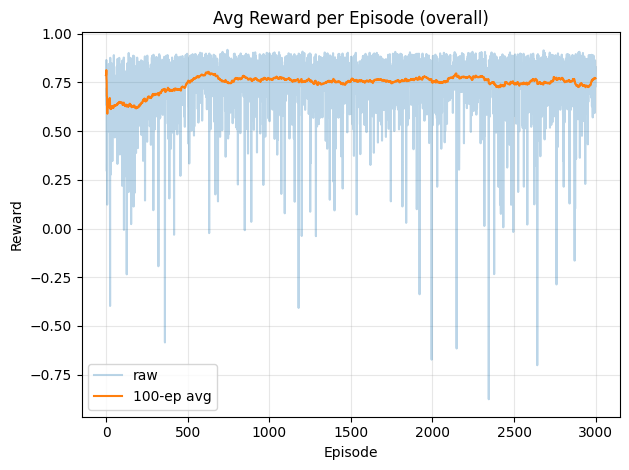

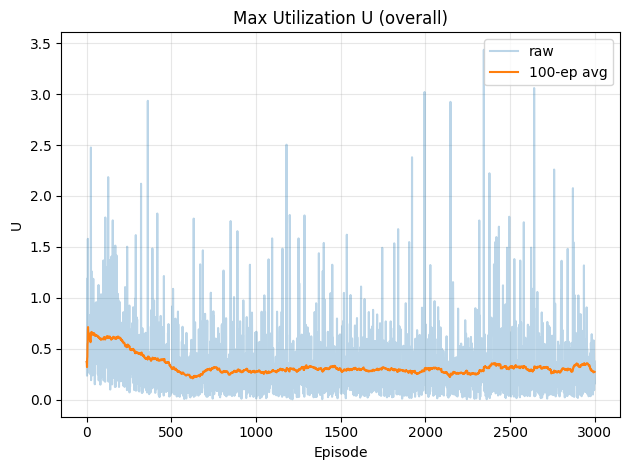

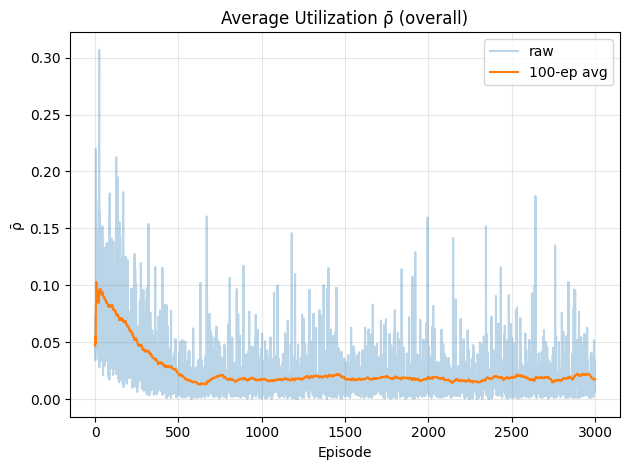

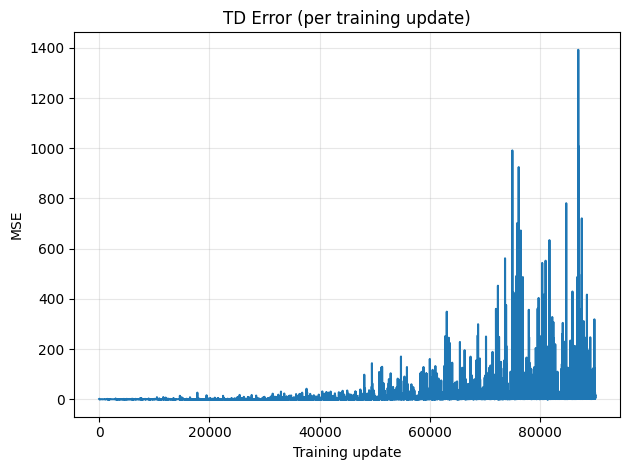

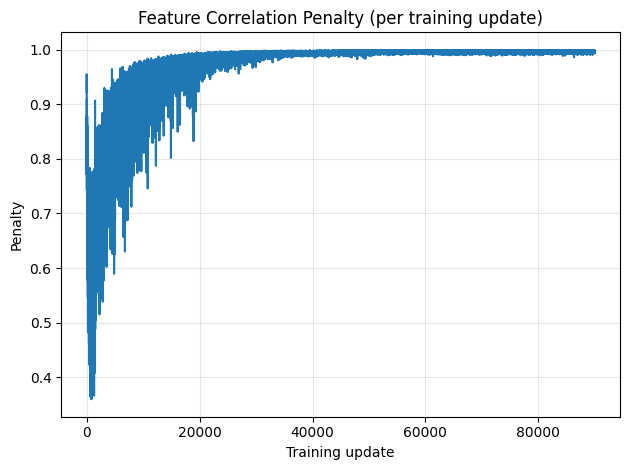

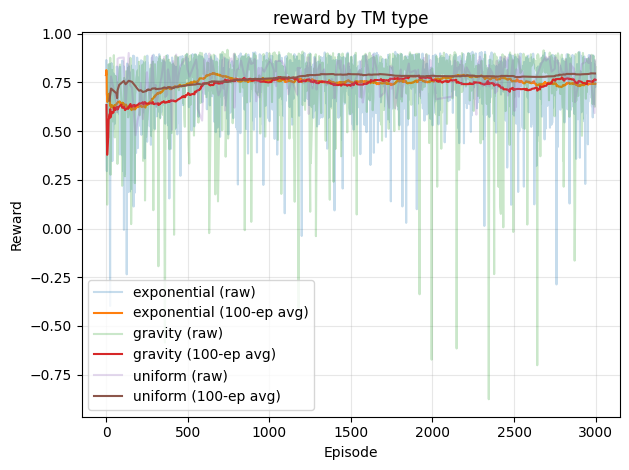

Saved: ./plots/train_reward_by_tmtype.png


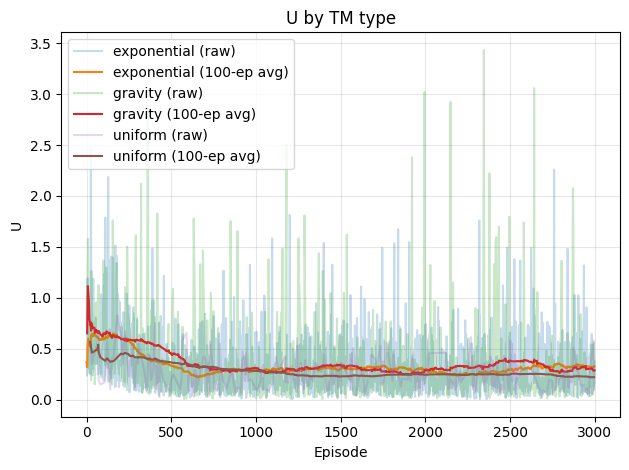

Saved: ./plots/train_U_by_tmtype.png


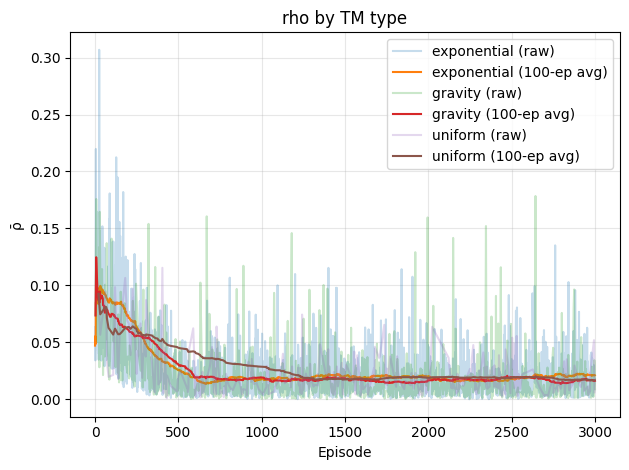

Saved: ./plots/train_rho_by_tmtype.png


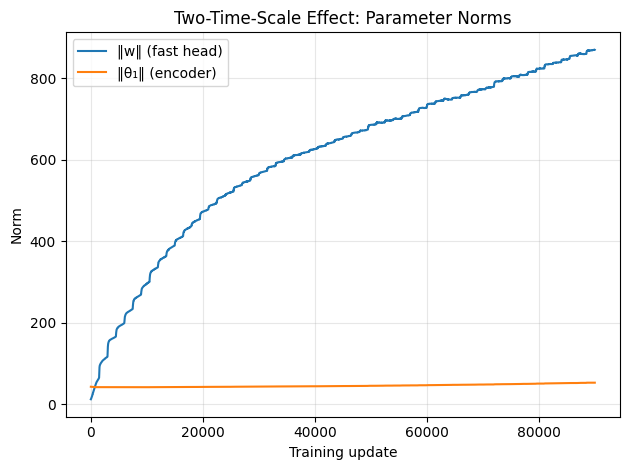

Saved: ./plots/train_two_timescale_param_norms.png


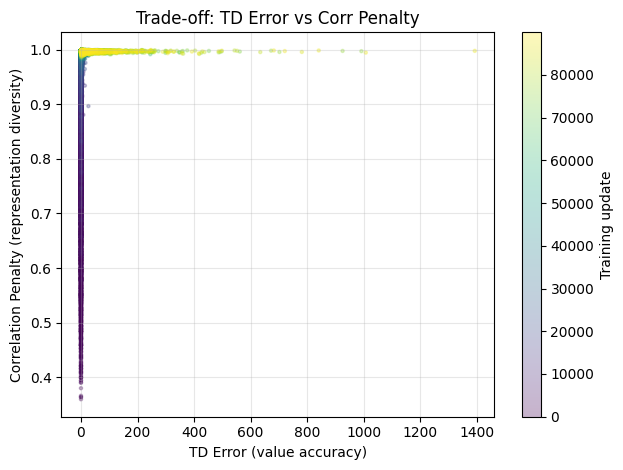

Saved: ./plots/train_td_vs_corr.png
Saved CSVs: ./plots/train_episode_logs.csv and train_update_logs.csv


In [18]:
# Cell 6 — Training plots (overall + per TM type, saved automatically + CSV export)

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

SAVE_DIR = "./plots"
os.makedirs(SAVE_DIR, exist_ok=True)

# Flexible rolling function
def roll(x, w=100):
    return pd.Series(x).rolling(window=w, min_periods=1).mean().to_numpy()

ROLL_WIN = 100  # <-- adjust here if needed

# --- Overall episode-level logs (with smoothing) ---

plt.figure()
plt.plot(rewards_log, alpha=0.3, label="raw")
plt.plot(roll(rewards_log, ROLL_WIN), label=f"{ROLL_WIN}-ep avg")
plt.title("Avg Reward per Episode (overall)")
plt.xlabel("Episode"); plt.ylabel("Reward"); plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/train_reward_overall.png", dpi=150)
plt.show()

plt.figure()
plt.plot(U_log, alpha=0.3, label="raw")
plt.plot(roll(U_log, ROLL_WIN), label=f"{ROLL_WIN}-ep avg")
plt.title("Max Utilization U (overall)")
plt.xlabel("Episode"); plt.ylabel("U"); plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/train_maxU_overall.png", dpi=150)
plt.show()

plt.figure()
plt.plot(rho_log, alpha=0.3, label="raw")
plt.plot(roll(rho_log, ROLL_WIN), label=f"{ROLL_WIN}-ep avg")
plt.title("Average Utilization ρ̄ (overall)")
plt.xlabel("Episode"); plt.ylabel("ρ̄"); plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/train_avgRho_overall.png", dpi=150)
plt.show()

# --- Update-step level logs (per replay update) ---

plt.figure()
plt.plot(td_log)
plt.title("TD Error (per training update)")
plt.xlabel("Training update"); plt.ylabel("MSE"); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/train_TDerror_updates.png", dpi=150)
plt.show()

plt.figure()
plt.plot(corr_log)
plt.title("Feature Correlation Penalty (per training update)")
plt.xlabel("Training update"); plt.ylabel("Penalty"); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/train_featurecorr_updates.png", dpi=150)
plt.show()

# --- Per TM type (episode-level) ---

df_train = pd.DataFrame({
    "episode": np.arange(len(rewards_log)),
    "gen": gen_log,
    "reward": rewards_log,
    "U": U_log,
    "rho": rho_log
})

for metric, ylabel in [("reward", "Reward"), ("U", "U"), ("rho", "ρ̄")]:
    plt.figure()
    for g, sub in df_train.groupby("gen"):
        sub = sub.sort_values("episode")
        plt.plot(sub["episode"], sub[metric], alpha=0.25, label=f"{g} (raw)")
        plt.plot(sub["episode"], roll(sub[metric], ROLL_WIN), label=f"{g} ({ROLL_WIN}-ep avg)")
    plt.title(f"{metric} by TM type")
    plt.xlabel("Episode"); plt.ylabel(ylabel); plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout()
    out = f"{SAVE_DIR}/train_{metric}_by_tmtype.png"
    plt.savefig(out, dpi=150)
    plt.show()
    print(f"Saved: {out}")

# --- Two-time-scale confirmation — parameter norms (evolving) ---

plt.figure()
plt.plot(w_norms, label="‖w‖ (fast head)")
plt.plot(enc_norms, label="‖θ₁‖ (encoder)")
plt.title("Two-Time-Scale Effect: Parameter Norms")
plt.xlabel("Training update"); plt.ylabel("Norm"); plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/train_two_timescale_param_norms.png", dpi=150)
plt.show()
print(f"Saved: {SAVE_DIR}/train_two_timescale_param_norms.png")

# --- TD Error vs Correlation Penalty (trade-off curve) ---

plt.figure()
plt.scatter(td_log, corr_log, alpha=0.3, s=5, c=np.arange(len(td_log)), cmap="viridis")
plt.colorbar(label="Training update")
plt.xlabel("TD Error (value accuracy)")
plt.ylabel("Correlation Penalty (representation diversity)")
plt.title("Trade-off: TD Error vs Corr Penalty")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/train_td_vs_corr.png", dpi=150)
plt.show()
print(f"Saved: {SAVE_DIR}/train_td_vs_corr.png")

# --- CSV Exports ---

train_df = pd.DataFrame({
    "episode": np.arange(len(rewards_log)),
    "reward": rewards_log,
    "U": U_log,
    "rho": rho_log,
    "gen": gen_log
})
train_df.to_csv(f"{SAVE_DIR}/train_episode_logs.csv", index=False)

update_df = pd.DataFrame({
    "update_step": np.arange(len(td_log)),
    "td_error": td_log,
    "corr_penalty": corr_log,
    "w_norm": w_norms,
    "enc_norm": enc_norms
})
update_df.to_csv(f"{SAVE_DIR}/train_update_logs.csv", index=False)

print(f"Saved CSVs: {SAVE_DIR}/train_episode_logs.csv and train_update_logs.csv")


In [7]:
# Cell 7 — Inference (Algorithm 2, training-consistent with τ filtering + ε-decay per step + α decay)

def run_inference_alg2(
    TMS_test, META_test, phi_encoder,
    lam=0.55, episodes=1000, K=10,
    alpha0=1e-3, alpha_min=1e-5, alpha_decay=0.999,
    gamma=0.99,
    eps_start=1.0, eps_end=0.05, eps_decay=0.995
):
    """
    Inference (Alg 2):
    - Encoder φ(s) frozen; only w updated online with row-wise LFA.
    - ε-greedy with decay (decayed *per step*).
    - α decays per episode: large at start, smaller as adaptation continues.
    - τ filtering for path selection.
    """
    phi_encoder.eval()
    with torch.no_grad():
        phi_dim = phi_encoder(torch.zeros(1, STATE_DIM).to(device)).size(1)

    # Linear FA weights for all actions (start near 0 for stability)
    w = torch.zeros(N_ACTIONS, phi_dim, device=device)

    rewards_log, U_log, rho_log, gen_log = [], [], [], []

    # ε-decay init
    eps = eps_start
    from tqdm import trange

    for ep in trange(episodes, desc="Inference Episodes", ncols=100):

   # for ep in range(episodes):
        # 🔑 scheduled learning rate for this episode
        alpha = max(alpha_min, alpha0 * (alpha_decay ** ep))

        # sample a TM from test set
        idx = np.random.randint(len(TMS_test))
        TM = TMS_test[idx]
        tm_type = META_test.iloc[idx]["gen"]
        state = init_state(TM)

        ep_rewards, ep_Us, ep_rhos = [], [], []
        ep_deltas = []
        explore_ct = 0; exploit_ct = 0

        for step in range(K):
            # φ(s)
            s_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                phi_s = phi_encoder(s_tensor).squeeze(0)     # [d]

            # Q(s,·) = φ(s) @ w^T
            q_vals = torch.mv(w, phi_s)                      # [A]

            # ε-greedy with decaying ε
            if np.random.rand() < eps:
                action = np.random.randint(N_ACTIONS); explore_ct += 1
            else:
                action = int(torch.argmax(q_vals).item()); exploit_ct += 1

            # env step (τ filtering consistent with training)
            s_next, r, U, rho = apply_action(state, action, TM, lam=lam, tau=0.8)

            # TD target
            with torch.no_grad():
                phi_sp = phi_encoder(torch.FloatTensor(s_next).unsqueeze(0).to(device)).squeeze(0)
                q_next = torch.mv(w, phi_sp)
                y = torch.tensor(r, device=device) + gamma * torch.max(q_next)

            # δ = y - Q(s,a)
            q_sa = torch.dot(w[action], phi_s)
            delta = (y - q_sa).detach()
            ep_deltas.append(float(delta))

            # Row-wise update with decayed α
            with torch.no_grad():
                w[action].add_(alpha * delta * phi_s)

            # advance
            state = s_next
            ep_rewards.append(r); ep_Us.append(U); ep_rhos.append(rho)

            # ✅ decay ε per step
            eps = max(eps_end, eps * eps_decay)

        # episode logs
        Rm = float(np.mean(ep_rewards)); Um = float(np.mean(ep_Us)); rhom = float(np.mean(ep_rhos))
        rewards_log.append(Rm); U_log.append(Um); rho_log.append(rhom); gen_log.append(tm_type)

        # safe average for δ̄
        if not ep_deltas:
            d_mean = float('nan')
        else:
            d_mean = float(np.mean(ep_deltas))
    
        print(
            f"[Alg2 Ep {ep+1:03d}] λ={lam:.2f} eps={eps:.3f} α={alpha:.6f} "
            f"R={Rm:+.4f} U={Um:.3f} ρ={rhom:.3f} "
            f"δ̄={d_mean:+.5f} stepsE={explore_ct} stepsX={exploit_ct} tm={tm_type}"
        )

    return rewards_log, U_log, rho_log, gen_log


In [8]:
class IdentityEncoder(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.state_dim = state_dim

    def forward(self, x):
        # Directly return raw state (no normalization)
        return x


In [9]:
class RandomEncoder(nn.Module):
    def __init__(self, state_dim, phi_dim=None):
        super().__init__()
        if phi_dim is None:
            phi_dim = state_dim   # match transfer and scratch → same dim

        self.proj = nn.Linear(state_dim, phi_dim, bias=False)
        # freeze weights (no training)
        with torch.no_grad():
            self.proj.weight.copy_(torch.randn(phi_dim, state_dim) * 0.01)
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        # Random projection without normalization
        return self.proj(x)


In [24]:
# Cell 8 — Run inference: Transfer vs Scratch (with α schedule)

# 1) Load trained φ(s) and freeze
phi_trained = PhiEncoder(STATE_DIM, phi_dim=None).to(device)  # → 293
phi_trained.load_state_dict(torch.load(DATA_DIR / f"{TOPO_NAME}_phi_trained.pth",
                                       map_location=device))
phi_trained.eval()
for p in phi_trained.parameters():
    p.requires_grad = False

# 2) Scratch φ(s): identity mapping (raw state vector as φ(s))
phi_scratch = IdentityEncoder(STATE_DIM).to(device)
phi_scratch.eval()

# 3) Random φ(s): fixed random projection (now 293-dim too)
phi_random = RandomEncoder(STATE_DIM, phi_dim=None).to(device)
phi_random.eval()

# Common inference settings
LAM_TEST   = 0.7      # different operating point than training → good for transfer
EPISODES_I = 1000
K_I        = 30
GAMMA_I    = 0.99

# α schedules
ALPHA0_T   = 4.5e-5      # Transfer: small, stable
ALPHA_MIN_T = 1e-5
DECAY_T    = 0.999

ALPHA0_S   = 3e-4      # Scratch: still larger, but not exploding
ALPHA_MIN_S = 1e-5
DECAY_S    = 0.999

# TRANSFER run
rewards_T, U_T, rho_T, gen_T = run_inference_alg2(
    TMS_test, META_test, phi_trained,
    lam=LAM_TEST, episodes=EPISODES_I, K=K_I,
    alpha0=ALPHA0_T, alpha_min=ALPHA_MIN_T, alpha_decay=DECAY_T,
    gamma=GAMMA_I,
    eps_start=1.0, eps_end=0.05, eps_decay=0.995
)

# SCRATCH run
rewards_S, U_S, rho_S, gen_S = run_inference_alg2(
    TMS_test, META_test, phi_scratch,
    lam=LAM_TEST, episodes=EPISODES_I, K=K_I,
    alpha0=ALPHA0_S, alpha_min=ALPHA_MIN_S, alpha_decay=DECAY_S,
    gamma=GAMMA_I,
    eps_start=1.0, eps_end=0.05, eps_decay=0.995
)

# RANDOM run
rewards_R, U_R, rho_R, gen_R = run_inference_alg2(
    TMS_test, META_test, phi_random,
    lam=LAM_TEST, episodes=EPISODES_I, K=K_I,
    alpha0=ALPHA0_S, alpha_min=ALPHA_MIN_S, alpha_decay=DECAY_S,  # same as Scratch
    gamma=GAMMA_I,
    eps_start=1.0, eps_end=0.05, eps_decay=0.995
)


print(f"\n=== Summary (ε-greedy adaptation, λ={LAM_TEST:.2f}) ===")
print(f"TRANSFER:  R={np.mean(rewards_T):+.4f}, U={np.mean(U_T):.3f}, rho={np.mean(rho_T):.3f}")
print(f"SCRATCH :  R={np.mean(rewards_S):+.4f}, U={np.mean(U_S):.3f}, rho={np.mean(rho_S):.3f}")
print(f"RANDOM  :  R={np.mean(rewards_R):+.4f}, U={np.mean(U_R):.3f}, rho={np.mean(rho_R):.3f}")

print("φ_trained dim:", phi_trained(torch.zeros(1, STATE_DIM).to(device)).shape)
print("φ_scratch dim:", phi_scratch(torch.zeros(1, STATE_DIM).to(device)).shape)
print("φ_random dim :", phi_random(torch.zeros(1, STATE_DIM).to(device)).shape)


C:\Users\Uma\AppData\Local\Temp\ipykernel_852236\3016945084.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  phi_trained.load_state_dict(torch.load(DATA_DIR / f"{TOPO_NAM

[Alg2 Ep 001] λ=0.70 eps=0.860 α=0.000045 R=+0.8498 U=0.322 ρ=0.053 δ̄=+0.87317 stepsE=26 stepsX=4 tm=exponential
[Alg2 Ep 002] λ=0.70 eps=0.740 α=0.000045 R=+0.6621 U=0.680 ρ=0.158 δ̄=+0.70228 stepsE=23 stepsX=7 tm=exponential
[Alg2 Ep 003] λ=0.70 eps=0.637 α=0.000045 R=+0.8651 U=0.294 ρ=0.048 δ̄=+0.95472 stepsE=25 stepsX=5 tm=exponential
[Alg2 Ep 004] λ=0.70 eps=0.548 α=0.000045 R=+0.7702 U=0.503 ρ=0.046 δ̄=+0.85570 stepsE=15 stepsX=15 tm=exponential
[Alg2 Ep 005] λ=0.70 eps=0.471 α=0.000045 R=+0.7756 U=0.438 ρ=0.052 δ̄=+0.90091 stepsE=12 stepsX=18 tm=exponential
[Alg2 Ep 006] λ=0.70 eps=0.406 α=0.000045 R=+0.8045 U=0.408 ρ=0.047 δ̄=+1.01268 stepsE=17 stepsX=13 tm=exponential


Inference Episodes:   1%|▍                                        | 10/1000 [00:00<00:33, 29.88it/s]

[Alg2 Ep 007] λ=0.70 eps=0.349 α=0.000045 R=+0.7071 U=0.597 ρ=0.091 δ̄=+0.90971 stepsE=14 stepsX=16 tm=exponential
[Alg2 Ep 008] λ=0.70 eps=0.300 α=0.000045 R=+0.8566 U=0.221 ρ=0.024 δ̄=+1.10503 stepsE=11 stepsX=19 tm=gravity
[Alg2 Ep 009] λ=0.70 eps=0.258 α=0.000045 R=+0.8385 U=0.233 ρ=0.031 δ̄=+1.03684 stepsE=8 stepsX=22 tm=gravity
[Alg2 Ep 010] λ=0.70 eps=0.222 α=0.000045 R=+0.7343 U=0.484 ρ=0.063 δ̄=+0.90213 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 011] λ=0.70 eps=0.191 α=0.000045 R=+0.8843 U=0.072 ρ=0.006 δ̄=+0.94544 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 012] λ=0.70 eps=0.165 α=0.000045 R=+0.8695 U=0.142 ρ=0.007 δ̄=+1.02435 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 013] λ=0.70 eps=0.142 α=0.000044 R=+0.8875 U=0.105 ρ=0.006 δ̄=+1.20463 stepsE=6 stepsX=24 tm=gravity
[Alg2 Ep 014] λ=0.70 eps=0.122 α=0.000044 R=+0.8520 U=0.186 ρ=0.017 δ̄=+1.12258 stepsE=5 stepsX=25 tm=exponential


Inference Episodes:   2%|▋                                        | 18/1000 [00:00<00:28, 34.22it/s]

[Alg2 Ep 015] λ=0.70 eps=0.105 α=0.000044 R=+0.8817 U=0.083 ρ=0.005 δ̄=+1.00069 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 016] λ=0.70 eps=0.090 α=0.000044 R=+0.7562 U=0.428 ρ=0.031 δ̄=+0.80082 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 017] λ=0.70 eps=0.078 α=0.000044 R=+0.8451 U=0.190 ρ=0.011 δ̄=+0.98795 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 018] λ=0.70 eps=0.067 α=0.000044 R=+0.8570 U=0.146 ρ=0.008 δ̄=+0.91640 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 019] λ=0.70 eps=0.057 α=0.000044 R=+0.8173 U=0.284 ρ=0.011 δ̄=+0.98105 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 020] λ=0.70 eps=0.050 α=0.000044 R=+0.7443 U=0.513 ρ=0.022 δ̄=+1.02260 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 021] λ=0.70 eps=0.050 α=0.000044 R=+0.8998 U=0.011 ρ=0.001 δ̄=+0.86574 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 022] λ=0.70 eps=0.050 α=0.000044 R=+0.8701 U=0.115 ρ=0.008 δ̄=+1.06372 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   3%|█▏                                       | 28/1000 [00:00<00:25, 38.36it/s]

[Alg2 Ep 023] λ=0.70 eps=0.050 α=0.000044 R=+0.9015 U=0.016 ρ=0.001 δ̄=+0.99349 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 024] λ=0.70 eps=0.050 α=0.000044 R=+0.9024 U=0.013 ρ=0.001 δ̄=+0.99287 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 025] λ=0.70 eps=0.050 α=0.000044 R=+0.8803 U=0.086 ρ=0.005 δ̄=+1.14286 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 026] λ=0.70 eps=0.050 α=0.000044 R=+0.8766 U=0.100 ρ=0.005 δ̄=+1.13334 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 027] λ=0.70 eps=0.050 α=0.000044 R=+0.9063 U=0.010 ρ=0.001 δ̄=+1.19924 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 028] λ=0.70 eps=0.050 α=0.000044 R=+0.8373 U=0.200 ρ=0.013 δ̄=+0.94984 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 029] λ=0.70 eps=0.050 α=0.000044 R=+0.7999 U=0.308 ρ=0.016 δ̄=+0.75126 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 030] λ=0.70 eps=0.050 α=0.000044 R=+0.7799 U=0.377 ρ=0.025 δ̄=+1.05092 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 031] λ=0.70 eps=0.050 α=0.000044 R=+0.8824 U=0.080 ρ=0.005 δ̄=+1.15215 stepsE=2 stepsX=28 tm=gr

Inference Episodes:   4%|█▌                                       | 37/1000 [00:01<00:25, 38.45it/s]

[Alg2 Ep 032] λ=0.70 eps=0.050 α=0.000044 R=+0.8943 U=0.027 ρ=0.001 δ̄=+0.83254 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 033] λ=0.70 eps=0.050 α=0.000044 R=+0.8900 U=0.048 ρ=0.003 δ̄=+1.03514 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 034] λ=0.70 eps=0.050 α=0.000044 R=+0.8764 U=0.080 ρ=0.004 δ̄=+0.80992 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 035] λ=0.70 eps=0.050 α=0.000043 R=+0.7804 U=0.365 ρ=0.019 δ̄=+0.72176 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 036] λ=0.70 eps=0.050 α=0.000043 R=+0.9009 U=0.007 ρ=0.000 δ̄=+0.83238 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 037] λ=0.70 eps=0.050 α=0.000043 R=+0.8974 U=0.027 ρ=0.002 δ̄=+1.07190 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 038] λ=0.70 eps=0.050 α=0.000043 R=+0.8395 U=0.198 ρ=0.011 δ̄=+0.98982 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 039] λ=0.70 eps=0.050 α=0.000043 R=+0.8560 U=0.156 ρ=0.010 δ̄=+1.25123 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   4%|█▊                                       | 45/1000 [00:01<00:26, 36.56it/s]

[Alg2 Ep 040] λ=0.70 eps=0.050 α=0.000043 R=+0.8609 U=0.148 ρ=0.007 δ̄=+1.28948 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 041] λ=0.70 eps=0.050 α=0.000043 R=+0.8625 U=0.156 ρ=0.006 δ̄=+1.61044 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 042] λ=0.70 eps=0.050 α=0.000043 R=+0.7546 U=0.459 ρ=0.025 δ̄=+1.19693 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 043] λ=0.70 eps=0.050 α=0.000043 R=+0.8154 U=0.268 ρ=0.016 δ̄=+0.98223 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 044] λ=0.70 eps=0.050 α=0.000043 R=+0.8971 U=0.028 ρ=0.002 δ̄=+1.11578 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 045] λ=0.70 eps=0.050 α=0.000043 R=+0.8990 U=0.022 ρ=0.001 δ̄=+1.12106 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 046] λ=0.70 eps=0.050 α=0.000043 R=+0.8545 U=0.163 ρ=0.010 δ̄=+1.38674 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 047] λ=0.70 eps=0.050 α=0.000043 R=+0.8479 U=0.169 ρ=0.011 δ̄=+1.04295 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:   5%|██▏                                      | 54/1000 [00:01<00:24, 38.08it/s]

[Alg2 Ep 048] λ=0.70 eps=0.050 α=0.000043 R=+0.8873 U=0.066 ρ=0.004 δ̄=+1.45530 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 049] λ=0.70 eps=0.050 α=0.000043 R=+0.8679 U=0.114 ρ=0.007 δ̄=+1.09815 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 050] λ=0.70 eps=0.050 α=0.000043 R=+0.6686 U=0.714 ρ=0.044 δ̄=+1.47224 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 051] λ=0.70 eps=0.050 α=0.000043 R=+0.8633 U=0.119 ρ=0.006 δ̄=+0.76684 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 052] λ=0.70 eps=0.050 α=0.000043 R=+0.8562 U=0.140 ρ=0.007 δ̄=+0.75616 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 053] λ=0.70 eps=0.050 α=0.000043 R=+0.8706 U=0.107 ρ=0.006 δ̄=+1.07809 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 054] λ=0.70 eps=0.050 α=0.000043 R=+0.9030 U=0.001 ρ=0.000 δ̄=+0.80396 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 055] λ=0.70 eps=0.050 α=0.000043 R=+0.8029 U=0.302 ρ=0.023 δ̄=+1.35277 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   6%|██▌                                      | 63/1000 [00:01<00:23, 39.06it/s]

[Alg2 Ep 056] λ=0.70 eps=0.050 α=0.000043 R=+0.8985 U=0.014 ρ=0.001 δ̄=+0.78067 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 057] λ=0.70 eps=0.050 α=0.000043 R=+0.8980 U=0.016 ρ=0.001 δ̄=+0.77429 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 058] λ=0.70 eps=0.050 α=0.000043 R=+0.9055 U=0.022 ρ=0.002 δ̄=+2.06219 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 059] λ=0.70 eps=0.050 α=0.000042 R=+0.8614 U=0.134 ρ=0.007 δ̄=+1.13630 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 060] λ=0.70 eps=0.050 α=0.000042 R=+0.8936 U=0.055 ρ=0.004 δ̄=+1.80348 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 061] λ=0.70 eps=0.050 α=0.000042 R=+0.8331 U=0.228 ρ=0.017 δ̄=+1.82143 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 062] λ=0.70 eps=0.050 α=0.000042 R=+0.8264 U=0.246 ρ=0.014 δ̄=+1.49643 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 063] λ=0.70 eps=0.050 α=0.000042 R=+0.8747 U=0.094 ρ=0.006 δ̄=+1.14915 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 064] λ=0.70 eps=0.050 α=0.000042 R=+0.8868 U=0.049 ρ=0.003 δ̄=+0.75389 stepsE=0 stepsX=

Inference Episodes:   7%|██▊                                      | 68/1000 [00:01<00:23, 39.86it/s]

[Alg2 Ep 065] λ=0.70 eps=0.050 α=0.000042 R=+0.8611 U=0.145 ρ=0.008 δ̄=+1.63871 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 066] λ=0.70 eps=0.050 α=0.000042 R=+0.7555 U=0.466 ρ=0.021 δ̄=+1.39814 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 067] λ=0.70 eps=0.050 α=0.000042 R=+0.7809 U=0.387 ρ=0.014 δ̄=+1.09653 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 068] λ=0.70 eps=0.050 α=0.000042 R=+0.7914 U=0.333 ρ=0.017 δ̄=+0.64167 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 069] λ=0.70 eps=0.050 α=0.000042 R=+0.8880 U=0.054 ρ=0.003 δ̄=+1.18876 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 070] λ=0.70 eps=0.050 α=0.000042 R=+0.7882 U=0.354 ρ=0.022 δ̄=+1.59545 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 071] λ=0.70 eps=0.050 α=0.000042 R=+0.7762 U=0.378 ρ=0.020 δ̄=+0.64666 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 072] λ=0.70 eps=0.050 α=0.000042 R=+0.8200 U=0.253 ρ=0.020 δ̄=+1.56086 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:   8%|███▏                                     | 78/1000 [00:02<00:22, 41.29it/s]

[Alg2 Ep 073] λ=0.70 eps=0.050 α=0.000042 R=+0.8775 U=0.087 ρ=0.009 δ̄=+1.72095 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 074] λ=0.70 eps=0.050 α=0.000042 R=+0.8869 U=0.058 ρ=0.003 δ̄=+1.22903 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 075] λ=0.70 eps=0.050 α=0.000042 R=+0.8133 U=0.284 ρ=0.012 δ̄=+1.13546 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 076] λ=0.70 eps=0.050 α=0.000042 R=+0.9022 U=0.003 ρ=0.000 δ̄=+0.74632 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 077] λ=0.70 eps=0.050 α=0.000042 R=+0.7780 U=0.384 ρ=0.024 δ̄=+1.52176 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 078] λ=0.70 eps=0.050 α=0.000042 R=+0.8691 U=0.119 ρ=0.007 δ̄=+1.69845 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 079] λ=0.70 eps=0.050 α=0.000042 R=+0.8627 U=0.127 ρ=0.008 δ̄=+1.16916 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 080] λ=0.70 eps=0.050 α=0.000042 R=+0.8339 U=0.206 ρ=0.011 δ̄=+0.67576 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 081] λ=0.70 eps=0.050 α=0.000042 R=+0.8992 U=0.032 ρ=0.002 δ̄=+1.83355 stepsE=2 stepsX=

Inference Episodes:   9%|███▌                                     | 87/1000 [00:02<00:25, 35.19it/s]

[Alg2 Ep 082] λ=0.70 eps=0.050 α=0.000041 R=+0.7401 U=0.487 ρ=0.039 δ̄=+2.01826 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 083] λ=0.70 eps=0.050 α=0.000041 R=+0.7504 U=0.469 ρ=0.027 δ̄=+1.54390 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 084] λ=0.70 eps=0.050 α=0.000041 R=+0.8363 U=0.205 ρ=0.017 δ̄=+1.62622 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 085] λ=0.70 eps=0.050 α=0.000041 R=+0.8407 U=0.195 ρ=0.011 δ̄=+1.16955 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 086] λ=0.70 eps=0.050 α=0.000041 R=+0.7924 U=0.368 ρ=0.015 δ̄=+2.09124 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 087] λ=0.70 eps=0.050 α=0.000041 R=+0.8710 U=0.114 ρ=0.007 δ̄=+1.75841 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 088] λ=0.70 eps=0.050 α=0.000041 R=+0.5526 U=1.060 ρ=0.056 δ̄=+1.38064 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  10%|███▉                                     | 96/1000 [00:02<00:23, 38.61it/s]

[Alg2 Ep 089] λ=0.70 eps=0.050 α=0.000041 R=+0.8660 U=0.111 ρ=0.006 δ̄=+0.70015 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 090] λ=0.70 eps=0.050 α=0.000041 R=+0.8269 U=0.245 ρ=0.014 δ̄=+1.88862 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 091] λ=0.70 eps=0.050 α=0.000041 R=+0.8850 U=0.064 ρ=0.003 δ̄=+1.32655 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 092] λ=0.70 eps=0.050 α=0.000041 R=+0.9020 U=0.004 ρ=0.000 δ̄=+0.73830 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 093] λ=0.70 eps=0.050 α=0.000041 R=+0.8980 U=0.016 ρ=0.001 δ̄=+0.72231 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 094] λ=0.70 eps=0.050 α=0.000041 R=+0.8765 U=0.080 ρ=0.004 δ̄=+0.69482 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 095] λ=0.70 eps=0.050 α=0.000041 R=+0.8213 U=0.286 ρ=0.018 δ̄=+3.72371 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 096] λ=0.70 eps=0.050 α=0.000041 R=+0.9015 U=0.033 ρ=0.003 δ̄=+2.65351 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 097] λ=0.70 eps=0.050 α=0.000041 R=+0.7238 U=0.528 ρ=0.035 δ̄=+1.10577 stepsE=1 stepsX=29 tm=ex

Inference Episodes:  10%|████                                    | 101/1000 [00:02<00:22, 39.51it/s]

[Alg2 Ep 098] λ=0.70 eps=0.050 α=0.000041 R=+0.8503 U=0.167 ρ=0.009 δ̄=+1.28965 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 099] λ=0.70 eps=0.050 α=0.000041 R=+0.8630 U=0.128 ρ=0.008 δ̄=+1.33365 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 100] λ=0.70 eps=0.050 α=0.000041 R=+0.7516 U=0.490 ρ=0.011 δ̄=+1.14610 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 101] λ=0.70 eps=0.050 α=0.000041 R=+0.7376 U=0.501 ρ=0.027 δ̄=+1.13758 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 102] λ=0.70 eps=0.050 α=0.000041 R=+0.8737 U=0.106 ρ=0.006 δ̄=+1.88633 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 103] λ=0.70 eps=0.050 α=0.000041 R=+0.3661 U=1.633 ρ=0.082 δ̄=+1.90119 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 104] λ=0.70 eps=0.050 α=0.000041 R=+0.8514 U=0.162 ρ=0.010 δ̄=+1.26287 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 105] λ=0.70 eps=0.050 α=0.000041 R=+0.8852 U=0.054 ρ=0.003 δ̄=+0.71918 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  11%|████▍                                   | 111/1000 [00:02<00:22, 39.58it/s]

[Alg2 Ep 106] λ=0.70 eps=0.050 α=0.000041 R=+0.8597 U=0.142 ρ=0.006 δ̄=+1.30321 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 107] λ=0.70 eps=0.050 α=0.000040 R=+0.8976 U=0.027 ρ=0.001 δ̄=+1.40838 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 108] λ=0.70 eps=0.050 α=0.000040 R=+0.8467 U=0.193 ρ=0.012 δ̄=+2.42230 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 109] λ=0.70 eps=0.050 α=0.000040 R=+0.8642 U=0.148 ρ=0.007 δ̄=+2.49407 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 110] λ=0.70 eps=0.050 α=0.000040 R=+0.8851 U=0.064 ρ=0.003 δ̄=+1.30009 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 111] λ=0.70 eps=0.050 α=0.000040 R=+0.9042 U=0.017 ρ=0.001 δ̄=+2.18242 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 112] λ=0.70 eps=0.050 α=0.000040 R=+0.8825 U=0.072 ρ=0.004 δ̄=+1.41767 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 113] λ=0.70 eps=0.050 α=0.000040 R=+0.6769 U=0.673 ρ=0.035 δ̄=+0.45051 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  12%|████▊                                   | 119/1000 [00:03<00:23, 36.89it/s]

[Alg2 Ep 114] λ=0.70 eps=0.050 α=0.000040 R=+0.8529 U=0.150 ρ=0.008 δ̄=+0.63908 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 115] λ=0.70 eps=0.050 α=0.000040 R=+0.8897 U=0.068 ρ=0.004 δ̄=+3.01770 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 116] λ=0.70 eps=0.050 α=0.000040 R=+0.7578 U=0.466 ρ=0.023 δ̄=+2.67946 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 117] λ=0.70 eps=0.050 α=0.000040 R=+0.7792 U=0.375 ρ=0.021 δ̄=+1.23115 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 118] λ=0.70 eps=0.050 α=0.000040 R=+0.8497 U=0.159 ρ=0.008 δ̄=+0.61504 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 119] λ=0.70 eps=0.050 α=0.000040 R=+0.7756 U=0.411 ρ=0.016 δ̄=+2.04000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 120] λ=0.70 eps=0.050 α=0.000040 R=+0.7694 U=0.417 ρ=0.022 δ̄=+1.89011 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 121] λ=0.70 eps=0.050 α=0.000040 R=+0.8895 U=0.050 ρ=0.003 δ̄=+1.44022 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  13%|█████▏                                  | 129/1000 [00:03<00:22, 39.24it/s]

[Alg2 Ep 122] λ=0.70 eps=0.050 α=0.000040 R=+0.7683 U=0.407 ρ=0.033 δ̄=+2.69275 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 123] λ=0.70 eps=0.050 α=0.000040 R=+0.8574 U=0.146 ρ=0.008 δ̄=+1.37620 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 124] λ=0.70 eps=0.050 α=0.000040 R=+0.7741 U=0.400 ρ=0.027 δ̄=+2.52924 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 125] λ=0.70 eps=0.050 α=0.000040 R=+0.8854 U=0.063 ρ=0.003 δ̄=+1.37499 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 126] λ=0.70 eps=0.050 α=0.000040 R=+0.8914 U=0.035 ρ=0.002 δ̄=+0.64054 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 127] λ=0.70 eps=0.050 α=0.000040 R=+0.8313 U=0.207 ρ=0.024 δ̄=+2.07755 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 128] λ=0.70 eps=0.050 α=0.000040 R=+0.8849 U=0.055 ρ=0.003 δ̄=+0.68444 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 129] λ=0.70 eps=0.050 α=0.000040 R=+0.8678 U=0.116 ρ=0.006 δ̄=+1.33196 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 130] λ=0.70 eps=0.050 α=0.000040 R=+0.8616 U=0.146 ρ=0.011 δ̄=+2.91414 stepsE=3 stepsX=27 tm=expone

Inference Episodes:  14%|█████▍                                  | 137/1000 [00:03<00:23, 37.35it/s]

[Alg2 Ep 131] λ=0.70 eps=0.050 α=0.000040 R=+0.8572 U=0.137 ρ=0.007 δ̄=+0.60275 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 132] λ=0.70 eps=0.050 α=0.000039 R=+0.8839 U=0.076 ρ=0.005 δ̄=+2.34695 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 133] λ=0.70 eps=0.050 α=0.000039 R=+0.9039 U=0.017 ρ=0.001 δ̄=+2.28790 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 134] λ=0.70 eps=0.050 α=0.000039 R=+0.8471 U=0.175 ρ=0.015 δ̄=+2.08229 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 135] λ=0.70 eps=0.050 α=0.000039 R=+0.8039 U=0.306 ρ=0.020 δ̄=+2.22194 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 136] λ=0.70 eps=0.050 α=0.000039 R=+0.6813 U=0.663 ρ=0.038 δ̄=+1.18291 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 137] λ=0.70 eps=0.050 α=0.000039 R=+0.8981 U=0.016 ρ=0.001 δ̄=+0.64805 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 138] λ=0.70 eps=0.050 α=0.000039 R=+0.7952 U=0.322 ρ=0.026 δ̄=+2.03589 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  14%|█████▋                                  | 142/1000 [00:03<00:21, 39.17it/s]

[Alg2 Ep 139] λ=0.70 eps=0.050 α=0.000039 R=+0.9008 U=0.018 ρ=0.001 δ̄=+1.39899 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 140] λ=0.70 eps=0.050 α=0.000039 R=+0.8238 U=0.257 ρ=0.013 δ̄=+2.06600 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 141] λ=0.70 eps=0.050 α=0.000039 R=+0.8202 U=0.254 ρ=0.020 δ̄=+2.20571 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 142] λ=0.70 eps=0.050 α=0.000039 R=+0.8801 U=0.069 ρ=0.004 δ̄=+0.65222 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 143] λ=0.70 eps=0.050 α=0.000039 R=+0.8546 U=0.153 ρ=0.009 δ̄=+1.39390 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 144] λ=0.70 eps=0.050 α=0.000039 R=+0.8950 U=0.034 ρ=0.002 δ̄=+1.46956 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 145] λ=0.70 eps=0.050 α=0.000039 R=+0.7689 U=0.417 ρ=0.023 δ̄=+2.08082 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 146] λ=0.70 eps=0.050 α=0.000039 R=+0.8814 U=0.083 ρ=0.005 δ̄=+2.40115 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 147] λ=0.70 eps=0.050 α=0.000039 R=+0.8509 U=0.164 ρ=0.009 δ̄=+1.43908 stepsE=1 stepsX=29 tm=ex

Inference Episodes:  15%|██████                                  | 152/1000 [00:04<00:22, 38.36it/s]

[Alg2 Ep 148] λ=0.70 eps=0.050 α=0.000039 R=+0.8326 U=0.210 ρ=0.011 δ̄=+0.59410 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 149] λ=0.70 eps=0.050 α=0.000039 R=+0.8800 U=0.069 ρ=0.004 δ̄=+0.60198 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 150] λ=0.70 eps=0.050 α=0.000039 R=+0.7934 U=0.343 ρ=0.020 δ̄=+2.14592 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 151] λ=0.70 eps=0.050 α=0.000039 R=+0.8281 U=0.228 ρ=0.015 δ̄=+1.39045 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 152] λ=0.70 eps=0.050 α=0.000039 R=+0.8023 U=0.301 ρ=0.025 δ̄=+2.35930 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 153] λ=0.70 eps=0.050 α=0.000039 R=+0.8372 U=0.218 ρ=0.011 δ̄=+2.31215 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 154] λ=0.70 eps=0.050 α=0.000039 R=+0.8809 U=0.067 ρ=0.003 δ̄=+0.65074 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 155] λ=0.70 eps=0.050 α=0.000039 R=+0.8811 U=0.074 ρ=0.005 δ̄=+1.56340 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 156] λ=0.70 eps=0.050 α=0.000039 R=+0.7562 U=0.455 ρ=0.024 δ̄=+2.19505 stepsE=2 stepsX=28 tm=expone

Inference Episodes:  16%|██████▍                                 | 162/1000 [00:04<00:21, 39.87it/s]

[Alg2 Ep 157] λ=0.70 eps=0.050 α=0.000038 R=+0.8067 U=0.304 ρ=0.017 δ̄=+2.19013 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 158] λ=0.70 eps=0.050 α=0.000038 R=+0.8852 U=0.068 ρ=0.006 δ̄=+2.34087 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 159] λ=0.70 eps=0.050 α=0.000038 R=+0.7178 U=0.556 ρ=0.032 δ̄=+1.27971 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 160] λ=0.70 eps=0.050 α=0.000038 R=+0.8769 U=0.088 ρ=0.005 δ̄=+1.46315 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 161] λ=0.70 eps=0.050 α=0.000038 R=+0.8929 U=0.031 ρ=0.002 δ̄=+0.59761 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 162] λ=0.70 eps=0.050 α=0.000038 R=+0.8627 U=0.137 ρ=0.009 δ̄=+2.54421 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 163] λ=0.70 eps=0.050 α=0.000038 R=+0.8693 U=0.119 ρ=0.007 δ̄=+2.40172 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 164] λ=0.70 eps=0.050 α=0.000038 R=+0.8975 U=0.044 ρ=0.004 δ̄=+3.35629 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 165] λ=0.70 eps=0.050 α=0.000038 R=+0.8800 U=0.074 ρ=0.006 δ̄=+1.52331 stepsE=1 ste

Inference Episodes:  17%|██████▉                                 | 172/1000 [00:04<00:20, 40.67it/s]

[Alg2 Ep 166] λ=0.70 eps=0.050 α=0.000038 R=+0.6637 U=0.745 ρ=0.042 δ̄=+3.79704 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 167] λ=0.70 eps=0.050 α=0.000038 R=+0.8877 U=0.069 ρ=0.007 δ̄=+3.56399 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 168] λ=0.70 eps=0.050 α=0.000038 R=+0.8757 U=0.104 ρ=0.009 δ̄=+3.44250 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 169] λ=0.70 eps=0.050 α=0.000038 R=+0.8972 U=0.037 ρ=0.002 δ̄=+2.66686 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 170] λ=0.70 eps=0.050 α=0.000038 R=+0.8907 U=0.049 ρ=0.002 δ̄=+1.47747 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 171] λ=0.70 eps=0.050 α=0.000038 R=+0.8818 U=0.064 ρ=0.003 δ̄=+0.61094 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 172] λ=0.70 eps=0.050 α=0.000038 R=+0.8909 U=0.078 ρ=0.003 δ̄=+4.38692 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 173] λ=0.70 eps=0.050 α=0.000038 R=+0.8256 U=0.230 ρ=0.022 δ̄=+2.31576 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 174] λ=0.70 eps=0.050 α=0.000038 R=+0.8397 U=0.189 ρ=0.010 δ̄=+0.53003 stepsE=0 stepsX=

Inference Episodes:  18%|███████▎                                | 182/1000 [00:04<00:20, 40.46it/s]

[Alg2 Ep 175] λ=0.70 eps=0.050 α=0.000038 R=+0.8490 U=0.162 ρ=0.008 δ̄=+0.55554 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 176] λ=0.70 eps=0.050 α=0.000038 R=+0.8613 U=0.138 ρ=0.010 δ̄=+2.52438 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 177] λ=0.70 eps=0.050 α=0.000038 R=+0.8642 U=0.116 ρ=0.006 δ̄=+0.58908 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 178] λ=0.70 eps=0.050 α=0.000038 R=+0.6773 U=0.663 ρ=0.044 δ̄=+1.29544 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 179] λ=0.70 eps=0.050 α=0.000038 R=+0.8616 U=0.124 ρ=0.006 δ̄=+0.53793 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 180] λ=0.70 eps=0.050 α=0.000038 R=+0.8799 U=0.070 ρ=0.004 δ̄=+0.56370 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 181] λ=0.70 eps=0.050 α=0.000038 R=+0.8977 U=0.017 ρ=0.001 δ̄=+0.59256 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 182] λ=0.70 eps=0.050 α=0.000038 R=+0.8477 U=0.189 ρ=0.017 δ̄=+4.73421 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 183] λ=0.70 eps=0.050 α=0.000038 R=+0.7256 U=0.528 ρ=0.028 δ̄=+0.43659 stepsE=0 stepsX=

Inference Episodes:  19%|███████▍                                | 187/1000 [00:04<00:20, 40.36it/s]

[Alg2 Ep 184] λ=0.70 eps=0.050 α=0.000037 R=+0.8834 U=0.068 ρ=0.004 δ̄=+1.50107 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 185] λ=0.70 eps=0.050 α=0.000037 R=+0.8882 U=0.070 ρ=0.006 δ̄=+3.78529 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 186] λ=0.70 eps=0.050 α=0.000037 R=+0.7890 U=0.365 ρ=0.011 δ̄=+1.55110 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 187] λ=0.70 eps=0.050 α=0.000037 R=+0.8747 U=0.105 ρ=0.006 δ̄=+2.82580 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 188] λ=0.70 eps=0.050 α=0.000037 R=+0.8408 U=0.186 ρ=0.010 δ̄=+0.55640 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 189] λ=0.70 eps=0.050 α=0.000037 R=+0.8566 U=0.139 ρ=0.007 δ̄=+0.52281 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 190] λ=0.70 eps=0.050 α=0.000037 R=+0.8437 U=0.180 ρ=0.013 δ̄=+1.52058 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 191] λ=0.70 eps=0.050 α=0.000037 R=+0.8906 U=0.044 ρ=0.004 δ̄=+1.71104 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  20%|███████▉                                | 197/1000 [00:05<00:20, 38.99it/s]

[Alg2 Ep 192] λ=0.70 eps=0.050 α=0.000037 R=+0.8663 U=0.140 ρ=0.007 δ̄=+3.81365 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 193] λ=0.70 eps=0.050 α=0.000037 R=+0.8848 U=0.064 ρ=0.004 δ̄=+1.57385 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 194] λ=0.70 eps=0.050 α=0.000037 R=+0.7829 U=0.366 ρ=0.025 δ̄=+2.35063 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 195] λ=0.70 eps=0.050 α=0.000037 R=+0.8118 U=0.286 ρ=0.018 δ̄=+2.45990 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 196] λ=0.70 eps=0.050 α=0.000037 R=+0.8662 U=0.110 ρ=0.006 δ̄=+0.53639 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 197] λ=0.70 eps=0.050 α=0.000037 R=+0.8867 U=0.059 ρ=0.003 δ̄=+1.70889 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 198] λ=0.70 eps=0.050 α=0.000037 R=+0.8022 U=0.330 ρ=0.027 δ̄=+5.80832 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 199] λ=0.70 eps=0.050 α=0.000037 R=+0.7548 U=0.430 ρ=0.033 δ̄=+1.41712 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 200] λ=0.70 eps=0.050 α=0.000037 R=+0.8770 U=0.078 ρ=0.004 δ̄=+0.53500 stepsE=0 stepsX=

Inference Episodes:  21%|████████▎                               | 207/1000 [00:05<00:19, 40.63it/s]

[Alg2 Ep 201] λ=0.70 eps=0.050 α=0.000037 R=+0.8138 U=0.283 ρ=0.016 δ̄=+2.64309 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 202] λ=0.70 eps=0.050 α=0.000037 R=+0.7560 U=0.438 ρ=0.023 δ̄=+0.39877 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 203] λ=0.70 eps=0.050 α=0.000037 R=+0.8754 U=0.083 ρ=0.004 δ̄=+0.51938 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 204] λ=0.70 eps=0.050 α=0.000037 R=+0.8507 U=0.165 ρ=0.009 δ̄=+1.56660 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 205] λ=0.70 eps=0.050 α=0.000037 R=+0.8504 U=0.157 ρ=0.008 δ̄=+0.51863 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 206] λ=0.70 eps=0.050 α=0.000037 R=+0.8898 U=0.048 ρ=0.004 δ̄=+1.69151 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 207] λ=0.70 eps=0.050 α=0.000037 R=+0.8949 U=0.067 ρ=0.007 δ̄=+6.73856 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 208] λ=0.70 eps=0.050 α=0.000037 R=+0.8727 U=0.135 ρ=0.015 δ̄=+7.63355 stepsE=6 stepsX=24 tm=uniform
[Alg2 Ep 209] λ=0.70 eps=0.050 α=0.000037 R=+0.8465 U=0.188 ρ=0.010 δ̄=+2.68800 stepsE=2 stepsX=28 t

Inference Episodes:  22%|████████▋                               | 217/1000 [00:05<00:20, 38.61it/s]

[Alg2 Ep 210] λ=0.70 eps=0.050 α=0.000037 R=+0.8689 U=0.123 ρ=0.006 δ̄=+2.89206 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 211] λ=0.70 eps=0.050 α=0.000036 R=+0.5451 U=1.085 ρ=0.056 δ̄=+2.24988 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 212] λ=0.70 eps=0.050 α=0.000036 R=+0.8427 U=0.179 ρ=0.015 δ̄=+1.59030 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 213] λ=0.70 eps=0.050 α=0.000036 R=+0.8219 U=0.252 ρ=0.018 δ̄=+2.62114 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 214] λ=0.70 eps=0.050 α=0.000036 R=+0.8951 U=0.044 ρ=0.002 δ̄=+2.77005 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 215] λ=0.70 eps=0.050 α=0.000036 R=+0.8232 U=0.250 ρ=0.012 δ̄=+1.67131 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 216] λ=0.70 eps=0.050 α=0.000036 R=+0.9081 U=0.006 ρ=0.000 δ̄=+3.07653 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 217] λ=0.70 eps=0.050 α=0.000036 R=+0.8600 U=0.147 ρ=0.008 δ̄=+2.68985 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  22%|████████▊                               | 221/1000 [00:05<00:20, 38.41it/s]

[Alg2 Ep 218] λ=0.70 eps=0.050 α=0.000036 R=+0.9021 U=0.050 ρ=0.004 δ̄=+6.96295 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 219] λ=0.70 eps=0.050 α=0.000036 R=+0.8999 U=0.030 ρ=0.002 δ̄=+3.06554 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 220] λ=0.70 eps=0.050 α=0.000036 R=+0.8301 U=0.218 ρ=0.011 δ̄=+0.47075 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 221] λ=0.70 eps=0.050 α=0.000036 R=+0.7437 U=0.503 ρ=0.032 δ̄=+4.40478 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 222] λ=0.70 eps=0.050 α=0.000036 R=+0.7612 U=0.422 ρ=0.022 δ̄=+0.44612 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 223] λ=0.70 eps=0.050 α=0.000036 R=+0.8443 U=0.193 ρ=0.011 δ̄=+2.66549 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 224] λ=0.70 eps=0.050 α=0.000036 R=+0.8549 U=0.162 ρ=0.014 δ̄=+4.31405 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 225] λ=0.70 eps=0.050 α=0.000036 R=+0.8610 U=0.155 ρ=0.004 δ̄=+2.73576 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 226] λ=0.70 eps=0.050 α=0.000036 R=+0.8473 U=0.171 ρ=0.012 δ̄=+1.65303 stepsE=1 stepsX=

Inference Episodes:  23%|█████████▏                              | 231/1000 [00:06<00:19, 39.31it/s]

[Alg2 Ep 227] λ=0.70 eps=0.050 α=0.000036 R=+0.8795 U=0.071 ρ=0.004 δ̄=+0.48193 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 228] λ=0.70 eps=0.050 α=0.000036 R=+0.8461 U=0.179 ρ=0.010 δ̄=+1.77828 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 229] λ=0.70 eps=0.050 α=0.000036 R=+0.8177 U=0.238 ρ=0.025 δ̄=+1.54283 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 230] λ=0.70 eps=0.050 α=0.000036 R=+0.8839 U=0.068 ρ=0.004 δ̄=+1.70205 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 231] λ=0.70 eps=0.050 α=0.000036 R=+0.8826 U=0.081 ρ=0.004 δ̄=+2.83361 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 232] λ=0.70 eps=0.050 α=0.000036 R=+0.8454 U=0.181 ρ=0.010 δ̄=+1.63128 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 233] λ=0.70 eps=0.050 α=0.000036 R=+0.8765 U=0.090 ρ=0.005 δ̄=+1.81735 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  24%|█████████▌                              | 240/1000 [00:06<00:19, 39.14it/s]

[Alg2 Ep 234] λ=0.70 eps=0.050 α=0.000036 R=+0.8937 U=0.029 ρ=0.001 δ̄=+0.49483 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 235] λ=0.70 eps=0.050 α=0.000036 R=+0.8999 U=0.038 ρ=0.003 δ̄=+4.40397 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 236] λ=0.70 eps=0.050 α=0.000036 R=+0.8668 U=0.116 ρ=0.007 δ̄=+1.63099 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 237] λ=0.70 eps=0.050 α=0.000036 R=+0.8267 U=0.252 ρ=0.021 δ̄=+5.66593 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 238] λ=0.70 eps=0.050 α=0.000036 R=+0.8855 U=0.062 ρ=0.004 δ̄=+1.67855 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 239] λ=0.70 eps=0.050 α=0.000035 R=+0.8831 U=0.075 ρ=0.002 δ̄=+1.79109 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 240] λ=0.70 eps=0.050 α=0.000035 R=+0.8494 U=0.166 ρ=0.011 δ̄=+1.77932 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 241] λ=0.70 eps=0.050 α=0.000035 R=+0.8284 U=0.251 ρ=0.009 δ̄=+2.80386 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  24%|█████████▊                              | 245/1000 [00:06<00:18, 40.94it/s]

[Alg2 Ep 242] λ=0.70 eps=0.050 α=0.000035 R=+0.8837 U=0.058 ρ=0.003 δ̄=+0.47145 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 243] λ=0.70 eps=0.050 α=0.000035 R=+0.8609 U=0.145 ρ=0.008 δ̄=+3.02564 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 244] λ=0.70 eps=0.050 α=0.000035 R=+0.8995 U=0.011 ρ=0.001 δ̄=+0.47834 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 245] λ=0.70 eps=0.050 α=0.000035 R=+0.8428 U=0.180 ρ=0.009 δ̄=+0.48924 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 246] λ=0.70 eps=0.050 α=0.000035 R=+0.8944 U=0.055 ρ=0.004 δ̄=+4.57124 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 247] λ=0.70 eps=0.050 α=0.000035 R=+0.8335 U=0.204 ρ=0.017 δ̄=+1.62837 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 248] λ=0.70 eps=0.050 α=0.000035 R=+0.8886 U=0.044 ρ=0.002 δ̄=+0.48221 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 249] λ=0.70 eps=0.050 α=0.000035 R=+0.7966 U=0.312 ρ=0.024 δ̄=+1.71590 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 250] λ=0.70 eps=0.050 α=0.000035 R=+0.8529 U=0.166 ρ=0.011 δ̄=+2.88466 stepsE=2 stepsX=28 tm=expone

Inference Episodes:  26%|██████████▏                             | 255/1000 [00:06<00:18, 40.13it/s]

[Alg2 Ep 251] λ=0.70 eps=0.050 α=0.000035 R=+0.8350 U=0.219 ρ=0.013 δ̄=+3.05507 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 252] λ=0.70 eps=0.050 α=0.000035 R=+0.8750 U=0.092 ρ=0.006 δ̄=+1.71229 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 253] λ=0.70 eps=0.050 α=0.000035 R=+0.8698 U=0.100 ρ=0.005 δ̄=+0.45492 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 254] λ=0.70 eps=0.050 α=0.000035 R=+0.8324 U=0.219 ρ=0.012 δ̄=+1.68409 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 255] λ=0.70 eps=0.050 α=0.000035 R=+0.9020 U=0.004 ρ=0.000 δ̄=+0.49379 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 256] λ=0.70 eps=0.050 α=0.000035 R=+0.8905 U=0.058 ρ=0.003 δ̄=+2.96923 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 257] λ=0.70 eps=0.050 α=0.000035 R=+0.8493 U=0.171 ρ=0.008 δ̄=+1.84347 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  26%|██████████▌                             | 265/1000 [00:06<00:18, 39.14it/s]

[Alg2 Ep 258] λ=0.70 eps=0.050 α=0.000035 R=+0.6161 U=0.854 ρ=0.044 δ̄=+0.21003 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 259] λ=0.70 eps=0.050 α=0.000035 R=+0.8855 U=0.063 ρ=0.003 δ̄=+1.80426 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 260] λ=0.70 eps=0.050 α=0.000035 R=+0.8367 U=0.198 ρ=0.015 δ̄=+1.64198 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 261] λ=0.70 eps=0.050 α=0.000035 R=+0.8430 U=0.190 ρ=0.010 δ̄=+1.65024 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 262] λ=0.70 eps=0.050 α=0.000035 R=+0.6542 U=0.741 ρ=0.053 δ̄=+3.73548 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 263] λ=0.70 eps=0.050 α=0.000035 R=+0.8888 U=0.059 ρ=0.005 δ̄=+2.87790 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 264] λ=0.70 eps=0.050 α=0.000035 R=+0.8938 U=0.056 ρ=0.004 δ̄=+4.80215 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 265] λ=0.70 eps=0.050 α=0.000035 R=+0.8785 U=0.093 ρ=0.005 δ̄=+3.26377 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 266] λ=0.70 eps=0.050 α=0.000035 R=+0.8660 U=0.118 ρ=0.007 δ̄=+1.85591 stepsE=1 stepsX=29 tm=expone

Inference Episodes:  28%|███████████                             | 275/1000 [00:07<00:17, 41.99it/s]

[Alg2 Ep 267] λ=0.70 eps=0.050 α=0.000034 R=+0.8601 U=0.128 ρ=0.007 δ̄=+0.47126 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 268] λ=0.70 eps=0.050 α=0.000034 R=+0.7592 U=0.438 ρ=0.023 δ̄=+1.72731 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 269] λ=0.70 eps=0.050 α=0.000034 R=+0.8117 U=0.290 ρ=0.021 δ̄=+3.89350 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 270] λ=0.70 eps=0.050 α=0.000034 R=+0.7969 U=0.330 ρ=0.016 δ̄=+1.62287 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 271] λ=0.70 eps=0.050 α=0.000034 R=+0.8947 U=0.026 ρ=0.001 δ̄=+0.45050 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 272] λ=0.70 eps=0.050 α=0.000034 R=+0.8980 U=0.016 ρ=0.001 δ̄=+0.50502 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 273] λ=0.70 eps=0.050 α=0.000034 R=+0.8753 U=0.093 ρ=0.005 δ̄=+1.90452 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 274] λ=0.70 eps=0.050 α=0.000034 R=+0.7995 U=0.316 ρ=0.018 δ̄=+1.68326 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 275] λ=0.70 eps=0.050 α=0.000034 R=+0.8191 U=0.265 ρ=0.016 δ̄=+2.85725 stepsE=2 stepsX=28 t

Inference Episodes:  28%|███████████▍                            | 285/1000 [00:07<00:17, 42.01it/s]

[Alg2 Ep 277] λ=0.70 eps=0.050 α=0.000034 R=+0.6534 U=0.762 ρ=0.040 δ̄=+2.82726 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 278] λ=0.70 eps=0.050 α=0.000034 R=+0.8419 U=0.190 ρ=0.011 δ̄=+1.81092 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 279] λ=0.70 eps=0.050 α=0.000034 R=+0.8237 U=0.246 ρ=0.013 δ̄=+1.64194 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 280] λ=0.70 eps=0.050 α=0.000034 R=+0.8744 U=0.096 ρ=0.005 δ̄=+1.92794 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 281] λ=0.70 eps=0.050 α=0.000034 R=+0.8905 U=0.066 ρ=0.004 δ̄=+4.80409 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 282] λ=0.70 eps=0.050 α=0.000034 R=+0.8095 U=0.311 ρ=0.015 δ̄=+4.47383 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 283] λ=0.70 eps=0.050 α=0.000034 R=+0.8869 U=0.062 ρ=0.002 δ̄=+1.77968 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 284] λ=0.70 eps=0.050 α=0.000034 R=+0.8627 U=0.131 ρ=0.006 δ̄=+1.84310 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 285] λ=0.70 eps=0.050 α=0.000034 R=+0.9053 U=0.004 ρ=0.000 δ̄=+1.96243 stepsE=1 stepsX=29 t

Inference Episodes:  29%|███████████▌                            | 290/1000 [00:07<00:16, 42.31it/s]

[Alg2 Ep 286] λ=0.70 eps=0.050 α=0.000034 R=+0.8883 U=0.054 ρ=0.003 δ̄=+1.92594 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 287] λ=0.70 eps=0.050 α=0.000034 R=+0.8042 U=0.303 ρ=0.021 δ̄=+2.94737 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 288] λ=0.70 eps=0.050 α=0.000034 R=+0.9051 U=0.024 ρ=0.002 δ̄=+4.92461 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 289] λ=0.70 eps=0.050 α=0.000034 R=+0.5035 U=1.232 ρ=0.048 δ̄=+1.37843 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 290] λ=0.70 eps=0.050 α=0.000034 R=+0.8862 U=0.059 ρ=0.004 δ̄=+1.88098 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 291] λ=0.70 eps=0.050 α=0.000034 R=+0.8888 U=0.063 ρ=0.003 δ̄=+3.17456 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 292] λ=0.70 eps=0.050 α=0.000034 R=+0.7209 U=0.564 ρ=0.043 δ̄=+7.34966 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 293] λ=0.70 eps=0.050 α=0.000034 R=+0.8482 U=0.164 ρ=0.009 δ̄=+0.40225 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  30%|████████████                            | 300/1000 [00:07<00:16, 42.55it/s]

[Alg2 Ep 294] λ=0.70 eps=0.050 α=0.000034 R=+0.8584 U=0.146 ρ=0.006 δ̄=+1.69743 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 295] λ=0.70 eps=0.050 α=0.000034 R=+0.8895 U=0.059 ρ=0.004 δ̄=+3.52280 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 296] λ=0.70 eps=0.050 α=0.000033 R=+0.8873 U=0.070 ρ=0.003 δ̄=+3.20076 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 297] λ=0.70 eps=0.050 α=0.000033 R=+0.9015 U=0.005 ρ=0.000 δ̄=+0.48334 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 298] λ=0.70 eps=0.050 α=0.000033 R=+0.8814 U=0.065 ρ=0.003 δ̄=+0.47267 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 299] λ=0.70 eps=0.050 α=0.000033 R=+0.8962 U=0.032 ρ=0.001 δ̄=+1.90691 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 300] λ=0.70 eps=0.050 α=0.000033 R=+0.8837 U=0.078 ρ=0.004 δ̄=+3.26287 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 301] λ=0.70 eps=0.050 α=0.000033 R=+0.8599 U=0.146 ρ=0.009 δ̄=+3.14854 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 302] λ=0.70 eps=0.050 α=0.000033 R=+0.9002 U=0.019 ρ=0.001 δ̄=+2.00620 stepsE=1 stepsX=29 tm=expone

Inference Episodes:  31%|████████████▍                           | 310/1000 [00:07<00:16, 43.03it/s]

[Alg2 Ep 304] λ=0.70 eps=0.050 α=0.000033 R=+0.8484 U=0.194 ρ=0.014 δ̄=+5.41834 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 305] λ=0.70 eps=0.050 α=0.000033 R=+0.8511 U=0.164 ρ=0.009 δ̄=+1.84234 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 306] λ=0.70 eps=0.050 α=0.000033 R=+0.7837 U=0.375 ρ=0.025 δ̄=+4.38895 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 307] λ=0.70 eps=0.050 α=0.000033 R=+0.8739 U=0.096 ρ=0.006 δ̄=+1.99946 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 308] λ=0.70 eps=0.050 α=0.000033 R=+0.8624 U=0.128 ρ=0.008 δ̄=+1.83597 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 309] λ=0.70 eps=0.050 α=0.000033 R=+0.4157 U=1.431 ρ=0.093 δ̄=+2.52511 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 310] λ=0.70 eps=0.050 α=0.000033 R=+0.8752 U=0.094 ρ=0.005 δ̄=+1.87356 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 311] λ=0.70 eps=0.050 α=0.000033 R=+0.8909 U=0.061 ρ=0.006 δ̄=+5.22095 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 312] λ=0.70 eps=0.050 α=0.000033 R=+0.8668 U=0.117 ρ=0.007 δ̄=+1.80357 stepsE=1 stepsX=

Inference Episodes:  32%|████████████▊                           | 320/1000 [00:08<00:16, 41.68it/s]

[Alg2 Ep 313] λ=0.70 eps=0.050 α=0.000033 R=+0.8676 U=0.115 ρ=0.007 δ̄=+1.93841 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 314] λ=0.70 eps=0.050 α=0.000033 R=+0.8822 U=0.085 ρ=0.003 δ̄=+3.08550 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 315] λ=0.70 eps=0.050 α=0.000033 R=+0.8426 U=0.180 ρ=0.009 δ̄=+0.45187 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 316] λ=0.70 eps=0.050 α=0.000033 R=+0.8337 U=0.207 ρ=0.011 δ̄=+0.39783 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 317] λ=0.70 eps=0.050 α=0.000033 R=+0.8797 U=0.080 ρ=0.004 δ̄=+1.92002 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 318] λ=0.70 eps=0.050 α=0.000033 R=+0.8918 U=0.046 ρ=0.002 δ̄=+1.83509 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 319] λ=0.70 eps=0.050 α=0.000033 R=+0.7789 U=0.375 ρ=0.022 δ̄=+1.75021 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 320] λ=0.70 eps=0.050 α=0.000033 R=+0.7226 U=0.554 ρ=0.030 δ̄=+3.16838 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 321] λ=0.70 eps=0.050 α=0.000033 R=+0.8644 U=0.127 ρ=0.006 δ̄=+1.75777 stepsE=1 stepsX=29 tm=ex

Inference Episodes:  33%|█████████████▏                          | 330/1000 [00:08<00:15, 43.09it/s]

[Alg2 Ep 322] λ=0.70 eps=0.050 α=0.000033 R=+0.9018 U=0.005 ρ=0.000 δ̄=+0.40834 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 323] λ=0.70 eps=0.050 α=0.000033 R=+0.8093 U=0.281 ρ=0.019 δ̄=+1.80599 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 324] λ=0.70 eps=0.050 α=0.000033 R=+0.8428 U=0.180 ρ=0.009 δ̄=+0.42226 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 325] λ=0.70 eps=0.050 α=0.000033 R=+0.7263 U=0.526 ρ=0.027 δ̄=+0.24048 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 326] λ=0.70 eps=0.050 α=0.000033 R=+0.8673 U=0.112 ρ=0.008 δ̄=+1.76800 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 327] λ=0.70 eps=0.050 α=0.000032 R=+0.8943 U=0.027 ρ=0.001 δ̄=+0.43058 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 328] λ=0.70 eps=0.050 α=0.000032 R=+0.9018 U=0.004 ρ=0.000 δ̄=+0.45093 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 329] λ=0.70 eps=0.050 α=0.000032 R=+0.8913 U=0.055 ρ=0.003 δ̄=+3.57002 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 330] λ=0.70 eps=0.050 α=0.000032 R=+0.9025 U=0.002 ρ=0.000 δ̄=+0.45341 stepsE=0 stepsX=30 tm=ex

Inference Episodes:  34%|█████████████▍                          | 335/1000 [00:08<00:15, 42.57it/s]

[Alg2 Ep 332] λ=0.70 eps=0.050 α=0.000032 R=+0.9019 U=0.004 ρ=0.000 δ̄=+0.43687 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 333] λ=0.70 eps=0.050 α=0.000032 R=+0.7924 U=0.354 ρ=0.026 δ̄=+6.24941 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 334] λ=0.70 eps=0.050 α=0.000032 R=+0.8655 U=0.128 ρ=0.009 δ̄=+3.42655 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 335] λ=0.70 eps=0.050 α=0.000032 R=+0.8087 U=0.279 ρ=0.030 δ̄=+4.64246 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 336] λ=0.70 eps=0.050 α=0.000032 R=+0.8899 U=0.049 ρ=0.003 δ̄=+2.01004 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 337] λ=0.70 eps=0.050 α=0.000032 R=+0.8720 U=0.093 ρ=0.005 δ̄=+0.46498 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 338] λ=0.70 eps=0.050 α=0.000032 R=+0.8684 U=0.112 ρ=0.007 δ̄=+1.84366 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 339] λ=0.70 eps=0.050 α=0.000032 R=+0.8338 U=0.217 ρ=0.016 δ̄=+3.15343 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  34%|█████████████▊                          | 344/1000 [00:08<00:17, 38.55it/s]

[Alg2 Ep 340] λ=0.70 eps=0.050 α=0.000032 R=+0.8470 U=0.184 ρ=0.016 δ̄=+4.91306 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 341] λ=0.70 eps=0.050 α=0.000032 R=+0.8541 U=0.155 ρ=0.009 δ̄=+2.04114 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 342] λ=0.70 eps=0.050 α=0.000032 R=+0.9020 U=0.014 ρ=0.001 δ̄=+2.09978 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 343] λ=0.70 eps=0.050 α=0.000032 R=+0.8057 U=0.304 ρ=0.019 δ̄=+3.17841 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 344] λ=0.70 eps=0.050 α=0.000032 R=+0.8878 U=0.057 ρ=0.003 δ̄=+1.87479 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 345] λ=0.70 eps=0.050 α=0.000032 R=+0.8436 U=0.186 ρ=0.010 δ̄=+1.92841 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 346] λ=0.70 eps=0.050 α=0.000032 R=+0.8897 U=0.041 ρ=0.002 δ̄=+0.39129 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 347] λ=0.70 eps=0.050 α=0.000032 R=+0.8490 U=0.162 ρ=0.008 δ̄=+0.38511 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  35%|██████████████                          | 353/1000 [00:08<00:16, 38.26it/s]

[Alg2 Ep 348] λ=0.70 eps=0.050 α=0.000032 R=+0.8688 U=0.103 ρ=0.005 δ̄=+0.37609 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 349] λ=0.70 eps=0.050 α=0.000032 R=+0.8540 U=0.162 ρ=0.011 δ̄=+3.52573 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 350] λ=0.70 eps=0.050 α=0.000032 R=+0.8544 U=0.154 ρ=0.009 δ̄=+1.92019 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 351] λ=0.70 eps=0.050 α=0.000032 R=+0.8072 U=0.316 ρ=0.012 δ̄=+3.43134 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 352] λ=0.70 eps=0.050 α=0.000032 R=+0.8766 U=0.096 ρ=0.007 δ̄=+3.38433 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 353] λ=0.70 eps=0.050 α=0.000032 R=+0.9010 U=0.007 ρ=0.000 δ̄=+0.45232 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 354] λ=0.70 eps=0.050 α=0.000032 R=+0.8649 U=0.124 ρ=0.006 δ̄=+2.03690 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 355] λ=0.70 eps=0.050 α=0.000032 R=+0.8432 U=0.179 ρ=0.009 δ̄=+0.30523 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 356] λ=0.70 eps=0.050 α=0.000032 R=+0.4370 U=1.386 ρ=0.072 δ̄=-0.00425 stepsE=0 stepsX=30 tm=gr

Inference Episodes:  36%|██████████████▍                         | 362/1000 [00:09<00:16, 37.87it/s]

[Alg2 Ep 358] λ=0.70 eps=0.050 α=0.000031 R=+0.8941 U=0.028 ρ=0.001 δ̄=+0.40305 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 359] λ=0.70 eps=0.050 α=0.000031 R=+0.8750 U=0.103 ρ=0.006 δ̄=+3.23337 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 360] λ=0.70 eps=0.050 α=0.000031 R=+0.5573 U=1.029 ρ=0.063 δ̄=+3.07677 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 361] λ=0.70 eps=0.050 α=0.000031 R=+0.8549 U=0.164 ρ=0.009 δ̄=+3.58406 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 362] λ=0.70 eps=0.050 α=0.000031 R=+0.8879 U=0.066 ρ=0.003 δ̄=+3.47461 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 363] λ=0.70 eps=0.050 α=0.000031 R=+0.8940 U=0.037 ρ=0.002 δ̄=+2.09666 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 364] λ=0.70 eps=0.050 α=0.000031 R=+0.8872 U=0.057 ρ=0.003 δ̄=+2.04615 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  37%|██████████████▊                         | 371/1000 [00:09<00:16, 38.27it/s]

[Alg2 Ep 365] λ=0.70 eps=0.050 α=0.000031 R=+0.8276 U=0.225 ρ=0.026 δ̄=+4.83392 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 366] λ=0.70 eps=0.050 α=0.000031 R=+0.6196 U=0.871 ρ=0.046 δ̄=+4.82808 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 367] λ=0.70 eps=0.050 α=0.000031 R=+0.7970 U=0.347 ρ=0.013 δ̄=+3.19572 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 368] λ=0.70 eps=0.050 α=0.000031 R=+0.8895 U=0.048 ρ=0.004 δ̄=+2.08035 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 369] λ=0.70 eps=0.050 α=0.000031 R=+0.8906 U=0.038 ρ=0.002 δ̄=+0.36575 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 370] λ=0.70 eps=0.050 α=0.000031 R=+0.8672 U=0.107 ρ=0.006 δ̄=+0.34335 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 371] λ=0.70 eps=0.050 α=0.000031 R=+0.8869 U=0.049 ρ=0.003 δ̄=+0.43852 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 372] λ=0.70 eps=0.050 α=0.000031 R=+0.8498 U=0.169 ρ=0.009 δ̄=+1.91132 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 373] λ=0.70 eps=0.050 α=0.000031 R=+0.9018 U=0.042 ρ=0.003 δ̄=+7.10291 stepsE=4 stepsX=26 t

Inference Episodes:  38%|███████████████▏                        | 380/1000 [00:09<00:15, 39.92it/s]

[Alg2 Ep 374] λ=0.70 eps=0.050 α=0.000031 R=+0.8587 U=0.139 ρ=0.009 δ̄=+2.08134 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 375] λ=0.70 eps=0.050 α=0.000031 R=+0.8254 U=0.280 ρ=0.025 δ̄=+12.45781 stepsE=7 stepsX=23 tm=exponential
[Alg2 Ep 376] λ=0.70 eps=0.050 α=0.000031 R=+0.8170 U=0.264 ρ=0.015 δ̄=+2.03035 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 377] λ=0.70 eps=0.050 α=0.000031 R=+0.8610 U=0.154 ρ=0.009 δ̄=+5.40646 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 378] λ=0.70 eps=0.050 α=0.000031 R=+0.8840 U=0.065 ρ=0.005 δ̄=+1.90829 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 379] λ=0.70 eps=0.050 α=0.000031 R=+0.8196 U=0.256 ρ=0.024 δ̄=+5.15514 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 380] λ=0.70 eps=0.050 α=0.000031 R=+0.8628 U=0.138 ρ=0.008 δ̄=+3.55081 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 381] λ=0.70 eps=0.050 α=0.000031 R=+0.8768 U=0.091 ρ=0.004 δ̄=+1.97676 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 382] λ=0.70 eps=0.050 α=0.000031 R=+0.8339 U=0.204 ρ=0.026 δ̄=+5.07250 stepsE=3 stepsX

Inference Episodes:  39%|███████████████▌                        | 389/1000 [00:09<00:16, 37.48it/s]

[Alg2 Ep 383] λ=0.70 eps=0.050 α=0.000031 R=+0.8945 U=0.046 ρ=0.002 δ̄=+3.83393 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 384] λ=0.70 eps=0.050 α=0.000031 R=+0.8543 U=0.160 ρ=0.011 δ̄=+3.73128 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 385] λ=0.70 eps=0.050 α=0.000031 R=+0.8112 U=0.285 ρ=0.014 δ̄=+1.91660 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 386] λ=0.70 eps=0.050 α=0.000031 R=+0.8129 U=0.298 ρ=0.006 δ̄=+1.95600 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 387] λ=0.70 eps=0.050 α=0.000031 R=+0.9045 U=0.026 ρ=0.001 δ̄=+5.74846 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 388] λ=0.70 eps=0.050 α=0.000031 R=+0.8146 U=0.288 ρ=0.023 δ̄=+6.71958 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 389] λ=0.70 eps=0.050 α=0.000031 R=+0.8959 U=0.022 ρ=0.001 δ̄=+0.34936 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 390] λ=0.70 eps=0.050 α=0.000030 R=+0.8071 U=0.294 ρ=0.016 δ̄=+1.97796 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  40%|███████████████▉                        | 398/1000 [00:10<00:15, 37.96it/s]

[Alg2 Ep 391] λ=0.70 eps=0.050 α=0.000030 R=+0.8889 U=0.066 ρ=0.006 δ̄=+5.87300 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 392] λ=0.70 eps=0.050 α=0.000030 R=+0.8264 U=0.229 ρ=0.021 δ̄=+3.56920 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 393] λ=0.70 eps=0.050 α=0.000030 R=+0.7770 U=0.375 ρ=0.020 δ̄=+0.30906 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 394] λ=0.70 eps=0.050 α=0.000030 R=+0.8717 U=0.097 ρ=0.008 δ̄=+2.07648 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 395] λ=0.70 eps=0.050 α=0.000030 R=+0.8949 U=0.025 ρ=0.001 δ̄=+0.33838 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 396] λ=0.70 eps=0.050 α=0.000030 R=+0.8964 U=0.021 ρ=0.001 δ̄=+0.41610 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 397] λ=0.70 eps=0.050 α=0.000030 R=+0.8095 U=0.279 ρ=0.019 δ̄=+1.88391 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 398] λ=0.70 eps=0.050 α=0.000030 R=+0.8721 U=0.093 ρ=0.005 δ̄=+0.41597 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  40%|████████████████                        | 403/1000 [00:10<00:15, 38.11it/s]

[Alg2 Ep 399] λ=0.70 eps=0.050 α=0.000030 R=+0.7957 U=0.339 ρ=0.018 δ̄=+3.29876 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 400] λ=0.70 eps=0.050 α=0.000030 R=+0.8854 U=0.062 ρ=0.004 δ̄=+2.15708 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 401] λ=0.70 eps=0.050 α=0.000030 R=+0.9048 U=0.006 ρ=0.000 δ̄=+2.20007 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 402] λ=0.70 eps=0.050 α=0.000030 R=+0.9011 U=0.007 ρ=0.000 δ̄=+0.42919 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 403] λ=0.70 eps=0.050 α=0.000030 R=+0.7713 U=0.415 ρ=0.020 δ̄=+3.48778 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 404] λ=0.70 eps=0.050 α=0.000030 R=+0.8572 U=0.137 ρ=0.007 δ̄=+0.32473 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 405] λ=0.70 eps=0.050 α=0.000030 R=+0.8342 U=0.205 ρ=0.011 δ̄=+0.38301 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 406] λ=0.70 eps=0.050 α=0.000030 R=+0.8174 U=0.267 ρ=0.023 δ̄=+5.01340 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  41%|████████████████▍                       | 411/1000 [00:10<00:15, 37.03it/s]

[Alg2 Ep 407] λ=0.70 eps=0.050 α=0.000030 R=+0.7983 U=0.338 ρ=0.015 δ̄=+3.58308 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 408] λ=0.70 eps=0.050 α=0.000030 R=+0.8670 U=0.122 ρ=0.009 δ̄=+3.98625 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 409] λ=0.70 eps=0.050 α=0.000030 R=+0.8656 U=0.112 ρ=0.006 δ̄=+0.37573 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 410] λ=0.70 eps=0.050 α=0.000030 R=+0.8391 U=0.204 ρ=0.019 δ̄=+5.18444 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 411] λ=0.70 eps=0.050 α=0.000030 R=+0.8750 U=0.099 ρ=0.007 δ̄=+3.59785 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 412] λ=0.70 eps=0.050 α=0.000030 R=+0.5853 U=0.933 ρ=0.059 δ̄=+1.67945 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 413] λ=0.70 eps=0.050 α=0.000030 R=+0.7428 U=0.491 ρ=0.028 δ̄=+3.45802 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 414] λ=0.70 eps=0.050 α=0.000030 R=+0.8963 U=0.039 ρ=0.003 δ̄=+3.59735 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  42%|████████████████▊                       | 420/1000 [00:10<00:15, 37.92it/s]

[Alg2 Ep 415] λ=0.70 eps=0.050 α=0.000030 R=+0.8998 U=0.011 ρ=0.001 δ̄=+0.34892 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 416] λ=0.70 eps=0.050 α=0.000030 R=+0.8968 U=0.030 ρ=0.001 δ̄=+2.02227 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 417] λ=0.70 eps=0.050 α=0.000030 R=+0.8824 U=0.071 ρ=0.004 δ̄=+2.17682 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 418] λ=0.70 eps=0.050 α=0.000030 R=+0.7595 U=0.441 ρ=0.026 δ̄=+3.43325 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 419] λ=0.70 eps=0.050 α=0.000030 R=+0.8732 U=0.090 ρ=0.005 δ̄=+0.34236 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 420] λ=0.70 eps=0.050 α=0.000030 R=+0.8829 U=0.080 ρ=0.004 δ̄=+3.61070 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 421] λ=0.70 eps=0.050 α=0.000030 R=+0.8857 U=0.060 ρ=0.004 δ̄=+2.09743 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 422] λ=0.70 eps=0.050 α=0.000030 R=+0.7133 U=0.601 ρ=0.024 δ̄=+3.66598 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 423] λ=0.70 eps=0.050 α=0.000030 R=+0.8656 U=0.136 ρ=0.005 δ̄=+3.60653 stepsE=2 stepsX=28 tm=ex

Inference Episodes:  43%|█████████████████▏                      | 429/1000 [00:10<00:14, 39.10it/s]

[Alg2 Ep 424] λ=0.70 eps=0.050 α=0.000029 R=+0.7930 U=0.348 ρ=0.018 δ̄=+3.91334 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 425] λ=0.70 eps=0.050 α=0.000029 R=+0.8998 U=0.010 ρ=0.001 δ̄=+0.33684 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 426] λ=0.70 eps=0.050 α=0.000029 R=+0.7975 U=0.315 ρ=0.016 δ̄=+0.34327 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 427] λ=0.70 eps=0.050 α=0.000029 R=+0.8621 U=0.128 ρ=0.009 δ̄=+2.04563 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 428] λ=0.70 eps=0.050 α=0.000029 R=+0.7578 U=0.428 ρ=0.029 δ̄=+1.83262 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 429] λ=0.70 eps=0.050 α=0.000029 R=+0.8976 U=0.017 ρ=0.001 δ̄=+0.33568 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 430] λ=0.70 eps=0.050 α=0.000029 R=+0.8845 U=0.066 ρ=0.003 δ̄=+2.14548 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 431] λ=0.70 eps=0.050 α=0.000029 R=+0.8748 U=0.093 ρ=0.006 δ̄=+1.94768 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 432] λ=0.70 eps=0.050 α=0.000029 R=+0.8757 U=0.094 ρ=0.004 δ̄=+1.92246 stepsE=1 stepsX=29 tm=gravit

Inference Episodes:  44%|█████████████████▌                      | 439/1000 [00:11<00:13, 40.82it/s]

[Alg2 Ep 433] λ=0.70 eps=0.050 α=0.000029 R=+0.8272 U=0.243 ρ=0.014 δ̄=+3.41854 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 434] λ=0.70 eps=0.050 α=0.000029 R=+0.8427 U=0.183 ρ=0.013 δ̄=+2.02441 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 435] λ=0.70 eps=0.050 α=0.000029 R=+0.8110 U=0.268 ρ=0.022 δ̄=+1.87179 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 436] λ=0.70 eps=0.050 α=0.000029 R=+0.8673 U=0.117 ρ=0.006 δ̄=+2.18948 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 437] λ=0.70 eps=0.050 α=0.000029 R=+0.8792 U=0.072 ρ=0.004 δ̄=+0.35809 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 438] λ=0.70 eps=0.050 α=0.000029 R=+0.8793 U=0.071 ρ=0.004 δ̄=+0.30045 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 439] λ=0.70 eps=0.050 α=0.000029 R=+0.8715 U=0.111 ρ=0.007 δ̄=+3.88788 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 440] λ=0.70 eps=0.050 α=0.000029 R=+0.8916 U=0.044 ρ=0.003 δ̄=+2.21760 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 441] λ=0.70 eps=0.050 α=0.000029 R=+0.8834 U=0.082 ρ=0.003 δ̄=+3.52431 stepsE=2 ste

Inference Episodes:  45%|█████████████████▉                      | 449/1000 [00:11<00:13, 41.56it/s]

[Alg2 Ep 442] λ=0.70 eps=0.050 α=0.000029 R=+0.9129 U=0.010 ρ=0.001 δ̄=+8.14509 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 443] λ=0.70 eps=0.050 α=0.000029 R=+0.8344 U=0.223 ρ=0.017 δ̄=+5.25562 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 444] λ=0.70 eps=0.050 α=0.000029 R=+0.8740 U=0.096 ρ=0.005 δ̄=+2.04619 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 445] λ=0.70 eps=0.050 α=0.000029 R=+0.8960 U=0.031 ρ=0.002 δ̄=+2.18741 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 446] λ=0.70 eps=0.050 α=0.000029 R=+0.7236 U=0.567 ρ=0.028 δ̄=+5.22606 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 447] λ=0.70 eps=0.050 α=0.000029 R=+0.8554 U=0.154 ρ=0.007 δ̄=+2.07635 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 448] λ=0.70 eps=0.050 α=0.000029 R=+0.8980 U=0.016 ρ=0.001 δ̄=+0.37938 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 449] λ=0.70 eps=0.050 α=0.000029 R=+0.7900 U=0.343 ρ=0.020 δ̄=+1.99747 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 450] λ=0.70 eps=0.050 α=0.000029 R=+0.8764 U=0.080 ρ=0.004 δ̄=+0.33011 stepsE=0 stepsX=30 tm=gr

Inference Episodes:  45%|██████████████████▏                     | 454/1000 [00:11<00:12, 42.03it/s]

[Alg2 Ep 451] λ=0.70 eps=0.050 α=0.000029 R=+0.8181 U=0.281 ρ=0.011 δ̄=+4.14252 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 452] λ=0.70 eps=0.050 α=0.000029 R=+0.8968 U=0.029 ρ=0.002 δ̄=+2.16741 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 453] λ=0.70 eps=0.050 α=0.000029 R=+0.8985 U=0.023 ρ=0.002 δ̄=+2.10629 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 454] λ=0.70 eps=0.050 α=0.000029 R=+0.8838 U=0.067 ρ=0.004 δ̄=+1.95707 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 455] λ=0.70 eps=0.050 α=0.000029 R=+0.8939 U=0.038 ρ=0.002 δ̄=+2.10544 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 456] λ=0.70 eps=0.050 α=0.000029 R=+0.8497 U=0.159 ρ=0.008 δ̄=+0.26354 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 457] λ=0.70 eps=0.050 α=0.000029 R=+0.7384 U=0.516 ρ=0.019 δ̄=+1.83327 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 458] λ=0.70 eps=0.050 α=0.000028 R=+0.8618 U=0.146 ρ=0.006 δ̄=+4.24603 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 459] λ=0.70 eps=0.050 α=0.000028 R=+0.8576 U=0.142 ρ=0.014 δ̄=+3.92355 stepsE=2 stepsX=

Inference Episodes:  46%|██████████████████▌                     | 464/1000 [00:11<00:13, 40.94it/s]

[Alg2 Ep 460] λ=0.70 eps=0.050 α=0.000028 R=+0.8471 U=0.167 ρ=0.009 δ̄=+0.28478 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 461] λ=0.70 eps=0.050 α=0.000028 R=+0.8220 U=0.244 ρ=0.016 δ̄=+2.00835 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 462] λ=0.70 eps=0.050 α=0.000028 R=+0.9019 U=0.004 ρ=0.000 δ̄=+0.29590 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 463] λ=0.70 eps=0.050 α=0.000028 R=+0.7317 U=0.526 ρ=0.029 δ̄=+3.89231 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 464] λ=0.70 eps=0.050 α=0.000028 R=+0.8740 U=0.112 ρ=0.008 δ̄=+5.72472 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 465] λ=0.70 eps=0.050 α=0.000028 R=+0.6096 U=0.848 ρ=0.070 δ̄=+4.96742 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 466] λ=0.70 eps=0.050 α=0.000028 R=+0.7947 U=0.333 ρ=0.017 δ̄=+2.16337 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  47%|██████████████████▉                     | 474/1000 [00:12<00:12, 40.92it/s]

[Alg2 Ep 467] λ=0.70 eps=0.050 α=0.000028 R=+0.8778 U=0.099 ρ=0.004 δ̄=+4.32071 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 468] λ=0.70 eps=0.050 α=0.000028 R=+0.9016 U=0.005 ρ=0.000 δ̄=+0.30096 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 469] λ=0.70 eps=0.050 α=0.000028 R=+0.8138 U=0.266 ρ=0.014 δ̄=+0.33250 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 470] λ=0.70 eps=0.050 α=0.000028 R=+0.9002 U=0.009 ρ=0.000 δ̄=+0.35695 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 471] λ=0.70 eps=0.050 α=0.000028 R=+0.8955 U=0.023 ρ=0.001 δ̄=+0.32315 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 472] λ=0.70 eps=0.050 α=0.000028 R=+0.7791 U=0.378 ρ=0.020 δ̄=+1.92014 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 473] λ=0.70 eps=0.050 α=0.000028 R=+0.8988 U=0.042 ρ=0.003 δ̄=+6.34391 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 474] λ=0.70 eps=0.050 α=0.000028 R=+0.8813 U=0.113 ρ=0.007 δ̄=+9.57845 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 475] λ=0.70 eps=0.050 α=0.000028 R=+0.8672 U=0.107 ρ=0.006 δ̄=+0.27434 stepsE=0 stepsX=30 tm=ex

Inference Episodes:  48%|███████████████████▎                    | 484/1000 [00:12<00:12, 40.50it/s]

[Alg2 Ep 476] λ=0.70 eps=0.050 α=0.000028 R=+0.8512 U=0.165 ρ=0.009 δ̄=+2.02535 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 477] λ=0.70 eps=0.050 α=0.000028 R=+0.8588 U=0.151 ρ=0.008 δ̄=+4.01048 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 478] λ=0.70 eps=0.050 α=0.000028 R=+0.8147 U=0.278 ρ=0.012 δ̄=+2.14347 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 479] λ=0.70 eps=0.050 α=0.000028 R=+0.8736 U=0.096 ρ=0.006 δ̄=+2.18827 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 480] λ=0.70 eps=0.050 α=0.000028 R=+0.9016 U=0.005 ρ=0.000 δ̄=+0.29371 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 481] λ=0.70 eps=0.050 α=0.000028 R=+0.8685 U=0.121 ρ=0.008 δ̄=+3.98603 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 482] λ=0.70 eps=0.050 α=0.000028 R=+0.8075 U=0.293 ρ=0.021 δ̄=+3.92493 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 483] λ=0.70 eps=0.050 α=0.000028 R=+0.7833 U=0.365 ρ=0.020 δ̄=+2.06270 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 484] λ=0.70 eps=0.050 α=0.000028 R=+0.8827 U=0.078 ρ=0.006 δ̄=+4.24998 stepsE=2 stepsX=28 t

Inference Episodes:  49%|███████████████████▌                    | 489/1000 [00:12<00:12, 40.30it/s]

[Alg2 Ep 485] λ=0.70 eps=0.050 α=0.000028 R=+0.8976 U=0.017 ρ=0.001 δ̄=+0.33096 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 486] λ=0.70 eps=0.050 α=0.000028 R=+0.8650 U=0.136 ρ=0.006 δ̄=+3.94207 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 487] λ=0.70 eps=0.050 α=0.000028 R=+0.7565 U=0.434 ρ=0.033 δ̄=+3.52671 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 488] λ=0.70 eps=0.050 α=0.000028 R=+0.8327 U=0.210 ρ=0.011 δ̄=+0.27822 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 489] λ=0.70 eps=0.050 α=0.000028 R=+0.8997 U=0.021 ρ=0.001 δ̄=+2.08927 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 490] λ=0.70 eps=0.050 α=0.000028 R=+0.7772 U=0.405 ρ=0.021 δ̄=+5.68745 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 491] λ=0.70 eps=0.050 α=0.000028 R=+0.8996 U=0.011 ρ=0.001 δ̄=+0.29365 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 492] λ=0.70 eps=0.050 α=0.000028 R=+0.8828 U=0.084 ρ=0.008 δ̄=+6.30919 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  50%|███████████████████▉                    | 499/1000 [00:12<00:12, 40.51it/s]

[Alg2 Ep 493] λ=0.70 eps=0.050 α=0.000028 R=+0.8152 U=0.258 ρ=0.020 δ̄=+1.95815 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 494] λ=0.70 eps=0.050 α=0.000027 R=+0.8881 U=0.065 ρ=0.003 δ̄=+3.65589 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 495] λ=0.70 eps=0.050 α=0.000027 R=+0.8477 U=0.174 ρ=0.010 δ̄=+2.10256 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 496] λ=0.70 eps=0.050 α=0.000027 R=+0.8877 U=0.066 ρ=0.003 δ̄=+4.04338 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 497] λ=0.70 eps=0.050 α=0.000027 R=+0.8737 U=0.106 ρ=0.006 δ̄=+4.32031 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 498] λ=0.70 eps=0.050 α=0.000027 R=+0.8874 U=0.057 ρ=0.003 δ̄=+2.30304 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 499] λ=0.70 eps=0.050 α=0.000027 R=+0.8478 U=0.165 ρ=0.009 δ̄=+0.32243 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 500] λ=0.70 eps=0.050 α=0.000027 R=+0.8965 U=0.030 ρ=0.002 δ̄=+2.33878 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 501] λ=0.70 eps=0.050 α=0.000027 R=+0.8446 U=0.203 ρ=0.016 δ̄=+7.86647 stepsE=4 ste

Inference Episodes:  51%|████████████████████▎                   | 509/1000 [00:12<00:11, 41.07it/s]

[Alg2 Ep 502] λ=0.70 eps=0.050 α=0.000027 R=+0.8517 U=0.162 ρ=0.009 δ̄=+2.05317 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 503] λ=0.70 eps=0.050 α=0.000027 R=+0.8674 U=0.120 ρ=0.009 δ̄=+4.19464 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 504] λ=0.70 eps=0.050 α=0.000027 R=+0.8755 U=0.089 ρ=0.006 δ̄=+2.16421 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 505] λ=0.70 eps=0.050 α=0.000027 R=+0.8387 U=0.208 ρ=0.008 δ̄=+2.12308 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 506] λ=0.70 eps=0.050 α=0.000027 R=+0.9016 U=0.005 ρ=0.000 δ̄=+0.27909 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 507] λ=0.70 eps=0.050 α=0.000027 R=+0.9002 U=0.019 ρ=0.001 δ̄=+2.34933 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 508] λ=0.70 eps=0.050 α=0.000027 R=+0.8627 U=0.127 ρ=0.009 δ̄=+2.27449 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 509] λ=0.70 eps=0.050 α=0.000027 R=+0.8488 U=0.188 ρ=0.007 δ̄=+3.67286 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 510] λ=0.70 eps=0.050 α=0.000027 R=+0.6895 U=0.669 ρ=0.028 δ̄=+3.89761 stepsE=2 stepsX=28 t

Inference Episodes:  52%|████████████████████▊                   | 519/1000 [00:13<00:11, 42.44it/s]

[Alg2 Ep 512] λ=0.70 eps=0.050 α=0.000027 R=+0.7873 U=0.354 ρ=0.019 δ̄=+2.05193 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 513] λ=0.70 eps=0.050 α=0.000027 R=+0.8151 U=0.287 ρ=0.013 δ̄=+3.82957 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 514] λ=0.70 eps=0.050 α=0.000027 R=+0.8562 U=0.140 ρ=0.007 δ̄=+0.33466 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 515] λ=0.70 eps=0.050 α=0.000027 R=+0.8851 U=0.084 ρ=0.004 δ̄=+6.08088 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 516] λ=0.70 eps=0.050 α=0.000027 R=+0.9016 U=0.005 ρ=0.000 δ̄=+0.27405 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 517] λ=0.70 eps=0.050 α=0.000027 R=+0.8144 U=0.284 ρ=0.015 δ̄=+3.86092 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 518] λ=0.70 eps=0.050 α=0.000027 R=+0.8972 U=0.030 ρ=0.001 δ̄=+2.34427 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 519] λ=0.70 eps=0.050 α=0.000027 R=+0.8661 U=0.128 ρ=0.008 δ̄=+4.19396 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 520] λ=0.70 eps=0.050 α=0.000027 R=+0.8849 U=0.088 ρ=0.008 δ̄=+8.24375 stepsE=4 stepsX=26 t

Inference Episodes:  53%|█████████████████████▏                  | 529/1000 [00:13<00:11, 42.46it/s]

[Alg2 Ep 522] λ=0.70 eps=0.050 α=0.000027 R=+0.9010 U=0.017 ρ=0.001 δ̄=+2.24132 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 523] λ=0.70 eps=0.050 α=0.000027 R=+0.9003 U=0.009 ρ=0.000 δ̄=+0.29478 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 524] λ=0.70 eps=0.050 α=0.000027 R=+0.8687 U=0.112 ρ=0.006 δ̄=+2.06356 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 525] λ=0.70 eps=0.050 α=0.000027 R=+0.8063 U=0.298 ρ=0.016 δ̄=+2.15440 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 526] λ=0.70 eps=0.050 α=0.000027 R=+0.7822 U=0.395 ρ=0.018 δ̄=+5.48262 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 527] λ=0.70 eps=0.050 α=0.000027 R=+0.8549 U=0.151 ρ=0.009 δ̄=+2.16205 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 528] λ=0.70 eps=0.050 α=0.000027 R=+0.8755 U=0.098 ρ=0.007 δ̄=+3.95539 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 529] λ=0.70 eps=0.050 α=0.000027 R=+0.8402 U=0.188 ρ=0.010 δ̄=+0.29823 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 530] λ=0.70 eps=0.050 α=0.000027 R=+0.8402 U=0.200 ρ=0.019 δ̄=+5.92969 stepsE=3 stepsX=

Inference Episodes:  53%|█████████████████████▎                  | 534/1000 [00:13<00:10, 43.16it/s]

[Alg2 Ep 531] λ=0.70 eps=0.050 α=0.000026 R=+0.8177 U=0.282 ρ=0.016 δ̄=+5.95691 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 532] λ=0.70 eps=0.050 α=0.000026 R=+0.8793 U=0.081 ρ=0.004 δ̄=+2.19715 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 533] λ=0.70 eps=0.050 α=0.000026 R=+0.8930 U=0.049 ρ=0.003 δ̄=+3.98583 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 534] λ=0.70 eps=0.050 α=0.000026 R=+0.8484 U=0.181 ρ=0.010 δ̄=+4.12520 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 535] λ=0.70 eps=0.050 α=0.000026 R=+0.8636 U=0.134 ρ=0.009 δ̄=+4.33814 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 536] λ=0.70 eps=0.050 α=0.000026 R=+0.8933 U=0.039 ρ=0.002 δ̄=+2.15430 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 537] λ=0.70 eps=0.050 α=0.000026 R=+0.8770 U=0.087 ρ=0.005 δ̄=+2.07392 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 538] λ=0.70 eps=0.050 α=0.000026 R=+0.9025 U=0.002 ρ=0.000 δ̄=+0.33251 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 539] λ=0.70 eps=0.050 α=0.000026 R=+0.8909 U=0.047 ρ=0.002 δ̄=+2.22447 stepsE=1 stepsX=29 t

Inference Episodes:  54%|█████████████████████▊                  | 544/1000 [00:13<00:10, 42.48it/s]

[Alg2 Ep 540] λ=0.70 eps=0.050 α=0.000026 R=+0.8687 U=0.116 ρ=0.005 δ̄=+2.20842 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 541] λ=0.70 eps=0.050 α=0.000026 R=+0.8437 U=0.200 ρ=0.014 δ̄=+5.98089 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 542] λ=0.70 eps=0.050 α=0.000026 R=+0.8857 U=0.071 ρ=0.004 δ̄=+4.44336 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 543] λ=0.70 eps=0.050 α=0.000026 R=+0.7398 U=0.489 ρ=0.029 δ̄=+1.93707 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 544] λ=0.70 eps=0.050 α=0.000026 R=+0.8715 U=0.104 ρ=0.006 δ̄=+2.25315 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 545] λ=0.70 eps=0.050 α=0.000026 R=+0.8659 U=0.127 ρ=0.009 δ̄=+4.04140 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 546] λ=0.70 eps=0.050 α=0.000026 R=+0.8415 U=0.211 ρ=0.012 δ̄=+6.15761 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 547] λ=0.70 eps=0.050 α=0.000026 R=+0.8985 U=0.024 ρ=0.001 δ̄=+2.24953 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 548] λ=0.70 eps=0.050 α=0.000026 R=+0.8631 U=0.139 ρ=0.003 δ̄=+2.19287 stepsE=1 stepsX=

Inference Episodes:  55%|██████████████████████▏                 | 554/1000 [00:13<00:10, 41.94it/s]

[Alg2 Ep 549] λ=0.70 eps=0.050 α=0.000026 R=+0.8842 U=0.071 ρ=0.002 δ̄=+2.30874 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 550] λ=0.70 eps=0.050 α=0.000026 R=+0.7793 U=0.395 ρ=0.013 δ̄=+2.12212 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 551] λ=0.70 eps=0.050 α=0.000026 R=+0.7819 U=0.378 ρ=0.021 δ̄=+3.78149 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 552] λ=0.70 eps=0.050 α=0.000026 R=+0.8530 U=0.182 ρ=0.013 δ̄=+8.51808 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 553] λ=0.70 eps=0.050 α=0.000026 R=+0.8723 U=0.100 ρ=0.006 δ̄=+2.02282 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 554] λ=0.70 eps=0.050 α=0.000026 R=+0.9035 U=0.009 ρ=0.001 δ̄=+2.34765 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 555] λ=0.70 eps=0.050 α=0.000026 R=+0.8238 U=0.241 ρ=0.015 δ̄=+2.17779 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 556] λ=0.70 eps=0.050 α=0.000026 R=+0.9046 U=0.006 ρ=0.000 δ̄=+2.28129 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  56%|██████████████████████▌                 | 564/1000 [00:14<00:09, 43.71it/s]

[Alg2 Ep 557] λ=0.70 eps=0.050 α=0.000026 R=+0.8380 U=0.207 ρ=0.014 δ̄=+3.79852 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 558] λ=0.70 eps=0.050 α=0.000026 R=+0.9044 U=0.017 ρ=0.001 δ̄=+4.60834 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 559] λ=0.70 eps=0.050 α=0.000026 R=+0.8274 U=0.254 ρ=0.019 δ̄=+7.47259 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 560] λ=0.70 eps=0.050 α=0.000026 R=+0.7966 U=0.317 ρ=0.017 δ̄=+0.24370 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 561] λ=0.70 eps=0.050 α=0.000026 R=+0.6484 U=0.754 ρ=0.046 δ̄=+1.79349 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 562] λ=0.70 eps=0.050 α=0.000026 R=+0.9025 U=0.002 ρ=0.000 δ̄=+0.39014 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 563] λ=0.70 eps=0.050 α=0.000026 R=+0.8940 U=0.028 ρ=0.001 δ̄=+0.27571 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 564] λ=0.70 eps=0.050 α=0.000026 R=+0.8838 U=0.087 ρ=0.005 δ̄=+6.36882 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 565] λ=0.70 eps=0.050 α=0.000026 R=+0.7901 U=0.332 ρ=0.024 δ̄=+1.97605 stepsE=1 stepsX=29 t

Inference Episodes:  57%|██████████████████████▊                 | 569/1000 [00:14<00:10, 41.62it/s]

[Alg2 Ep 566] λ=0.70 eps=0.050 α=0.000026 R=+0.7829 U=0.363 ρ=0.026 δ̄=+3.77821 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 567] λ=0.70 eps=0.050 α=0.000026 R=+0.7959 U=0.333 ρ=0.020 δ̄=+4.43566 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 568] λ=0.70 eps=0.050 α=0.000026 R=+0.7626 U=0.408 ρ=0.031 δ̄=+1.93708 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 569] λ=0.70 eps=0.050 α=0.000025 R=+0.8815 U=0.074 ρ=0.004 δ̄=+2.23342 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 570] λ=0.70 eps=0.050 α=0.000025 R=+0.8729 U=0.098 ρ=0.006 δ̄=+2.35767 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 571] λ=0.70 eps=0.050 α=0.000025 R=+0.6497 U=0.754 ρ=0.039 δ̄=+0.13402 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 572] λ=0.70 eps=0.050 α=0.000025 R=+0.8665 U=0.120 ρ=0.006 δ̄=+2.26263 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 573] λ=0.70 eps=0.050 α=0.000025 R=+0.8491 U=0.180 ρ=0.005 δ̄=+2.33024 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 574] λ=0.70 eps=0.050 α=0.000025 R=+0.8636 U=0.118 ρ=0.006 δ̄=+0.22094 stepsE=0 stepsX=

Inference Episodes:  58%|███████████████████████▏                | 579/1000 [00:14<00:09, 43.17it/s]

[Alg2 Ep 575] λ=0.70 eps=0.050 α=0.000025 R=+0.8773 U=0.088 ρ=0.004 δ̄=+2.25551 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 576] λ=0.70 eps=0.050 α=0.000025 R=+0.7849 U=0.391 ρ=0.025 δ̄=+10.65506 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 577] λ=0.70 eps=0.050 α=0.000025 R=+0.8400 U=0.213 ρ=0.014 δ̄=+5.80831 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 578] λ=0.70 eps=0.050 α=0.000025 R=+0.8349 U=0.212 ρ=0.012 δ̄=+2.31657 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 579] λ=0.70 eps=0.050 α=0.000025 R=+0.8523 U=0.152 ρ=0.008 δ̄=+0.32095 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 580] λ=0.70 eps=0.050 α=0.000025 R=+0.8660 U=0.116 ρ=0.008 δ̄=+2.37804 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 581] λ=0.70 eps=0.050 α=0.000025 R=+0.8515 U=0.154 ρ=0.008 δ̄=+0.23866 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 582] λ=0.70 eps=0.050 α=0.000025 R=+0.9007 U=0.018 ρ=0.001 δ̄=+2.26044 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 583] λ=0.70 eps=0.050 α=0.000025 R=+0.9011 U=0.007 ρ=0.000 δ̄=+0.23047 stepsE=0 stepsX=30 

Inference Episodes:  59%|███████████████████████▌                | 589/1000 [00:14<00:09, 43.14it/s]

[Alg2 Ep 584] λ=0.70 eps=0.050 α=0.000025 R=+0.8395 U=0.192 ρ=0.014 δ̄=+2.04347 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 585] λ=0.70 eps=0.050 α=0.000025 R=+0.8579 U=0.140 ρ=0.010 δ̄=+2.20970 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 586] λ=0.70 eps=0.050 α=0.000025 R=+0.7927 U=0.354 ρ=0.016 δ̄=+3.72301 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 587] λ=0.70 eps=0.050 α=0.000025 R=+0.7796 U=0.378 ρ=0.024 δ̄=+3.87187 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 588] λ=0.70 eps=0.050 α=0.000025 R=+0.7159 U=0.577 ρ=0.030 δ̄=+3.95223 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 589] λ=0.70 eps=0.050 α=0.000025 R=+0.8513 U=0.162 ρ=0.010 δ̄=+2.14135 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 590] λ=0.70 eps=0.050 α=0.000025 R=+0.8939 U=0.028 ρ=0.001 δ̄=+0.27701 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 591] λ=0.70 eps=0.050 α=0.000025 R=+0.8320 U=0.212 ρ=0.011 δ̄=+0.17174 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 592] λ=0.70 eps=0.050 α=0.000025 R=+0.8904 U=0.038 ρ=0.002 δ̄=+0.26586 stepsE=0 ste

Inference Episodes:  60%|███████████████████████▉                | 599/1000 [00:15<00:09, 40.87it/s]

[Alg2 Ep 593] λ=0.70 eps=0.050 α=0.000025 R=+0.8982 U=0.026 ρ=0.001 δ̄=+2.40129 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 594] λ=0.70 eps=0.050 α=0.000025 R=+0.7595 U=0.441 ρ=0.021 δ̄=+2.08549 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 595] λ=0.70 eps=0.050 α=0.000025 R=+0.8880 U=0.045 ρ=0.002 δ̄=+0.33821 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 596] λ=0.70 eps=0.050 α=0.000025 R=+0.8447 U=0.185 ρ=0.009 δ̄=+2.10969 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 597] λ=0.70 eps=0.050 α=0.000025 R=+0.8769 U=0.086 ρ=0.006 δ̄=+2.36182 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 598] λ=0.70 eps=0.050 α=0.000025 R=+0.8812 U=0.072 ρ=0.006 δ̄=+2.20942 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 599] λ=0.70 eps=0.050 α=0.000025 R=+0.8353 U=0.194 ρ=0.019 δ̄=+2.13736 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 600] λ=0.70 eps=0.050 α=0.000025 R=+0.8753 U=0.083 ρ=0.004 δ̄=+0.31105 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 601] λ=0.70 eps=0.050 α=0.000025 R=+0.8417 U=0.194 ρ=0.019 δ̄=+6.42812 stepsE=3 stepsX=

Inference Episodes:  61%|████████████████████████▎               | 609/1000 [00:15<00:09, 40.60it/s]

[Alg2 Ep 602] λ=0.70 eps=0.050 α=0.000025 R=+0.8552 U=0.162 ρ=0.014 δ̄=+6.12143 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 603] λ=0.70 eps=0.050 α=0.000025 R=+0.8432 U=0.179 ρ=0.009 δ̄=+0.15704 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 604] λ=0.70 eps=0.050 α=0.000025 R=+0.8965 U=0.038 ρ=0.003 δ̄=+4.57088 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 605] λ=0.70 eps=0.050 α=0.000025 R=+0.8491 U=0.161 ρ=0.008 δ̄=+0.26196 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 606] λ=0.70 eps=0.050 α=0.000025 R=+0.8705 U=0.119 ρ=0.005 δ̄=+4.12342 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 607] λ=0.70 eps=0.050 α=0.000025 R=+0.8588 U=0.157 ρ=0.006 δ̄=+4.22980 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 608] λ=0.70 eps=0.050 α=0.000025 R=+0.8852 U=0.073 ρ=0.004 δ̄=+4.07587 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 609] λ=0.70 eps=0.050 α=0.000024 R=+0.7314 U=0.506 ρ=0.033 δ̄=+2.00094 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  61%|████████████████████████▌               | 614/1000 [00:15<00:09, 41.21it/s]

[Alg2 Ep 610] λ=0.70 eps=0.050 α=0.000024 R=+0.8208 U=0.245 ρ=0.013 δ̄=+0.23871 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 611] λ=0.70 eps=0.050 α=0.000024 R=+0.8153 U=0.268 ρ=0.016 δ̄=+2.26101 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 612] λ=0.70 eps=0.050 α=0.000024 R=+0.7793 U=0.369 ρ=0.019 δ̄=+0.10720 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 613] λ=0.70 eps=0.050 α=0.000024 R=+0.8807 U=0.067 ρ=0.004 δ̄=+0.36401 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 614] λ=0.70 eps=0.050 α=0.000024 R=+0.8864 U=0.059 ρ=0.004 δ̄=+2.15413 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 615] λ=0.70 eps=0.050 α=0.000024 R=+0.6191 U=0.854 ρ=0.045 δ̄=+1.94266 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 616] λ=0.70 eps=0.050 α=0.000024 R=+0.6633 U=0.740 ρ=0.040 δ̄=+5.90662 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 617] λ=0.70 eps=0.050 α=0.000024 R=+0.9032 U=0.010 ρ=0.001 δ̄=+2.38852 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 618] λ=0.70 eps=0.050 α=0.000024 R=+0.8046 U=0.294 ρ=0.015 δ̄=+0.16559 stepsE=0 stepsX=30 t

Inference Episodes:  62%|████████████████████████▉               | 624/1000 [00:15<00:09, 41.08it/s]

[Alg2 Ep 619] λ=0.70 eps=0.050 α=0.000024 R=+0.8637 U=0.137 ρ=0.007 δ̄=+4.44197 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 620] λ=0.70 eps=0.050 α=0.000024 R=+0.8797 U=0.070 ρ=0.004 δ̄=+0.33423 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 621] λ=0.70 eps=0.050 α=0.000024 R=+0.8039 U=0.307 ρ=0.025 δ̄=+5.57528 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 622] λ=0.70 eps=0.050 α=0.000024 R=+0.8148 U=0.272 ρ=0.015 δ̄=+2.19440 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 623] λ=0.70 eps=0.050 α=0.000024 R=+0.8378 U=0.202 ρ=0.012 δ̄=+2.21566 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 624] λ=0.70 eps=0.050 α=0.000024 R=+0.9102 U=0.009 ρ=0.000 δ̄=+6.69221 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 625] λ=0.70 eps=0.050 α=0.000024 R=+0.8877 U=0.054 ρ=0.004 δ̄=+2.29548 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 626] λ=0.70 eps=0.050 α=0.000024 R=+0.6519 U=0.754 ρ=0.050 δ̄=+5.31008 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 627] λ=0.70 eps=0.050 α=0.000024 R=+0.8871 U=0.048 ρ=0.003 δ̄=+0.34256 stepsE=0

Inference Episodes:  63%|█████████████████████████▎              | 634/1000 [00:15<00:08, 42.66it/s]

[Alg2 Ep 629] λ=0.70 eps=0.050 α=0.000024 R=+0.8451 U=0.198 ρ=0.013 δ̄=+5.90608 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 630] λ=0.70 eps=0.050 α=0.000024 R=+0.7528 U=0.466 ρ=0.025 δ̄=+4.15014 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 631] λ=0.70 eps=0.050 α=0.000024 R=+0.8963 U=0.029 ρ=0.002 δ̄=+2.29489 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 632] λ=0.70 eps=0.050 α=0.000024 R=+0.8783 U=0.074 ρ=0.004 δ̄=+0.26611 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 633] λ=0.70 eps=0.050 α=0.000024 R=+0.5342 U=1.060 ρ=0.087 δ̄=+5.31957 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 634] λ=0.70 eps=0.050 α=0.000024 R=+0.7805 U=0.374 ρ=0.029 δ̄=+5.90902 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 635] λ=0.70 eps=0.050 α=0.000024 R=+0.5824 U=0.954 ρ=0.050 δ̄=-0.03723 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 636] λ=0.70 eps=0.050 α=0.000024 R=+0.8378 U=0.200 ρ=0.013 δ̄=+2.22811 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 637] λ=0.70 eps=0.050 α=0.000024 R=+0.9032 U=0.011 ρ=0.000 δ̄=+2.47126 stepsE=1 stepsX=29 t

Inference Episodes:  64%|█████████████████████████▊              | 644/1000 [00:16<00:08, 41.71it/s]

[Alg2 Ep 638] λ=0.70 eps=0.050 α=0.000024 R=+0.8494 U=0.162 ρ=0.012 δ̄=+2.17757 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 639] λ=0.70 eps=0.050 α=0.000024 R=+0.8753 U=0.092 ρ=0.005 δ̄=+2.21607 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 640] λ=0.70 eps=0.050 α=0.000024 R=+0.8645 U=0.165 ρ=0.009 δ̄=+9.51714 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 641] λ=0.70 eps=0.050 α=0.000024 R=+0.7786 U=0.384 ρ=0.023 δ̄=+3.79037 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 642] λ=0.70 eps=0.050 α=0.000024 R=+0.8218 U=0.267 ρ=0.012 δ̄=+4.31551 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 643] λ=0.70 eps=0.050 α=0.000024 R=+0.7378 U=0.501 ρ=0.026 δ̄=+2.02921 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 644] λ=0.70 eps=0.050 α=0.000024 R=+0.8621 U=0.138 ρ=0.009 δ̄=+4.40965 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 645] λ=0.70 eps=0.050 α=0.000024 R=+0.7664 U=0.406 ρ=0.031 δ̄=+3.84189 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 646] λ=0.70 eps=0.050 α=0.000024 R=+0.6473 U=0.762 ρ=0.044 δ̄=+1.94987 stepsE=1 stepsX=29 t

Inference Episodes:  65%|██████████████████████████▏             | 654/1000 [00:16<00:08, 41.23it/s]

[Alg2 Ep 647] λ=0.70 eps=0.050 α=0.000024 R=+0.7493 U=0.468 ρ=0.024 δ̄=+2.04833 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 648] λ=0.70 eps=0.050 α=0.000024 R=+0.8908 U=0.037 ρ=0.002 δ̄=+0.31338 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 649] λ=0.70 eps=0.050 α=0.000024 R=+0.9020 U=0.004 ρ=0.000 δ̄=+0.23416 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 650] λ=0.70 eps=0.050 α=0.000024 R=+0.8935 U=0.029 ρ=0.002 δ̄=+0.27921 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 651] λ=0.70 eps=0.050 α=0.000023 R=+0.8813 U=0.091 ρ=0.007 δ̄=+6.77341 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 652] λ=0.70 eps=0.050 α=0.000023 R=+0.8037 U=0.288 ρ=0.024 δ̄=+2.15561 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 653] λ=0.70 eps=0.050 α=0.000023 R=+0.8740 U=0.087 ρ=0.005 δ̄=+0.21670 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 654] λ=0.70 eps=0.050 α=0.000023 R=+0.8328 U=0.233 ρ=0.015 δ̄=+5.67291 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 655] λ=0.70 eps=0.050 α=0.000023 R=+0.8578 U=0.149 ρ=0.006 δ̄=+2.26657 stepsE=1 stepsX=29 tm=gravit

Inference Episodes:  66%|██████████████████████████▌             | 664/1000 [00:16<00:08, 41.17it/s]

[Alg2 Ep 656] λ=0.70 eps=0.050 α=0.000023 R=+0.8936 U=0.049 ρ=0.002 δ̄=+4.03720 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 657] λ=0.70 eps=0.050 α=0.000023 R=+0.8958 U=0.042 ρ=0.003 δ̄=+4.77914 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 658] λ=0.70 eps=0.050 α=0.000023 R=+0.8832 U=0.080 ρ=0.004 δ̄=+4.21499 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 659] λ=0.70 eps=0.050 α=0.000023 R=+0.8693 U=0.123 ρ=0.005 δ̄=+4.40152 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 660] λ=0.70 eps=0.050 α=0.000023 R=+0.8669 U=0.117 ρ=0.007 δ̄=+2.09277 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 661] λ=0.70 eps=0.050 α=0.000023 R=+0.8650 U=0.121 ρ=0.008 δ̄=+4.59776 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 662] λ=0.70 eps=0.050 α=0.000023 R=+0.8963 U=0.030 ρ=0.002 δ̄=+4.64947 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 663] λ=0.70 eps=0.050 α=0.000023 R=+0.9025 U=0.002 ρ=0.000 δ̄=+0.28786 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 664] λ=0.70 eps=0.050 α=0.000023 R=+0.8698 U=0.100 ρ=0.005 δ̄=+0.33425 stepsE=0 stepsX=30 t

Inference Episodes:  67%|██████████████████████████▉             | 674/1000 [00:16<00:07, 42.62it/s]

[Alg2 Ep 665] λ=0.70 eps=0.050 α=0.000023 R=+0.8545 U=0.178 ρ=0.008 δ̄=+6.96379 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 666] λ=0.70 eps=0.050 α=0.000023 R=+0.7247 U=0.563 ρ=0.028 δ̄=+5.96418 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 667] λ=0.70 eps=0.050 α=0.000023 R=+0.8779 U=0.101 ρ=0.003 δ̄=+4.31315 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 668] λ=0.70 eps=0.050 α=0.000023 R=+0.8517 U=0.153 ρ=0.008 δ̄=+0.29323 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 669] λ=0.70 eps=0.050 α=0.000023 R=+0.8777 U=0.097 ρ=0.005 δ̄=+4.66181 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 670] λ=0.70 eps=0.050 α=0.000023 R=+0.8124 U=0.290 ρ=0.010 δ̄=+2.24199 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 671] λ=0.70 eps=0.050 α=0.000023 R=+0.7306 U=0.524 ρ=0.032 δ̄=+3.85111 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 672] λ=0.70 eps=0.050 α=0.000023 R=+0.8205 U=0.265 ρ=0.015 δ̄=+4.06749 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 673] λ=0.70 eps=0.050 α=0.000023 R=+0.8753 U=0.086 ρ=0.008 δ̄=+2.38925 stepsE=1 ste

Inference Episodes:  68%|███████████████████████████▏            | 679/1000 [00:16<00:07, 42.61it/s]

[Alg2 Ep 675] λ=0.70 eps=0.050 α=0.000023 R=+0.8732 U=0.090 ρ=0.005 δ̄=+0.22722 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 676] λ=0.70 eps=0.050 α=0.000023 R=+0.8511 U=0.169 ρ=0.012 δ̄=+4.31239 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 677] λ=0.70 eps=0.050 α=0.000023 R=+0.3785 U=1.635 ρ=0.059 δ̄=+3.56315 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 678] λ=0.70 eps=0.050 α=0.000023 R=+0.8777 U=0.107 ρ=0.005 δ̄=+7.16868 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 679] λ=0.70 eps=0.050 α=0.000023 R=+0.8276 U=0.248 ρ=0.016 δ̄=+6.61352 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 680] λ=0.70 eps=0.050 α=0.000023 R=+0.8603 U=0.136 ρ=0.008 δ̄=+2.35411 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 681] λ=0.70 eps=0.050 α=0.000023 R=+0.7110 U=0.550 ρ=0.049 δ̄=+3.72092 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 682] λ=0.70 eps=0.050 α=0.000023 R=+0.8775 U=0.087 ρ=0.005 δ̄=+2.42063 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 683] λ=0.70 eps=0.050 α=0.000023 R=+0.9040 U=0.008 ρ=0.000 δ̄=+2.39198 stepsE=1 stepsX=29 tm=ex

Inference Episodes:  69%|███████████████████████████▌            | 689/1000 [00:17<00:07, 43.69it/s]

[Alg2 Ep 685] λ=0.70 eps=0.050 α=0.000023 R=+0.8579 U=0.135 ρ=0.007 δ̄=+0.29628 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 686] λ=0.70 eps=0.050 α=0.000023 R=+0.8939 U=0.028 ρ=0.001 δ̄=+0.23373 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 687] λ=0.70 eps=0.050 α=0.000023 R=+0.8892 U=0.060 ρ=0.004 δ̄=+4.27233 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 688] λ=0.70 eps=0.050 α=0.000023 R=+0.8851 U=0.071 ρ=0.005 δ̄=+4.75060 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 689] λ=0.70 eps=0.050 α=0.000023 R=+0.7864 U=0.371 ρ=0.018 δ̄=+6.35191 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 690] λ=0.70 eps=0.050 α=0.000023 R=+0.9054 U=0.014 ρ=0.001 δ̄=+4.89087 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 691] λ=0.70 eps=0.050 α=0.000023 R=+0.7539 U=0.468 ρ=0.027 δ̄=+5.93899 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 692] λ=0.70 eps=0.050 α=0.000023 R=+0.9011 U=0.016 ρ=0.001 δ̄=+2.52557 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 693] λ=0.70 eps=0.050 α=0.000023 R=+0.8109 U=0.283 ρ=0.016 δ̄=+2.22981 stepsE=1 stepsX=29 tm=ex

Inference Episodes:  70%|███████████████████████████▉            | 699/1000 [00:17<00:06, 44.48it/s]

[Alg2 Ep 695] λ=0.70 eps=0.050 α=0.000022 R=+0.8372 U=0.203 ρ=0.012 δ̄=+2.20855 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 696] λ=0.70 eps=0.050 α=0.000022 R=+0.8004 U=0.333 ρ=0.024 δ̄=+8.19907 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 697] λ=0.70 eps=0.050 α=0.000022 R=+0.9004 U=0.019 ρ=0.001 δ̄=+2.36258 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 698] λ=0.70 eps=0.050 α=0.000022 R=+0.8226 U=0.241 ρ=0.017 δ̄=+2.19138 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 699] λ=0.70 eps=0.050 α=0.000022 R=+0.8982 U=0.025 ρ=0.001 δ̄=+2.52634 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 700] λ=0.70 eps=0.050 α=0.000022 R=+0.6456 U=0.751 ρ=0.051 δ̄=+1.97862 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 701] λ=0.70 eps=0.050 α=0.000022 R=+0.9020 U=0.004 ρ=0.000 δ̄=+0.30512 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 702] λ=0.70 eps=0.050 α=0.000022 R=+0.8501 U=0.171 ρ=0.012 δ̄=+4.51920 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 703] λ=0.70 eps=0.050 α=0.000022 R=+0.8518 U=0.165 ρ=0.008 δ̄=+2.24240 stepsE=1 ste

Inference Episodes:  71%|████████████████████████████▎           | 709/1000 [00:17<00:06, 43.93it/s]

[Alg2 Ep 704] λ=0.70 eps=0.050 α=0.000022 R=+0.9043 U=0.017 ρ=0.001 δ̄=+4.55916 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 705] λ=0.70 eps=0.050 α=0.000022 R=+0.8260 U=0.235 ρ=0.015 δ̄=+2.20926 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 706] λ=0.70 eps=0.050 α=0.000022 R=+0.8817 U=0.083 ρ=0.005 δ̄=+4.59155 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 707] λ=0.70 eps=0.050 α=0.000022 R=+0.8146 U=0.303 ρ=0.007 δ̄=+3.94124 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 708] λ=0.70 eps=0.050 α=0.000022 R=+0.6467 U=0.751 ρ=0.054 δ̄=+3.88763 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 709] λ=0.70 eps=0.050 α=0.000022 R=+0.7054 U=0.606 ρ=0.028 δ̄=+1.97969 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 710] λ=0.70 eps=0.050 α=0.000022 R=+0.8533 U=0.149 ρ=0.008 δ̄=+0.22733 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 711] λ=0.70 eps=0.050 α=0.000022 R=+0.8094 U=0.294 ρ=0.018 δ̄=+6.63736 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 712] λ=0.70 eps=0.050 α=0.000022 R=+0.8767 U=0.108 ρ=0.006 δ̄=+6.69457 stepsE=3 ste

Inference Episodes:  72%|████████████████████████████▊           | 719/1000 [00:17<00:06, 45.78it/s]

[Alg2 Ep 714] λ=0.70 eps=0.050 α=0.000022 R=+0.8931 U=0.041 ρ=0.002 δ̄=+2.23440 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 715] λ=0.70 eps=0.050 α=0.000022 R=+0.7053 U=0.593 ρ=0.048 δ̄=+7.58280 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 716] λ=0.70 eps=0.050 α=0.000022 R=+0.7116 U=0.620 ρ=0.013 δ̄=+2.15659 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 717] λ=0.70 eps=0.050 α=0.000022 R=+0.8873 U=0.072 ρ=0.006 δ̄=+5.82313 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 718] λ=0.70 eps=0.050 α=0.000022 R=+0.8605 U=0.127 ρ=0.007 δ̄=+0.30997 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 719] λ=0.70 eps=0.050 α=0.000022 R=+0.8942 U=0.045 ρ=0.003 δ̄=+4.01101 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 720] λ=0.70 eps=0.050 α=0.000022 R=+0.8387 U=0.198 ρ=0.017 δ̄=+4.53768 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 721] λ=0.70 eps=0.050 α=0.000022 R=+0.8084 U=0.290 ρ=0.016 δ̄=+2.25279 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 722] λ=0.70 eps=0.050 α=0.000022 R=+0.8134 U=0.285 ρ=0.011 δ̄=+2.36680 stepsE=1 stepsX=29 tm=ex

Inference Episodes:  73%|█████████████████████████████▏          | 729/1000 [00:18<00:06, 43.88it/s]

[Alg2 Ep 724] λ=0.70 eps=0.050 α=0.000022 R=+0.8356 U=0.210 ρ=0.016 δ̄=+4.09599 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 725] λ=0.70 eps=0.050 α=0.000022 R=+0.8883 U=0.045 ρ=0.002 δ̄=+0.20031 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 726] λ=0.70 eps=0.050 α=0.000022 R=+0.8838 U=0.067 ρ=0.004 δ̄=+2.36119 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 727] λ=0.70 eps=0.050 α=0.000022 R=+0.8853 U=0.061 ρ=0.004 δ̄=+2.48957 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 728] λ=0.70 eps=0.050 α=0.000022 R=+0.8526 U=0.163 ρ=0.007 δ̄=+2.23025 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 729] λ=0.70 eps=0.050 α=0.000022 R=+0.8772 U=0.078 ρ=0.004 δ̄=+0.30280 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 730] λ=0.70 eps=0.050 α=0.000022 R=+0.8439 U=0.206 ρ=0.016 δ̄=+8.55920 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 731] λ=0.70 eps=0.050 α=0.000022 R=+0.8461 U=0.183 ρ=0.008 δ̄=+2.29388 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 732] λ=0.70 eps=0.050 α=0.000022 R=+0.8948 U=0.043 ρ=0.003 δ̄=+4.93983 stepsE=2 stepsX=

Inference Episodes:  74%|█████████████████████████████▌          | 739/1000 [00:18<00:06, 42.19it/s]

[Alg2 Ep 733] λ=0.70 eps=0.050 α=0.000022 R=+0.8733 U=0.106 ρ=0.007 δ̄=+4.73284 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 734] λ=0.70 eps=0.050 α=0.000022 R=+0.8850 U=0.063 ρ=0.004 δ̄=+2.49524 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 735] λ=0.70 eps=0.050 α=0.000022 R=+0.8325 U=0.230 ρ=0.012 δ̄=+4.77601 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 736] λ=0.70 eps=0.050 α=0.000022 R=+0.9014 U=0.006 ρ=0.000 δ̄=+0.19166 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 737] λ=0.70 eps=0.050 α=0.000022 R=+0.8300 U=0.250 ρ=0.017 δ̄=+8.03701 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 738] λ=0.70 eps=0.050 α=0.000022 R=+0.6750 U=0.663 ρ=0.047 δ̄=+1.97508 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 739] λ=0.70 eps=0.050 α=0.000022 R=+0.8604 U=0.137 ρ=0.007 δ̄=+2.41104 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 740] λ=0.70 eps=0.050 α=0.000021 R=+0.8437 U=0.214 ρ=0.017 δ̄=+10.90176 stepsE=5 stepsX=25 tm=gravity


Inference Episodes:  74%|█████████████████████████████▊          | 744/1000 [00:18<00:06, 41.30it/s]

[Alg2 Ep 741] λ=0.70 eps=0.050 α=0.000021 R=+0.8955 U=0.032 ρ=0.002 δ̄=+2.44422 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 742] λ=0.70 eps=0.050 α=0.000021 R=+0.8816 U=0.085 ρ=0.004 δ̄=+4.17278 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 743] λ=0.70 eps=0.050 α=0.000021 R=+0.8990 U=0.023 ρ=0.001 δ̄=+2.35735 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 744] λ=0.70 eps=0.050 α=0.000021 R=+0.8880 U=0.053 ρ=0.004 δ̄=+2.42624 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 745] λ=0.70 eps=0.050 α=0.000021 R=+0.8885 U=0.044 ρ=0.002 δ̄=+0.16442 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 746] λ=0.70 eps=0.050 α=0.000021 R=+0.8740 U=0.119 ρ=0.005 δ̄=+6.19609 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 747] λ=0.70 eps=0.050 α=0.000021 R=+0.8224 U=0.243 ρ=0.016 δ̄=+2.36972 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 748] λ=0.70 eps=0.050 α=0.000021 R=+0.8454 U=0.179 ρ=0.011 δ̄=+2.36173 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 749] λ=0.70 eps=0.050 α=0.000021 R=+0.8326 U=0.210 ρ=0.011 δ̄=+0.23788 stepsE=0 stepsX=30 t

Inference Episodes:  75%|██████████████████████████████▏         | 754/1000 [00:18<00:05, 41.59it/s]

[Alg2 Ep 750] λ=0.70 eps=0.050 α=0.000021 R=+0.9046 U=0.006 ρ=0.000 δ̄=+2.31246 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 751] λ=0.70 eps=0.050 α=0.000021 R=+0.8759 U=0.095 ρ=0.003 δ̄=+2.41833 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 752] λ=0.70 eps=0.050 α=0.000021 R=+0.8943 U=0.045 ρ=0.003 δ̄=+4.92251 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 753] λ=0.70 eps=0.050 α=0.000021 R=+0.8640 U=0.127 ρ=0.007 δ̄=+2.49429 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 754] λ=0.70 eps=0.050 α=0.000021 R=+0.9004 U=0.037 ρ=0.003 δ̄=+7.21991 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 755] λ=0.70 eps=0.050 α=0.000021 R=+0.9056 U=0.003 ρ=0.000 δ̄=+2.50558 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 756] λ=0.70 eps=0.050 α=0.000021 R=+0.9027 U=0.002 ρ=0.000 δ̄=+0.17868 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 757] λ=0.70 eps=0.050 α=0.000021 R=+0.8679 U=0.122 ρ=0.008 δ̄=+4.42586 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  76%|██████████████████████████████▌         | 763/1000 [00:19<00:06, 36.67it/s]

[Alg2 Ep 758] λ=0.70 eps=0.050 α=0.000021 R=+0.8929 U=0.031 ρ=0.002 δ̄=+0.27012 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 759] λ=0.70 eps=0.050 α=0.000021 R=+0.8026 U=0.323 ρ=0.015 δ̄=+4.26238 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 760] λ=0.70 eps=0.050 α=0.000021 R=+0.9065 U=0.000 ρ=0.000 δ̄=+2.42783 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 761] λ=0.70 eps=0.050 α=0.000021 R=+0.8691 U=0.115 ρ=0.009 δ̄=+4.54536 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 762] λ=0.70 eps=0.050 α=0.000021 R=+0.9027 U=0.002 ρ=0.000 δ̄=+0.28761 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 763] λ=0.70 eps=0.050 α=0.000021 R=+0.8781 U=0.091 ρ=0.007 δ̄=+4.01390 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 764] λ=0.70 eps=0.050 α=0.000021 R=+0.8145 U=0.264 ρ=0.014 δ̄=+0.09944 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 765] λ=0.70 eps=0.050 α=0.000021 R=+0.8749 U=0.099 ρ=0.008 δ̄=+4.50290 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  77%|██████████████████████████████▉         | 772/1000 [00:19<00:05, 38.31it/s]

[Alg2 Ep 766] λ=0.70 eps=0.050 α=0.000021 R=+0.6834 U=0.651 ρ=0.059 δ̄=+9.56004 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 767] λ=0.70 eps=0.050 α=0.000021 R=+0.8730 U=0.090 ρ=0.005 δ̄=+0.19995 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 768] λ=0.70 eps=0.050 α=0.000021 R=+0.8537 U=0.148 ρ=0.008 δ̄=+0.24801 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 769] λ=0.70 eps=0.050 α=0.000021 R=+0.8890 U=0.070 ρ=0.005 δ̄=+7.04619 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 770] λ=0.70 eps=0.050 α=0.000021 R=+0.8528 U=0.150 ρ=0.008 δ̄=+0.16480 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 771] λ=0.70 eps=0.050 α=0.000021 R=+0.8396 U=0.189 ρ=0.010 δ̄=+0.27476 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 772] λ=0.70 eps=0.050 α=0.000021 R=+0.8325 U=0.213 ρ=0.015 δ̄=+2.31188 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 773] λ=0.70 eps=0.050 α=0.000021 R=+0.9020 U=0.004 ρ=0.000 δ̄=+0.19581 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  78%|███████████████████████████████         | 776/1000 [00:19<00:06, 36.26it/s]

[Alg2 Ep 774] λ=0.70 eps=0.050 α=0.000021 R=+0.8431 U=0.188 ρ=0.010 δ̄=+2.25870 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 775] λ=0.70 eps=0.050 α=0.000021 R=+0.4622 U=1.311 ρ=0.068 δ̄=-0.22531 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 776] λ=0.70 eps=0.050 α=0.000021 R=+0.8865 U=0.070 ρ=0.004 δ̄=+4.92101 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 777] λ=0.70 eps=0.050 α=0.000021 R=+0.8468 U=0.177 ρ=0.010 δ̄=+2.26472 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 778] λ=0.70 eps=0.050 α=0.000021 R=+0.8578 U=0.160 ρ=0.011 δ̄=+7.05497 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 779] λ=0.70 eps=0.050 α=0.000021 R=+0.7432 U=0.469 ρ=0.033 δ̄=+2.21386 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 780] λ=0.70 eps=0.050 α=0.000021 R=+0.7640 U=0.428 ρ=0.025 δ̄=+4.13617 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  78%|███████████████████████████████▎        | 784/1000 [00:19<00:06, 33.75it/s]

[Alg2 Ep 781] λ=0.70 eps=0.050 α=0.000021 R=+0.7545 U=0.467 ρ=0.027 δ̄=+6.04801 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 782] λ=0.70 eps=0.050 α=0.000021 R=+0.8581 U=0.143 ρ=0.008 δ̄=+2.36773 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 783] λ=0.70 eps=0.050 α=0.000021 R=+0.8352 U=0.216 ρ=0.010 δ̄=+2.48159 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 784] λ=0.70 eps=0.050 α=0.000021 R=+0.8556 U=0.156 ρ=0.011 δ̄=+4.45498 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 785] λ=0.70 eps=0.050 α=0.000021 R=+0.7802 U=0.366 ρ=0.019 δ̄=+0.20502 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 786] λ=0.70 eps=0.050 α=0.000021 R=+0.8797 U=0.089 ρ=0.005 δ̄=+4.35766 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 787] λ=0.70 eps=0.050 α=0.000020 R=+0.8479 U=0.176 ρ=0.013 δ̄=+4.77802 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 788] λ=0.70 eps=0.050 α=0.000020 R=+0.8696 U=0.110 ρ=0.006 δ̄=+2.46056 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  79%|███████████████████████████████▊        | 794/1000 [00:19<00:05, 38.02it/s]

[Alg2 Ep 789] λ=0.70 eps=0.050 α=0.000020 R=+0.8929 U=0.031 ρ=0.002 δ̄=+0.18565 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 790] λ=0.70 eps=0.050 α=0.000020 R=+0.9003 U=0.048 ρ=0.003 δ̄=+9.32520 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 791] λ=0.70 eps=0.050 α=0.000020 R=+0.8281 U=0.232 ρ=0.013 δ̄=+2.27704 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 792] λ=0.70 eps=0.050 α=0.000020 R=+0.8274 U=0.271 ρ=0.007 δ̄=+7.12952 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 793] λ=0.70 eps=0.050 α=0.000020 R=+0.8588 U=0.132 ρ=0.007 δ̄=+0.20077 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 794] λ=0.70 eps=0.050 α=0.000020 R=+0.8203 U=0.258 ρ=0.022 δ̄=+6.62439 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 795] λ=0.70 eps=0.050 α=0.000020 R=+0.8918 U=0.046 ρ=0.002 δ̄=+2.49266 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 796] λ=0.70 eps=0.050 α=0.000020 R=+0.8834 U=0.098 ρ=0.006 δ̄=+7.97392 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 797] λ=0.70 eps=0.050 α=0.000020 R=+0.8393 U=0.190 ρ=0.010 δ̄=+0.14597 stepsE=0 stepsX=30 tm=ex

Inference Episodes:  80%|████████████████████████████████▏       | 804/1000 [00:20<00:04, 39.66it/s]

[Alg2 Ep 799] λ=0.70 eps=0.050 α=0.000020 R=+0.8609 U=0.137 ρ=0.011 δ̄=+4.83831 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 800] λ=0.70 eps=0.050 α=0.000020 R=+0.8511 U=0.155 ρ=0.008 δ̄=+0.17946 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 801] λ=0.70 eps=0.050 α=0.000020 R=+0.8795 U=0.071 ρ=0.004 δ̄=+0.20680 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 802] λ=0.70 eps=0.050 α=0.000020 R=+0.8741 U=0.098 ρ=0.005 δ̄=+2.41617 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 803] λ=0.70 eps=0.050 α=0.000020 R=+0.7864 U=0.348 ρ=0.018 δ̄=+0.18217 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 804] λ=0.70 eps=0.050 α=0.000020 R=+0.8397 U=0.197 ρ=0.011 δ̄=+2.27193 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 805] λ=0.70 eps=0.050 α=0.000020 R=+0.8217 U=0.243 ρ=0.013 δ̄=+0.17083 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 806] λ=0.70 eps=0.050 α=0.000020 R=+0.8430 U=0.182 ρ=0.013 δ̄=+2.17997 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 807] λ=0.70 eps=0.050 α=0.000020 R=+0.8420 U=0.193 ρ=0.010 δ̄=+2.43392 stepsE=1 ste

Inference Episodes:  81%|████████████████████████████████▌       | 813/1000 [00:20<00:04, 41.45it/s]

[Alg2 Ep 808] λ=0.70 eps=0.050 α=0.000020 R=+0.5515 U=1.093 ρ=0.053 δ̄=+8.93076 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 809] λ=0.70 eps=0.050 α=0.000020 R=+0.8467 U=0.177 ρ=0.010 δ̄=+2.26772 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 810] λ=0.70 eps=0.050 α=0.000020 R=+0.8851 U=0.064 ρ=0.003 δ̄=+2.48242 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 811] λ=0.70 eps=0.050 α=0.000020 R=+0.8634 U=0.133 ρ=0.010 δ̄=+4.55424 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 812] λ=0.70 eps=0.050 α=0.000020 R=+0.8682 U=0.112 ρ=0.007 δ̄=+2.23374 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 813] λ=0.70 eps=0.050 α=0.000020 R=+0.8267 U=0.228 ρ=0.012 δ̄=+0.20671 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 814] λ=0.70 eps=0.050 α=0.000020 R=+0.8934 U=0.048 ρ=0.003 δ̄=+5.07388 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 815] λ=0.70 eps=0.050 α=0.000020 R=+0.8388 U=0.197 ρ=0.017 δ̄=+4.59987 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  82%|████████████████████████████████▋       | 818/1000 [00:20<00:04, 37.11it/s]

[Alg2 Ep 816] λ=0.70 eps=0.050 α=0.000020 R=+0.8776 U=0.095 ρ=0.006 δ̄=+4.40223 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 817] λ=0.70 eps=0.050 α=0.000020 R=+0.7911 U=0.343 ρ=0.018 δ̄=+2.17279 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 818] λ=0.70 eps=0.050 α=0.000020 R=+0.8215 U=0.248 ρ=0.020 δ̄=+4.13934 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 819] λ=0.70 eps=0.050 α=0.000020 R=+0.7951 U=0.330 ρ=0.018 δ̄=+2.22453 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 820] λ=0.70 eps=0.050 α=0.000020 R=+0.8523 U=0.175 ρ=0.007 δ̄=+4.92945 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 821] λ=0.70 eps=0.050 α=0.000020 R=+0.8439 U=0.177 ρ=0.009 δ̄=+0.21692 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  83%|█████████████████████████████████       | 827/1000 [00:20<00:04, 37.31it/s]

[Alg2 Ep 822] λ=0.70 eps=0.050 α=0.000020 R=+0.8826 U=0.076 ρ=0.006 δ̄=+5.00748 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 823] λ=0.70 eps=0.050 α=0.000020 R=+0.8487 U=0.163 ρ=0.008 δ̄=+0.21415 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 824] λ=0.70 eps=0.050 α=0.000020 R=+0.8583 U=0.138 ρ=0.010 δ̄=+2.27546 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 825] λ=0.70 eps=0.050 α=0.000020 R=+0.8733 U=0.098 ρ=0.006 δ̄=+2.50873 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 826] λ=0.70 eps=0.050 α=0.000020 R=+0.8772 U=0.078 ρ=0.004 δ̄=+0.28181 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 827] λ=0.70 eps=0.050 α=0.000020 R=+0.8888 U=0.053 ρ=0.003 δ̄=+2.59834 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 828] λ=0.70 eps=0.050 α=0.000020 R=+0.9047 U=0.006 ρ=0.000 δ̄=+2.51418 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 829] λ=0.70 eps=0.050 α=0.000020 R=+0.8871 U=0.048 ρ=0.003 δ̄=+0.28081 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 830] λ=0.70 eps=0.050 α=0.000020 R=+0.8851 U=0.054 ρ=0.003 δ̄=+0.23907 stepsE=0 ste

Inference Episodes:  84%|█████████████████████████████████▍      | 836/1000 [00:20<00:04, 35.77it/s]

[Alg2 Ep 832] λ=0.70 eps=0.050 α=0.000020 R=+0.8673 U=0.124 ρ=0.008 δ̄=+4.89869 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 833] λ=0.70 eps=0.050 α=0.000020 R=+0.8845 U=0.069 ρ=0.002 δ̄=+2.51007 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 834] λ=0.70 eps=0.050 α=0.000020 R=+0.6952 U=0.607 ρ=0.052 δ̄=+5.84545 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 835] λ=0.70 eps=0.050 α=0.000020 R=+0.8323 U=0.219 ρ=0.012 δ̄=+2.18512 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 836] λ=0.70 eps=0.050 α=0.000020 R=+0.8497 U=0.197 ρ=0.006 δ̄=+7.24632 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 837] λ=0.70 eps=0.050 α=0.000019 R=+0.9032 U=0.011 ρ=0.000 δ̄=+2.42602 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 838] λ=0.70 eps=0.050 α=0.000019 R=+0.8925 U=0.051 ρ=0.003 δ̄=+4.86037 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 839] λ=0.70 eps=0.050 α=0.000019 R=+0.8709 U=0.096 ρ=0.005 δ̄=+0.23496 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  85%|█████████████████████████████████▊      | 846/1000 [00:21<00:04, 37.59it/s]

[Alg2 Ep 840] λ=0.70 eps=0.050 α=0.000019 R=+0.8869 U=0.049 ρ=0.003 δ̄=+0.26782 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 841] λ=0.70 eps=0.050 α=0.000019 R=+0.8738 U=0.098 ρ=0.005 δ̄=+2.42873 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 842] λ=0.70 eps=0.050 α=0.000019 R=+0.8819 U=0.064 ρ=0.003 δ̄=+0.15661 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 843] λ=0.70 eps=0.050 α=0.000019 R=+0.8634 U=0.128 ρ=0.007 δ̄=+2.52334 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 844] λ=0.70 eps=0.050 α=0.000019 R=+0.8818 U=0.073 ρ=0.004 δ̄=+2.58672 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 845] λ=0.70 eps=0.050 α=0.000019 R=+0.8866 U=0.067 ρ=0.005 δ̄=+4.40506 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 846] λ=0.70 eps=0.050 α=0.000019 R=+0.8069 U=0.287 ρ=0.020 δ̄=+2.17539 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 847] λ=0.70 eps=0.050 α=0.000019 R=+0.8733 U=0.098 ρ=0.006 δ̄=+2.52138 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 848] λ=0.70 eps=0.050 α=0.000019 R=+0.8591 U=0.148 ρ=0.014 δ̄=+6.15685 stepsE=3 stepsX=27 t

Inference Episodes:  86%|██████████████████████████████████▏     | 856/1000 [00:21<00:03, 39.37it/s]

[Alg2 Ep 849] λ=0.70 eps=0.050 α=0.000019 R=+0.7859 U=0.369 ρ=0.019 δ̄=+4.85984 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 850] λ=0.70 eps=0.050 α=0.000019 R=+0.8280 U=0.222 ρ=0.022 δ̄=+4.92235 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 851] λ=0.70 eps=0.050 α=0.000019 R=+0.8888 U=0.043 ρ=0.002 δ̄=+0.20272 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 852] λ=0.70 eps=0.050 α=0.000019 R=+0.8267 U=0.248 ρ=0.018 δ̄=+6.44299 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 853] λ=0.70 eps=0.050 α=0.000019 R=+0.8745 U=0.124 ρ=0.012 δ̄=+11.91398 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 854] λ=0.70 eps=0.050 α=0.000019 R=+0.8799 U=0.097 ρ=0.006 δ̄=+7.15339 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 855] λ=0.70 eps=0.050 α=0.000019 R=+0.8582 U=0.167 ρ=0.012 δ̄=+9.72502 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 856] λ=0.70 eps=0.050 α=0.000019 R=+0.6582 U=0.775 ρ=0.033 δ̄=+6.60200 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 857] λ=0.70 eps=0.050 α=0.000019 R=+0.8820 U=0.063 ρ=0.003 δ̄=+0.16034 stepsE=0 st

Inference Episodes:  86%|██████████████████████████████████▌     | 865/1000 [00:21<00:03, 39.99it/s]

[Alg2 Ep 858] λ=0.70 eps=0.050 α=0.000019 R=+0.8008 U=0.338 ρ=0.016 δ̄=+5.95827 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 859] λ=0.70 eps=0.050 α=0.000019 R=+0.8304 U=0.224 ρ=0.013 δ̄=+2.23634 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 860] λ=0.70 eps=0.050 α=0.000019 R=+0.8946 U=0.026 ρ=0.001 δ̄=+0.30705 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 861] λ=0.70 eps=0.050 α=0.000019 R=+0.8869 U=0.049 ρ=0.003 δ̄=+0.26394 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 862] λ=0.70 eps=0.050 α=0.000019 R=+0.9036 U=0.036 ρ=0.003 δ̄=+9.90229 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 863] λ=0.70 eps=0.050 α=0.000019 R=+0.8877 U=0.055 ρ=0.004 δ̄=+2.52962 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 864] λ=0.70 eps=0.050 α=0.000019 R=+0.8889 U=0.043 ρ=0.002 δ̄=+0.22928 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 865] λ=0.70 eps=0.050 α=0.000019 R=+0.8040 U=0.300 ρ=0.018 δ̄=+2.21007 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 866] λ=0.70 eps=0.050 α=0.000019 R=+0.8397 U=0.198 ρ=0.011 δ̄=+2.47760 stepsE=1 stepsX=29 tm=gravit

Inference Episodes:  87%|██████████████████████████████████▊     | 870/1000 [00:21<00:03, 41.38it/s]

[Alg2 Ep 867] λ=0.70 eps=0.050 α=0.000019 R=+0.7347 U=0.501 ρ=0.026 δ̄=+0.09110 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 868] λ=0.70 eps=0.050 α=0.000019 R=+0.8927 U=0.051 ρ=0.003 δ̄=+5.12979 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 869] λ=0.70 eps=0.050 α=0.000019 R=+0.8546 U=0.156 ρ=0.012 δ̄=+4.61605 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 870] λ=0.70 eps=0.050 α=0.000019 R=+0.8371 U=0.197 ρ=0.010 δ̄=+0.20504 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 871] λ=0.70 eps=0.050 α=0.000019 R=+0.9009 U=0.017 ρ=0.001 δ̄=+2.64426 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 872] λ=0.70 eps=0.050 α=0.000019 R=+0.8742 U=0.087 ρ=0.005 δ̄=+0.19748 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 873] λ=0.70 eps=0.050 α=0.000019 R=+0.8967 U=0.020 ρ=0.001 δ̄=+0.22056 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 874] λ=0.70 eps=0.050 α=0.000019 R=+0.8468 U=0.177 ρ=0.010 δ̄=+2.30425 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 875] λ=0.70 eps=0.050 α=0.000019 R=+0.8544 U=0.156 ρ=0.008 δ̄=+2.37725 stepsE=1 stepsX=29 tm=ex

Inference Episodes:  88%|███████████████████████████████████▏    | 880/1000 [00:22<00:02, 41.30it/s]

[Alg2 Ep 876] λ=0.70 eps=0.050 α=0.000019 R=+0.8741 U=0.114 ρ=0.007 δ̄=+7.37175 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 877] λ=0.70 eps=0.050 α=0.000019 R=+0.8852 U=0.071 ρ=0.005 δ̄=+4.72929 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 878] λ=0.70 eps=0.050 α=0.000019 R=+0.8914 U=0.062 ρ=0.005 δ̄=+6.46471 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 879] λ=0.70 eps=0.050 α=0.000019 R=+0.7075 U=0.585 ρ=0.038 δ̄=+4.04502 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 880] λ=0.70 eps=0.050 α=0.000019 R=+0.8789 U=0.086 ρ=0.003 δ̄=+2.26613 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 881] λ=0.70 eps=0.050 α=0.000019 R=+0.8345 U=0.217 ρ=0.010 δ̄=+2.50894 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 882] λ=0.70 eps=0.050 α=0.000019 R=+0.8342 U=0.230 ρ=0.010 δ̄=+4.55696 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 883] λ=0.70 eps=0.050 α=0.000019 R=+0.8795 U=0.089 ρ=0.006 δ̄=+4.25249 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 884] λ=0.70 eps=0.050 α=0.000019 R=+0.8583 U=0.153 ρ=0.008 δ̄=+4.20955 stepsE=2 stepsX=28 t

Inference Episodes:  89%|███████████████████████████████████▌    | 890/1000 [00:22<00:02, 42.03it/s]

[Alg2 Ep 885] λ=0.70 eps=0.050 α=0.000019 R=+0.8964 U=0.029 ρ=0.002 δ̄=+2.40231 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 886] λ=0.70 eps=0.050 α=0.000019 R=+0.8238 U=0.253 ρ=0.015 δ̄=+4.44453 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 887] λ=0.70 eps=0.050 α=0.000019 R=+0.8807 U=0.087 ρ=0.005 δ̄=+4.23920 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 888] λ=0.70 eps=0.050 α=0.000019 R=+0.7463 U=0.493 ρ=0.028 δ̄=+6.00131 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 889] λ=0.70 eps=0.050 α=0.000019 R=+0.8188 U=0.281 ρ=0.019 δ̄=+9.04835 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 890] λ=0.70 eps=0.050 α=0.000018 R=+0.8286 U=0.237 ρ=0.010 δ̄=+2.18513 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 891] λ=0.70 eps=0.050 α=0.000018 R=+0.8898 U=0.058 ρ=0.004 δ̄=+4.84487 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 892] λ=0.70 eps=0.050 α=0.000018 R=+0.8929 U=0.031 ρ=0.002 δ̄=+0.16142 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 893] λ=0.70 eps=0.050 α=0.000018 R=+0.8551 U=0.155 ρ=0.007 δ̄=+2.52066 stepsE=1

Inference Episodes:  90%|████████████████████████████████████    | 900/1000 [00:22<00:02, 37.39it/s]

[Alg2 Ep 894] λ=0.70 eps=0.050 α=0.000018 R=+0.8681 U=0.112 ρ=0.016 δ̄=+6.13563 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 895] λ=0.70 eps=0.050 α=0.000018 R=+0.8822 U=0.063 ρ=0.003 δ̄=+0.22642 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 896] λ=0.70 eps=0.050 α=0.000018 R=+0.8941 U=0.045 ρ=0.003 δ̄=+5.00678 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 897] λ=0.70 eps=0.050 α=0.000018 R=+0.8609 U=0.136 ρ=0.007 δ̄=+2.23071 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 898] λ=0.70 eps=0.050 α=0.000018 R=+0.8362 U=0.215 ρ=0.014 δ̄=+4.50260 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 899] λ=0.70 eps=0.050 α=0.000018 R=+0.8546 U=0.154 ρ=0.008 δ̄=+2.43852 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 900] λ=0.70 eps=0.050 α=0.000018 R=+0.8526 U=0.153 ρ=0.012 δ̄=+2.21443 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  91%|████████████████████████████████████▎   | 909/1000 [00:22<00:02, 38.96it/s]

[Alg2 Ep 901] λ=0.70 eps=0.050 α=0.000018 R=+0.8866 U=0.050 ρ=0.003 δ̄=+0.29766 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 902] λ=0.70 eps=0.050 α=0.000018 R=+0.9023 U=0.003 ρ=0.000 δ̄=+0.17989 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 903] λ=0.70 eps=0.050 α=0.000018 R=+0.8966 U=0.030 ρ=0.002 δ̄=+2.64734 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 904] λ=0.70 eps=0.050 α=0.000018 R=+0.8787 U=0.080 ρ=0.006 δ̄=+2.48366 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 905] λ=0.70 eps=0.050 α=0.000018 R=+0.7925 U=0.353 ρ=0.017 δ̄=+4.38220 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 906] λ=0.70 eps=0.050 α=0.000018 R=+0.9017 U=0.005 ρ=0.000 δ̄=+0.27455 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 907] λ=0.70 eps=0.050 α=0.000018 R=+0.8386 U=0.192 ρ=0.010 δ̄=+0.21878 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 908] λ=0.70 eps=0.050 α=0.000018 R=+0.8851 U=0.070 ρ=0.005 δ̄=+4.44148 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 909] λ=0.70 eps=0.050 α=0.000018 R=+0.7680 U=0.436 ρ=0.016 δ̄=+4.32807 stepsE=2 stepsX=28 t

Inference Episodes:  91%|████████████████████████████████████▌   | 914/1000 [00:22<00:02, 40.30it/s]

[Alg2 Ep 910] λ=0.70 eps=0.050 α=0.000018 R=+0.7986 U=0.316 ρ=0.019 δ̄=+2.15986 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 911] λ=0.70 eps=0.050 α=0.000018 R=+0.8973 U=0.026 ρ=0.002 δ̄=+2.67012 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 912] λ=0.70 eps=0.050 α=0.000018 R=+0.8992 U=0.022 ρ=0.001 δ̄=+2.56205 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 913] λ=0.70 eps=0.050 α=0.000018 R=+0.8732 U=0.100 ρ=0.005 δ̄=+2.55993 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 914] λ=0.70 eps=0.050 α=0.000018 R=+0.8436 U=0.188 ρ=0.010 δ̄=+2.23246 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 915] λ=0.70 eps=0.050 α=0.000018 R=+0.8751 U=0.094 ρ=0.005 δ̄=+2.49830 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 916] λ=0.70 eps=0.050 α=0.000018 R=+0.8729 U=0.114 ρ=0.009 δ̄=+7.40853 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 917] λ=0.70 eps=0.050 α=0.000018 R=+0.8529 U=0.178 ρ=0.010 δ̄=+6.22964 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 918] λ=0.70 eps=0.050 α=0.000018 R=+0.8979 U=0.024 ρ=0.002 δ̄=+2.43194 stepsE=1 stepsX=29 t

Inference Episodes:  92%|████████████████████████████████████▉   | 924/1000 [00:23<00:01, 41.90it/s]

[Alg2 Ep 920] λ=0.70 eps=0.050 α=0.000018 R=+0.8735 U=0.107 ρ=0.006 δ̄=+4.77426 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 921] λ=0.70 eps=0.050 α=0.000018 R=+0.6722 U=0.703 ρ=0.038 δ̄=+4.43602 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 922] λ=0.70 eps=0.050 α=0.000018 R=+0.8406 U=0.194 ρ=0.016 δ̄=+4.40068 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 923] λ=0.70 eps=0.050 α=0.000018 R=+0.8979 U=0.016 ρ=0.001 δ̄=+0.23052 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 924] λ=0.70 eps=0.050 α=0.000018 R=+0.8852 U=0.054 ρ=0.003 δ̄=+0.14809 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 925] λ=0.70 eps=0.050 α=0.000018 R=+0.8889 U=0.043 ρ=0.002 δ̄=+0.21688 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 926] λ=0.70 eps=0.050 α=0.000018 R=+0.8839 U=0.070 ρ=0.007 δ̄=+4.51894 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 927] λ=0.70 eps=0.050 α=0.000018 R=+0.8481 U=0.169 ρ=0.011 δ̄=+2.52802 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 928] λ=0.70 eps=0.050 α=0.000018 R=+0.7681 U=0.436 ρ=0.016 δ̄=+4.25587 stepsE=2 stepsX=28 t

Inference Episodes:  93%|█████████████████████████████████████▎  | 934/1000 [00:23<00:01, 40.09it/s]

[Alg2 Ep 929] λ=0.70 eps=0.050 α=0.000018 R=+0.7783 U=0.396 ρ=0.023 δ̄=+6.46790 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 930] λ=0.70 eps=0.050 α=0.000018 R=+0.9043 U=0.007 ρ=0.000 δ̄=+2.57455 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 931] λ=0.70 eps=0.050 α=0.000018 R=+0.8806 U=0.067 ρ=0.004 δ̄=+0.17699 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 932] λ=0.70 eps=0.050 α=0.000018 R=+0.8276 U=0.232 ρ=0.014 δ̄=+2.34720 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 933] λ=0.70 eps=0.050 α=0.000018 R=+0.8781 U=0.122 ρ=0.008 δ̄=+11.47943 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 934] λ=0.70 eps=0.050 α=0.000018 R=+0.8065 U=0.317 ρ=0.027 δ̄=+10.81146 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 935] λ=0.70 eps=0.050 α=0.000018 R=+0.8995 U=0.011 ρ=0.001 δ̄=+0.12906 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 936] λ=0.70 eps=0.050 α=0.000018 R=+0.7679 U=0.397 ρ=0.042 δ̄=+8.43602 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:  94%|█████████████████████████████████████▊  | 944/1000 [00:23<00:01, 40.81it/s]

[Alg2 Ep 937] λ=0.70 eps=0.050 α=0.000018 R=+0.8331 U=0.241 ρ=0.012 δ̄=+6.08373 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 938] λ=0.70 eps=0.050 α=0.000018 R=+0.8874 U=0.066 ρ=0.004 δ̄=+5.23559 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 939] λ=0.70 eps=0.050 α=0.000018 R=+0.8986 U=0.024 ρ=0.001 δ̄=+2.68557 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 940] λ=0.70 eps=0.050 α=0.000018 R=+0.7051 U=0.593 ρ=0.034 δ̄=+2.07599 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 941] λ=0.70 eps=0.050 α=0.000018 R=+0.8511 U=0.155 ρ=0.008 δ̄=+0.14946 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 942] λ=0.70 eps=0.050 α=0.000018 R=+0.8394 U=0.200 ρ=0.011 δ̄=+2.20543 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 943] λ=0.70 eps=0.050 α=0.000018 R=+0.8902 U=0.048 ρ=0.003 δ̄=+2.60586 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 944] λ=0.70 eps=0.050 α=0.000018 R=+0.9061 U=0.011 ρ=0.001 δ̄=+5.23246 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 945] λ=0.70 eps=0.050 α=0.000017 R=+0.8330 U=0.215 ρ=0.013 δ̄=+2.35892 stepsE=1 stepsX=29 tm=unifor

Inference Episodes:  95%|██████████████████████████████████████▏ | 954/1000 [00:23<00:01, 40.75it/s]

[Alg2 Ep 947] λ=0.70 eps=0.050 α=0.000017 R=+0.8861 U=0.059 ρ=0.004 δ̄=+2.59063 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 948] λ=0.70 eps=0.050 α=0.000017 R=+0.8401 U=0.195 ρ=0.012 δ̄=+2.43151 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 949] λ=0.70 eps=0.050 α=0.000017 R=+0.8379 U=0.206 ρ=0.019 δ̄=+6.32410 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 950] λ=0.70 eps=0.050 α=0.000017 R=+0.7519 U=0.459 ρ=0.029 δ̄=+4.53742 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 951] λ=0.70 eps=0.050 α=0.000017 R=+0.8696 U=0.126 ρ=0.008 δ̄=+6.36762 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 952] λ=0.70 eps=0.050 α=0.000017 R=+0.8573 U=0.147 ρ=0.008 δ̄=+2.61484 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 953] λ=0.70 eps=0.050 α=0.000017 R=+0.8941 U=0.027 ρ=0.001 δ̄=+0.13757 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 954] λ=0.70 eps=0.050 α=0.000017 R=+0.9016 U=0.005 ρ=0.000 δ̄=+0.13316 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 955] λ=0.70 eps=0.050 α=0.000017 R=+0.8523 U=0.177 ρ=0.007 δ̄=+4.35594 stepsE=2 stepsX=28 tm=expone

Inference Episodes:  96%|██████████████████████████████████████▌ | 964/1000 [00:24<00:00, 41.27it/s]

[Alg2 Ep 956] λ=0.70 eps=0.050 α=0.000017 R=+0.8972 U=0.018 ρ=0.001 δ̄=+0.25593 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 957] λ=0.70 eps=0.050 α=0.000017 R=+0.8802 U=0.069 ρ=0.004 δ̄=+0.18457 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 958] λ=0.70 eps=0.050 α=0.000017 R=+0.8915 U=0.052 ρ=0.004 δ̄=+5.01444 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 959] λ=0.70 eps=0.050 α=0.000017 R=+0.8570 U=0.170 ρ=0.008 δ̄=+6.92918 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 960] λ=0.70 eps=0.050 α=0.000017 R=+0.8233 U=0.241 ρ=0.016 δ̄=+2.27910 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 961] λ=0.70 eps=0.050 α=0.000017 R=+0.8688 U=0.116 ρ=0.009 δ̄=+5.02583 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 962] λ=0.70 eps=0.050 α=0.000017 R=+0.8505 U=0.170 ρ=0.012 δ̄=+5.09280 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 963] λ=0.70 eps=0.050 α=0.000017 R=+0.8887 U=0.065 ρ=0.003 δ̄=+5.06159 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 964] λ=0.70 eps=0.050 α=0.000017 R=+0.8978 U=0.036 ρ=0.002 δ̄=+5.08634 stepsE=2 stepsX=28 tm=gr

Inference Episodes:  97%|██████████████████████████████████████▊ | 969/1000 [00:24<00:00, 41.52it/s]

[Alg2 Ep 965] λ=0.70 eps=0.050 α=0.000017 R=+0.8812 U=0.096 ρ=0.005 δ̄=+6.94140 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 966] λ=0.70 eps=0.050 α=0.000017 R=+0.8940 U=0.028 ρ=0.001 δ̄=+0.20297 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 967] λ=0.70 eps=0.050 α=0.000017 R=+0.8989 U=0.023 ρ=0.001 δ̄=+2.62250 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 968] λ=0.70 eps=0.050 α=0.000017 R=+0.8364 U=0.206 ρ=0.012 δ̄=+2.54350 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 969] λ=0.70 eps=0.050 α=0.000017 R=+0.8360 U=0.200 ρ=0.010 δ̄=+0.13422 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 970] λ=0.70 eps=0.050 α=0.000017 R=+0.8307 U=0.230 ρ=0.020 δ̄=+7.57199 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 971] λ=0.70 eps=0.050 α=0.000017 R=+0.9020 U=0.004 ρ=0.000 δ̄=+0.15254 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 972] λ=0.70 eps=0.050 α=0.000017 R=+0.7354 U=0.493 ρ=0.038 δ̄=+4.10010 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 973] λ=0.70 eps=0.050 α=0.000017 R=+0.8543 U=0.153 ρ=0.009 δ̄=+2.48897 stepsE=1 stepsX=29 tm=ex

Inference Episodes:  98%|███████████████████████████████████████▏| 979/1000 [00:24<00:00, 42.11it/s]

[Alg2 Ep 974] λ=0.70 eps=0.050 α=0.000017 R=+0.8879 U=0.055 ρ=0.003 δ̄=+2.28457 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 975] λ=0.70 eps=0.050 α=0.000017 R=+0.8112 U=0.293 ρ=0.016 δ̄=+4.51793 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 976] λ=0.70 eps=0.050 α=0.000017 R=+0.8858 U=0.072 ρ=0.004 δ̄=+4.70708 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 977] λ=0.70 eps=0.050 α=0.000017 R=+0.8085 U=0.305 ρ=0.014 δ̄=+4.98349 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 978] λ=0.70 eps=0.050 α=0.000017 R=+0.8538 U=0.162 ρ=0.011 δ̄=+4.78730 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 979] λ=0.70 eps=0.050 α=0.000017 R=+0.8193 U=0.258 ρ=0.014 δ̄=+2.28425 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 980] λ=0.70 eps=0.050 α=0.000017 R=+0.7667 U=0.417 ρ=0.031 δ̄=+6.40588 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 981] λ=0.70 eps=0.050 α=0.000017 R=+0.8842 U=0.066 ρ=0.004 δ̄=+2.55897 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 982] λ=0.70 eps=0.050 α=0.000017 R=+0.8147 U=0.272 ρ=0.015 δ̄=+2.35898 stepsE=1 stepsX=

Inference Episodes:  99%|███████████████████████████████████████▌| 989/1000 [00:24<00:00, 42.79it/s]

[Alg2 Ep 983] λ=0.70 eps=0.050 α=0.000017 R=+0.8640 U=0.150 ρ=0.011 δ̄=+10.14083 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 984] λ=0.70 eps=0.050 α=0.000017 R=+0.8266 U=0.241 ρ=0.016 δ̄=+4.81335 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 985] λ=0.70 eps=0.050 α=0.000017 R=+0.9084 U=0.014 ρ=0.001 δ̄=+6.85688 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 986] λ=0.70 eps=0.050 α=0.000017 R=+0.7825 U=0.376 ρ=0.026 δ̄=+6.17345 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 987] λ=0.70 eps=0.050 α=0.000017 R=+0.8696 U=0.108 ρ=0.007 δ̄=+2.39644 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 988] λ=0.70 eps=0.050 α=0.000017 R=+0.8610 U=0.141 ρ=0.005 δ̄=+2.46065 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 989] λ=0.70 eps=0.050 α=0.000017 R=+0.8949 U=0.053 ρ=0.003 δ̄=+7.58058 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 990] λ=0.70 eps=0.050 α=0.000017 R=+0.8077 U=0.298 ρ=0.018 δ̄=+4.79598 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 991] λ=0.70 eps=0.050 α=0.000017 R=+0.8433 U=0.207 ρ=0.011 δ̄=+7.02637 stepsE=3 stepsX=27 tm=g

Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.07it/s]

[Alg2 Ep 992] λ=0.70 eps=0.050 α=0.000017 R=+0.8971 U=0.019 ρ=0.001 δ̄=+0.19210 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 993] λ=0.70 eps=0.050 α=0.000017 R=+0.8994 U=0.012 ρ=0.001 δ̄=+0.27972 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 994] λ=0.70 eps=0.050 α=0.000017 R=+0.8768 U=0.086 ρ=0.006 δ̄=+2.38822 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 995] λ=0.70 eps=0.050 α=0.000017 R=+0.8576 U=0.143 ρ=0.013 δ̄=+4.96270 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 996] λ=0.70 eps=0.050 α=0.000017 R=+0.8845 U=0.066 ρ=0.003 δ̄=+2.57604 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 997] λ=0.70 eps=0.050 α=0.000017 R=+0.9023 U=0.013 ρ=0.001 δ̄=+2.65167 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 998] λ=0.70 eps=0.050 α=0.000017 R=+0.9100 U=0.019 ρ=0.001 δ̄=+10.13593 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 999] λ=0.70 eps=0.050 α=0.000017 R=+0.8915 U=0.041 ρ=0.004 δ̄=+2.33873 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 1000] λ=0.70 eps=0.050 α=0.000017 R=+0.8837 U=0.087 ρ=0.005 δ̄=+7.01133 stepsE=3 stepsX=27 tm=exponent


Inference Episodes:   1%|▎                                         | 8/1000 [00:00<00:12, 76.38it/s]

[Alg2 Ep 001] λ=0.70 eps=0.860 α=0.000300 R=+0.6509 U=0.845 ρ=0.132 δ̄=+5306.22811 stepsE=29 stepsX=1 tm=exponential
[Alg2 Ep 002] λ=0.70 eps=0.740 α=0.000300 R=+0.9171 U=0.165 ρ=0.024 δ̄=+7075.16415 stepsE=24 stepsX=6 tm=exponential
[Alg2 Ep 003] λ=0.70 eps=0.637 α=0.000299 R=+0.5342 U=1.300 ρ=0.075 δ̄=+129424208.22872 stepsE=23 stepsX=7 tm=gravity
[Alg2 Ep 004] λ=0.70 eps=0.548 α=0.000299 R=+0.8777 U=0.256 ρ=0.027 δ̄=+115850139.48012 stepsE=22 stepsX=8 tm=gravity
[Alg2 Ep 005] λ=0.70 eps=0.471 α=0.000299 R=+0.9115 U=0.094 ρ=0.010 δ̄=+73752556.19445 stepsE=13 stepsX=17 tm=exponential
[Alg2 Ep 006] λ=0.70 eps=0.406 α=0.000299 R=+0.7402 U=0.523 ρ=0.052 δ̄=+26353408090.08179 stepsE=10 stepsX=20 tm=exponential
[Alg2 Ep 007] λ=0.70 eps=0.349 α=0.000298 R=+0.8550 U=0.212 ρ=0.031 δ̄=+56416011332.75256 stepsE=11 stepsX=19 tm=uniform
[Alg2 Ep 008] λ=0.70 eps=0.300 α=0.000298 R=+0.7690 U=0.511 ρ=0.044 δ̄=+74718490897.40053 stepsE=15 stepsX=15 tm=gravity
[Alg2 Ep 009] λ=0.70 eps=0.258 α=0.000298

Inference Episodes:   2%|▉                                        | 24/1000 [00:00<00:12, 76.28it/s]

[Alg2 Ep 014] λ=0.70 eps=0.122 α=0.000296 R=+0.8335 U=0.228 ρ=0.016 δ̄=+161412247607190749184.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 015] λ=0.70 eps=0.105 α=0.000296 R=+0.8173 U=0.290 ρ=0.018 δ̄=+189723028912246194176.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 016] λ=0.70 eps=0.090 α=0.000296 R=+0.8273 U=0.232 ρ=0.019 δ̄=+81923348266631774208.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 017] λ=0.70 eps=0.078 α=0.000295 R=+0.7876 U=0.350 ρ=0.030 δ̄=+147279708031522324480.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 018] λ=0.70 eps=0.067 α=0.000295 R=+0.6640 U=0.723 ρ=0.046 δ̄=+249933242664180776960.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 019] λ=0.70 eps=0.057 α=0.000295 R=+0.8407 U=0.210 ρ=0.009 δ̄=+141208095751389773824.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 020] λ=0.70 eps=0.050 α=0.000294 R=+0.8659 U=0.122 ρ=0.006 δ̄=+30151632343992754176.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 021] λ=0.70 eps=0.050 α=0.000294 R=+0.8409 U=0.185 ρ=0.015 δ̄=+671051450301

Inference Episodes:   4%|█▋                                       | 40/1000 [00:00<00:12, 74.42it/s]

[Alg2 Ep 031] λ=0.70 eps=0.050 α=0.000291 R=+0.8874 U=0.058 ρ=0.003 δ̄=+14898266447936907264.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 032] λ=0.70 eps=0.050 α=0.000291 R=+0.9027 U=0.002 ρ=0.000 δ̄=-11613380755354568704.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 033] λ=0.70 eps=0.050 α=0.000291 R=+0.7641 U=0.437 ρ=0.040 δ̄=-16301534142455017472.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 034] λ=0.70 eps=0.050 α=0.000290 R=+0.6799 U=0.643 ρ=0.058 δ̄=+507672264940008439808.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 035] λ=0.70 eps=0.050 α=0.000290 R=+0.8125 U=0.292 ρ=0.014 δ̄=+312709691926284075008.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 036] λ=0.70 eps=0.050 α=0.000290 R=+0.8022 U=0.331 ρ=0.012 δ̄=+467538117855722668032.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 037] λ=0.70 eps=0.050 α=0.000289 R=+0.7759 U=0.390 ρ=0.024 δ̄=+666199703658389307392.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 038] λ=0.70 eps=0.050 α=0.000289 R=+0.8234 U=0.264 ρ=0.006 δ̄=+2

Inference Episodes:   6%|██▎                                      | 56/1000 [00:00<00:12, 72.79it/s]

[Alg2 Ep 046] λ=0.70 eps=0.050 α=0.000287 R=+0.7662 U=0.441 ρ=0.031 δ̄=-82865219833700974592.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 047] λ=0.70 eps=0.050 α=0.000287 R=+0.6982 U=0.656 ρ=0.031 δ̄=+220668650561793982464.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 048] λ=0.70 eps=0.050 α=0.000286 R=+0.7677 U=0.457 ρ=0.022 δ̄=+422431227417883508736.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 049] λ=0.70 eps=0.050 α=0.000286 R=+0.8734 U=0.127 ρ=0.008 δ̄=+231880427511627415552.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 050] λ=0.70 eps=0.050 α=0.000286 R=+0.7910 U=0.343 ρ=0.018 δ̄=+672451600661105082368.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 051] λ=0.70 eps=0.050 α=0.000285 R=+0.6840 U=0.690 ρ=0.041 δ̄=+8639239815416092033024.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 052] λ=0.70 eps=0.050 α=0.000285 R=+0.7454 U=0.497 ρ=0.017 δ̄=+1819765598311919386624.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 053] λ=0.70 eps=0.050 α=0.000285 R=+0.8615 U=0.129 ρ=0.004 δ

Inference Episodes:   7%|██▉                                      | 72/1000 [00:00<00:12, 71.67it/s]

[Alg2 Ep 061] λ=0.70 eps=0.050 α=0.000283 R=+0.8235 U=0.260 ρ=0.022 δ̄=+1916251242148661297152.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 062] λ=0.70 eps=0.050 α=0.000282 R=+0.9087 U=0.031 ρ=0.003 δ̄=-407599109935098429440.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 063] λ=0.70 eps=0.050 α=0.000282 R=+0.8666 U=0.124 ρ=0.009 δ̄=+360931384456403353600.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 064] λ=0.70 eps=0.050 α=0.000282 R=+0.4783 U=1.290 ρ=0.083 δ̄=+664347748431620866048.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 065] λ=0.70 eps=0.050 α=0.000281 R=+0.8436 U=0.205 ρ=0.012 δ̄=-391969817788271886336.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 066] λ=0.70 eps=0.050 α=0.000281 R=+0.8793 U=0.078 ρ=0.006 δ̄=+243442265507496624128.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 067] λ=0.70 eps=0.050 α=0.000281 R=+0.8456 U=0.202 ρ=0.010 δ̄=-316736060113140908032.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 068] λ=0.70 eps=0.050 α=0.000281 R=+0.8143 U=0.279 ρ=0.022 δ̄=-2

Inference Episodes:   9%|███▌                                     | 88/1000 [00:01<00:12, 70.52it/s]

[Alg2 Ep 076] λ=0.70 eps=0.050 α=0.000278 R=+0.8877 U=0.058 ρ=0.002 δ̄=+400019889532205924352.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 077] λ=0.70 eps=0.050 α=0.000278 R=+0.8329 U=0.235 ρ=0.019 δ̄=+8248314645091385868288.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 078] λ=0.70 eps=0.050 α=0.000278 R=+0.8002 U=0.321 ρ=0.029 δ̄=-592156397484759973888.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 079] λ=0.70 eps=0.050 α=0.000277 R=+0.8381 U=0.203 ρ=0.016 δ̄=+725915032797520855040.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 080] λ=0.70 eps=0.050 α=0.000277 R=+0.8736 U=0.097 ρ=0.006 δ̄=+1002763611730966740992.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 081] λ=0.70 eps=0.050 α=0.000277 R=+0.8883 U=0.047 ρ=0.002 δ̄=-435974414687315165184.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 082] λ=0.70 eps=0.050 α=0.000277 R=+0.8798 U=0.081 ρ=0.004 δ̄=+419087079514579533824.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 083] λ=0.70 eps=0.050 α=0.000276 R=+0.7542 U=0.503 ρ=0.040 δ̄=+

Inference Episodes:  10%|███▉                                     | 96/1000 [00:01<00:12, 70.73it/s]

[Alg2 Ep 091] λ=0.70 eps=0.050 α=0.000274 R=+0.8899 U=0.052 ρ=0.002 δ̄=+246244667905624834048.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 092] λ=0.70 eps=0.050 α=0.000274 R=+0.7388 U=0.527 ρ=0.019 δ̄=+1636543853231754444800.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 093] λ=0.70 eps=0.050 α=0.000274 R=+0.8792 U=0.126 ρ=0.009 δ̄=+771971957576753872896.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 094] λ=0.70 eps=0.050 α=0.000273 R=+0.8966 U=0.031 ρ=0.001 δ̄=+368998907648893452288.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 095] λ=0.70 eps=0.050 α=0.000273 R=+0.7269 U=0.570 ρ=0.022 δ̄=-250271186212469211136.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 096] λ=0.70 eps=0.050 α=0.000273 R=+0.8508 U=0.196 ρ=0.015 δ̄=+1395152189224590245888.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 097] λ=0.70 eps=0.050 α=0.000273 R=+0.7659 U=0.424 ρ=0.034 δ̄=+457731792377101680640.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 098] λ=0.70 eps=0.050 α=0.000272 R=+0.8665 U=0.118 

Inference Episodes:  11%|████▍                                   | 112/1000 [00:01<00:12, 70.10it/s]

[Alg2 Ep 105] λ=0.70 eps=0.050 α=0.000270 R=+0.8884 U=0.071 ρ=0.005 δ̄=+6148856144441361039360.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 106] λ=0.70 eps=0.050 α=0.000270 R=+0.8029 U=0.315 ρ=0.018 δ̄=+11405584030537745432576.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 107] λ=0.70 eps=0.050 α=0.000270 R=+0.8605 U=0.151 ρ=0.006 δ̄=+4552652834511815442432.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 108] λ=0.70 eps=0.050 α=0.000270 R=+0.8424 U=0.219 ρ=0.012 δ̄=+7116625360927777095680.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 109] λ=0.70 eps=0.050 α=0.000269 R=+0.5791 U=0.987 ρ=0.059 δ̄=+6223987895584932495360.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 110] λ=0.70 eps=0.050 α=0.000269 R=+0.8876 U=0.057 ρ=0.003 δ̄=-916705302231463231488.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 111] λ=0.70 eps=0.050 α=0.000269 R=+0.8305 U=0.254 ρ=0.009 δ̄=-1080057766235619721216.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 112] λ=0.70 eps=0.050 α=0.000268 R=+0.7163 U=0.567 ρ=0

Inference Episodes:  13%|█████                                   | 128/1000 [00:01<00:13, 66.93it/s]

[Alg2 Ep 119] λ=0.70 eps=0.050 α=0.000267 R=+0.8049 U=0.313 ρ=0.021 δ̄=+869063898513330667520.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 120] λ=0.70 eps=0.050 α=0.000266 R=+0.7913 U=0.346 ρ=0.031 δ̄=+1975576634620056436736.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 121] λ=0.70 eps=0.050 α=0.000266 R=+0.7773 U=0.390 ρ=0.037 δ̄=+21241594835982562099200.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 122] λ=0.70 eps=0.050 α=0.000266 R=+0.8577 U=0.135 ρ=0.007 δ̄=-2445503837018105315328.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 123] λ=0.70 eps=0.050 α=0.000266 R=+0.7219 U=0.542 ρ=0.032 δ̄=+2240513492779082448896.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 124] λ=0.70 eps=0.050 α=0.000265 R=+0.8358 U=0.212 ρ=0.015 δ̄=+12932178203426777202688.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 125] λ=0.70 eps=0.050 α=0.000265 R=+0.8215 U=0.262 ρ=0.010 δ̄=+11834582519522252554240.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 126] λ=0.70 eps=0.050 α=0.000265 R=+0.8944 U=0.055 ρ=0.0

Inference Episodes:  14%|█████▋                                  | 143/1000 [00:02<00:12, 68.71it/s]

[Alg2 Ep 133] λ=0.70 eps=0.050 α=0.000263 R=+0.8241 U=0.265 ρ=0.014 δ̄=+2024895177037981924982784.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 134] λ=0.70 eps=0.050 α=0.000263 R=+0.8162 U=0.271 ρ=0.013 δ̄=+378601897706018509422592.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 135] λ=0.70 eps=0.050 α=0.000262 R=+0.6607 U=0.731 ρ=0.038 δ̄=+517344471570406474514432.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 136] λ=0.70 eps=0.050 α=0.000262 R=+0.8523 U=0.168 ρ=0.005 δ̄=+301534283269821519888384.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 137] λ=0.70 eps=0.050 α=0.000262 R=+0.8348 U=0.226 ρ=0.011 δ̄=-236341606608207775531008.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 138] λ=0.70 eps=0.050 α=0.000262 R=+0.5789 U=1.018 ρ=0.046 δ̄=+1294535736924192783728640.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 139] λ=0.70 eps=0.050 α=0.000261 R=+0.8593 U=0.156 ρ=0.010 δ̄=+1196359090506564976508928.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 140] λ=0.70 eps=0.050 α=0.000261 

Inference Episodes:  16%|██████▎                                 | 158/1000 [00:02<00:12, 69.82it/s]

[Alg2 Ep 147] λ=0.70 eps=0.050 α=0.000259 R=+0.9007 U=0.027 ρ=0.002 δ̄=+221292137901406422040576.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 148] λ=0.70 eps=0.050 α=0.000259 R=+0.8771 U=0.127 ρ=0.012 δ̄=+750312918086510801059840.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 149] λ=0.70 eps=0.050 α=0.000259 R=+0.8740 U=0.106 ρ=0.006 δ̄=+289386987005133346308096.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 150] λ=0.70 eps=0.050 α=0.000258 R=+0.8865 U=0.069 ρ=0.004 δ̄=+234718081760778839392256.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 151] λ=0.70 eps=0.050 α=0.000258 R=+0.8719 U=0.117 ρ=0.004 δ̄=+299139434720452197482496.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 152] λ=0.70 eps=0.050 α=0.000258 R=+0.8072 U=0.292 ρ=0.031 δ̄=+1496947901281175192207360.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 153] λ=0.70 eps=0.050 α=0.000258 R=+0.8759 U=0.108 ρ=0.007 δ̄=+306683960893015314137088.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 154] λ=0.70 eps=0.050 α=0.000257 R=+0.8707 U=0.

Inference Episodes:  17%|██████▉                                 | 173/1000 [00:02<00:11, 70.28it/s]

[Alg2 Ep 162] λ=0.70 eps=0.050 α=0.000255 R=+0.8853 U=0.092 ρ=0.005 δ̄=+12383469314172434832687104.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 163] λ=0.70 eps=0.050 α=0.000255 R=+0.8823 U=0.086 ρ=0.008 δ̄=+6039925793225818918354944.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 164] λ=0.70 eps=0.050 α=0.000255 R=+0.8247 U=0.244 ρ=0.012 δ̄=-1583766118758283722358784.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 165] λ=0.70 eps=0.050 α=0.000255 R=+0.8706 U=0.137 ρ=0.007 δ̄=+6060486841616110719074304.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 166] λ=0.70 eps=0.050 α=0.000254 R=+0.7931 U=0.347 ρ=0.023 δ̄=+6418836981340806351683584.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 167] λ=0.70 eps=0.050 α=0.000254 R=+0.8099 U=0.291 ρ=0.014 δ̄=-748449278120389116952576.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 168] λ=0.70 eps=0.050 α=0.000254 R=+0.7731 U=0.396 ρ=0.026 δ̄=+2228789729434870925492224.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 169] λ=0.70 eps=0.050 α=0.000254 R=+0

Inference Episodes:  19%|███████▌                                | 188/1000 [00:02<00:12, 66.95it/s]

[Alg2 Ep 178] λ=0.70 eps=0.050 α=0.000251 R=+0.8673 U=0.116 ρ=0.007 δ̄=+728101366485582874673152.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 179] λ=0.70 eps=0.050 α=0.000251 R=-0.2488 U=3.456 ρ=0.179 δ̄=+8623429501682723531522048.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 180] λ=0.70 eps=0.050 α=0.000251 R=+0.8394 U=0.229 ρ=0.017 δ̄=+3202648458733918416273408.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 181] λ=0.70 eps=0.050 α=0.000251 R=+0.7589 U=0.445 ρ=0.035 δ̄=-1026723946495519735414784.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 182] λ=0.70 eps=0.050 α=0.000250 R=+0.8927 U=0.060 ρ=0.004 δ̄=+1292005266375164945235968.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 183] λ=0.70 eps=0.050 α=0.000250 R=+0.8445 U=0.207 ρ=0.015 δ̄=+4989470417925206603464704.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 184] λ=0.70 eps=0.050 α=0.000250 R=+0.8146 U=0.283 ρ=0.029 δ̄=+4546478315355497627123712.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 185] λ=0.70 eps=0.050 α=0.000250 R=+0.

Inference Episodes:  20%|████████                                | 202/1000 [00:02<00:12, 63.81it/s]

[Alg2 Ep 192] λ=0.70 eps=0.050 α=0.000248 R=+0.8247 U=0.297 ρ=0.013 δ̄=+3601905406363570123309056.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 193] λ=0.70 eps=0.050 α=0.000248 R=+0.8712 U=0.140 ρ=0.005 δ̄=+5697852753026029459603456.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 194] λ=0.70 eps=0.050 α=0.000247 R=+0.8459 U=0.182 ρ=0.013 δ̄=-604115342404392434270208.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 195] λ=0.70 eps=0.050 α=0.000247 R=+0.8875 U=0.063 ρ=0.005 δ̄=+1005929854238430643355648.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 196] λ=0.70 eps=0.050 α=0.000247 R=+0.8486 U=0.198 ρ=0.012 δ̄=+10257309890066053670633472.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 197] λ=0.70 eps=0.050 α=0.000247 R=+0.8683 U=0.128 ρ=0.005 δ̄=-621806384862549008973824.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 198] λ=0.70 eps=0.050 α=0.000246 R=+0.8197 U=0.297 ρ=0.011 δ̄=+2951521786750632602894336.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 199] λ=0.70 eps=0.050 α=0.000246 R=+0.8325

Inference Episodes:  21%|████████▎                               | 209/1000 [00:03<00:12, 64.12it/s]

[Alg2 Ep 204] λ=0.70 eps=0.050 α=0.000245 R=+0.9026 U=0.002 ρ=0.000 δ̄=-307223681880038563643392.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 205] λ=0.70 eps=0.050 α=0.000245 R=+0.5681 U=0.946 ρ=0.097 δ̄=+16991188052841037222117376.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 206] λ=0.70 eps=0.050 α=0.000244 R=+0.8850 U=0.065 ρ=0.003 δ̄=+2331296441578067425492992.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 207] λ=0.70 eps=0.050 α=0.000244 R=+0.8893 U=0.059 ρ=0.004 δ̄=+2739829718772352737607680.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 208] λ=0.70 eps=0.050 α=0.000244 R=+0.8908 U=0.056 ρ=0.004 δ̄=+5448851222821468018573312.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 209] λ=0.70 eps=0.050 α=0.000244 R=+0.8846 U=0.086 ρ=0.004 δ̄=+11108020538633459567951872.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 210] λ=0.70 eps=0.050 α=0.000243 R=+0.7988 U=0.315 ρ=0.014 δ̄=-2000350169957804755910656.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 211] λ=0.70 eps=0.050 α=0.00

Inference Episodes:  23%|█████████▏                              | 230/1000 [00:03<00:11, 66.84it/s]

[Alg2 Ep 217] λ=0.70 eps=0.050 α=0.000242 R=+0.8775 U=0.092 ρ=0.002 δ̄=+3799235454297529141690368.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 218] λ=0.70 eps=0.050 α=0.000241 R=+0.8882 U=0.075 ρ=0.004 δ̄=+2480647276790643857293312.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 219] λ=0.70 eps=0.050 α=0.000241 R=+0.7536 U=0.466 ρ=0.033 δ̄=+11610695236979249393958912.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 220] λ=0.70 eps=0.050 α=0.000241 R=+0.8933 U=0.039 ρ=0.002 δ̄=+1343012588997680201465856.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 221] λ=0.70 eps=0.050 α=0.000241 R=+0.7192 U=0.547 ρ=0.043 δ̄=+10273039121291971529801728.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 222] λ=0.70 eps=0.050 α=0.000240 R=+0.8876 U=0.058 ρ=0.002 δ̄=+928484581148041288876032.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 223] λ=0.70 eps=0.050 α=0.000240 R=+0.7341 U=0.484 ρ=0.044 δ̄=+12500269485961145286131712.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 224] λ=0.70 eps=0.050 α=0.0

Inference Episodes:  24%|█████████▍                              | 237/1000 [00:03<00:11, 65.13it/s]

[Alg2 Ep 231] λ=0.70 eps=0.050 α=0.000238 R=+0.4705 U=1.284 ρ=0.083 δ̄=-877265966444448489406464.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 232] λ=0.70 eps=0.050 α=0.000238 R=+0.8907 U=0.045 ρ=0.003 δ̄=-634479451764054716055552.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 233] λ=0.70 eps=0.050 α=0.000238 R=+0.8373 U=0.216 ρ=0.016 δ̄=-1076400105948815952969728.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 234] λ=0.70 eps=0.050 α=0.000238 R=+0.7745 U=0.401 ρ=0.026 δ̄=+12146248797070548426293248.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 235] λ=0.70 eps=0.050 α=0.000237 R=+0.8245 U=0.275 ρ=0.028 δ̄=+9859331839830744910266368.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 236] λ=0.70 eps=0.050 α=0.000237 R=+0.8179 U=0.263 ρ=0.009 δ̄=-1796341478331959677550592.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 237] λ=0.70 eps=0.050 α=0.000237 R=+0.7433 U=0.490 ρ=0.033 δ̄=+3071191042134273872101376.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 238] λ=0.70 eps=0.050 α=0.000237 R=+0.

Inference Episodes:  25%|██████████                              | 251/1000 [00:03<00:11, 64.16it/s]

[Alg2 Ep 243] λ=0.70 eps=0.050 α=0.000235 R=+0.7844 U=0.384 ρ=0.020 δ̄=+2121307930414994744672256.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 244] λ=0.70 eps=0.050 α=0.000235 R=+0.9028 U=0.002 ρ=0.000 δ̄=-516130060918887284736000.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 245] λ=0.70 eps=0.050 α=0.000235 R=+0.8185 U=0.287 ρ=0.012 δ̄=+8373762966354305075904512.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 246] λ=0.70 eps=0.050 α=0.000235 R=+0.7502 U=0.481 ρ=0.036 δ̄=+3175066810133474325823488.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 247] λ=0.70 eps=0.050 α=0.000235 R=+0.8082 U=0.344 ρ=0.017 δ̄=+2103738329021990135922688.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 248] λ=0.70 eps=0.050 α=0.000234 R=+0.8938 U=0.048 ρ=0.002 δ̄=+3656135759482930765758464.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 249] λ=0.70 eps=0.050 α=0.000234 R=+0.8711 U=0.107 ρ=0.005 δ̄=-466951656109846734831616.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 250] λ=0.70 eps=0.050 α=0.000234 R=+0.8227 U=0.

Inference Episodes:  26%|██████████▌                             | 265/1000 [00:03<00:11, 65.40it/s]

[Alg2 Ep 257] λ=0.70 eps=0.050 α=0.000232 R=+0.6824 U=0.619 ρ=0.093 δ̄=+2392789277839247464726528.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 258] λ=0.70 eps=0.050 α=0.000232 R=+0.8780 U=0.111 ρ=0.012 δ̄=+2491528242505388788809728.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 259] λ=0.70 eps=0.050 α=0.000232 R=+0.7736 U=0.419 ρ=0.020 δ̄=+6332423208727513957138432.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 260] λ=0.70 eps=0.050 α=0.000232 R=+0.9038 U=0.019 ρ=0.001 δ̄=+3174661750378188941295616.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 261] λ=0.70 eps=0.050 α=0.000231 R=+0.8899 U=0.041 ρ=0.001 δ̄=-1494402096876136028962816.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 262] λ=0.70 eps=0.050 α=0.000231 R=+0.7525 U=0.428 ρ=0.070 δ̄=-938445822947844446748672.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 263] λ=0.70 eps=0.050 α=0.000231 R=+0.5470 U=1.060 ρ=0.074 δ̄=+3408162635260479169101824.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 264] λ=0.70 eps=0.050 α=0.000231 R=+0.8866

Inference Episodes:  28%|███████████▏                            | 279/1000 [00:04<00:11, 65.37it/s]

[Alg2 Ep 271] λ=0.70 eps=0.050 α=0.000229 R=+0.8197 U=0.260 ρ=0.018 δ̄=+3062494017194988799000576.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 272] λ=0.70 eps=0.050 α=0.000229 R=+0.7882 U=0.397 ρ=0.042 δ̄=-1087919482731378319032320.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 273] λ=0.70 eps=0.050 α=0.000229 R=+0.9027 U=0.012 ρ=0.001 δ̄=-742268542795625432875008.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 274] λ=0.70 eps=0.050 α=0.000228 R=+0.8555 U=0.154 ρ=0.017 δ̄=+5470545823635089485987840.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 275] λ=0.70 eps=0.050 α=0.000228 R=+0.7517 U=0.498 ρ=0.065 δ̄=+2461229157918586360037376.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 276] λ=0.70 eps=0.050 α=0.000228 R=+0.7201 U=0.552 ρ=0.063 δ̄=+23743442862062249369927680.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 277] λ=0.70 eps=0.050 α=0.000228 R=+0.8330 U=0.220 ρ=0.011 δ̄=-1292187351111459204497408.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 278] λ=0.70 eps=0.050 α=0.000227 R=+0.8527 U=0.16

Inference Episodes:  29%|███████████▊                            | 294/1000 [00:04<00:10, 66.91it/s]

[Alg2 Ep 285] λ=0.70 eps=0.050 α=0.000226 R=+0.8877 U=0.057 ρ=0.003 δ̄=+3771838964890724481368064.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 286] λ=0.70 eps=0.050 α=0.000226 R=+0.9012 U=0.026 ρ=0.002 δ̄=+6483494971439300835540992.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 287] λ=0.70 eps=0.050 α=0.000225 R=+0.8962 U=0.042 ρ=0.002 δ̄=+3587459761079448602935296.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 288] λ=0.70 eps=0.050 α=0.000225 R=+0.8729 U=0.103 ρ=0.004 δ̄=+3894236801168602312998912.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 289] λ=0.70 eps=0.050 α=0.000225 R=+0.8516 U=0.182 ρ=0.010 δ̄=+28980622000878185294594048.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 290] λ=0.70 eps=0.050 α=0.000225 R=+0.6334 U=0.813 ρ=0.061 δ̄=+2430568571258388417026719744.00000 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 291] λ=0.70 eps=0.050 α=0.000224 R=+0.7278 U=0.534 ρ=0.027 δ̄=-273401092701305922918547456.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 292] λ=0.70 eps=0.050 α=0.00022

Inference Episodes:  31%|████████████▎                           | 308/1000 [00:04<00:10, 65.60it/s]

[Alg2 Ep 299] λ=0.70 eps=0.050 α=0.000223 R=+0.8466 U=0.186 ρ=0.006 δ̄=+398457031013228791350689792.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 300] λ=0.70 eps=0.050 α=0.000222 R=+0.7737 U=0.405 ρ=0.031 δ̄=+5993544977350811241056043008.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 301] λ=0.70 eps=0.050 α=0.000222 R=+0.8835 U=0.060 ρ=0.003 δ̄=-782808904284882296402608128.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 302] λ=0.70 eps=0.050 α=0.000222 R=+0.8993 U=0.022 ρ=0.001 δ̄=+869982687673143259138359296.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 303] λ=0.70 eps=0.050 α=0.000222 R=+0.7669 U=0.425 ρ=0.027 δ̄=+9107849100408767795146260480.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 304] λ=0.70 eps=0.050 α=0.000222 R=+0.8707 U=0.128 ρ=0.006 δ̄=+3007909757141659379063324672.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 305] λ=0.70 eps=0.050 α=0.000221 R=+0.8933 U=0.069 ρ=0.004 δ̄=+7959477241730679726988591104.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 306] λ=0.70 eps

Inference Episodes:  32%|████████████▉                           | 322/1000 [00:04<00:10, 66.76it/s]

[Alg2 Ep 313] λ=0.70 eps=0.050 α=0.000220 R=+0.8652 U=0.136 ρ=0.006 δ̄=+3683308278361455810953871360.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 314] λ=0.70 eps=0.050 α=0.000219 R=+0.7832 U=0.374 ρ=0.026 δ̄=+10403485439259688805221793792.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 315] λ=0.70 eps=0.050 α=0.000219 R=+0.8726 U=0.117 ρ=0.003 δ̄=+1639520482843433105576951808.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 316] λ=0.70 eps=0.050 α=0.000219 R=+0.8863 U=0.065 ρ=0.006 δ̄=+3476687586804354003322798080.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 317] λ=0.70 eps=0.050 α=0.000219 R=+0.8915 U=0.056 ρ=0.003 δ̄=+2025787236370836305731387392.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 318] λ=0.70 eps=0.050 α=0.000218 R=+0.8245 U=0.255 ρ=0.013 δ̄=+4673304873005816115544195072.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 319] λ=0.70 eps=0.050 α=0.000218 R=+0.3415 U=1.726 ρ=0.072 δ̄=+2584153237992266753466433536.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 320] λ=0.70 eps

Inference Episodes:  34%|█████████████▍                          | 336/1000 [00:04<00:10, 65.22it/s]

[Alg2 Ep 326] λ=0.70 eps=0.050 α=0.000217 R=+0.8250 U=0.262 ρ=0.014 δ̄=+5629833111912782890478338048.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 327] λ=0.70 eps=0.050 α=0.000217 R=+0.8967 U=0.041 ρ=0.002 δ̄=-436709025938607433513435136.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 328] λ=0.70 eps=0.050 α=0.000216 R=+0.8857 U=0.092 ρ=0.005 δ̄=+5347023805879870994027380736.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 329] λ=0.70 eps=0.050 α=0.000216 R=+0.8205 U=0.271 ρ=0.021 δ̄=+7702782937172470186089906176.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 330] λ=0.70 eps=0.050 α=0.000216 R=+0.8057 U=0.337 ρ=0.024 δ̄=+2929980006143616021711290368.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 331] λ=0.70 eps=0.050 α=0.000216 R=+0.8091 U=0.314 ρ=0.014 δ̄=+4382179951833219500641091584.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 332] λ=0.70 eps=0.050 α=0.000215 R=+0.8079 U=0.315 ρ=0.025 δ̄=+59352276078866660457447424.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 333] λ=0.70

Inference Episodes:  35%|██████████████                          | 350/1000 [00:05<00:09, 65.12it/s]

[Alg2 Ep 339] λ=0.70 eps=0.050 α=0.000214 R=+0.6818 U=0.700 ρ=0.021 δ̄=-6669043061797288357885116416.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 340] λ=0.70 eps=0.050 α=0.000214 R=+0.7703 U=0.431 ρ=0.015 δ̄=+46718916890945956033868070912.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 341] λ=0.70 eps=0.050 α=0.000213 R=+0.8686 U=0.108 ρ=0.003 δ̄=-2409039073723359080547876864.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 342] λ=0.70 eps=0.050 α=0.000213 R=+0.6743 U=0.724 ρ=0.022 δ̄=+2847414780205987380812840960.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 343] λ=0.70 eps=0.050 α=0.000213 R=+0.8770 U=0.108 ρ=0.005 δ̄=+16242019130340844914283118592.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 344] λ=0.70 eps=0.050 α=0.000213 R=+0.8654 U=0.134 ρ=0.006 δ̄=+9019362341726052737158742016.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 345] λ=0.70 eps=0.050 α=0.000213 R=+0.8136 U=0.284 ρ=0.016 δ̄=+9972810653212891049875210240.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 346] λ=0.70 eps=0.

Inference Episodes:  36%|██████████████▌                         | 364/1000 [00:05<00:09, 65.55it/s]

[Alg2 Ep 352] λ=0.70 eps=0.050 α=0.000211 R=+0.8908 U=0.071 ρ=0.006 δ̄=+5445110820797827922725437440.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 353] λ=0.70 eps=0.050 α=0.000211 R=+0.5323 U=1.156 ρ=0.054 δ̄=+27248880705467924052441038848.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 354] λ=0.70 eps=0.050 α=0.000211 R=-0.5659 U=4.473 ρ=0.215 δ̄=+39515415280083413808789323776.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 355] λ=0.70 eps=0.050 α=0.000211 R=+0.7370 U=0.530 ρ=0.020 δ̄=+54772210239347481424181592064.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 356] λ=0.70 eps=0.050 α=0.000210 R=+0.8987 U=0.014 ρ=0.001 δ̄=-5318486545223889728001015808.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 357] λ=0.70 eps=0.050 α=0.000210 R=+0.8737 U=0.101 ρ=0.004 δ̄=+5163560182844817395484196864.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 358] λ=0.70 eps=0.050 α=0.000210 R=+0.6535 U=0.779 ρ=0.028 δ̄=+19437205034391393735865794560.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 359] λ=0.70 

Inference Episodes:  38%|███████████████                         | 378/1000 [00:05<00:09, 63.73it/s]

[Alg2 Ep 367] λ=0.70 eps=0.050 α=0.000208 R=+0.7753 U=0.401 ρ=0.040 δ̄=+5697568895649785263659140775936.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 368] λ=0.70 eps=0.050 α=0.000208 R=+0.8064 U=0.310 ρ=0.011 δ̄=+1090124840511208810128359817216.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 369] λ=0.70 eps=0.050 α=0.000208 R=+0.8412 U=0.213 ρ=0.012 δ̄=+6514090133273329547050657775616.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 370] λ=0.70 eps=0.050 α=0.000207 R=+0.8926 U=0.033 ρ=0.001 δ̄=-849292632514357932555400904704.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 371] λ=0.70 eps=0.050 α=0.000207 R=+0.7189 U=0.560 ρ=0.033 δ̄=-163007124788831356005197545472.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 372] λ=0.70 eps=0.050 α=0.000207 R=+0.8917 U=0.036 ρ=0.001 δ̄=-780156743932345763732863844352.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 373] λ=0.70 eps=0.050 α=0.000207 R=+0.8085 U=0.308 ρ=0.022 δ̄=+2683640105895687550302634901504.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 374] λ

Inference Episodes:  39%|███████████████▋                        | 392/1000 [00:05<00:09, 64.32it/s]

[Alg2 Ep 380] λ=0.70 eps=0.050 α=0.000205 R=+0.8888 U=0.060 ρ=0.004 δ̄=-483047749511559590869133688832.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 381] λ=0.70 eps=0.050 α=0.000205 R=+0.7311 U=0.526 ρ=0.025 δ̄=+1149382676816204466174652579840.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 382] λ=0.70 eps=0.050 α=0.000205 R=+0.8027 U=0.315 ρ=0.028 δ̄=+17981623893189520735191242375168.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 383] λ=0.70 eps=0.050 α=0.000205 R=+0.8153 U=0.281 ρ=0.020 δ̄=+21900854370147585454539051892736.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 384] λ=0.70 eps=0.050 α=0.000205 R=+0.9079 U=0.006 ρ=0.000 δ̄=+2817861497993674584000810713088.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 385] λ=0.70 eps=0.050 α=0.000204 R=+0.8002 U=0.350 ρ=0.012 δ̄=+36999264975766925285394103664640.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 386] λ=0.70 eps=0.050 α=0.000204 R=+0.8923 U=0.044 ρ=0.002 δ̄=+8961020468217052527478546890752.00000 stepsE=1 stepsX=29 tm=exponentia

Inference Episodes:  40%|███████████████▉                        | 399/1000 [00:05<00:09, 63.91it/s]

[Alg2 Ep 393] λ=0.70 eps=0.050 α=0.000203 R=+0.8246 U=0.252 ρ=0.014 δ̄=-3488524702112758531699129712640.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 394] λ=0.70 eps=0.050 α=0.000202 R=+0.6070 U=0.930 ρ=0.039 δ̄=-3850270769165497797543660093440.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 395] λ=0.70 eps=0.050 α=0.000202 R=+0.8796 U=0.103 ρ=0.009 δ̄=+19613578969885014135557133959168.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 396] λ=0.70 eps=0.050 α=0.000202 R=+0.6827 U=0.668 ρ=0.043 δ̄=+19703659740077013339987318407168.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 397] λ=0.70 eps=0.050 α=0.000202 R=+0.8799 U=0.089 ρ=0.005 δ̄=+3752966425416137035688789934080.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 398] λ=0.70 eps=0.050 α=0.000202 R=+0.7322 U=0.546 ρ=0.034 δ̄=+19675149723068095880895525814272.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 399] λ=0.70 eps=0.050 α=0.000201 R=+0.7936 U=0.341 ρ=0.035 δ̄=+14415364293734887206935053991936.00000 stepsE=2 stepsX=28 tm=uniform


Inference Episodes:  41%|████████████████▌                       | 413/1000 [00:06<00:09, 63.67it/s]

[Alg2 Ep 405] λ=0.70 eps=0.050 α=0.000200 R=+0.8938 U=0.056 ρ=0.004 δ̄=+2920098097896953788467922337792.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 406] λ=0.70 eps=0.050 α=0.000200 R=+0.9053 U=0.014 ρ=0.001 δ̄=+12639075724625714162671412051968.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 407] λ=0.70 eps=0.050 α=0.000200 R=+0.8582 U=0.173 ρ=0.009 δ̄=+7346455064081225375273168404480.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 408] λ=0.70 eps=0.050 α=0.000200 R=+0.8900 U=0.071 ρ=0.003 δ̄=+3383859773213146929746409422848.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 409] λ=0.70 eps=0.050 α=0.000199 R=+0.7878 U=0.390 ρ=0.027 δ̄=+10775145836438413302381722730496.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 410] λ=0.70 eps=0.050 α=0.000199 R=+0.8412 U=0.225 ρ=0.021 δ̄=+12246938874368956126530319155200.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 411] λ=0.70 eps=0.050 α=0.000199 R=+0.6973 U=0.642 ρ=0.033 δ̄=+4262663413315062530662817857536.00000 stepsE=1 stepsX=29 tm=gravi

Inference Episodes:  43%|█████████████████                       | 427/1000 [00:06<00:08, 63.95it/s]

[Alg2 Ep 418] λ=0.70 eps=0.050 α=0.000198 R=+0.6236 U=0.799 ρ=0.067 δ̄=+11381487255779300342001697816576.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 419] λ=0.70 eps=0.050 α=0.000197 R=+0.8660 U=0.150 ρ=0.013 δ̄=+2828638185129937877305261031424.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 420] λ=0.70 eps=0.050 α=0.000197 R=+0.8985 U=0.033 ρ=0.002 δ̄=+3569763066479877849504393723904.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 421] λ=0.70 eps=0.050 α=0.000197 R=+0.7492 U=0.473 ρ=0.041 δ̄=-1752162923072724734137109315584.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 422] λ=0.70 eps=0.050 α=0.000197 R=+0.8170 U=0.310 ρ=0.014 δ̄=+4594299167953933620179317555200.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 423] λ=0.70 eps=0.050 α=0.000197 R=+0.7501 U=0.476 ρ=0.044 δ̄=-2719580180991955957352218230784.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 424] λ=0.70 eps=0.050 α=0.000196 R=+0.8274 U=0.267 ρ=0.013 δ̄=+2253539841695898765974946447360.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 E

Inference Episodes:  44%|█████████████████▋                      | 441/1000 [00:06<00:09, 60.53it/s]

[Alg2 Ep 432] λ=0.70 eps=0.050 α=0.000195 R=+0.4904 U=1.236 ρ=0.084 δ̄=-1637974560136516816807732969472.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 433] λ=0.70 eps=0.050 α=0.000195 R=+0.8635 U=0.146 ρ=0.009 δ̄=+5606247933794160745987293839360.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 434] λ=0.70 eps=0.050 α=0.000195 R=+0.8430 U=0.222 ρ=0.005 δ̄=-774477210431796235870094229504.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 435] λ=0.70 eps=0.050 α=0.000194 R=+0.8451 U=0.206 ρ=0.019 δ̄=+2278664624624731115271745437696.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 436] λ=0.70 eps=0.050 α=0.000194 R=+0.8210 U=0.309 ρ=0.019 δ̄=+57771169610921215654603150852096.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 437] λ=0.70 eps=0.050 α=0.000194 R=+0.7787 U=0.398 ρ=0.017 δ̄=+27588413203858045773781812641792.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 438] λ=0.70 eps=0.050 α=0.000194 R=+0.7515 U=0.471 ρ=0.020 δ̄=+8514664423281342520845846708224.00000 stepsE=1 stepsX=29 tm=exponential

Inference Episodes:  46%|██████████████████▏                     | 455/1000 [00:06<00:08, 62.69it/s]

[Alg2 Ep 445] λ=0.70 eps=0.050 α=0.000192 R=+0.8846 U=0.087 ρ=0.004 δ̄=+3197516269757966477598318919680.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 446] λ=0.70 eps=0.050 α=0.000192 R=+0.9062 U=0.011 ρ=0.001 δ̄=-1158105801960215756300164792320.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 447] λ=0.70 eps=0.050 α=0.000192 R=+0.8727 U=0.103 ρ=0.005 δ̄=+1906493264873963302161204903936.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 448] λ=0.70 eps=0.050 α=0.000192 R=+0.8971 U=0.028 ρ=0.002 δ̄=+1803792437455952080091006107648.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 449] λ=0.70 eps=0.050 α=0.000192 R=+0.8869 U=0.074 ρ=0.006 δ̄=+6900715248933300340678448906240.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 450] λ=0.70 eps=0.050 α=0.000191 R=+0.8630 U=0.147 ρ=0.009 δ̄=+3574682427425053923722089463808.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 451] λ=0.70 eps=0.050 α=0.000191 R=+0.8821 U=0.114 ρ=0.010 δ̄=+9783698518217539354330046398464.00000 stepsE=5 stepsX=25 tm=exponential
[Alg

Inference Episodes:  47%|██████████████████▊                     | 469/1000 [00:07<00:08, 63.16it/s]

[Alg2 Ep 458] λ=0.70 eps=0.050 α=0.000190 R=+0.8657 U=0.141 ρ=0.008 δ̄=+3267548052967367427374616412160.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 459] λ=0.70 eps=0.050 α=0.000190 R=+0.8402 U=0.192 ρ=0.022 δ̄=+3241805025374384269307863367680.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 460] λ=0.70 eps=0.050 α=0.000190 R=+0.8394 U=0.195 ρ=0.008 δ̄=+5997606719393415257151508578304.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 461] λ=0.70 eps=0.050 α=0.000189 R=+0.7348 U=0.475 ρ=0.056 δ̄=+11883638289902300566087769522176.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 462] λ=0.70 eps=0.050 α=0.000189 R=+0.8793 U=0.088 ρ=0.006 δ̄=+1980610894973443491181866516480.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 463] λ=0.70 eps=0.050 α=0.000189 R=+0.6690 U=0.734 ρ=0.053 δ̄=+67985910630122352167074591145984.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 464] λ=0.70 eps=0.050 α=0.000189 R=+0.8688 U=0.134 ρ=0.006 δ̄=+104560887776435140057102806941696.00000 stepsE=3 stepsX=27 tm=expo

Inference Episodes:  48%|███████████████████▎                    | 483/1000 [00:07<00:08, 63.58it/s]

[Alg2 Ep 472] λ=0.70 eps=0.050 α=0.000187 R=+0.8978 U=0.025 ρ=0.002 δ̄=+16039447490253484867997684203520.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 473] λ=0.70 eps=0.050 α=0.000187 R=+0.9022 U=0.023 ρ=0.001 δ̄=+13232734383788078468354847801344.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 474] λ=0.70 eps=0.050 α=0.000187 R=+0.5018 U=1.167 ρ=0.083 δ̄=+46342048098807348760589260292096.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 475] λ=0.70 eps=0.050 α=0.000187 R=+0.8980 U=0.044 ρ=0.003 δ̄=+30119559568057652118507663392768.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 476] λ=0.70 eps=0.050 α=0.000187 R=+0.8594 U=0.159 ρ=0.009 δ̄=+64777703909936581109020207611904.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 477] λ=0.70 eps=0.050 α=0.000186 R=+0.8545 U=0.186 ρ=0.009 δ̄=+94589236916281678453198859272192.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 478] λ=0.70 eps=0.050 α=0.000186 R=+0.7022 U=0.603 ρ=0.039 δ̄=+46213812984987872629923296313344.00000 stepsE=1 stepsX=29 tm=expon

Inference Episodes:  50%|███████████████████▉                    | 497/1000 [00:07<00:07, 63.07it/s]

[Alg2 Ep 485] λ=0.70 eps=0.050 α=0.000185 R=+0.8447 U=0.203 ρ=0.011 δ̄=+121669941251048672589902891712512.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 486] λ=0.70 eps=0.050 α=0.000185 R=+0.7394 U=0.542 ρ=0.030 δ̄=+363187937081162717564705003536384.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 487] λ=0.70 eps=0.050 α=0.000184 R=+0.8265 U=0.247 ρ=0.009 δ̄=-14736288643231754193122537504768.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 488] λ=0.70 eps=0.050 α=0.000184 R=+0.8098 U=0.308 ρ=0.011 δ̄=+18399335166184954547846728646656.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 489] λ=0.70 eps=0.050 α=0.000184 R=+0.7900 U=0.384 ρ=0.016 δ̄=-15965697212413057437400643403776.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 490] λ=0.70 eps=0.050 α=0.000184 R=+0.8874 U=0.068 ρ=0.003 δ̄=+20705483349202692865080894160896.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 491] λ=0.70 eps=0.050 α=0.000184 R=+0.8641 U=0.137 ρ=0.007 δ̄=+17292740565067751318674550554624.00000 stepsE=1 stepsX=29 tm

Inference Episodes:  51%|████████████████████▍                   | 511/1000 [00:07<00:07, 64.49it/s]

[Alg2 Ep 499] λ=0.70 eps=0.050 α=0.000182 R=+0.8958 U=0.097 ρ=0.007 δ̄=+97905615095004374885995315724288.00000 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 500] λ=0.70 eps=0.050 α=0.000182 R=+0.8657 U=0.119 ρ=0.007 δ̄=+140483968277101996406537950593024.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 501] λ=0.70 eps=0.050 α=0.000182 R=+0.8638 U=0.129 ρ=0.006 δ̄=+20173873210707325609065396043776.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 502] λ=0.70 eps=0.050 α=0.000182 R=+0.8558 U=0.190 ρ=0.015 δ̄=+110875292378527799111992570019840.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 503] λ=0.70 eps=0.050 α=0.000182 R=+0.8966 U=0.021 ρ=0.001 δ̄=-5076901710383656609039784083456.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 504] λ=0.70 eps=0.050 α=0.000181 R=+0.6169 U=0.825 ρ=0.080 δ̄=+34285007292183456333021973577728.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 505] λ=0.70 eps=0.050 α=0.000181 R=+0.8940 U=0.052 ρ=0.005 δ̄=-7191931294148848748056096538624.00000 stepsE=0 stepsX=30 tm=gravity
[

Inference Episodes:  52%|████████████████████▋                   | 518/1000 [00:07<00:07, 64.11it/s]

[Alg2 Ep 512] λ=0.70 eps=0.050 α=0.000180 R=+0.8408 U=0.224 ρ=0.008 δ̄=+8759991256285412048957245227008.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 513] λ=0.70 eps=0.050 α=0.000180 R=+0.7493 U=0.498 ρ=0.016 δ̄=+22505412059739160530979213279232.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 514] λ=0.70 eps=0.050 α=0.000180 R=+0.8802 U=0.103 ρ=0.008 δ̄=+10506820076261778831809408139264.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 515] λ=0.70 eps=0.050 α=0.000179 R=+0.8233 U=0.297 ρ=0.025 δ̄=-21684464385561815068053140930560.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 516] λ=0.70 eps=0.050 α=0.000179 R=+0.8903 U=0.070 ρ=0.003 δ̄=+8036357274883765776078321221632.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 517] λ=0.70 eps=0.050 α=0.000179 R=+0.8758 U=0.102 ρ=0.005 δ̄=+1121464066318242849592595972096.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 518] λ=0.70 eps=0.050 α=0.000179 R=+0.8517 U=0.181 ρ=0.011 δ̄=+19019994458172918025929871065088.00000 stepsE=1 stepsX=29 tm=uniform


Inference Episodes:  53%|█████████████████████▎                  | 532/1000 [00:08<00:07, 63.51it/s]

[Alg2 Ep 524] λ=0.70 eps=0.050 α=0.000178 R=+0.7839 U=0.384 ρ=0.030 δ̄=+38957557810589409048121393020928.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 525] λ=0.70 eps=0.050 α=0.000178 R=+0.7179 U=0.572 ρ=0.029 δ̄=+33456897619070496443923729219584.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 526] λ=0.70 eps=0.050 α=0.000177 R=+0.7903 U=0.371 ρ=0.022 δ̄=+59679853932950645583340835438592.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 527] λ=0.70 eps=0.050 α=0.000177 R=+0.7731 U=0.381 ρ=0.056 δ̄=+62833709927328281817230130282496.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 528] λ=0.70 eps=0.050 α=0.000177 R=+0.9029 U=0.032 ρ=0.001 δ̄=+43908923374343405230595489398784.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 529] λ=0.70 eps=0.050 α=0.000177 R=+0.6904 U=0.652 ρ=0.048 δ̄=+60034294219490288934026846666752.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 530] λ=0.70 eps=0.050 α=0.000177 R=+0.8208 U=0.276 ρ=0.028 δ̄=+18301914443176692292749967228928.00000 stepsE=1 stepsX=29 tm=gravity
[

Inference Episodes:  55%|█████████████████████▊                  | 546/1000 [00:08<00:07, 62.92it/s]

[Alg2 Ep 537] λ=0.70 eps=0.050 α=0.000175 R=+0.2682 U=1.905 ρ=0.120 δ̄=+20803430196727652757874375917568.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 538] λ=0.70 eps=0.050 α=0.000175 R=+0.9002 U=0.049 ρ=0.003 δ̄=+104595735788541016306081813495808.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 539] λ=0.70 eps=0.050 α=0.000175 R=+0.8221 U=0.271 ρ=0.009 δ̄=-6037841060191064071450207977472.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 540] λ=0.70 eps=0.050 α=0.000175 R=+0.7513 U=0.449 ρ=0.048 δ̄=+28884937465981729111946358161408.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 541] λ=0.70 eps=0.050 α=0.000175 R=+0.7983 U=0.347 ρ=0.021 δ̄=+41482328783586693882991662333952.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 542] λ=0.70 eps=0.050 α=0.000175 R=+0.8517 U=0.184 ρ=0.009 δ̄=+129171865626243329795177706422272.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 543] λ=0.70 eps=0.050 α=0.000174 R=+0.8749 U=0.116 ρ=0.005 δ̄=+10219677305107786065597675077632.00000 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  56%|██████████████████████▍                 | 560/1000 [00:08<00:07, 62.13it/s]

[Alg2 Ep 550] λ=0.70 eps=0.050 α=0.000173 R=+0.7143 U=0.504 ρ=0.088 δ̄=+25840902227339194473534275452928.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 551] λ=0.70 eps=0.050 α=0.000173 R=+0.5047 U=1.219 ρ=0.066 δ̄=+486253139918155966182374456164352.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 552] λ=0.70 eps=0.050 α=0.000173 R=+0.8891 U=0.053 ρ=0.002 δ̄=+147854111356072971566501244960768.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 553] λ=0.70 eps=0.050 α=0.000173 R=+0.8415 U=0.218 ρ=0.009 δ̄=+472920525695052420621710888271872.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 554] λ=0.70 eps=0.050 α=0.000173 R=+0.8059 U=0.312 ρ=0.010 δ̄=+132300756496495371522057032433664.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 555] λ=0.70 eps=0.050 α=0.000172 R=+0.8677 U=0.128 ρ=0.006 δ̄=+210281818215183606218028499337216.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 556] λ=0.70 eps=0.050 α=0.000172 R=+0.8950 U=0.036 ρ=0.001 δ̄=+117064953889328472818354600542208.00000 stepsE=1 stepsX=29 tm=exp

Inference Episodes:  57%|██████████████████████▉                 | 574/1000 [00:08<00:06, 62.26it/s]

[Alg2 Ep 563] λ=0.70 eps=0.050 α=0.000171 R=+0.9005 U=0.009 ρ=0.000 δ̄=-18947425381453310680571635040256.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 564] λ=0.70 eps=0.050 α=0.000171 R=+0.9050 U=0.005 ρ=0.000 δ̄=+39222030804773983784449408499712.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 565] λ=0.70 eps=0.050 α=0.000171 R=+0.8495 U=0.172 ρ=0.003 δ̄=-31029596370874695426999448502272.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 566] λ=0.70 eps=0.050 α=0.000170 R=+0.6715 U=0.721 ρ=0.037 δ̄=+105387006429318244489085986013184.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 567] λ=0.70 eps=0.050 α=0.000170 R=+0.6561 U=0.787 ρ=0.026 δ̄=+206550501878105567754032353640448.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 568] λ=0.70 eps=0.050 α=0.000170 R=+0.8456 U=0.190 ρ=0.011 δ̄=+57277515229838682155498313089024.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 569] λ=0.70 eps=0.050 α=0.000170 R=+0.8339 U=0.203 ρ=0.017 δ̄=+78820333484488764307773958651904.00000 stepsE=1 stepsX=29 tm=exponential

Inference Episodes:  58%|███████████████████████▏                | 581/1000 [00:08<00:06, 63.89it/s]

[Alg2 Ep 576] λ=0.70 eps=0.050 α=0.000169 R=+0.8916 U=0.047 ρ=0.002 δ̄=+36927498625791539802008058855424.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 577] λ=0.70 eps=0.050 α=0.000169 R=+0.8620 U=0.135 ρ=0.006 δ̄=+38802807568553488277972507951104.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 578] λ=0.70 eps=0.050 α=0.000168 R=+0.7975 U=0.337 ρ=0.021 δ̄=-23025416510366227346917532106752.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 579] λ=0.70 eps=0.050 α=0.000168 R=+0.8824 U=0.082 ρ=0.004 δ̄=+30998524075888629679939704061952.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 580] λ=0.70 eps=0.050 α=0.000168 R=+0.8350 U=0.222 ρ=0.026 δ̄=+89157870418461754201249568260096.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 581] λ=0.70 eps=0.050 α=0.000168 R=+0.8708 U=0.121 ρ=0.004 δ̄=+85339454683453008400637551968256.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 582] λ=0.70 eps=0.050 α=0.000168 R=+0.6875 U=0.654 ρ=0.038 δ̄=+60304495265398315472054481059840.00000 stepsE=1 stepsX=29 tm=exponenti

Inference Episodes:  60%|███████████████████████▊                | 595/1000 [00:09<00:06, 61.83it/s]

[Alg2 Ep 588] λ=0.70 eps=0.050 α=0.000167 R=+0.9084 U=0.014 ρ=0.001 δ̄=+24765212283494402261643073421312.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 589] λ=0.70 eps=0.050 α=0.000167 R=+0.7209 U=0.587 ρ=0.019 δ̄=+53082977204310545459888351346688.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 590] λ=0.70 eps=0.050 α=0.000166 R=+0.8867 U=0.068 ρ=0.004 δ̄=+22021315607376608971600208855040.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 591] λ=0.70 eps=0.050 α=0.000166 R=+0.8753 U=0.105 ρ=0.005 δ̄=+186632356131013620475974169657344.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 592] λ=0.70 eps=0.050 α=0.000166 R=+0.7862 U=0.356 ρ=0.024 δ̄=-18299905369654601460532211875840.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 593] λ=0.70 eps=0.050 α=0.000166 R=+0.8767 U=0.085 ρ=0.002 δ̄=-27340731060977148459196967026688.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 594] λ=0.70 eps=0.050 α=0.000166 R=+0.8929 U=0.031 ρ=0.002 δ̄=-63546835603125620370381295583232.00000 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:  61%|████████████████████████▎               | 609/1000 [00:09<00:06, 62.74it/s]

[Alg2 Ep 600] λ=0.70 eps=0.050 α=0.000165 R=+0.6561 U=0.774 ρ=0.041 δ̄=+2745770308683419461336577611923456.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 601] λ=0.70 eps=0.050 α=0.000165 R=+0.5869 U=0.950 ρ=0.050 δ̄=+723213649177473964089813657190400.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 602] λ=0.70 eps=0.050 α=0.000164 R=+0.8585 U=0.149 ρ=0.010 δ̄=+2179161366669214075845215977996288.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 603] λ=0.70 eps=0.050 α=0.000164 R=+0.8722 U=0.107 ρ=0.008 δ̄=+496792600346786878254420741586944.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 604] λ=0.70 eps=0.050 α=0.000164 R=+0.9013 U=0.006 ρ=0.000 δ̄=-151116496006269704379485900505088.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 605] λ=0.70 eps=0.050 α=0.000164 R=+0.8588 U=0.165 ρ=0.012 δ̄=+1978304316090453730175706806091776.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 606] λ=0.70 eps=0.050 α=0.000164 R=+0.8950 U=0.024 ρ=0.001 δ̄=-55196424545963022819721069199360.00000 stepsE=0 stepsX=30

Inference Episodes:  62%|████████████████████████▉               | 623/1000 [00:09<00:06, 60.26it/s]

[Alg2 Ep 613] λ=0.70 eps=0.050 α=0.000163 R=+0.8529 U=0.168 ρ=0.010 δ̄=+3172458539980314148581826956886016.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 614] λ=0.70 eps=0.050 α=0.000162 R=+0.9027 U=0.011 ρ=0.001 δ̄=+155719053910662813798004105936896.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 615] λ=0.70 eps=0.050 α=0.000162 R=+0.8390 U=0.205 ρ=0.014 δ̄=+938962953370165279949329975476224.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 616] λ=0.70 eps=0.050 α=0.000162 R=+0.8997 U=0.020 ρ=0.001 δ̄=+157446269118141739326326953738240.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 617] λ=0.70 eps=0.050 α=0.000162 R=+0.4729 U=1.296 ρ=0.059 δ̄=-212025291701845162019773730521088.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 618] λ=0.70 eps=0.050 α=0.000162 R=+0.8174 U=0.269 ρ=0.012 δ̄=-196811833912387386047311439200256.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 619] λ=0.70 eps=0.050 α=0.000162 R=+0.8598 U=0.157 ρ=0.009 δ̄=+1123490790802059806700941007126528.00000 stepsE=2 steps

Inference Episodes:  64%|█████████████████████████▍              | 637/1000 [00:09<00:05, 62.28it/s]

[Alg2 Ep 626] λ=0.70 eps=0.050 α=0.000161 R=+0.7094 U=0.628 ρ=0.046 δ̄=+2394012813583745558973510339002368.00000 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 627] λ=0.70 eps=0.050 α=0.000160 R=+0.8842 U=0.076 ρ=0.005 δ̄=+237088254355205199862817737408512.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 628] λ=0.70 eps=0.050 α=0.000160 R=+0.7617 U=0.447 ρ=0.030 δ̄=+950035419198877597816522151034880.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 629] λ=0.70 eps=0.050 α=0.000160 R=+0.7263 U=0.552 ρ=0.030 δ̄=+296324056617022417219304493678592.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 630] λ=0.70 eps=0.050 α=0.000160 R=+0.7301 U=0.524 ρ=0.037 δ̄=+188978066814453530495626178985984.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 631] λ=0.70 eps=0.050 α=0.000160 R=+0.8174 U=0.263 ρ=0.020 δ̄=+209600806767238728037215441518592.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 632] λ=0.70 eps=0.050 α=0.000160 R=+0.8844 U=0.066 ρ=0.004 δ̄=+246421620752061355273296082370560.00000 stepsE=1 stepsX=29 

Inference Episodes:  65%|██████████████████████████              | 651/1000 [00:09<00:05, 63.90it/s]

[Alg2 Ep 640] λ=0.70 eps=0.050 α=0.000158 R=+0.6954 U=0.669 ρ=0.034 δ̄=+728708947541197700273417452781568.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 641] λ=0.70 eps=0.050 α=0.000158 R=+0.7511 U=0.458 ρ=0.040 δ̄=-178549990040857291690776327094272.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 642] λ=0.70 eps=0.050 α=0.000158 R=+0.8037 U=0.291 ρ=0.018 δ̄=-85044231774500924312363668078592.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 643] λ=0.70 eps=0.050 α=0.000158 R=+0.8110 U=0.295 ρ=0.024 δ̄=+207161363390490953062200134074368.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 644] λ=0.70 eps=0.050 α=0.000158 R=+0.8711 U=0.112 ρ=0.008 δ̄=+104772240247725621617353765683200.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 645] λ=0.70 eps=0.050 α=0.000158 R=+0.7232 U=0.531 ρ=0.053 δ̄=+838428481045756362729507323379712.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 646] λ=0.70 eps=0.050 α=0.000157 R=+0.7092 U=0.589 ρ=0.044 δ̄=+129851884143115019150962932580352.00000 stepsE=1 stepsX=29 tm=exp

Inference Episodes:  66%|██████████████████████████▌             | 665/1000 [00:10<00:05, 63.30it/s]

[Alg2 Ep 654] λ=0.70 eps=0.050 α=0.000156 R=+0.6884 U=0.672 ρ=0.038 δ̄=+632542464116071242152655739420672.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 655] λ=0.70 eps=0.050 α=0.000156 R=+0.8136 U=0.281 ρ=0.031 δ̄=+181651690073954814569996393381888.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 656] λ=0.70 eps=0.050 α=0.000156 R=+0.8691 U=0.135 ρ=0.005 δ̄=+871864560639832963464494319665152.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 657] λ=0.70 eps=0.050 α=0.000156 R=+0.8992 U=0.042 ρ=0.002 δ̄=+337433363118271456501041134043136.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 658] λ=0.70 eps=0.050 α=0.000155 R=+0.7988 U=0.328 ρ=0.028 δ̄=-172409312269986098580926115086336.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 659] λ=0.70 eps=0.050 α=0.000155 R=+0.7356 U=0.498 ρ=0.031 δ̄=+362891930143519106485241994280960.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 660] λ=0.70 eps=0.050 α=0.000155 R=+0.7420 U=0.473 ρ=0.033 δ̄=+957661171105543506881564047835136.00000 stepsE=1 stepsX=29 tm=gr

Inference Episodes:  68%|███████████████████████████▏            | 679/1000 [00:10<00:04, 64.82it/s]

[Alg2 Ep 668] λ=0.70 eps=0.050 α=0.000154 R=+0.8449 U=0.179 ρ=0.007 δ̄=-84504056638358741423652031430656.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 669] λ=0.70 eps=0.050 α=0.000154 R=+0.8682 U=0.126 ρ=0.006 δ̄=+344253154162360633149628763602944.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 670] λ=0.70 eps=0.050 α=0.000154 R=+0.8803 U=0.080 ρ=0.004 δ̄=+241913950951679481061488000499712.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 671] λ=0.70 eps=0.050 α=0.000153 R=+0.8646 U=0.136 ρ=0.007 δ̄=+342493690616858319862265091719168.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 672] λ=0.70 eps=0.050 α=0.000153 R=+0.8453 U=0.177 ρ=0.007 δ̄=-159110741397962900977822273110016.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 673] λ=0.70 eps=0.050 α=0.000153 R=+0.8054 U=0.331 ρ=0.017 δ̄=+834290274450099224672261692719104.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 674] λ=0.70 eps=0.050 α=0.000153 R=+0.7943 U=0.332 ρ=0.028 δ̄=+284665673767716415337115408138240.00000 stepsE=1 stepsX=29 tm=exponen

Inference Episodes:  69%|███████████████████████████▋            | 693/1000 [00:10<00:04, 64.81it/s]

[Alg2 Ep 681] λ=0.70 eps=0.050 α=0.000152 R=+0.7678 U=0.414 ρ=0.054 δ̄=+630468666962260358704625918935040.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 682] λ=0.70 eps=0.050 α=0.000152 R=+0.8851 U=0.075 ρ=0.004 δ̄=+79418279155797586266381881442304.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 683] λ=0.70 eps=0.050 α=0.000152 R=+0.4940 U=1.287 ρ=0.052 δ̄=-84244873258800356571510850191360.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 684] λ=0.70 eps=0.050 α=0.000151 R=+0.8986 U=0.024 ρ=0.001 δ̄=-23268088864650641638202395328512.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 685] λ=0.70 eps=0.050 α=0.000151 R=+0.8458 U=0.206 ρ=0.022 δ̄=+357765114948655648177618342117376.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 686] λ=0.70 eps=0.050 α=0.000151 R=+0.8706 U=0.113 ρ=0.017 δ̄=+166057276869740910074968523407360.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 687] λ=0.70 eps=0.050 α=0.000151 R=+0.7623 U=0.451 ρ=0.027 δ̄=+83440882784119478311941492965376.00000 stepsE=1 stepsX=29 tm=expone

Inference Episodes:  70%|████████████████████████████            | 700/1000 [00:10<00:04, 62.70it/s]

[Alg2 Ep 694] λ=0.70 eps=0.050 α=0.000150 R=+0.4376 U=1.437 ρ=0.068 δ̄=+242412572567169670567663933325312.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 695] λ=0.70 eps=0.050 α=0.000150 R=+0.7070 U=0.563 ρ=0.077 δ̄=+580510482530863524103380774420480.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 696] λ=0.70 eps=0.050 α=0.000150 R=+0.8772 U=0.081 ρ=0.003 δ̄=-21996203477871356531441999544320.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 697] λ=0.70 eps=0.050 α=0.000150 R=+0.8293 U=0.261 ρ=0.008 δ̄=+122919523084786842069483084840960.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 698] λ=0.70 eps=0.050 α=0.000149 R=+0.8508 U=0.183 ρ=0.015 δ̄=-52594419009723072511501649575936.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 699] λ=0.70 eps=0.050 α=0.000149 R=+0.8836 U=0.087 ρ=0.005 δ̄=-25636206262801610735790600486912.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 700] λ=0.70 eps=0.050 α=0.000149 R=+0.7623 U=0.479 ρ=0.025 δ̄=+272655416778410499725905050468352.00000 stepsE=2 stepsX=28 tm=g

Inference Episodes:  71%|████████████████████████████▌           | 714/1000 [00:10<00:04, 59.27it/s]

[Alg2 Ep 706] λ=0.70 eps=0.050 α=0.000148 R=+0.8411 U=0.211 ρ=0.017 δ̄=+704789263778785605628312040767488.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 707] λ=0.70 eps=0.050 α=0.000148 R=+0.8736 U=0.112 ρ=0.009 δ̄=+156731843605303165535405951942656.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 708] λ=0.70 eps=0.050 α=0.000148 R=+0.7745 U=0.402 ρ=0.045 δ̄=+532610528157283472824095748390912.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 709] λ=0.70 eps=0.050 α=0.000148 R=+0.1838 U=2.218 ρ=0.111 δ̄=+201402156842725542678300683403264.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 710] λ=0.70 eps=0.050 α=0.000148 R=+0.8775 U=0.104 ρ=0.007 δ̄=+149926103180659867144299321753600.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 711] λ=0.70 eps=0.050 α=0.000147 R=+0.2332 U=1.997 ρ=0.120 δ̄=+96600340144227981306653545857024.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 712] λ=0.70 eps=0.050 α=0.000147 R=+0.9018 U=0.015 ρ=0.000 δ̄=+234855402538680128335295025250304.00000 stepsE=1 stepsX=29 tm

Inference Episodes:  73%|█████████████████████████████           | 726/1000 [00:11<00:04, 56.29it/s]

[Alg2 Ep 718] λ=0.70 eps=0.050 α=0.000146 R=+0.8674 U=0.129 ρ=0.010 δ̄=+640597430466691390256355615965184.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 719] λ=0.70 eps=0.050 α=0.000146 R=+0.8112 U=0.311 ρ=0.032 δ̄=+364320182831510630691575213064192.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 720] λ=0.70 eps=0.050 α=0.000146 R=+0.7814 U=0.404 ρ=0.030 δ̄=+366382776627965995859636004061184.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 721] λ=0.70 eps=0.050 α=0.000146 R=+0.8910 U=0.093 ρ=0.006 δ̄=+240856873952133702050511042117632.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 722] λ=0.70 eps=0.050 α=0.000146 R=+0.8920 U=0.099 ρ=0.012 δ̄=+41721694806349521007818634690560.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 723] λ=0.70 eps=0.050 α=0.000146 R=+0.8818 U=0.097 ρ=0.008 δ̄=+37798430708096780404262139068416.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 724] λ=0.70 eps=0.050 α=0.000146 R=+0.6833 U=0.701 ρ=0.076 δ̄=+375207102080668024518354040520704.00000 stepsE=3 stepsX=27 tm=expo

Inference Episodes:  74%|█████████████████████████████▌          | 740/1000 [00:11<00:04, 57.96it/s]

[Alg2 Ep 731] λ=0.70 eps=0.050 α=0.000145 R=+0.8395 U=0.249 ρ=0.013 δ̄=+303215343856463838414623968591872.00000 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 732] λ=0.70 eps=0.050 α=0.000144 R=+0.8972 U=0.019 ρ=0.001 δ̄=+1647420233485353467332168121319424.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 733] λ=0.70 eps=0.050 α=0.000144 R=+0.8875 U=0.058 ρ=0.003 δ̄=+534361604659019598837059363536896.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 734] λ=0.70 eps=0.050 α=0.000144 R=+0.8995 U=0.032 ρ=0.001 δ̄=+538058774483347408943134573330432.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 735] λ=0.70 eps=0.050 α=0.000144 R=+0.8393 U=0.208 ρ=0.012 δ̄=+553446369171664685760130687434752.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 736] λ=0.70 eps=0.050 α=0.000144 R=+0.8464 U=0.186 ρ=0.006 δ̄=+257649530585039885479517662216192.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 737] λ=0.70 eps=0.050 α=0.000144 R=+0.3789 U=1.589 ρ=0.073 δ̄=+231370250578413994944721974198272.00000 stepsE=1 stepsX

Inference Episodes:  75%|██████████████████████████████▏         | 754/1000 [00:11<00:04, 59.97it/s]

[Alg2 Ep 743] λ=0.70 eps=0.050 α=0.000143 R=+0.5318 U=1.084 ρ=0.076 δ̄=+1301229146088493809450055867826176.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 744] λ=0.70 eps=0.050 α=0.000143 R=+0.8843 U=0.075 ρ=0.005 δ̄=+317512658961764969290309549686784.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 745] λ=0.70 eps=0.050 α=0.000143 R=+0.8632 U=0.130 ρ=0.006 δ̄=-151430561394236401752348106424320.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 746] λ=0.70 eps=0.050 α=0.000142 R=+0.8260 U=0.256 ρ=0.015 δ̄=+675735925202793116241714619613184.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 747] λ=0.70 eps=0.050 α=0.000142 R=+0.8571 U=0.151 ρ=0.006 δ̄=+130463570948859916036381639442432.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 748] λ=0.70 eps=0.050 α=0.000142 R=+0.7484 U=0.485 ρ=0.023 δ̄=+319888327794155599924132925407232.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 749] λ=0.70 eps=0.050 α=0.000142 R=+0.7243 U=0.559 ρ=0.021 δ̄=-136937502178306747927753503277056.00000 stepsE=0 stepsX=30 tm=expon

Inference Episodes:  76%|██████████████████████████████▍         | 761/1000 [00:11<00:03, 61.64it/s]

[Alg2 Ep 756] λ=0.70 eps=0.050 α=0.000141 R=+0.8677 U=0.150 ρ=0.005 δ̄=+335368933044091146548399640150016.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 757] λ=0.70 eps=0.050 α=0.000141 R=+0.8941 U=0.046 ρ=0.003 δ̄=+727256513757772072522466371567616.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 758] λ=0.70 eps=0.050 α=0.000141 R=+0.8846 U=0.067 ρ=0.003 δ̄=+81448655562730520589750807560192.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 759] λ=0.70 eps=0.050 α=0.000141 R=+0.9007 U=0.008 ρ=0.000 δ̄=-105875110712557986069984678248448.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 760] λ=0.70 eps=0.050 α=0.000140 R=+0.8618 U=0.141 ρ=0.008 δ̄=-33606151923140335924774166331392.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 761] λ=0.70 eps=0.050 α=0.000140 R=+0.8336 U=0.227 ρ=0.017 δ̄=+705525425455480741175244103876608.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 762] λ=0.70 eps=0.050 α=0.000140 R=+0.7416 U=0.506 ρ=0.038 δ̄=-125608741496794443815189445869568.00000 stepsE=0 stepsX=30

Inference Episodes:  78%|███████████████████████████████         | 775/1000 [00:11<00:03, 62.81it/s]

[Alg2 Ep 769] λ=0.70 eps=0.050 α=0.000139 R=+0.8206 U=0.254 ρ=0.043 δ̄=+587869231403389545517439768330240.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 770] λ=0.70 eps=0.050 α=0.000139 R=+0.8653 U=0.136 ρ=0.005 δ̄=+143977357696712884206036097957888.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 771] λ=0.70 eps=0.050 α=0.000139 R=+0.8895 U=0.058 ρ=0.005 δ̄=-194724873329492103790944992624640.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 772] λ=0.70 eps=0.050 α=0.000139 R=+0.8997 U=0.038 ρ=0.003 δ̄=+208292046241539253984954475872256.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 773] λ=0.70 eps=0.050 α=0.000139 R=+0.6435 U=0.819 ρ=0.044 δ̄=+345152270012893590431769189941248.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 774] λ=0.70 eps=0.050 α=0.000138 R=+0.8601 U=0.181 ρ=0.008 δ̄=+357166565781577689007645213589504.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 775] λ=0.70 eps=0.050 α=0.000138 R=+0.8369 U=0.217 ρ=0.012 δ̄=+67323089163629721741235981385728.00000 stepsE=1 stepsX=29 tm=exponen

Inference Episodes:  79%|███████████████████████████████▌        | 789/1000 [00:12<00:03, 63.81it/s]

[Alg2 Ep 782] λ=0.70 eps=0.050 α=0.000137 R=+0.8410 U=0.189 ρ=0.008 δ̄=-116447242442059051347011583344640.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 783] λ=0.70 eps=0.050 α=0.000137 R=+0.5977 U=0.922 ρ=0.051 δ̄=+296537807597139050232635088437248.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 784] λ=0.70 eps=0.050 α=0.000137 R=+0.7713 U=0.431 ρ=0.014 δ̄=+282570780052402722209833188065280.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 785] λ=0.70 eps=0.050 α=0.000137 R=+0.8730 U=0.102 ρ=0.004 δ̄=+131268892209083040491265320812544.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 786] λ=0.70 eps=0.050 α=0.000137 R=+0.7281 U=0.545 ρ=0.031 δ̄=+250233692044368781514397750132736.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 787] λ=0.70 eps=0.050 α=0.000137 R=+0.7338 U=0.554 ρ=0.024 δ̄=+543747232757867631021285923880960.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 788] λ=0.70 eps=0.050 α=0.000137 R=+0.8607 U=0.146 ρ=0.008 δ̄=-55814672433916126816277188575232.00000 stepsE=0 stepsX=30 tm=exponen

Inference Episodes:  80%|████████████████████████████████        | 803/1000 [00:12<00:03, 63.65it/s]

[Alg2 Ep 796] λ=0.70 eps=0.050 α=0.000135 R=+0.8186 U=0.277 ρ=0.021 δ̄=+448715259481744274064974320500736.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 797] λ=0.70 eps=0.050 α=0.000135 R=+0.6235 U=0.853 ρ=0.063 δ̄=-96205808653707734215922896863232.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 798] λ=0.70 eps=0.050 α=0.000135 R=+0.8877 U=0.085 ρ=0.005 δ̄=+62608394524011350964282666778624.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 799] λ=0.70 eps=0.050 α=0.000135 R=+0.4700 U=1.345 ρ=0.057 δ̄=+1445933607867280860879922313297920.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 800] λ=0.70 eps=0.050 α=0.000135 R=+0.8024 U=0.322 ρ=0.025 δ̄=+243874724179903587673141319565312.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 801] λ=0.70 eps=0.050 α=0.000135 R=+0.8979 U=0.025 ρ=0.002 δ̄=+245173116957774082694397024010240.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 802] λ=0.70 eps=0.050 α=0.000135 R=+0.9085 U=0.005 ρ=0.000 δ̄=+424337764860470548977492412071936.00000 stepsE=2 stepsX=28 tm=gravity

Inference Episodes:  82%|████████████████████████████████▋       | 817/1000 [00:12<00:02, 61.60it/s]

[Alg2 Ep 808] λ=0.70 eps=0.050 α=0.000134 R=+0.8063 U=0.311 ρ=0.010 δ̄=+52768432114578619597850069172224.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 809] λ=0.70 eps=0.050 α=0.000134 R=+0.7368 U=0.531 ρ=0.039 δ̄=+642567591406880089678025926377472.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 810] λ=0.70 eps=0.050 α=0.000134 R=+0.8508 U=0.205 ρ=0.016 δ̄=+220111314873200910924157754015744.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 811] λ=0.70 eps=0.050 α=0.000133 R=+0.8231 U=0.305 ρ=0.022 δ̄=-70481559063695451133137634983936.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 812] λ=0.70 eps=0.050 α=0.000133 R=+0.8988 U=0.014 ρ=0.001 δ̄=-44806331899238867307798527475712.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 813] λ=0.70 eps=0.050 α=0.000133 R=+0.5003 U=1.252 ρ=0.077 δ̄=+363225554984106516469327308259328.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 814] λ=0.70 eps=0.050 α=0.000133 R=+0.7053 U=0.660 ρ=0.038 δ̄=-99132649656256161102516442890240.00000 stepsE=0 stepsX=30 tm=ex

Inference Episodes:  83%|█████████████████████████████████▏      | 831/1000 [00:12<00:02, 58.22it/s]

[Alg2 Ep 821] λ=0.70 eps=0.050 α=0.000132 R=+0.5626 U=1.034 ρ=0.062 δ̄=+2336960139213542237132827909947392.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 822] λ=0.70 eps=0.050 α=0.000132 R=+0.8471 U=0.184 ρ=0.011 δ̄=+2402577316054535684890509155762176.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 823] λ=0.70 eps=0.050 α=0.000132 R=+0.8892 U=0.043 ρ=0.002 δ̄=-65582184402549688507880718729216.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 824] λ=0.70 eps=0.050 α=0.000132 R=+0.8521 U=0.171 ρ=0.009 δ̄=+373810643819352093653178853097472.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 825] λ=0.70 eps=0.050 α=0.000132 R=+0.8533 U=0.175 ρ=0.011 δ̄=+255234185774390172819402577149952.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 826] λ=0.70 eps=0.050 α=0.000131 R=+0.8558 U=0.156 ρ=0.006 δ̄=-68583879512806914329442370191360.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 827] λ=0.70 eps=0.050 α=0.000131 R=+0.8788 U=0.096 ρ=0.003 δ̄=+109291969647323554658324800602112.00000 stepsE=1 stepsX=29 tm=ex

Inference Episodes:  84%|█████████████████████████████████▌      | 838/1000 [00:13<00:02, 59.22it/s]

[Alg2 Ep 832] λ=0.70 eps=0.050 α=0.000131 R=+0.8923 U=0.043 ρ=0.002 δ̄=+80997416102244007836634253885440.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 833] λ=0.70 eps=0.050 α=0.000130 R=+0.8810 U=0.083 ρ=0.006 δ̄=-97918828815402862457146205798400.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 834] λ=0.70 eps=0.050 α=0.000130 R=+0.8775 U=0.118 ρ=0.005 δ̄=+505464659174656805139326185766912.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 835] λ=0.70 eps=0.050 α=0.000130 R=+0.5784 U=1.025 ρ=0.049 δ̄=+2132054653324307142934617053462528.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 836] λ=0.70 eps=0.050 α=0.000130 R=+0.9007 U=0.028 ρ=0.001 δ̄=+47158283863710162443404146900992.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 837] λ=0.70 eps=0.050 α=0.000130 R=+0.8287 U=0.268 ρ=0.020 δ̄=+1208430808657586888882869516632064.00000 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 838] λ=0.70 eps=0.050 α=0.000130 R=+0.8359 U=0.217 ρ=0.013 δ̄=+78551164055280145255708491776000.00000 stepsE=1 stepsX=29 tm=expo

Inference Episodes:  85%|██████████████████████████████████      | 852/1000 [00:13<00:02, 58.84it/s]

[Alg2 Ep 845] λ=0.70 eps=0.050 α=0.000129 R=+0.8804 U=0.090 ρ=0.009 δ̄=+326413932704075604799066004783104.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 846] λ=0.70 eps=0.050 α=0.000129 R=+0.7974 U=0.341 ρ=0.024 δ̄=+208560173737881482915341207076864.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 847] λ=0.70 eps=0.050 α=0.000129 R=+0.8554 U=0.170 ρ=0.010 δ̄=+213003821405898305269586550849536.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 848] λ=0.70 eps=0.050 α=0.000129 R=+0.8755 U=0.113 ρ=0.005 δ̄=+194347528573183914980045882392576.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 849] λ=0.70 eps=0.050 α=0.000128 R=+0.7683 U=0.446 ρ=0.021 δ̄=+203392207352878741327695962963968.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 850] λ=0.70 eps=0.050 α=0.000128 R=+0.8176 U=0.288 ρ=0.028 δ̄=+997317796235359155011166876467200.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 851] λ=0.70 eps=0.050 α=0.000128 R=+0.8251 U=0.276 ρ=0.022 δ̄=+505665287990357041944780464979968.00000 stepsE=2 stepsX=28 tm=un

Inference Episodes:  86%|██████████████████████████████████▌     | 864/1000 [00:13<00:02, 48.68it/s]

[Alg2 Ep 856] λ=0.70 eps=0.050 α=0.000128 R=+0.8325 U=0.238 ρ=0.009 δ̄=+302985081851073243847636310556672.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 857] λ=0.70 eps=0.050 α=0.000127 R=+0.8710 U=0.141 ρ=0.010 δ̄=-67784892379118135805551723937792.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 858] λ=0.70 eps=0.050 α=0.000127 R=+0.8031 U=0.330 ρ=0.021 δ̄=+123718716541815489480487207960576.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 859] λ=0.70 eps=0.050 α=0.000127 R=+0.9035 U=0.036 ρ=0.003 δ̄=+459576316100247602292682982948864.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 860] λ=0.70 eps=0.050 α=0.000127 R=+0.8138 U=0.295 ρ=0.025 δ̄=-113862588698703079648472397250560.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 861] λ=0.70 eps=0.050 α=0.000127 R=+0.7148 U=0.644 ρ=0.036 δ̄=+1749162646435429149698649277595648.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 862] λ=0.70 eps=0.050 α=0.000127 R=+0.8914 U=0.062 ρ=0.005 δ̄=+849424751665050607794704227500032.00000 stepsE=3 stepsX=27 t

Inference Episodes:  87%|██████████████████████████████████▊     | 870/1000 [00:13<00:02, 49.84it/s]

[Alg2 Ep 865] λ=0.70 eps=0.050 α=0.000126 R=+0.8848 U=0.078 ρ=0.003 δ̄=+278083752902175917302590241505280.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 866] λ=0.70 eps=0.050 α=0.000126 R=+0.8719 U=0.100 ρ=0.002 δ̄=-53076349067016865648200325791744.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 867] λ=0.70 eps=0.050 α=0.000126 R=+0.8522 U=0.188 ρ=0.007 δ̄=+1934657975272693167706757266407424.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 868] λ=0.70 eps=0.050 α=0.000126 R=+0.8591 U=0.141 ρ=0.008 δ̄=+354706340486420367476708614340608.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 869] λ=0.70 eps=0.050 α=0.000126 R=+0.8803 U=0.074 ρ=0.001 δ̄=-105290493529005465235163566833664.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 870] λ=0.70 eps=0.050 α=0.000126 R=+0.8935 U=0.050 ρ=0.002 δ̄=+246098642195811806765334304653312.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 871] λ=0.70 eps=0.050 α=0.000126 R=+0.8883 U=0.058 ρ=0.001 δ̄=+86240123117118568229579513659392.00000 stepsE=1 stepsX=29 tm=exp

Inference Episodes:  88%|███████████████████████████████████▎    | 883/1000 [00:13<00:02, 55.87it/s]

[Alg2 Ep 877] λ=0.70 eps=0.050 α=0.000125 R=+0.9033 U=0.011 ρ=0.000 δ̄=+146898339116408706836554028417024.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 878] λ=0.70 eps=0.050 α=0.000125 R=+0.8412 U=0.199 ρ=0.004 δ̄=-302825965291357105910648481513472.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 879] λ=0.70 eps=0.050 α=0.000125 R=+0.8728 U=0.098 ρ=0.002 δ̄=-118800071280724852303244262637568.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 880] λ=0.70 eps=0.050 α=0.000125 R=+0.8705 U=0.129 ρ=0.006 δ̄=+1225155502382336276111746559639552.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 881] λ=0.70 eps=0.050 α=0.000124 R=+0.8372 U=0.225 ρ=0.007 δ̄=+1201936616476163750532412002533376.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 882] λ=0.70 eps=0.050 α=0.000124 R=+0.8074 U=0.327 ρ=0.021 δ̄=+4239606594392366311340750271414272.00000 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 883] λ=0.70 eps=0.050 α=0.000124 R=+0.8063 U=0.308 ρ=0.016 δ̄=+628875417499366091004999100268544.00000 stepsE=2 step

Inference Episodes:  90%|███████████████████████████████████▉    | 897/1000 [00:14<00:01, 59.27it/s]

[Alg2 Ep 890] λ=0.70 eps=0.050 α=0.000123 R=+0.7866 U=0.383 ρ=0.008 δ̄=-178582712922562421124734570725376.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 891] λ=0.70 eps=0.050 α=0.000123 R=+0.8951 U=0.026 ρ=0.000 δ̄=-46860456122592085036534914351104.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 892] λ=0.70 eps=0.050 α=0.000123 R=+0.8366 U=0.229 ρ=0.016 δ̄=+996033103327256696287464626585600.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 893] λ=0.70 eps=0.050 α=0.000123 R=+0.7865 U=0.381 ρ=0.018 δ̄=+922698690810694121039388823519232.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 894] λ=0.70 eps=0.050 α=0.000123 R=+0.8523 U=0.161 ρ=0.009 δ̄=+1477515851620193549309822187339776.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 895] λ=0.70 eps=0.050 α=0.000123 R=+0.8855 U=0.067 ρ=0.002 δ̄=+29937351558046209164660426407936.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 896] λ=0.70 eps=0.050 α=0.000123 R=+0.4452 U=1.338 ρ=0.091 δ̄=+602107460662232296606686982963200.00000 stepsE=1 stepsX=29 tm=gra

Inference Episodes:  91%|████████████████████████████████████▍   | 910/1000 [00:14<00:01, 59.96it/s]

[Alg2 Ep 903] λ=0.70 eps=0.050 α=0.000122 R=+0.8721 U=0.126 ρ=0.010 δ̄=+339949574251705430531872431013888.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 904] λ=0.70 eps=0.050 α=0.000122 R=+0.8311 U=0.243 ρ=0.008 δ̄=+1021482138214201834432029955981312.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 905] λ=0.70 eps=0.050 α=0.000121 R=+0.8501 U=0.191 ρ=0.013 δ̄=+248829166540463584449198110539776.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 906] λ=0.70 eps=0.050 α=0.000121 R=+0.6194 U=0.892 ρ=0.057 δ̄=+712139161380030851865555966623744.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 907] λ=0.70 eps=0.050 α=0.000121 R=+0.8344 U=0.231 ρ=0.009 δ̄=+914100784591177345198393414123520.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 908] λ=0.70 eps=0.050 α=0.000121 R=+0.8412 U=0.209 ρ=0.009 δ̄=+237687871245567064290556177809408.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 909] λ=0.70 eps=0.050 α=0.000121 R=+0.8112 U=0.311 ρ=0.027 δ̄=+772026656543195816735856490708992.00000 stepsE=3 stepsX=27 tm=e

Inference Episodes:  92%|████████████████████████████████████▉   | 924/1000 [00:14<00:01, 61.51it/s]

[Alg2 Ep 917] λ=0.70 eps=0.050 α=0.000120 R=+0.8859 U=0.073 ρ=0.003 δ̄=+84656570851198714685038411120640.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 918] λ=0.70 eps=0.050 α=0.000120 R=+0.6278 U=0.856 ρ=0.046 δ̄=-87812306967011001178701401423872.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 919] λ=0.70 eps=0.050 α=0.000120 R=+0.8194 U=0.350 ρ=0.018 δ̄=+221249121037558580590552167743488.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 920] λ=0.70 eps=0.050 α=0.000120 R=+0.9093 U=0.045 ρ=0.005 δ̄=+1083686892072237309005476550148096.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 921] λ=0.70 eps=0.050 α=0.000120 R=+0.7102 U=0.581 ρ=0.041 δ̄=+708717453846778094214071495688192.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 922] λ=0.70 eps=0.050 α=0.000119 R=+0.8876 U=0.056 ρ=0.003 δ̄=+183740136184897217665414507528192.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 923] λ=0.70 eps=0.050 α=0.000119 R=+0.7986 U=0.341 ρ=0.008 δ̄=+444414862108606767905885258776576.00000 stepsE=1 stepsX=29 tm

Inference Episodes:  94%|█████████████████████████████████████▌  | 938/1000 [00:14<00:00, 63.61it/s]

[Alg2 Ep 930] λ=0.70 eps=0.050 α=0.000118 R=+0.8897 U=0.088 ρ=0.005 δ̄=+122695698367600545891443709837312.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 931] λ=0.70 eps=0.050 α=0.000118 R=+0.8924 U=0.044 ρ=0.002 δ̄=+65782008557224333971520934117376.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 932] λ=0.70 eps=0.050 α=0.000118 R=+0.4967 U=1.252 ρ=0.068 δ̄=+1052227369441885739509444855726080.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 933] λ=0.70 eps=0.050 α=0.000118 R=+0.8874 U=0.057 ρ=0.003 δ̄=-382267136021714498083598683340800.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 934] λ=0.70 eps=0.050 α=0.000118 R=+0.8694 U=0.133 ρ=0.006 δ̄=+33471422782198111872722520768512.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 935] λ=0.70 eps=0.050 α=0.000118 R=+0.8533 U=0.171 ρ=0.008 δ̄=+896659199789677823075359903449088.00000 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 936] λ=0.70 eps=0.050 α=0.000118 R=+0.7581 U=0.481 ρ=0.030 δ̄=+484560184701264231127242124558336.00000 stepsE=2 stepsX=28 tm=exp

Inference Episodes:  95%|██████████████████████████████████████  | 952/1000 [00:14<00:00, 61.99it/s]

[Alg2 Ep 943] λ=0.70 eps=0.050 α=0.000117 R=+0.8178 U=0.259 ρ=0.030 δ̄=+2180081775088422756079603476856832.00000 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 944] λ=0.70 eps=0.050 α=0.000117 R=+0.7206 U=0.590 ρ=0.051 δ̄=+658821331476017322855630435778560.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 945] λ=0.70 eps=0.050 α=0.000117 R=+0.8748 U=0.120 ρ=0.008 δ̄=+217161721564347101339156515651584.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 946] λ=0.70 eps=0.050 α=0.000117 R=+0.8946 U=0.055 ρ=0.003 δ̄=+109587909529881720058834961039360.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 947] λ=0.70 eps=0.050 α=0.000116 R=+0.7566 U=0.475 ρ=0.020 δ̄=-85354769033355669160081517182976.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 948] λ=0.70 eps=0.050 α=0.000116 R=+0.8730 U=0.107 ρ=0.002 δ̄=-71510204707005641976654459830272.00000 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 949] λ=0.70 eps=0.050 α=0.000116 R=+0.8177 U=0.302 ρ=0.022 δ̄=-64311562746227172392284406677504.00000 stepsE=0 stepsX=30 tm=

Inference Episodes:  97%|██████████████████████████████████████▋ | 966/1000 [00:15<00:00, 62.34it/s]

[Alg2 Ep 956] λ=0.70 eps=0.050 α=0.000115 R=+0.8522 U=0.194 ρ=0.014 δ̄=+1188447031456078905222004071202816.00000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 957] λ=0.70 eps=0.050 α=0.000115 R=+0.8845 U=0.080 ρ=0.007 δ̄=+216965301744780463649674508632064.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 958] λ=0.70 eps=0.050 α=0.000115 R=+0.8525 U=0.189 ρ=0.011 δ̄=+80736654349135541330401980055552.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 959] λ=0.70 eps=0.050 α=0.000115 R=+0.7052 U=0.610 ρ=0.046 δ̄=+433979048209764995474317287358464.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 960] λ=0.70 eps=0.050 α=0.000115 R=+0.8588 U=0.160 ρ=0.009 δ̄=-71303448088111000184914660294656.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 961] λ=0.70 eps=0.050 α=0.000115 R=+0.7297 U=0.518 ρ=0.045 δ̄=-129147310569755752173263499821056.00000 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 962] λ=0.70 eps=0.050 α=0.000115 R=+0.8660 U=0.152 ρ=0.007 δ̄=+982333192294497236045313718878208.00000 stepsE=4 stepsX=26 tm=gra

Inference Episodes:  97%|██████████████████████████████████████▉ | 973/1000 [00:15<00:00, 63.70it/s]

[Alg2 Ep 968] λ=0.70 eps=0.050 α=0.000114 R=+0.9022 U=0.003 ρ=0.000 δ̄=-136402216905319738688248016273408.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 969] λ=0.70 eps=0.050 α=0.000114 R=+0.7876 U=0.374 ρ=0.024 δ̄=+482830617407710688596554881695744.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 970] λ=0.70 eps=0.050 α=0.000114 R=+0.6086 U=0.899 ρ=0.041 δ̄=+607952270763714319859633323245568.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 971] λ=0.70 eps=0.050 α=0.000114 R=+0.8733 U=0.125 ρ=0.009 δ̄=+548031939241007209396909446791168.00000 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 972] λ=0.70 eps=0.050 α=0.000114 R=+0.8980 U=0.036 ρ=0.002 δ̄=+294193231692068473135302730317824.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 973] λ=0.70 eps=0.050 α=0.000113 R=+0.8314 U=0.239 ρ=0.010 δ̄=+455929726442691598819512629067776.00000 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 974] λ=0.70 eps=0.050 α=0.000113 R=+0.8858 U=0.056 ρ=0.001 δ̄=-83638592124560341581879004102656.00000 stepsE=0 stepsX=30 tm=uni

Inference Episodes:  99%|███████████████████████████████████████▍| 987/1000 [00:15<00:00, 61.95it/s]

[Alg2 Ep 980] λ=0.70 eps=0.050 α=0.000113 R=+0.8326 U=0.236 ρ=0.014 δ̄=+1147065089293511280249349563482112.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 981] λ=0.70 eps=0.050 α=0.000113 R=+0.8595 U=0.159 ρ=0.004 δ̄=+169254669667875178437919484411904.00000 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 982] λ=0.70 eps=0.050 α=0.000112 R=+0.8851 U=0.058 ρ=0.001 δ̄=-158737626270122294568727080861696.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 983] λ=0.70 eps=0.050 α=0.000112 R=+0.8420 U=0.223 ρ=0.021 δ̄=+1206272687154766716575325035167744.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 984] λ=0.70 eps=0.050 α=0.000112 R=+0.8865 U=0.101 ρ=0.004 δ̄=+482900911769608100498818698575872.00000 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 985] λ=0.70 eps=0.050 α=0.000112 R=+0.8038 U=0.316 ρ=0.016 δ̄=-3447312259731986578712836440064.00000 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 986] λ=0.70 eps=0.050 α=0.000112 R=+0.8865 U=0.063 ρ=0.002 δ̄=+61191984795728998035485337059328.00000 stepsE=1 stepsX=29 tm

Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 63.63it/s]


[Alg2 Ep 993] λ=0.70 eps=0.050 α=0.000111 R=+0.8389 U=0.215 ρ=0.024 δ̄=+545957378690838800257920656211968.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 994] λ=0.70 eps=0.050 α=0.000111 R=+0.8422 U=0.196 ρ=0.022 δ̄=+277754037888879240703527278870528.00000 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 995] λ=0.70 eps=0.050 α=0.000111 R=+0.8700 U=0.153 ρ=0.011 δ̄=+321779394682000962394912408469504.00000 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 996] λ=0.70 eps=0.050 α=0.000111 R=+0.6640 U=0.761 ρ=0.025 δ̄=-49598717592489387339917585022976.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 997] λ=0.70 eps=0.050 α=0.000111 R=+0.9018 U=0.014 ρ=0.001 δ̄=+303687158912019956778954299277312.00000 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 998] λ=0.70 eps=0.050 α=0.000111 R=+0.8843 U=0.066 ρ=0.004 δ̄=-46947080976841086727030384361472.00000 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 999] λ=0.70 eps=0.050 α=0.000111 R=+0.8714 U=0.122 ρ=0.008 δ̄=+92802381368368419209324833800192.00000 stepsE=1 stepsX=29 tm=uniform
[

Inference Episodes:   0%|                                                  | 0/1000 [00:00<?, ?it/s]

[Alg2 Ep 001] λ=0.70 eps=0.860 α=0.000300 R=+0.0632 U=2.645 ρ=0.176 δ̄=+0.80151 stepsE=25 stepsX=5 tm=gravity
[Alg2 Ep 002] λ=0.70 eps=0.740 α=0.000300 R=+0.6716 U=0.720 ρ=0.132 δ̄=+1.01610 stepsE=25 stepsX=5 tm=gravity
[Alg2 Ep 003] λ=0.70 eps=0.637 α=0.000299 R=+0.8754 U=0.281 ρ=0.039 δ̄=+1.07863 stepsE=25 stepsX=5 tm=exponential
[Alg2 Ep 004] λ=0.70 eps=0.548 α=0.000299 R=+0.6195 U=0.944 ρ=0.077 δ̄=+1.86623 stepsE=17 stepsX=13 tm=gravity


Inference Episodes:   1%|▎                                         | 6/1000 [00:00<00:17, 57.13it/s]

[Alg2 Ep 005] λ=0.70 eps=0.471 α=0.000299 R=+0.8421 U=0.335 ρ=0.034 δ̄=+1.11440 stepsE=19 stepsX=11 tm=exponential
[Alg2 Ep 006] λ=0.70 eps=0.406 α=0.000299 R=+0.8148 U=0.343 ρ=0.022 δ̄=+2.12599 stepsE=9 stepsX=21 tm=gravity
[Alg2 Ep 007] λ=0.70 eps=0.349 α=0.000298 R=+0.9063 U=0.119 ρ=0.016 δ̄=+1.39575 stepsE=15 stepsX=15 tm=exponential
[Alg2 Ep 008] λ=0.70 eps=0.300 α=0.000298 R=+0.6765 U=0.657 ρ=0.081 δ̄=+2.43969 stepsE=8 stepsX=22 tm=exponential
[Alg2 Ep 009] λ=0.70 eps=0.258 α=0.000298 R=+0.8787 U=0.132 ρ=0.017 δ̄=+1.40521 stepsE=8 stepsX=22 tm=uniform
[Alg2 Ep 010] λ=0.70 eps=0.222 α=0.000297 R=+0.7503 U=0.475 ρ=0.039 δ̄=+1.49863 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 011] λ=0.70 eps=0.191 α=0.000297 R=+0.5347 U=1.149 ρ=0.063 δ̄=+1.78949 stepsE=6 stepsX=24 tm=exponential


Inference Episodes:   1%|▍                                        | 12/1000 [00:00<00:18, 53.56it/s]

[Alg2 Ep 012] λ=0.70 eps=0.165 α=0.000297 R=+0.7185 U=0.612 ρ=0.040 δ̄=+3.44592 stepsE=8 stepsX=22 tm=exponential
[Alg2 Ep 013] λ=0.70 eps=0.142 α=0.000296 R=+0.8185 U=0.259 ρ=0.034 δ̄=+3.06526 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 014] λ=0.70 eps=0.122 α=0.000296 R=+0.7164 U=0.591 ρ=0.028 δ̄=+2.13285 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 015] λ=0.70 eps=0.105 α=0.000296 R=+0.7455 U=0.490 ρ=0.035 δ̄=+3.62817 stepsE=4 stepsX=26 tm=exponential


Inference Episodes:   2%|▋                                        | 18/1000 [00:00<00:18, 53.24it/s]

[Alg2 Ep 016] λ=0.70 eps=0.090 α=0.000296 R=+0.8244 U=0.247 ρ=0.012 δ̄=+1.32907 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 017] λ=0.70 eps=0.078 α=0.000295 R=+0.7927 U=0.342 ρ=0.021 δ̄=+2.20414 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 018] λ=0.70 eps=0.067 α=0.000295 R=+0.8717 U=0.118 ρ=0.009 δ̄=+2.58217 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 019] λ=0.70 eps=0.057 α=0.000295 R=+0.8740 U=0.098 ρ=0.009 δ̄=+1.39067 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 020] λ=0.70 eps=0.050 α=0.000294 R=+0.8881 U=0.085 ρ=0.004 δ̄=+2.82321 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 021] λ=0.70 eps=0.050 α=0.000294 R=+0.8838 U=0.081 ρ=0.003 δ̄=+2.13119 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 022] λ=0.70 eps=0.050 α=0.000294 R=+0.7244 U=0.550 ρ=0.025 δ̄=+1.77873 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   2%|▉                                        | 24/1000 [00:00<00:19, 51.02it/s]

[Alg2 Ep 023] λ=0.70 eps=0.050 α=0.000293 R=+0.8357 U=0.204 ρ=0.009 δ̄=+0.48131 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 024] λ=0.70 eps=0.050 α=0.000293 R=+0.8111 U=0.323 ρ=0.017 δ̄=+5.21284 stepsE=5 stepsX=25 tm=uniform
[Alg2 Ep 025] λ=0.70 eps=0.050 α=0.000293 R=+0.8418 U=0.195 ρ=0.009 δ̄=+1.78249 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 026] λ=0.70 eps=0.050 α=0.000293 R=+0.8604 U=0.130 ρ=0.006 δ̄=+0.37949 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   3%|█▏                                       | 30/1000 [00:00<00:18, 52.75it/s]

[Alg2 Ep 027] λ=0.70 eps=0.050 α=0.000292 R=+0.9031 U=0.011 ρ=0.001 δ̄=+1.34646 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 028] λ=0.70 eps=0.050 α=0.000292 R=+0.7881 U=0.348 ρ=0.016 δ̄=+0.41169 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 029] λ=0.70 eps=0.050 α=0.000292 R=+0.7566 U=0.456 ρ=0.024 δ̄=+4.30594 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 030] λ=0.70 eps=0.050 α=0.000291 R=+0.8440 U=0.183 ρ=0.011 δ̄=+1.38669 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 031] λ=0.70 eps=0.050 α=0.000291 R=+0.8873 U=0.058 ρ=0.003 δ̄=+1.26275 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 032] λ=0.70 eps=0.050 α=0.000291 R=+0.9038 U=0.008 ρ=0.001 δ̄=+1.76041 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 033] λ=0.70 eps=0.050 α=0.000291 R=+0.9002 U=0.019 ρ=0.001 δ̄=+1.71604 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▍                                       | 36/1000 [00:00<00:18, 52.59it/s]

[Alg2 Ep 034] λ=0.70 eps=0.050 α=0.000290 R=+0.8771 U=0.079 ρ=0.004 δ̄=+0.64100 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 035] λ=0.70 eps=0.050 α=0.000290 R=+0.8555 U=0.169 ρ=0.015 δ̄=+3.73627 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 036] λ=0.70 eps=0.050 α=0.000290 R=+0.7450 U=0.472 ρ=0.029 δ̄=+1.60181 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 037] λ=0.70 eps=0.050 α=0.000289 R=+0.8799 U=0.091 ρ=0.004 δ̄=+1.97479 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 038] λ=0.70 eps=0.050 α=0.000289 R=+0.8720 U=0.104 ρ=0.005 δ̄=+1.85349 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   4%|█▋                                       | 42/1000 [00:00<00:17, 53.39it/s]

[Alg2 Ep 039] λ=0.70 eps=0.050 α=0.000289 R=+0.8529 U=0.177 ρ=0.010 δ̄=+5.75932 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 040] λ=0.70 eps=0.050 α=0.000289 R=+0.8335 U=0.211 ρ=0.009 δ̄=+0.55184 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 041] λ=0.70 eps=0.050 α=0.000288 R=+0.8326 U=0.223 ρ=0.010 δ̄=+2.55650 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 042] λ=0.70 eps=0.050 α=0.000288 R=+0.8924 U=0.054 ρ=0.002 δ̄=+3.62897 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 043] λ=0.70 eps=0.050 α=0.000288 R=+0.8604 U=0.130 ρ=0.006 δ̄=+0.37759 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 044] λ=0.70 eps=0.050 α=0.000287 R=+0.8645 U=0.132 ρ=0.009 δ̄=+3.64843 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 045] λ=0.70 eps=0.050 α=0.000287 R=+0.6716 U=0.705 ρ=0.038 δ̄=+5.27923 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 046] λ=0.70 eps=0.050 α=0.000287 R=+0.8810 U=0.094 ρ=0.006 δ̄=+4.16769 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:   5%|█▉                                       | 48/1000 [00:00<00:17, 54.47it/s]

[Alg2 Ep 047] λ=0.70 eps=0.050 α=0.000287 R=+0.8534 U=0.151 ρ=0.007 δ̄=+0.54577 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 048] λ=0.70 eps=0.050 α=0.000286 R=+0.8743 U=0.088 ρ=0.004 δ̄=+0.19388 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 049] λ=0.70 eps=0.050 α=0.000286 R=+0.8532 U=0.161 ρ=0.007 δ̄=+1.49347 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 050] λ=0.70 eps=0.050 α=0.000286 R=+0.7090 U=0.587 ρ=0.031 δ̄=+2.47593 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 051] λ=0.70 eps=0.050 α=0.000285 R=+0.8302 U=0.238 ρ=0.012 δ̄=+5.29045 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:   5%|██▏                                      | 54/1000 [00:01<00:17, 54.89it/s]

[Alg2 Ep 052] λ=0.70 eps=0.050 α=0.000285 R=+0.7680 U=0.446 ρ=0.031 δ̄=+5.57920 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 053] λ=0.70 eps=0.050 α=0.000285 R=+0.8905 U=0.048 ρ=0.002 δ̄=+1.44190 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 054] λ=0.70 eps=0.050 α=0.000285 R=+0.8837 U=0.093 ρ=0.007 δ̄=+4.28652 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 055] λ=0.70 eps=0.050 α=0.000284 R=+0.8822 U=0.064 ρ=0.003 δ̄=+0.19443 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 056] λ=0.70 eps=0.050 α=0.000284 R=+0.8868 U=0.079 ρ=0.004 δ̄=+2.94626 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 057] λ=0.70 eps=0.050 α=0.000284 R=+0.8786 U=0.091 ρ=0.006 δ̄=+3.28119 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 058] λ=0.70 eps=0.050 α=0.000283 R=+0.8823 U=0.073 ρ=0.003 δ̄=+1.94108 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   6%|██▍                                      | 60/1000 [00:01<00:17, 54.54it/s]

[Alg2 Ep 059] λ=0.70 eps=0.050 α=0.000283 R=+0.8848 U=0.056 ρ=0.003 δ̄=+0.31135 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 060] λ=0.70 eps=0.050 α=0.000283 R=+0.8487 U=0.198 ρ=0.012 δ̄=+7.06415 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 061] λ=0.70 eps=0.050 α=0.000283 R=+0.8527 U=0.159 ρ=0.014 δ̄=+4.20716 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 062] λ=0.70 eps=0.050 α=0.000282 R=+0.8847 U=0.056 ρ=0.003 δ̄=+0.64387 stepsE=0 stepsX=30 tm=exponential


Inference Episodes:   7%|██▋                                      | 66/1000 [00:01<00:18, 50.20it/s]

[Alg2 Ep 063] λ=0.70 eps=0.050 α=0.000282 R=+0.8370 U=0.218 ρ=0.016 δ̄=+3.64822 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 064] λ=0.70 eps=0.050 α=0.000282 R=+0.8413 U=0.201 ρ=0.012 δ̄=+6.44982 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 065] λ=0.70 eps=0.050 α=0.000281 R=+0.9013 U=0.025 ρ=0.002 δ̄=+1.91869 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 066] λ=0.70 eps=0.050 α=0.000281 R=+0.7636 U=0.431 ρ=0.024 δ̄=+4.96850 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 067] λ=0.70 eps=0.050 α=0.000281 R=+0.8509 U=0.161 ρ=0.015 δ̄=+4.38235 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 068] λ=0.70 eps=0.050 α=0.000281 R=+0.8890 U=0.052 ρ=0.003 δ̄=+2.47704 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   7%|██▉                                      | 72/1000 [00:01<00:17, 52.52it/s]

[Alg2 Ep 069] λ=0.70 eps=0.050 α=0.000280 R=+0.8300 U=0.234 ρ=0.009 δ̄=+2.31989 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 070] λ=0.70 eps=0.050 α=0.000280 R=+0.8564 U=0.147 ρ=0.009 δ̄=+2.13914 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 071] λ=0.70 eps=0.050 α=0.000280 R=+0.8796 U=0.084 ρ=0.008 δ̄=+4.24073 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 072] λ=0.70 eps=0.050 α=0.000279 R=+0.8921 U=0.044 ρ=0.002 δ̄=+1.69056 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 073] λ=0.70 eps=0.050 α=0.000279 R=+0.8495 U=0.170 ρ=0.009 δ̄=+3.33606 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 074] λ=0.70 eps=0.050 α=0.000279 R=+0.8690 U=0.111 ρ=0.006 δ̄=+2.32688 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   8%|███▏                                     | 78/1000 [00:01<00:17, 53.41it/s]

[Alg2 Ep 075] λ=0.70 eps=0.050 α=0.000279 R=+0.8873 U=0.068 ρ=0.003 δ̄=+2.31288 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 076] λ=0.70 eps=0.050 α=0.000278 R=+0.6463 U=0.775 ρ=0.035 δ̄=-0.17200 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 077] λ=0.70 eps=0.050 α=0.000278 R=+0.8833 U=0.069 ρ=0.004 δ̄=+2.46692 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 078] λ=0.70 eps=0.050 α=0.000278 R=+0.8630 U=0.134 ρ=0.005 δ̄=+2.07377 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 079] λ=0.70 eps=0.050 α=0.000277 R=+0.8990 U=0.013 ρ=0.001 δ̄=+0.69615 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:   8%|███▍                                     | 85/1000 [00:01<00:16, 55.27it/s]

[Alg2 Ep 080] λ=0.70 eps=0.050 α=0.000277 R=+0.8958 U=0.023 ρ=0.001 δ̄=+0.69788 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 081] λ=0.70 eps=0.050 α=0.000277 R=+0.8750 U=0.112 ρ=0.007 δ̄=+3.65346 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 082] λ=0.70 eps=0.050 α=0.000277 R=+0.8086 U=0.304 ρ=0.019 δ̄=+5.56156 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 083] λ=0.70 eps=0.050 α=0.000276 R=+0.8607 U=0.138 ρ=0.007 δ̄=+3.01115 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 084] λ=0.70 eps=0.050 α=0.000276 R=+0.8875 U=0.048 ρ=0.002 δ̄=+0.37127 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 085] λ=0.70 eps=0.050 α=0.000276 R=+0.7736 U=0.392 ρ=0.032 δ̄=+8.43813 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 086] λ=0.70 eps=0.050 α=0.000276 R=+0.8029 U=0.304 ρ=0.018 δ̄=+1.90595 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:   9%|███▊                                     | 92/1000 [00:01<00:16, 56.53it/s]

[Alg2 Ep 087] λ=0.70 eps=0.050 α=0.000275 R=+0.8787 U=0.084 ρ=0.004 δ̄=+1.76090 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 088] λ=0.70 eps=0.050 α=0.000275 R=+0.7131 U=0.590 ρ=0.024 δ̄=+3.75833 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 089] λ=0.70 eps=0.050 α=0.000275 R=+0.7653 U=0.433 ρ=0.026 δ̄=+6.53338 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 090] λ=0.70 eps=0.050 α=0.000274 R=+0.8498 U=0.161 ρ=0.007 δ̄=+0.15441 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 091] λ=0.70 eps=0.050 α=0.000274 R=+0.8729 U=0.107 ρ=0.007 δ̄=+2.18346 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 092] λ=0.70 eps=0.050 α=0.000274 R=+0.7656 U=0.417 ρ=0.023 δ̄=+3.52856 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  10%|████                                     | 98/1000 [00:01<00:16, 53.97it/s]

[Alg2 Ep 093] λ=0.70 eps=0.050 α=0.000274 R=+0.8162 U=0.264 ρ=0.026 δ̄=+5.85570 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 094] λ=0.70 eps=0.050 α=0.000273 R=+0.7562 U=0.444 ρ=0.020 δ̄=-0.05458 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 095] λ=0.70 eps=0.050 α=0.000273 R=+0.8359 U=0.212 ρ=0.010 δ̄=+1.90962 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 096] λ=0.70 eps=0.050 α=0.000273 R=+0.8855 U=0.071 ρ=0.005 δ̄=+2.58470 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 097] λ=0.70 eps=0.050 α=0.000273 R=+0.9052 U=0.004 ρ=0.000 δ̄=+1.81005 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 098] λ=0.70 eps=0.050 α=0.000272 R=+0.7806 U=0.366 ρ=0.023 δ̄=+3.01810 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 099] λ=0.70 eps=0.050 α=0.000272 R=+0.9027 U=0.031 ρ=0.002 δ̄=+3.37831 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 100] λ=0.70 eps=0.050 α=0.000272 R=+0.8273 U=0.229 ρ=0.010 δ̄=+0.00361 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 101] λ=0.70 eps=0.050 α=0.000271 R=+0.7523 U=0.465 ρ=0.021 δ̄=+2.09570 stepsE=1 stepsX=29 tm=expone

Inference Episodes:  11%|████▍                                   | 110/1000 [00:02<00:15, 55.87it/s]

[Alg2 Ep 103] λ=0.70 eps=0.050 α=0.000271 R=+0.8558 U=0.153 ρ=0.007 δ̄=+1.76821 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 104] λ=0.70 eps=0.050 α=0.000271 R=+0.8252 U=0.235 ρ=0.016 δ̄=+2.64565 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 105] λ=0.70 eps=0.050 α=0.000270 R=+0.8869 U=0.060 ρ=0.002 δ̄=+2.84397 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 106] λ=0.70 eps=0.050 α=0.000270 R=+0.8644 U=0.127 ρ=0.006 δ̄=+1.90475 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 107] λ=0.70 eps=0.050 α=0.000270 R=+0.8084 U=0.277 ρ=0.027 δ̄=+5.33799 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 108] λ=0.70 eps=0.050 α=0.000270 R=+0.8538 U=0.150 ρ=0.007 δ̄=+0.21380 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 109] λ=0.70 eps=0.050 α=0.000269 R=+0.8796 U=0.099 ρ=0.006 δ̄=+6.33848 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 110] λ=0.70 eps=0.050 α=0.000269 R=+0.5861 U=0.982 ρ=0.037 δ̄=+3.02709 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 111] λ=0.70 eps=0.050 α=0.000269 R=+0.8734 U=0.121 ρ=0.010 δ̄=+9.18463 stepsE=4 stepsX=26 t

Inference Episodes:  12%|████▋                                   | 116/1000 [00:02<00:17, 50.82it/s]

[Alg2 Ep 114] λ=0.70 eps=0.050 α=0.000268 R=+0.8906 U=0.048 ρ=0.002 δ̄=+1.52386 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 115] λ=0.70 eps=0.050 α=0.000268 R=+0.8818 U=0.065 ρ=0.003 δ̄=+0.63828 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 116] λ=0.70 eps=0.050 α=0.000267 R=+0.8683 U=0.121 ρ=0.008 δ̄=+3.17315 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 117] λ=0.70 eps=0.050 α=0.000267 R=+0.8924 U=0.051 ρ=0.003 δ̄=+7.37109 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 118] λ=0.70 eps=0.050 α=0.000267 R=+0.7801 U=0.401 ρ=0.009 δ̄=+2.73001 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 119] λ=0.70 eps=0.050 α=0.000267 R=+0.8956 U=0.040 ρ=0.003 δ̄=+2.03447 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  12%|████▉                                   | 122/1000 [00:02<00:16, 53.09it/s]

[Alg2 Ep 120] λ=0.70 eps=0.050 α=0.000266 R=+0.8443 U=0.197 ρ=0.009 δ̄=+6.15952 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 121] λ=0.70 eps=0.050 α=0.000266 R=+0.8362 U=0.212 ρ=0.010 δ̄=+2.23201 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 122] λ=0.70 eps=0.050 α=0.000266 R=+0.7677 U=0.409 ρ=0.018 δ̄=-0.09697 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 123] λ=0.70 eps=0.050 α=0.000266 R=+0.8698 U=0.125 ρ=0.008 δ̄=+5.47096 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 124] λ=0.70 eps=0.050 α=0.000265 R=+0.8317 U=0.241 ρ=0.013 δ̄=+5.39197 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 125] λ=0.70 eps=0.050 α=0.000265 R=+0.8707 U=0.136 ρ=0.007 δ̄=+7.90996 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  13%|█████                                   | 128/1000 [00:02<00:16, 52.44it/s]

[Alg2 Ep 126] λ=0.70 eps=0.050 α=0.000265 R=+0.8978 U=0.017 ρ=0.001 δ̄=+0.51902 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 127] λ=0.70 eps=0.050 α=0.000264 R=+0.8655 U=0.139 ρ=0.009 δ̄=+8.22729 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 128] λ=0.70 eps=0.050 α=0.000264 R=+0.8276 U=0.224 ρ=0.017 δ̄=+2.70508 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 129] λ=0.70 eps=0.050 α=0.000264 R=+0.7963 U=0.323 ρ=0.015 δ̄=+0.01235 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 130] λ=0.70 eps=0.050 α=0.000264 R=+0.8511 U=0.200 ρ=0.017 δ̄=+9.71760 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 131] λ=0.70 eps=0.050 α=0.000263 R=+0.8968 U=0.040 ρ=0.002 δ̄=+4.05453 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  13%|█████▎                                  | 134/1000 [00:02<00:16, 52.53it/s]

[Alg2 Ep 132] λ=0.70 eps=0.050 α=0.000263 R=+0.8378 U=0.213 ρ=0.007 δ̄=+2.66870 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 133] λ=0.70 eps=0.050 α=0.000263 R=+0.8842 U=0.082 ρ=0.007 δ̄=+3.18467 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 134] λ=0.70 eps=0.050 α=0.000263 R=+0.9002 U=0.019 ρ=0.001 δ̄=+2.25844 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 135] λ=0.70 eps=0.050 α=0.000262 R=+0.7722 U=0.399 ρ=0.031 δ̄=+7.40567 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 136] λ=0.70 eps=0.050 α=0.000262 R=+0.8139 U=0.279 ρ=0.018 δ̄=+5.43055 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 137] λ=0.70 eps=0.050 α=0.000262 R=+0.8593 U=0.133 ρ=0.006 δ̄=-0.01302 stepsE=0 stepsX=30 tm=gravity


Inference Episodes:  14%|█████▌                                  | 140/1000 [00:02<00:15, 54.55it/s]

[Alg2 Ep 138] λ=0.70 eps=0.050 α=0.000262 R=+0.8432 U=0.201 ρ=0.009 δ̄=+7.56866 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 139] λ=0.70 eps=0.050 α=0.000261 R=+0.8227 U=0.252 ρ=0.012 δ̄=+3.23293 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 140] λ=0.70 eps=0.050 α=0.000261 R=+0.8334 U=0.214 ρ=0.013 δ̄=+2.01364 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 141] λ=0.70 eps=0.050 α=0.000261 R=+0.8877 U=0.063 ρ=0.005 δ̄=+3.59933 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 142] λ=0.70 eps=0.050 α=0.000261 R=+0.8557 U=0.161 ρ=0.013 δ̄=+8.61055 stepsE=3 stepsX=27 tm=exponential


Inference Episodes:  15%|█████▊                                  | 146/1000 [00:02<00:16, 53.01it/s]

[Alg2 Ep 143] λ=0.70 eps=0.050 α=0.000260 R=+0.8532 U=0.161 ρ=0.007 δ̄=+1.60323 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 144] λ=0.70 eps=0.050 α=0.000260 R=+0.8911 U=0.047 ρ=0.002 δ̄=+2.01221 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 145] λ=0.70 eps=0.050 α=0.000260 R=+0.6594 U=0.746 ρ=0.034 δ̄=+3.20071 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 146] λ=0.70 eps=0.050 α=0.000259 R=+0.9022 U=0.003 ρ=0.000 δ̄=+0.13663 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 147] λ=0.70 eps=0.050 α=0.000259 R=+0.8576 U=0.143 ρ=0.009 δ̄=+1.65072 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 148] λ=0.70 eps=0.050 α=0.000259 R=+0.8681 U=0.106 ρ=0.005 δ̄=+0.11431 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 149] λ=0.70 eps=0.050 α=0.000259 R=+0.8297 U=0.236 ρ=0.018 δ̄=+13.15688 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 150] λ=0.70 eps=0.050 α=0.000258 R=+0.8321 U=0.222 ρ=0.016 δ̄=+2.02192 stepsE=2 stepsX=28 tm=exponential


Inference Episodes:  15%|██████                                  | 152/1000 [00:02<00:15, 54.74it/s]

[Alg2 Ep 151] λ=0.70 eps=0.050 α=0.000258 R=+0.8746 U=0.087 ρ=0.004 δ̄=-0.40237 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 152] λ=0.70 eps=0.050 α=0.000258 R=+0.8019 U=0.320 ρ=0.022 δ̄=+8.64729 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 153] λ=0.70 eps=0.050 α=0.000258 R=+0.8555 U=0.158 ρ=0.006 δ̄=+1.66725 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 154] λ=0.70 eps=0.050 α=0.000257 R=+0.8531 U=0.167 ρ=0.009 δ̄=+2.93585 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 155] λ=0.70 eps=0.050 α=0.000257 R=+0.7078 U=0.620 ρ=0.033 δ̄=+7.66939 stepsE=4 stepsX=26 tm=gravity


Inference Episodes:  16%|██████▎                                 | 158/1000 [00:02<00:15, 55.79it/s]

[Alg2 Ep 156] λ=0.70 eps=0.050 α=0.000257 R=+0.8901 U=0.058 ρ=0.004 δ̄=+9.27846 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 157] λ=0.70 eps=0.050 α=0.000257 R=+0.6998 U=0.614 ρ=0.028 δ̄=+0.13987 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 158] λ=0.70 eps=0.050 α=0.000256 R=+0.8469 U=0.189 ρ=0.009 δ̄=+3.74079 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 159] λ=0.70 eps=0.050 α=0.000256 R=+0.8829 U=0.078 ρ=0.005 δ̄=+3.13839 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 160] λ=0.70 eps=0.050 α=0.000256 R=+0.8808 U=0.075 ρ=0.005 δ̄=+2.61051 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 161] λ=0.70 eps=0.050 α=0.000256 R=+0.7826 U=0.409 ρ=0.021 δ̄=+5.87081 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 162] λ=0.70 eps=0.050 α=0.000255 R=+0.8743 U=0.088 ρ=0.004 δ̄=-0.11558 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 163] λ=0.70 eps=0.050 α=0.000255 R=+0.8003 U=0.330 ρ=0.015 δ̄=+4.55177 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  16%|██████▌                                 | 164/1000 [00:03<00:14, 56.63it/s]

[Alg2 Ep 164] λ=0.70 eps=0.050 α=0.000255 R=+0.8474 U=0.181 ρ=0.012 δ̄=+7.81381 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 165] λ=0.70 eps=0.050 α=0.000255 R=+0.8901 U=0.040 ρ=0.002 δ̄=+0.55643 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 166] λ=0.70 eps=0.050 α=0.000254 R=+0.8635 U=0.133 ρ=0.014 δ̄=+3.42201 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 167] λ=0.70 eps=0.050 α=0.000254 R=+0.8286 U=0.235 ρ=0.011 δ̄=+3.66162 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  17%|██████▊                                 | 170/1000 [00:03<00:14, 56.13it/s]

[Alg2 Ep 168] λ=0.70 eps=0.050 α=0.000254 R=+0.8521 U=0.155 ρ=0.007 δ̄=-0.20966 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 169] λ=0.70 eps=0.050 α=0.000254 R=+0.8223 U=0.245 ρ=0.016 δ̄=+2.69181 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 170] λ=0.70 eps=0.050 α=0.000253 R=+0.8820 U=0.075 ρ=0.003 δ̄=+1.87807 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 171] λ=0.70 eps=0.050 α=0.000253 R=+0.8756 U=0.090 ρ=0.006 δ̄=+1.98207 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 172] λ=0.70 eps=0.050 α=0.000253 R=+0.8991 U=0.032 ρ=0.002 δ̄=+2.87301 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 173] λ=0.70 eps=0.050 α=0.000253 R=+0.8135 U=0.294 ρ=0.017 δ̄=+8.88521 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 174] λ=0.70 eps=0.050 α=0.000252 R=+0.8287 U=0.240 ρ=0.013 δ̄=+4.89360 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 175] λ=0.70 eps=0.050 α=0.000252 R=+0.7728 U=0.410 ρ=0.020 δ̄=+7.59491 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  18%|███████                                 | 176/1000 [00:03<00:14, 55.47it/s]

[Alg2 Ep 176] λ=0.70 eps=0.050 α=0.000252 R=+0.8370 U=0.205 ρ=0.012 δ̄=+3.09098 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 177] λ=0.70 eps=0.050 α=0.000252 R=+0.8370 U=0.216 ρ=0.007 δ̄=+2.21463 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 178] λ=0.70 eps=0.050 α=0.000251 R=+0.8134 U=0.281 ρ=0.013 δ̄=+3.58243 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  18%|███████▎                                | 182/1000 [00:03<00:14, 56.30it/s]

[Alg2 Ep 179] λ=0.70 eps=0.050 α=0.000251 R=+0.7875 U=0.392 ρ=0.017 δ̄=+7.92319 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 180] λ=0.70 eps=0.050 α=0.000251 R=+0.8969 U=0.038 ρ=0.002 δ̄=+2.38925 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 181] λ=0.70 eps=0.050 α=0.000251 R=+0.8753 U=0.106 ρ=0.014 δ̄=+4.62084 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 182] λ=0.70 eps=0.050 α=0.000250 R=+0.8969 U=0.019 ρ=0.001 δ̄=+0.62067 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 183] λ=0.70 eps=0.050 α=0.000250 R=+0.8925 U=0.053 ρ=0.002 δ̄=+3.43773 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 184] λ=0.70 eps=0.050 α=0.000250 R=+0.8868 U=0.060 ρ=0.003 δ̄=+2.92252 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 185] λ=0.70 eps=0.050 α=0.000250 R=+0.8890 U=0.053 ρ=0.003 δ̄=+1.65255 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 186] λ=0.70 eps=0.050 α=0.000249 R=+0.8730 U=0.111 ρ=0.005 δ̄=+3.26655 stepsE=2 stepsX=28 tm=gravity


Inference Episodes:  19%|███████▌                                | 188/1000 [00:03<00:14, 54.23it/s]

[Alg2 Ep 187] λ=0.70 eps=0.050 α=0.000249 R=+0.8386 U=0.217 ρ=0.009 δ̄=+5.06059 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 188] λ=0.70 eps=0.050 α=0.000249 R=+0.8616 U=0.146 ρ=0.011 δ̄=+3.85636 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 189] λ=0.70 eps=0.050 α=0.000249 R=+0.8391 U=0.199 ρ=0.011 δ̄=+3.16639 stepsE=1 stepsX=29 tm=gravity


Inference Episodes:  19%|███████▊                                | 194/1000 [00:03<00:15, 52.48it/s]

[Alg2 Ep 190] λ=0.70 eps=0.050 α=0.000248 R=+0.8687 U=0.111 ρ=0.007 δ̄=+2.25570 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 191] λ=0.70 eps=0.050 α=0.000248 R=+0.8660 U=0.132 ρ=0.006 δ̄=+2.17874 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 192] λ=0.70 eps=0.050 α=0.000248 R=+0.8818 U=0.065 ρ=0.003 δ̄=+0.55706 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 193] λ=0.70 eps=0.050 α=0.000248 R=+0.8275 U=0.246 ρ=0.012 δ̄=+3.95687 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 194] λ=0.70 eps=0.050 α=0.000247 R=+0.8698 U=0.108 ρ=0.006 δ̄=+2.77202 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 195] λ=0.70 eps=0.050 α=0.000247 R=+0.8867 U=0.066 ρ=0.005 δ̄=+3.43971 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 196] λ=0.70 eps=0.050 α=0.000247 R=+0.8213 U=0.245 ρ=0.017 δ̄=+2.87627 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 197] λ=0.70 eps=0.050 α=0.000247 R=+0.9004 U=0.009 ρ=0.000 δ̄=+0.66711 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 198] λ=0.70 eps=0.050 α=0.000246 R=+0.8496 U=0.177 ρ=0.010 δ̄=+3.05690 stepsE=2 stepsX=28 tm=expone

Inference Episodes:  20%|████████                                | 200/1000 [00:03<00:14, 54.33it/s]

[Alg2 Ep 199] λ=0.70 eps=0.050 α=0.000246 R=+0.8916 U=0.044 ρ=0.002 δ̄=+2.61055 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 200] λ=0.70 eps=0.050 α=0.000246 R=+0.8629 U=0.139 ρ=0.008 δ̄=+6.35532 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 201] λ=0.70 eps=0.050 α=0.000246 R=+0.8672 U=0.115 ρ=0.007 δ̄=+1.43324 stepsE=1 stepsX=29 tm=exponential


Inference Episodes:  21%|████████▎                               | 207/1000 [00:03<00:13, 57.13it/s]

[Alg2 Ep 202] λ=0.70 eps=0.050 α=0.000245 R=+0.9045 U=0.006 ρ=0.000 δ̄=+1.50198 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 203] λ=0.70 eps=0.050 α=0.000245 R=+0.7946 U=0.344 ρ=0.017 δ̄=+6.08489 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 204] λ=0.70 eps=0.050 α=0.000245 R=+0.8607 U=0.139 ρ=0.015 δ̄=+3.39568 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 205] λ=0.70 eps=0.050 α=0.000245 R=+0.7964 U=0.333 ρ=0.020 δ̄=+7.66764 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 206] λ=0.70 eps=0.050 α=0.000244 R=+0.8379 U=0.207 ρ=0.009 δ̄=+3.29626 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 207] λ=0.70 eps=0.050 α=0.000244 R=+0.8748 U=0.086 ρ=0.004 δ̄=+0.42699 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 208] λ=0.70 eps=0.050 α=0.000244 R=+0.6934 U=0.646 ρ=0.032 δ̄=+7.82673 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 209] λ=0.70 eps=0.050 α=0.000244 R=+0.5038 U=1.187 ρ=0.072 δ̄=+4.93886 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 210] λ=0.70 eps=0.050 α=0.000243 R=+0.8801 U=0.079 ρ=0.004 δ̄=+1.60822 stepsE=1 stepsX=29 t

Inference Episodes:  21%|████████▌                               | 213/1000 [00:03<00:14, 56.20it/s]

[Alg2 Ep 212] λ=0.70 eps=0.050 α=0.000243 R=+0.6881 U=0.649 ρ=0.029 δ̄=-0.37958 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 213] λ=0.70 eps=0.050 α=0.000243 R=+0.8430 U=0.195 ρ=0.017 δ̄=+8.43824 stepsE=3 stepsX=27 tm=uniform


Inference Episodes:  22%|████████▊                               | 220/1000 [00:04<00:13, 57.28it/s]

[Alg2 Ep 214] λ=0.70 eps=0.050 α=0.000242 R=+0.8778 U=0.096 ρ=0.005 δ̄=+2.72100 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 215] λ=0.70 eps=0.050 α=0.000242 R=+0.8341 U=0.229 ρ=0.015 δ̄=+7.27217 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 216] λ=0.70 eps=0.050 α=0.000242 R=+0.8633 U=0.136 ρ=0.009 δ̄=+2.48214 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 217] λ=0.70 eps=0.050 α=0.000242 R=+0.8970 U=0.055 ρ=0.005 δ̄=+3.62866 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 218] λ=0.70 eps=0.050 α=0.000241 R=+0.8898 U=0.077 ρ=0.005 δ̄=+10.18605 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 219] λ=0.70 eps=0.050 α=0.000241 R=+0.8226 U=0.256 ρ=0.015 δ̄=+7.18931 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 220] λ=0.70 eps=0.050 α=0.000241 R=+0.8848 U=0.056 ρ=0.003 δ̄=+0.63243 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 221] λ=0.70 eps=0.050 α=0.000241 R=+0.8798 U=0.094 ρ=0.003 δ̄=+6.46545 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 222] λ=0.70 eps=0.050 α=0.000240 R=+0.8065 U=0.304 ρ=0.022 δ̄=+5.92563 stepsE=3 stepsX=27 

Inference Episodes:  23%|█████████▎                              | 232/1000 [00:04<00:13, 56.57it/s]

[Alg2 Ep 226] λ=0.70 eps=0.050 α=0.000240 R=+0.8794 U=0.072 ρ=0.003 δ̄=+0.00655 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 227] λ=0.70 eps=0.050 α=0.000239 R=+0.8543 U=0.173 ρ=0.010 δ̄=+10.49302 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 228] λ=0.70 eps=0.050 α=0.000239 R=+0.8230 U=0.260 ρ=0.018 δ̄=+15.10161 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 229] λ=0.70 eps=0.050 α=0.000239 R=+0.6876 U=0.656 ρ=0.037 δ̄=+5.76211 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 230] λ=0.70 eps=0.050 α=0.000239 R=+0.8883 U=0.054 ρ=0.003 δ̄=+3.24138 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 231] λ=0.70 eps=0.050 α=0.000238 R=+0.8321 U=0.215 ρ=0.010 δ̄=+0.32719 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 232] λ=0.70 eps=0.050 α=0.000238 R=+0.6479 U=0.774 ρ=0.043 δ̄=+7.84336 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 233] λ=0.70 eps=0.050 α=0.000238 R=+0.9011 U=0.007 ρ=0.000 δ̄=+0.64120 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 234] λ=0.70 eps=0.050 α=0.000238 R=+0.8819 U=0.079 ρ=0.006 δ̄=+3.84424 stepsE=2 stepsX=28

Inference Episodes:  24%|█████████▊                              | 244/1000 [00:04<00:13, 54.56it/s]


[Alg2 Ep 237] λ=0.70 eps=0.050 α=0.000237 R=+0.9043 U=0.007 ρ=0.000 δ̄=+2.21312 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 238] λ=0.70 eps=0.050 α=0.000237 R=+0.8538 U=0.185 ρ=0.015 δ̄=+18.30730 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 239] λ=0.70 eps=0.050 α=0.000236 R=+0.8534 U=0.161 ρ=0.007 δ̄=+2.61114 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 240] λ=0.70 eps=0.050 α=0.000236 R=+0.8763 U=0.109 ρ=0.006 δ̄=+10.02400 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 241] λ=0.70 eps=0.050 α=0.000236 R=+0.9025 U=0.013 ρ=0.001 δ̄=+2.28279 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 242] λ=0.70 eps=0.050 α=0.000236 R=+0.8009 U=0.304 ρ=0.035 δ̄=+12.13994 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 243] λ=0.70 eps=0.050 α=0.000235 R=+0.8678 U=0.121 ρ=0.008 δ̄=+5.04053 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 244] λ=0.70 eps=0.050 α=0.000235 R=+0.8502 U=0.186 ρ=0.010 δ̄=+5.20703 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 245] λ=0.70 eps=0.050 α=0.000235 R=+0.8783 U=0.086 ρ=0.004 δ̄=+1.48818 stepsE=1 stepsX=

Inference Episodes:  26%|██████████▏                             | 256/1000 [00:04<00:13, 55.99it/s]

[Alg2 Ep 247] λ=0.70 eps=0.050 α=0.000235 R=+0.8264 U=0.247 ρ=0.013 δ̄=+4.98549 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 248] λ=0.70 eps=0.050 α=0.000234 R=+0.9050 U=0.015 ρ=0.001 δ̄=+3.61292 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 249] λ=0.70 eps=0.050 α=0.000234 R=+0.6463 U=0.775 ρ=0.035 δ̄=-0.29307 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 250] λ=0.70 eps=0.050 α=0.000234 R=+0.8704 U=0.107 ρ=0.006 δ̄=+2.30335 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 251] λ=0.70 eps=0.050 α=0.000234 R=+0.8429 U=0.193 ρ=0.013 δ̄=+2.36167 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 252] λ=0.70 eps=0.050 α=0.000233 R=+0.8335 U=0.211 ρ=0.009 δ̄=+0.36185 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 253] λ=0.70 eps=0.050 α=0.000233 R=+0.8958 U=0.033 ρ=0.002 δ̄=+3.14581 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 254] λ=0.70 eps=0.050 α=0.000233 R=+0.8908 U=0.046 ρ=0.003 δ̄=+1.42200 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 255] λ=0.70 eps=0.050 α=0.000233 R=+0.8624 U=0.145 ρ=0.006 δ̄=+4.71472 stepsE=2 stepsX=28 tm=expone

Inference Episodes:  27%|██████████▋                             | 268/1000 [00:04<00:12, 56.94it/s]

[Alg2 Ep 259] λ=0.70 eps=0.050 α=0.000232 R=+0.8622 U=0.142 ρ=0.007 δ̄=+6.22369 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 260] λ=0.70 eps=0.050 α=0.000232 R=+0.5120 U=1.212 ρ=0.054 δ̄=+4.51125 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 261] λ=0.70 eps=0.050 α=0.000231 R=+0.8846 U=0.057 ρ=0.003 δ̄=-0.35929 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 262] λ=0.70 eps=0.050 α=0.000231 R=+0.7940 U=0.336 ρ=0.022 δ̄=+5.14017 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 263] λ=0.70 eps=0.050 α=0.000231 R=+0.9027 U=0.002 ρ=0.000 δ̄=-0.12046 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 264] λ=0.70 eps=0.050 α=0.000231 R=+0.8743 U=0.095 ρ=0.005 δ̄=+2.52495 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 265] λ=0.70 eps=0.050 α=0.000230 R=+0.7060 U=0.600 ρ=0.044 δ̄=+13.94738 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 266] λ=0.70 eps=0.050 α=0.000230 R=+0.8717 U=0.119 ρ=0.009 δ̄=+6.41482 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 267] λ=0.70 eps=0.050 α=0.000230 R=+0.7284 U=0.539 ρ=0.033 δ̄=+8.56446 stepsE=3 stepsX=27 tm=g

Inference Episodes:  28%|███████████▏                            | 280/1000 [00:05<00:12, 56.84it/s]

[Alg2 Ep 272] λ=0.70 eps=0.050 α=0.000229 R=+0.8645 U=0.124 ρ=0.007 δ̄=+3.66150 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 273] λ=0.70 eps=0.050 α=0.000229 R=+0.8990 U=0.013 ρ=0.001 δ̄=+0.02122 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 274] λ=0.70 eps=0.050 α=0.000228 R=+0.8466 U=0.199 ρ=0.015 δ̄=+6.03693 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 275] λ=0.70 eps=0.050 α=0.000228 R=+0.8639 U=0.121 ρ=0.009 δ̄=+1.89319 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 276] λ=0.70 eps=0.050 α=0.000228 R=+0.8658 U=0.120 ρ=0.007 δ̄=+2.15485 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 277] λ=0.70 eps=0.050 α=0.000228 R=+0.8382 U=0.204 ρ=0.010 δ̄=+3.09353 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 278] λ=0.70 eps=0.050 α=0.000227 R=+0.8624 U=0.133 ρ=0.006 δ̄=+3.08912 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 279] λ=0.70 eps=0.050 α=0.000227 R=+0.8885 U=0.045 ρ=0.002 δ̄=+0.50757 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 280] λ=0.70 eps=0.050 α=0.000227 R=+0.8595 U=0.161 ρ=0.008 δ̄=+4.18480 stepsE=3 stepsX=27 t

Inference Episodes:  29%|███████████▋                            | 292/1000 [00:05<00:12, 56.26it/s]

[Alg2 Ep 284] λ=0.70 eps=0.050 α=0.000226 R=+0.7420 U=0.487 ρ=0.031 δ̄=+4.97647 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 285] λ=0.70 eps=0.050 α=0.000226 R=+0.7038 U=0.627 ρ=0.035 δ̄=+12.39079 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 286] λ=0.70 eps=0.050 α=0.000226 R=+0.8739 U=0.098 ρ=0.005 δ̄=+1.33665 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 287] λ=0.70 eps=0.050 α=0.000225 R=+0.8976 U=0.017 ρ=0.001 δ̄=+0.70709 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 288] λ=0.70 eps=0.050 α=0.000225 R=+0.8731 U=0.091 ρ=0.004 δ̄=+0.63467 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 289] λ=0.70 eps=0.050 α=0.000225 R=+0.8764 U=0.091 ρ=0.004 δ̄=+2.00214 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 290] λ=0.70 eps=0.050 α=0.000225 R=+0.8011 U=0.305 ρ=0.029 δ̄=+5.92795 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 291] λ=0.70 eps=0.050 α=0.000224 R=+0.8685 U=0.115 ρ=0.005 δ̄=+2.03319 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 292] λ=0.70 eps=0.050 α=0.000224 R=+0.7744 U=0.409 ρ=0.019 δ̄=+3.87566 stepsE=2 stepsX=28 

Inference Episodes:  30%|████████████▏                           | 304/1000 [00:05<00:13, 52.74it/s]

[Alg2 Ep 296] λ=0.70 eps=0.050 α=0.000223 R=+0.8983 U=0.026 ρ=0.001 δ̄=+1.87172 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 297] λ=0.70 eps=0.050 α=0.000223 R=+0.8289 U=0.244 ρ=0.016 δ̄=+7.03252 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 298] λ=0.70 eps=0.050 α=0.000223 R=+0.8029 U=0.297 ρ=0.035 δ̄=+14.02233 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 299] λ=0.70 eps=0.050 α=0.000223 R=+0.8869 U=0.061 ρ=0.002 δ̄=+2.39509 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 300] λ=0.70 eps=0.050 α=0.000222 R=+0.7141 U=0.594 ρ=0.030 δ̄=+10.27166 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 301] λ=0.70 eps=0.050 α=0.000222 R=+0.8399 U=0.195 ρ=0.012 δ̄=+2.99798 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 302] λ=0.70 eps=0.050 α=0.000222 R=+0.8919 U=0.034 ρ=0.002 δ̄=+0.65556 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 303] λ=0.70 eps=0.050 α=0.000222 R=+0.5765 U=0.988 ρ=0.058 δ̄=+10.45152 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 304] λ=0.70 eps=0.050 α=0.000222 R=+0.8688 U=0.121 ρ=0.007 δ̄=+3.80880 stepsE=2 stepsX=28 tm

Inference Episodes:  32%|████████████▋                           | 316/1000 [00:05<00:12, 54.00it/s]

[Alg2 Ep 307] λ=0.70 eps=0.050 α=0.000221 R=+0.8842 U=0.078 ρ=0.004 δ̄=+2.70938 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 308] λ=0.70 eps=0.050 α=0.000221 R=+0.8993 U=0.012 ρ=0.001 δ̄=+0.17450 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 309] λ=0.70 eps=0.050 α=0.000220 R=+0.9042 U=0.036 ρ=0.002 δ̄=+3.57828 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 310] λ=0.70 eps=0.050 α=0.000220 R=+0.8578 U=0.146 ρ=0.007 δ̄=+2.73889 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 311] λ=0.70 eps=0.050 α=0.000220 R=+0.8913 U=0.046 ρ=0.002 δ̄=+2.00405 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 312] λ=0.70 eps=0.050 α=0.000220 R=+0.8357 U=0.204 ρ=0.009 δ̄=-0.17808 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 313] λ=0.70 eps=0.050 α=0.000220 R=+0.8474 U=0.169 ρ=0.008 δ̄=-0.48573 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 314] λ=0.70 eps=0.050 α=0.000219 R=+0.8695 U=0.120 ρ=0.006 δ̄=+2.53324 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 315] λ=0.70 eps=0.050 α=0.000219 R=+0.8664 U=0.129 ρ=0.012 δ̄=+3.21471 stepsE=3 ste

Inference Episodes:  33%|█████████████                           | 328/1000 [00:05<00:12, 55.87it/s]

[Alg2 Ep 320] λ=0.70 eps=0.050 α=0.000218 R=+0.7338 U=0.515 ρ=0.036 δ̄=+9.84319 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 321] λ=0.70 eps=0.050 α=0.000218 R=+0.8898 U=0.070 ρ=0.003 δ̄=+4.40778 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 322] λ=0.70 eps=0.050 α=0.000218 R=+0.8648 U=0.133 ρ=0.008 δ̄=+5.74071 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 323] λ=0.70 eps=0.050 α=0.000217 R=+0.9015 U=0.024 ρ=0.002 δ̄=+3.73656 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 324] λ=0.70 eps=0.050 α=0.000217 R=+0.8532 U=0.173 ρ=0.012 δ̄=+5.86888 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 325] λ=0.70 eps=0.050 α=0.000217 R=+0.8738 U=0.099 ρ=0.005 δ̄=+1.96452 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 326] λ=0.70 eps=0.050 α=0.000217 R=+0.7878 U=0.361 ρ=0.020 δ̄=+6.54206 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 327] λ=0.70 eps=0.050 α=0.000217 R=+0.8042 U=0.293 ρ=0.021 δ̄=+1.93056 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 328] λ=0.70 eps=0.050 α=0.000216 R=+0.8853 U=0.064 ρ=0.003 δ̄=+1.59176 stepsE=1 stepsX=29 t

Inference Episodes:  33%|█████████████▎                          | 334/1000 [00:06<00:13, 48.83it/s]

[Alg2 Ep 331] λ=0.70 eps=0.050 α=0.000216 R=+0.8432 U=0.212 ρ=0.014 δ̄=+15.34216 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 332] λ=0.70 eps=0.050 α=0.000215 R=+0.7822 U=0.354 ρ=0.026 δ̄=+3.39301 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 333] λ=0.70 eps=0.050 α=0.000215 R=+0.8384 U=0.198 ρ=0.013 δ̄=+1.63930 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 334] λ=0.70 eps=0.050 α=0.000215 R=+0.8966 U=0.030 ρ=0.001 δ̄=+1.93985 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 335] λ=0.70 eps=0.050 α=0.000215 R=+0.8963 U=0.050 ρ=0.003 δ̄=+5.76912 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 336] λ=0.70 eps=0.050 α=0.000215 R=+0.7034 U=0.589 ρ=0.043 δ̄=+7.50338 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 337] λ=0.70 eps=0.050 α=0.000214 R=+0.7355 U=0.515 ρ=0.033 δ̄=+7.12654 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 338] λ=0.70 eps=0.050 α=0.000214 R=+0.8705 U=0.099 ρ=0.004 δ̄=+0.27634 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 339] λ=0.70 eps=0.050 α=0.000214 R=+0.8607 U=0.129 ρ=0.006 δ̄=+0.55611 stepsE=0 stepsX=30 

Inference Episodes:  35%|█████████████▉                          | 347/1000 [00:06<00:12, 53.09it/s]

[Alg2 Ep 341] λ=0.70 eps=0.050 α=0.000213 R=+0.8045 U=0.294 ρ=0.025 δ̄=+4.95210 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 342] λ=0.70 eps=0.050 α=0.000213 R=+0.7905 U=0.356 ρ=0.018 δ̄=+6.46318 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 343] λ=0.70 eps=0.050 α=0.000213 R=+0.8526 U=0.163 ρ=0.007 δ̄=+3.47918 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 344] λ=0.70 eps=0.050 α=0.000213 R=+0.8837 U=0.059 ρ=0.003 δ̄=+0.46675 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 345] λ=0.70 eps=0.050 α=0.000213 R=+0.8727 U=0.119 ρ=0.007 δ̄=+5.56530 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 346] λ=0.70 eps=0.050 α=0.000212 R=+0.8934 U=0.049 ρ=0.003 δ̄=+3.92280 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 347] λ=0.70 eps=0.050 α=0.000212 R=+0.7822 U=0.363 ρ=0.027 δ̄=+4.91735 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 348] λ=0.70 eps=0.050 α=0.000212 R=+0.8793 U=0.073 ρ=0.003 δ̄=+0.52421 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 349] λ=0.70 eps=0.050 α=0.000212 R=+0.8946 U=0.038 ρ=0.001 δ̄=+1.56204 stepsE=1 stepsX=29 t

Inference Episodes:  36%|██████████████▎                         | 359/1000 [00:06<00:11, 54.42it/s]

[Alg2 Ep 352] λ=0.70 eps=0.050 α=0.000211 R=+0.8870 U=0.059 ρ=0.003 δ̄=+2.25612 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 353] λ=0.70 eps=0.050 α=0.000211 R=+0.8651 U=0.129 ρ=0.009 δ̄=+2.60978 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 354] λ=0.70 eps=0.050 α=0.000211 R=+0.8829 U=0.069 ρ=0.004 δ̄=+2.17767 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 355] λ=0.70 eps=0.050 α=0.000211 R=+0.8378 U=0.198 ρ=0.013 δ̄=+2.43365 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 356] λ=0.70 eps=0.050 α=0.000210 R=+0.8684 U=0.115 ρ=0.005 δ̄=+2.39979 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 357] λ=0.70 eps=0.050 α=0.000210 R=+0.5701 U=1.024 ρ=0.047 δ̄=+5.42576 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 358] λ=0.70 eps=0.050 α=0.000210 R=+0.8723 U=0.110 ρ=0.007 δ̄=+6.00366 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 359] λ=0.70 eps=0.050 α=0.000210 R=+0.9034 U=0.009 ρ=0.001 δ̄=+2.04525 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 360] λ=0.70 eps=0.050 α=0.000209 R=+0.8993 U=0.012 ρ=0.001 δ̄=+0.18331 stepsE=0 stepsX=30 tm=ex

Inference Episodes:  37%|██████████████▊                         | 371/1000 [00:06<00:11, 52.81it/s]

[Alg2 Ep 365] λ=0.70 eps=0.050 α=0.000208 R=+0.8883 U=0.045 ρ=0.002 δ̄=+0.01830 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 366] λ=0.70 eps=0.050 α=0.000208 R=+0.8617 U=0.142 ρ=0.008 δ̄=+3.64899 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 367] λ=0.70 eps=0.050 α=0.000208 R=+0.8575 U=0.146 ρ=0.008 δ̄=+1.66704 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 368] λ=0.70 eps=0.050 α=0.000208 R=+0.8996 U=0.011 ρ=0.001 δ̄=+0.70205 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 369] λ=0.70 eps=0.050 α=0.000208 R=+0.8552 U=0.145 ρ=0.011 δ̄=+2.26409 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 370] λ=0.70 eps=0.050 α=0.000207 R=+0.8873 U=0.058 ρ=0.003 δ̄=+1.64014 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 371] λ=0.70 eps=0.050 α=0.000207 R=+0.8264 U=0.232 ρ=0.010 δ̄=+0.30289 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 372] λ=0.70 eps=0.050 α=0.000207 R=+0.8945 U=0.035 ρ=0.002 δ̄=+2.76960 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 373] λ=0.70 eps=0.050 α=0.000207 R=+0.8852 U=0.081 ρ=0.005 δ̄=+3.93171 stepsE=3 stepsX=27 t

Inference Episodes:  38%|███████████████▎                        | 383/1000 [00:07<00:11, 55.57it/s]

[Alg2 Ep 377] λ=0.70 eps=0.050 α=0.000206 R=+0.9054 U=0.004 ρ=0.000 δ̄=+1.73190 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 378] λ=0.70 eps=0.050 α=0.000206 R=+0.8926 U=0.044 ρ=0.001 δ̄=+1.47939 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 379] λ=0.70 eps=0.050 α=0.000206 R=+0.8988 U=0.014 ρ=0.001 δ̄=-0.04569 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 380] λ=0.70 eps=0.050 α=0.000205 R=+0.8425 U=0.192 ρ=0.009 δ̄=+2.83555 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 381] λ=0.70 eps=0.050 α=0.000205 R=+0.8855 U=0.082 ρ=0.005 δ̄=+4.05723 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 382] λ=0.70 eps=0.050 α=0.000205 R=+0.8811 U=0.067 ρ=0.003 δ̄=-0.25173 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 383] λ=0.70 eps=0.050 α=0.000205 R=+0.8780 U=0.103 ρ=0.007 δ̄=+4.18513 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 384] λ=0.70 eps=0.050 α=0.000205 R=+0.8902 U=0.049 ρ=0.002 δ̄=+2.29055 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 385] λ=0.70 eps=0.050 α=0.000204 R=+0.8750 U=0.086 ρ=0.004 δ̄=+0.59051 stepsE=0 stepsX=30 tm=ex

Inference Episodes:  40%|███████████████▊                        | 395/1000 [00:07<00:13, 45.83it/s]

[Alg2 Ep 389] λ=0.70 eps=0.050 α=0.000203 R=+0.8530 U=0.168 ρ=0.009 δ̄=+4.91325 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 390] λ=0.70 eps=0.050 α=0.000203 R=+0.8101 U=0.289 ρ=0.024 δ̄=+6.79127 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 391] λ=0.70 eps=0.050 α=0.000203 R=+0.7369 U=0.467 ρ=0.042 δ̄=+3.00643 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 392] λ=0.70 eps=0.050 α=0.000203 R=+0.8524 U=0.163 ρ=0.012 δ̄=+6.95121 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 393] λ=0.70 eps=0.050 α=0.000203 R=+0.8642 U=0.138 ρ=0.006 δ̄=+6.35200 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 394] λ=0.70 eps=0.050 α=0.000202 R=+0.7966 U=0.322 ρ=0.014 δ̄=+0.29733 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 395] λ=0.70 eps=0.050 α=0.000202 R=+0.8724 U=0.098 ρ=0.007 δ̄=+1.47256 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 396] λ=0.70 eps=0.050 α=0.000202 R=+0.8713 U=0.098 ρ=0.008 δ̄=+2.30706 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 397] λ=0.70 eps=0.050 α=0.000202 R=+0.8995 U=0.011 ρ=0.001 δ̄=+0.05655 stepsE=0 ste

Inference Episodes:  41%|████████████████▎                       | 407/1000 [00:07<00:11, 51.20it/s]

[Alg2 Ep 398] λ=0.70 eps=0.050 α=0.000202 R=+0.8820 U=0.074 ρ=0.003 δ̄=+1.72909 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 399] λ=0.70 eps=0.050 α=0.000201 R=+0.7478 U=0.483 ρ=0.025 δ̄=+5.22585 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 400] λ=0.70 eps=0.050 α=0.000201 R=+0.8142 U=0.268 ρ=0.022 δ̄=+4.86200 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 401] λ=0.70 eps=0.050 α=0.000201 R=+0.8605 U=0.135 ρ=0.008 δ̄=+1.64825 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 402] λ=0.70 eps=0.050 α=0.000201 R=+0.8954 U=0.024 ρ=0.001 δ̄=+0.10518 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 403] λ=0.70 eps=0.050 α=0.000201 R=+0.6998 U=0.614 ρ=0.028 δ̄=+0.08226 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 404] λ=0.70 eps=0.050 α=0.000200 R=+0.8642 U=0.129 ρ=0.010 δ̄=+2.82903 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 405] λ=0.70 eps=0.050 α=0.000200 R=+0.8049 U=0.286 ρ=0.023 δ̄=+2.43298 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 406] λ=0.70 eps=0.050 α=0.000200 R=+0.8425 U=0.197 ρ=0.012 δ̄=+3.93621 stepsE=2 stepsX=

Inference Episodes:  42%|████████████████▊                       | 419/1000 [00:07<00:10, 54.49it/s]

[Alg2 Ep 410] λ=0.70 eps=0.050 α=0.000199 R=+0.8943 U=0.036 ρ=0.002 δ̄=+1.59962 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 411] λ=0.70 eps=0.050 α=0.000199 R=+0.8496 U=0.176 ρ=0.006 δ̄=+2.55203 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 412] λ=0.70 eps=0.050 α=0.000199 R=+0.8085 U=0.286 ρ=0.013 δ̄=-0.05404 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 413] λ=0.70 eps=0.050 α=0.000199 R=+0.8903 U=0.048 ρ=0.003 δ̄=+1.32654 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 414] λ=0.70 eps=0.050 α=0.000198 R=+0.9030 U=0.001 ρ=0.000 δ̄=-0.05036 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 415] λ=0.70 eps=0.050 α=0.000198 R=+0.8896 U=0.041 ρ=0.002 δ̄=+0.63210 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 416] λ=0.70 eps=0.050 α=0.000198 R=+0.8056 U=0.300 ρ=0.030 δ̄=+12.51580 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 417] λ=0.70 eps=0.050 α=0.000198 R=+0.8306 U=0.233 ρ=0.009 δ̄=+2.78675 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 418] λ=0.70 eps=0.050 α=0.000198 R=+0.8978 U=0.017 ρ=0.001 δ̄=+0.46769 stepsE=0 stepsX=30 

Inference Episodes:  43%|█████████████████▏                      | 431/1000 [00:07<00:10, 55.57it/s]

[Alg2 Ep 422] λ=0.70 eps=0.050 α=0.000197 R=+0.6901 U=0.649 ρ=0.036 δ̄=+6.11853 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 423] λ=0.70 eps=0.050 α=0.000197 R=+0.8302 U=0.221 ρ=0.010 δ̄=-0.40323 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 424] λ=0.70 eps=0.050 α=0.000196 R=+0.8571 U=0.169 ρ=0.013 δ̄=+13.01982 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 425] λ=0.70 eps=0.050 α=0.000196 R=+0.7677 U=0.414 ρ=0.021 δ̄=+3.36092 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 426] λ=0.70 eps=0.050 α=0.000196 R=+0.9018 U=0.005 ρ=0.000 δ̄=-0.12786 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 427] λ=0.70 eps=0.050 α=0.000196 R=+0.8986 U=0.014 ρ=0.001 δ̄=+0.26331 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 428] λ=0.70 eps=0.050 α=0.000196 R=+0.8778 U=0.089 ρ=0.008 δ̄=+4.53836 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 429] λ=0.70 eps=0.050 α=0.000196 R=+0.8599 U=0.140 ρ=0.007 δ̄=+1.49687 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 430] λ=0.70 eps=0.050 α=0.000195 R=+0.9026 U=0.012 ρ=0.001 δ̄=+1.93222 stepsE=1 stepsX=29 tm=g

Inference Episodes:  44%|█████████████████▍                      | 437/1000 [00:08<00:10, 53.94it/s]

[Alg2 Ep 434] λ=0.70 eps=0.050 α=0.000195 R=+0.8683 U=0.106 ρ=0.005 δ̄=-0.29214 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 435] λ=0.70 eps=0.050 α=0.000194 R=+0.7296 U=0.538 ρ=0.023 δ̄=+2.46205 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 436] λ=0.70 eps=0.050 α=0.000194 R=+0.8934 U=0.048 ρ=0.003 δ̄=+2.32741 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 437] λ=0.70 eps=0.050 α=0.000194 R=+0.8993 U=0.012 ρ=0.001 δ̄=+0.15640 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 438] λ=0.70 eps=0.050 α=0.000194 R=+0.8876 U=0.057 ρ=0.003 δ̄=+3.78824 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 439] λ=0.70 eps=0.050 α=0.000194 R=+0.7129 U=0.583 ρ=0.027 δ̄=+2.27814 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 440] λ=0.70 eps=0.050 α=0.000193 R=+0.8952 U=0.025 ρ=0.001 δ̄=+0.62839 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 441] λ=0.70 eps=0.050 α=0.000193 R=+0.9060 U=0.011 ρ=0.001 δ̄=+2.94630 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 442] λ=0.70 eps=0.050 α=0.000193 R=+0.8887 U=0.071 ρ=0.005 δ̄=+6.32094 stepsE=3 stepsX=

Inference Episodes:  45%|█████████████████▉                      | 449/1000 [00:08<00:11, 49.11it/s]

[Alg2 Ep 444] λ=0.70 eps=0.050 α=0.000193 R=+0.8988 U=0.014 ρ=0.001 δ̄=+0.15374 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 445] λ=0.70 eps=0.050 α=0.000192 R=+0.8638 U=0.147 ρ=0.008 δ̄=+6.89854 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 446] λ=0.70 eps=0.050 α=0.000192 R=+0.7450 U=0.467 ρ=0.031 δ̄=+3.25151 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 447] λ=0.70 eps=0.050 α=0.000192 R=+0.8472 U=0.189 ρ=0.004 δ̄=+3.63759 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 448] λ=0.70 eps=0.050 α=0.000192 R=+0.8655 U=0.133 ρ=0.007 δ̄=+5.88405 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 449] λ=0.70 eps=0.050 α=0.000192 R=+0.9018 U=0.005 ρ=0.000 δ̄=-0.09073 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 450] λ=0.70 eps=0.050 α=0.000191 R=+0.8686 U=0.151 ρ=0.009 δ̄=+12.99731 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 451] λ=0.70 eps=0.050 α=0.000191 R=+0.8900 U=0.061 ρ=0.002 δ̄=+5.90141 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 452] λ=0.70 eps=0.050 α=0.000191 R=+0.8980 U=0.016 ρ=0.001 δ̄=-0.28403 stepsE=0 st

Inference Episodes:  46%|██████████████████▌                     | 463/1000 [00:08<00:09, 55.01it/s]

[Alg2 Ep 455] λ=0.70 eps=0.050 α=0.000190 R=+0.8859 U=0.062 ρ=0.003 δ̄=+1.43336 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 456] λ=0.70 eps=0.050 α=0.000190 R=+0.8642 U=0.137 ρ=0.007 δ̄=+4.77252 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 457] λ=0.70 eps=0.050 α=0.000190 R=+0.8901 U=0.049 ρ=0.002 δ̄=+2.64890 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 458] λ=0.70 eps=0.050 α=0.000190 R=+0.8212 U=0.265 ρ=0.023 δ̄=+6.41107 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 459] λ=0.70 eps=0.050 α=0.000190 R=+0.8916 U=0.035 ρ=0.002 δ̄=+0.06622 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 460] λ=0.70 eps=0.050 α=0.000190 R=+0.8870 U=0.059 ρ=0.003 δ̄=+1.39275 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 461] λ=0.70 eps=0.050 α=0.000189 R=+0.7452 U=0.518 ρ=0.028 δ̄=+8.76968 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 462] λ=0.70 eps=0.050 α=0.000189 R=+0.8720 U=0.107 ρ=0.008 δ̄=+2.50014 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 463] λ=0.70 eps=0.050 α=0.000189 R=+0.8896 U=0.053 ρ=0.002 δ̄=+2.14754 stepsE=1 stepsX=

Inference Episodes:  48%|███████████████████                     | 476/1000 [00:08<00:08, 58.85it/s]

[Alg2 Ep 467] λ=0.70 eps=0.050 α=0.000188 R=+0.8766 U=0.087 ρ=0.006 δ̄=+1.79146 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 468] λ=0.70 eps=0.050 α=0.000188 R=+0.6262 U=0.793 ρ=0.070 δ̄=+8.78657 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 469] λ=0.70 eps=0.050 α=0.000188 R=+0.8570 U=0.164 ρ=0.015 δ̄=+4.65030 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 470] λ=0.70 eps=0.050 α=0.000188 R=+0.7312 U=0.541 ρ=0.028 δ̄=+4.50514 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 471] λ=0.70 eps=0.050 α=0.000187 R=+0.8853 U=0.062 ρ=0.004 δ̄=+2.10063 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 472] λ=0.70 eps=0.050 α=0.000187 R=+0.6864 U=0.646 ρ=0.038 δ̄=+3.53197 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 473] λ=0.70 eps=0.050 α=0.000187 R=+0.9038 U=0.009 ρ=0.000 δ̄=+1.91531 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 474] λ=0.70 eps=0.050 α=0.000187 R=+0.8605 U=0.137 ρ=0.012 δ̄=+6.28848 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 475] λ=0.70 eps=0.050 α=0.000187 R=+0.7579 U=0.439 ρ=0.020 δ̄=-0.03548 stepsE=0 stepsX=30 t

Inference Episodes:  49%|███████████████████▌                    | 489/1000 [00:09<00:08, 58.25it/s]

[Alg2 Ep 480] λ=0.70 eps=0.050 α=0.000186 R=+0.9003 U=0.019 ρ=0.001 δ̄=+1.40880 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 481] λ=0.70 eps=0.050 α=0.000186 R=+0.7932 U=0.342 ρ=0.015 δ̄=+2.60436 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 482] λ=0.70 eps=0.050 α=0.000185 R=+0.6836 U=0.646 ρ=0.042 δ̄=+3.28043 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 483] λ=0.70 eps=0.050 α=0.000185 R=+0.8997 U=0.021 ρ=0.001 δ̄=+1.42678 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 484] λ=0.70 eps=0.050 α=0.000185 R=+0.8402 U=0.199 ρ=0.010 δ̄=+2.72851 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 485] λ=0.70 eps=0.050 α=0.000185 R=+0.8392 U=0.204 ρ=0.009 δ̄=+2.59521 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 486] λ=0.70 eps=0.050 α=0.000185 R=+0.8867 U=0.050 ρ=0.002 δ̄=-0.07424 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 487] λ=0.70 eps=0.050 α=0.000184 R=+0.8456 U=0.193 ρ=0.014 δ̄=+4.79000 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 488] λ=0.70 eps=0.050 α=0.000184 R=+0.8901 U=0.049 ρ=0.003 δ̄=+1.80074 stepsE=1 stepsX=

Inference Episodes:  50%|████████████████████                    | 502/1000 [00:09<00:08, 58.91it/s]

[Alg2 Ep 492] λ=0.70 eps=0.050 α=0.000184 R=+0.8828 U=0.072 ρ=0.003 δ̄=+3.55214 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 493] λ=0.70 eps=0.050 α=0.000183 R=+0.8270 U=0.241 ρ=0.011 δ̄=+3.54394 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 494] λ=0.70 eps=0.050 α=0.000183 R=+0.8423 U=0.209 ρ=0.012 δ̄=+6.86066 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 495] λ=0.70 eps=0.050 α=0.000183 R=+0.7675 U=0.447 ρ=0.031 δ̄=+21.30919 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 496] λ=0.70 eps=0.050 α=0.000183 R=+0.8695 U=0.120 ρ=0.006 δ̄=+7.34382 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 497] λ=0.70 eps=0.050 α=0.000183 R=+0.8802 U=0.077 ρ=0.005 δ̄=+1.94977 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 498] λ=0.70 eps=0.050 α=0.000182 R=+0.8589 U=0.142 ρ=0.007 δ̄=+1.92274 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 499] λ=0.70 eps=0.050 α=0.000182 R=+0.7598 U=0.433 ρ=0.019 δ̄=+0.02227 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 500] λ=0.70 eps=0.050 α=0.000182 R=+0.8331 U=0.242 ρ=0.016 δ̄=+6.11557 stepsE=4 st

Inference Episodes:  52%|████████████████████▌                   | 515/1000 [00:09<00:08, 59.56it/s]

[Alg2 Ep 504] λ=0.70 eps=0.050 α=0.000181 R=+0.8421 U=0.199 ρ=0.012 δ̄=+5.05802 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 505] λ=0.70 eps=0.050 α=0.000181 R=+0.8338 U=0.233 ρ=0.014 δ̄=+4.01400 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 506] λ=0.70 eps=0.050 α=0.000181 R=+0.7229 U=0.550 ρ=0.027 δ̄=+3.79225 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 507] λ=0.70 eps=0.050 α=0.000181 R=+0.7922 U=0.349 ρ=0.019 δ̄=+6.84460 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 508] λ=0.70 eps=0.050 α=0.000181 R=+0.8621 U=0.124 ρ=0.006 δ̄=+0.19310 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 509] λ=0.70 eps=0.050 α=0.000180 R=+0.6860 U=0.656 ρ=0.029 δ̄=-0.26584 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 510] λ=0.70 eps=0.050 α=0.000180 R=+0.8613 U=0.127 ρ=0.006 δ̄=+0.37770 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 511] λ=0.70 eps=0.050 α=0.000180 R=+0.8612 U=0.127 ρ=0.006 δ̄=-0.07692 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 512] λ=0.70 eps=0.050 α=0.000180 R=+0.8864 U=0.061 ρ=0.003 δ̄=+2.14385 stepsE=1 stepsX=29 tm=ex

Inference Episodes:  52%|████████████████████▉                   | 522/1000 [00:09<00:07, 60.44it/s]

[Alg2 Ep 516] λ=0.70 eps=0.050 α=0.000179 R=+0.8205 U=0.270 ρ=0.017 δ̄=+5.87808 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 517] λ=0.70 eps=0.050 α=0.000179 R=+0.8315 U=0.245 ρ=0.012 δ̄=+4.55020 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 518] λ=0.70 eps=0.050 α=0.000179 R=+0.7996 U=0.323 ρ=0.014 δ̄=-0.41445 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 519] λ=0.70 eps=0.050 α=0.000179 R=+0.5961 U=0.941 ρ=0.064 δ̄=+19.62075 stepsE=6 stepsX=24 tm=exponential
[Alg2 Ep 520] λ=0.70 eps=0.050 α=0.000178 R=+0.8420 U=0.193 ρ=0.014 δ̄=+3.72440 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 521] λ=0.70 eps=0.050 α=0.000178 R=+0.8837 U=0.071 ρ=0.003 δ̄=+1.53953 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 522] λ=0.70 eps=0.050 α=0.000178 R=+0.7504 U=0.489 ρ=0.023 δ̄=+5.89877 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 523] λ=0.70 eps=0.050 α=0.000178 R=+0.7676 U=0.414 ρ=0.021 δ̄=+2.62479 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 524] λ=0.70 eps=0.050 α=0.000178 R=+0.8715 U=0.113 ρ=0.007 δ̄=+2.10042 stepsE=2 stepsX=28 tm=e

Inference Episodes:  54%|█████████████████████▍                  | 536/1000 [00:09<00:07, 60.98it/s]

[Alg2 Ep 528] λ=0.70 eps=0.050 α=0.000177 R=+0.8987 U=0.024 ρ=0.001 δ̄=+1.85624 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 529] λ=0.70 eps=0.050 α=0.000177 R=+0.8521 U=0.155 ρ=0.007 δ̄=-0.28625 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 530] λ=0.70 eps=0.050 α=0.000177 R=+0.9031 U=0.021 ρ=0.001 δ̄=+2.12833 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 531] λ=0.70 eps=0.050 α=0.000177 R=+0.9004 U=0.009 ρ=0.000 δ̄=+0.25736 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 532] λ=0.70 eps=0.050 α=0.000176 R=+0.8954 U=0.024 ρ=0.001 δ̄=+0.64220 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 533] λ=0.70 eps=0.050 α=0.000176 R=+0.8928 U=0.041 ρ=0.002 δ̄=+1.75323 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 534] λ=0.70 eps=0.050 α=0.000176 R=+0.8834 U=0.060 ρ=0.003 δ̄=+0.40572 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 535] λ=0.70 eps=0.050 α=0.000176 R=+0.8983 U=0.044 ρ=0.003 δ̄=+2.82406 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 536] λ=0.70 eps=0.050 α=0.000176 R=+0.8487 U=0.174 ρ=0.013 δ̄=+5.00757 stepsE=2 ste

Inference Episodes:  55%|██████████████████████                  | 550/1000 [00:10<00:07, 60.97it/s]

[Alg2 Ep 541] λ=0.70 eps=0.050 α=0.000175 R=+0.7079 U=0.609 ρ=0.023 δ̄=+3.11376 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 542] λ=0.70 eps=0.050 α=0.000175 R=+0.9061 U=0.011 ρ=0.001 δ̄=+2.74442 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 543] λ=0.70 eps=0.050 α=0.000174 R=+0.7844 U=0.384 ρ=0.025 δ̄=+13.48158 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 544] λ=0.70 eps=0.050 α=0.000174 R=+0.8579 U=0.145 ρ=0.012 δ̄=+5.20360 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 545] λ=0.70 eps=0.050 α=0.000174 R=+0.7818 U=0.384 ρ=0.019 δ̄=+4.96084 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 546] λ=0.70 eps=0.050 α=0.000174 R=+0.7652 U=0.428 ρ=0.023 δ̄=+5.70245 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 547] λ=0.70 eps=0.050 α=0.000174 R=+0.8763 U=0.113 ρ=0.009 δ̄=+11.92513 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 548] λ=0.70 eps=0.050 α=0.000174 R=+0.8912 U=0.046 ρ=0.003 δ̄=+1.30644 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 549] λ=0.70 eps=0.050 α=0.000173 R=+0.6632 U=0.734 ρ=0.038 δ̄=+8.25969 stepsE=2 s

Inference Episodes:  56%|██████████████████████▌                 | 564/1000 [00:10<00:07, 60.44it/s]

[Alg2 Ep 554] λ=0.70 eps=0.050 α=0.000173 R=+0.8843 U=0.057 ρ=0.003 δ̄=+0.40154 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 555] λ=0.70 eps=0.050 α=0.000172 R=+0.8794 U=0.082 ρ=0.004 δ̄=+3.04876 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 556] λ=0.70 eps=0.050 α=0.000172 R=+0.9017 U=0.036 ρ=0.001 δ̄=+3.86598 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 557] λ=0.70 eps=0.050 α=0.000172 R=+0.8397 U=0.216 ρ=0.013 δ̄=+8.59784 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 558] λ=0.70 eps=0.050 α=0.000172 R=+0.8930 U=0.039 ρ=0.003 δ̄=+1.60236 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 559] λ=0.70 eps=0.050 α=0.000172 R=+0.8902 U=0.058 ρ=0.004 δ̄=+3.22501 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 560] λ=0.70 eps=0.050 α=0.000171 R=+0.8307 U=0.233 ρ=0.013 δ̄=+7.36268 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 561] λ=0.70 eps=0.050 α=0.000171 R=+0.8587 U=0.175 ρ=0.008 δ̄=+4.61028 stepsE=4 stepsX=26 tm=gravity
[Alg2 Ep 562] λ=0.70 eps=0.050 α=0.000171 R=+0.8387 U=0.204 ρ=0.010 δ̄=+3.34814 stepsE=2 stepsX=

Inference Episodes:  58%|███████████████████████                 | 578/1000 [00:10<00:06, 60.39it/s]

[Alg2 Ep 567] λ=0.70 eps=0.050 α=0.000170 R=+0.8720 U=0.113 ρ=0.006 δ̄=+4.31612 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 568] λ=0.70 eps=0.050 α=0.000170 R=+0.7284 U=0.554 ρ=0.027 δ̄=+9.00543 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 569] λ=0.70 eps=0.050 α=0.000170 R=+0.8959 U=0.022 ρ=0.001 δ̄=+0.09330 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 570] λ=0.70 eps=0.050 α=0.000170 R=+0.8926 U=0.042 ρ=0.002 δ̄=+1.35518 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 571] λ=0.70 eps=0.050 α=0.000170 R=+0.7375 U=0.508 ρ=0.024 δ̄=+2.53419 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 572] λ=0.70 eps=0.050 α=0.000169 R=+0.8521 U=0.165 ρ=0.012 δ̄=+3.77106 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 573] λ=0.70 eps=0.050 α=0.000169 R=+0.7867 U=0.361 ρ=0.022 δ̄=+4.63118 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 574] λ=0.70 eps=0.050 α=0.000169 R=+0.8020 U=0.306 ρ=0.014 δ̄=-0.41756 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 575] λ=0.70 eps=0.050 α=0.000169 R=+0.8880 U=0.046 ρ=0.002 δ̄=+0.19644 stepsE=0 stepsX=30 t

Inference Episodes:  58%|███████████████████████▍                | 585/1000 [00:10<00:06, 60.39it/s]

[Alg2 Ep 579] λ=0.70 eps=0.050 α=0.000168 R=+0.9002 U=0.010 ρ=0.000 δ̄=+0.31106 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 580] λ=0.70 eps=0.050 α=0.000168 R=+0.8967 U=0.030 ρ=0.001 δ̄=+1.58747 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 581] λ=0.70 eps=0.050 α=0.000168 R=+0.7195 U=0.563 ρ=0.026 δ̄=+3.76974 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 582] λ=0.70 eps=0.050 α=0.000168 R=+0.8863 U=0.070 ρ=0.004 δ̄=+2.35509 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 583] λ=0.70 eps=0.050 α=0.000168 R=+0.8809 U=0.086 ρ=0.005 δ̄=+2.26724 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 584] λ=0.70 eps=0.050 α=0.000167 R=+0.7862 U=0.341 ρ=0.035 δ̄=+7.52908 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 585] λ=0.70 eps=0.050 α=0.000167 R=+0.5283 U=1.137 ρ=0.053 δ̄=+1.41707 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 586] λ=0.70 eps=0.050 α=0.000167 R=+0.8491 U=0.170 ρ=0.009 δ̄=+3.75479 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 587] λ=0.70 eps=0.050 α=0.000167 R=+0.8570 U=0.156 ρ=0.009 δ̄=+6.44860 stepsE=2 stepsX=28 tm=ex

Inference Episodes:  60%|███████████████████████▉                | 598/1000 [00:10<00:06, 58.23it/s]

[Alg2 Ep 591] λ=0.70 eps=0.050 α=0.000166 R=+0.8877 U=0.065 ρ=0.004 δ̄=+2.23390 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 592] λ=0.70 eps=0.050 α=0.000166 R=+0.8623 U=0.130 ρ=0.008 δ̄=+2.80578 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 593] λ=0.70 eps=0.050 α=0.000166 R=+0.8878 U=0.056 ρ=0.003 δ̄=+1.44302 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 594] λ=0.70 eps=0.050 α=0.000166 R=+0.8725 U=0.103 ρ=0.005 δ̄=+3.34668 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 595] λ=0.70 eps=0.050 α=0.000166 R=+0.8990 U=0.013 ρ=0.001 δ̄=+0.05288 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 596] λ=0.70 eps=0.050 α=0.000165 R=+0.8819 U=0.089 ρ=0.007 δ̄=+3.54637 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 597] λ=0.70 eps=0.050 α=0.000165 R=+0.8772 U=0.115 ρ=0.007 δ̄=+6.51646 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 598] λ=0.70 eps=0.050 α=0.000165 R=+0.8836 U=0.085 ρ=0.006 δ̄=+2.94659 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 599] λ=0.70 eps=0.050 α=0.000165 R=+0.8126 U=0.267 ρ=0.020 δ̄=+1.57003 stepsE=1 stepsX=

Inference Episodes:  61%|████████████████████████▍               | 610/1000 [00:11<00:07, 55.71it/s]

[Alg2 Ep 603] λ=0.70 eps=0.050 α=0.000164 R=+0.8872 U=0.058 ρ=0.003 δ̄=+1.40270 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 604] λ=0.70 eps=0.050 α=0.000164 R=+0.7759 U=0.385 ρ=0.017 δ̄=+0.21205 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 605] λ=0.70 eps=0.050 α=0.000164 R=+0.8953 U=0.024 ρ=0.001 δ̄=+0.60008 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 606] λ=0.70 eps=0.050 α=0.000164 R=+0.8692 U=0.103 ρ=0.005 δ̄=+0.05539 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 607] λ=0.70 eps=0.050 α=0.000164 R=+0.8150 U=0.282 ρ=0.020 δ̄=+10.11666 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 608] λ=0.70 eps=0.050 α=0.000163 R=+0.8676 U=0.125 ρ=0.007 δ̄=+2.07178 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 609] λ=0.70 eps=0.050 α=0.000163 R=+0.8866 U=0.063 ρ=0.002 δ̄=+1.25211 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 610] λ=0.70 eps=0.050 α=0.000163 R=+0.8762 U=0.101 ρ=0.005 δ̄=+2.97471 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 611] λ=0.70 eps=0.050 α=0.000163 R=+0.8956 U=0.033 ρ=0.002 δ̄=+1.49074 stepsE=1 stepsX

Inference Episodes:  62%|████████████████████████▉               | 624/1000 [00:11<00:06, 58.26it/s]

[Alg2 Ep 614] λ=0.70 eps=0.050 α=0.000162 R=+0.8928 U=0.032 ρ=0.001 δ̄=+0.41494 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 615] λ=0.70 eps=0.050 α=0.000162 R=+0.8835 U=0.060 ρ=0.003 δ̄=+0.03616 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 616] λ=0.70 eps=0.050 α=0.000162 R=+0.6440 U=0.775 ρ=0.043 δ̄=+2.55133 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 617] λ=0.70 eps=0.050 α=0.000162 R=+0.8347 U=0.216 ρ=0.010 δ̄=+2.32401 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 618] λ=0.70 eps=0.050 α=0.000162 R=+0.9033 U=0.009 ρ=0.001 δ̄=+1.34872 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 619] λ=0.70 eps=0.050 α=0.000162 R=+0.8116 U=0.287 ρ=0.013 δ̄=+2.47935 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 620] λ=0.70 eps=0.050 α=0.000161 R=+0.8415 U=0.193 ρ=0.010 δ̄=+3.38370 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 621] λ=0.70 eps=0.050 α=0.000161 R=+0.8505 U=0.169 ρ=0.008 δ̄=+1.97976 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 622] λ=0.70 eps=0.050 α=0.000161 R=+0.6490 U=0.775 ρ=0.041 δ̄=+5.25090 stepsE=2 stepsX=28 t

Inference Episodes:  64%|█████████████████████████▍              | 637/1000 [00:11<00:06, 59.55it/s]

[Alg2 Ep 627] λ=0.70 eps=0.050 α=0.000160 R=+0.8831 U=0.071 ρ=0.003 δ̄=+1.70434 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 628] λ=0.70 eps=0.050 α=0.000160 R=+0.7531 U=0.456 ρ=0.024 δ̄=+3.11612 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 629] λ=0.70 eps=0.050 α=0.000160 R=+0.8338 U=0.228 ρ=0.011 δ̄=+2.51972 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 630] λ=0.70 eps=0.050 α=0.000160 R=+0.8825 U=0.078 ρ=0.006 δ̄=+1.89230 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 631] λ=0.70 eps=0.050 α=0.000160 R=+0.7645 U=0.448 ρ=0.020 δ̄=+5.76841 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 632] λ=0.70 eps=0.050 α=0.000160 R=+0.8526 U=0.168 ρ=0.015 δ̄=+4.19957 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 633] λ=0.70 eps=0.050 α=0.000159 R=+0.7175 U=0.574 ρ=0.029 δ̄=+5.66492 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 634] λ=0.70 eps=0.050 α=0.000159 R=+0.8705 U=0.108 ρ=0.005 δ̄=+1.37428 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 635] λ=0.70 eps=0.050 α=0.000159 R=+0.8108 U=0.289 ρ=0.013 δ̄=+2.86074 stepsE=1 stepsX=

Inference Episodes:  64%|█████████████████████████▋              | 643/1000 [00:11<00:06, 59.10it/s]

[Alg2 Ep 639] λ=0.70 eps=0.050 α=0.000158 R=+0.8978 U=0.037 ρ=0.001 δ̄=+5.34063 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 640] λ=0.70 eps=0.050 α=0.000158 R=+0.8743 U=0.098 ρ=0.004 δ̄=+2.55548 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 641] λ=0.70 eps=0.050 α=0.000158 R=+0.8096 U=0.285 ρ=0.017 δ̄=+2.79317 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 642] λ=0.70 eps=0.050 α=0.000158 R=+0.8476 U=0.190 ρ=0.008 δ̄=+2.04517 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 643] λ=0.70 eps=0.050 α=0.000158 R=+0.8919 U=0.042 ρ=0.003 δ̄=+2.00153 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 644] λ=0.70 eps=0.050 α=0.000158 R=+0.8770 U=0.079 ρ=0.004 δ̄=+0.27789 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 645] λ=0.70 eps=0.050 α=0.000158 R=+0.7814 U=0.380 ρ=0.021 δ̄=+7.27792 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 646] λ=0.70 eps=0.050 α=0.000157 R=+0.8781 U=0.096 ρ=0.005 δ̄=+2.21215 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 647] λ=0.70 eps=0.050 α=0.000157 R=+0.8730 U=0.108 ρ=0.007 δ̄=+2.27497 stepsE=2 stepsX=28 t

Inference Episodes:  66%|██████████████████████████▏             | 655/1000 [00:11<00:06, 54.87it/s]

[Alg2 Ep 649] λ=0.70 eps=0.050 α=0.000157 R=+0.8587 U=0.140 ρ=0.008 δ̄=+2.31635 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 650] λ=0.70 eps=0.050 α=0.000157 R=+0.8459 U=0.180 ρ=0.010 δ̄=+1.85925 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 651] λ=0.70 eps=0.050 α=0.000157 R=+0.8580 U=0.158 ρ=0.011 δ̄=+2.71971 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 652] λ=0.70 eps=0.050 α=0.000156 R=+0.8092 U=0.284 ρ=0.013 δ̄=-0.25286 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 653] λ=0.70 eps=0.050 α=0.000156 R=+0.8401 U=0.201 ρ=0.009 δ̄=+2.27481 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 654] λ=0.70 eps=0.050 α=0.000156 R=+0.8991 U=0.023 ρ=0.001 δ̄=+1.50208 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 655] λ=0.70 eps=0.050 α=0.000156 R=+0.8964 U=0.021 ρ=0.001 δ̄=+0.13042 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 656] λ=0.70 eps=0.050 α=0.000156 R=+0.8260 U=0.253 ρ=0.016 δ̄=+7.49580 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 657] λ=0.70 eps=0.050 α=0.000156 R=+0.8604 U=0.151 ρ=0.011 δ̄=+3.64233 stepsE=3 stepsX=27 t

Inference Episodes:  67%|██████████████████████████▋             | 667/1000 [00:12<00:06, 54.27it/s]

[Alg2 Ep 661] λ=0.70 eps=0.050 α=0.000155 R=+0.8665 U=0.128 ρ=0.007 δ̄=+2.51452 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 662] λ=0.70 eps=0.050 α=0.000155 R=+0.6912 U=0.649 ρ=0.029 δ̄=+3.09502 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 663] λ=0.70 eps=0.050 α=0.000155 R=+0.8426 U=0.201 ρ=0.015 δ̄=+8.03867 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 664] λ=0.70 eps=0.050 α=0.000155 R=+0.8920 U=0.034 ρ=0.002 δ̄=+0.39522 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 665] λ=0.70 eps=0.050 α=0.000154 R=+0.8611 U=0.151 ρ=0.010 δ̄=+7.02644 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 666] λ=0.70 eps=0.050 α=0.000154 R=+0.8940 U=0.039 ρ=0.002 δ̄=+1.26525 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 667] λ=0.70 eps=0.050 α=0.000154 R=+0.7501 U=0.435 ρ=0.051 δ̄=+11.66760 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 668] λ=0.70 eps=0.050 α=0.000154 R=+0.8960 U=0.022 ρ=0.001 δ̄=+0.63452 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 669] λ=0.70 eps=0.050 α=0.000154 R=+0.8163 U=0.279 ρ=0.014 δ̄=+3.46179 stepsE=2 stepsX=28 

Inference Episodes:  68%|███████████████████████████▏            | 679/1000 [00:12<00:05, 55.89it/s]

[Alg2 Ep 672] λ=0.70 eps=0.050 α=0.000153 R=+0.8355 U=0.214 ρ=0.015 δ̄=+4.87666 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 673] λ=0.70 eps=0.050 α=0.000153 R=+0.8774 U=0.087 ρ=0.004 δ̄=+1.39473 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 674] λ=0.70 eps=0.050 α=0.000153 R=+0.8538 U=0.159 ρ=0.012 δ̄=+5.23469 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 675] λ=0.70 eps=0.050 α=0.000153 R=+0.7966 U=0.322 ρ=0.014 δ̄=+0.29469 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 676] λ=0.70 eps=0.050 α=0.000153 R=+0.8475 U=0.183 ρ=0.016 δ̄=+4.96790 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 677] λ=0.70 eps=0.050 α=0.000153 R=+0.6484 U=0.775 ρ=0.037 δ̄=+2.79831 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 678] λ=0.70 eps=0.050 α=0.000152 R=+0.8020 U=0.323 ρ=0.020 δ̄=+6.28912 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 679] λ=0.70 eps=0.050 α=0.000152 R=+0.8696 U=0.134 ρ=0.005 δ̄=+3.38805 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 680] λ=0.70 eps=0.050 α=0.000152 R=+0.8112 U=0.278 ρ=0.013 δ̄=-0.37918 stepsE=0 stepsX=30 tm=ex

Inference Episodes:  69%|███████████████████████████▋            | 691/1000 [00:12<00:06, 50.41it/s]

[Alg2 Ep 684] λ=0.70 eps=0.050 α=0.000151 R=+0.7969 U=0.338 ρ=0.021 δ̄=+3.04075 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 685] λ=0.70 eps=0.050 α=0.000151 R=+0.7752 U=0.394 ρ=0.019 δ̄=+3.34933 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 686] λ=0.70 eps=0.050 α=0.000151 R=+0.8446 U=0.185 ρ=0.009 δ̄=+2.52047 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 687] λ=0.70 eps=0.050 α=0.000151 R=+0.8303 U=0.239 ρ=0.012 δ̄=+5.55669 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 688] λ=0.70 eps=0.050 α=0.000151 R=+0.7243 U=0.546 ρ=0.031 δ̄=+3.31390 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 689] λ=0.70 eps=0.050 α=0.000151 R=+0.8841 U=0.058 ρ=0.003 δ̄=+0.68892 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 690] λ=0.70 eps=0.050 α=0.000151 R=+0.6837 U=0.675 ρ=0.034 δ̄=+6.68232 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 691] λ=0.70 eps=0.050 α=0.000150 R=+0.8275 U=0.232 ρ=0.014 δ̄=+2.81416 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 692] λ=0.70 eps=0.050 α=0.000150 R=+0.8383 U=0.196 ρ=0.009 δ̄=-0.18241 stepsE=0 stepsX=

Inference Episodes:  70%|████████████████████████████            | 703/1000 [00:12<00:05, 53.66it/s]

[Alg2 Ep 695] λ=0.70 eps=0.050 α=0.000150 R=+0.8105 U=0.284 ρ=0.020 δ̄=+3.62449 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 696] λ=0.70 eps=0.050 α=0.000150 R=+0.8575 U=0.155 ρ=0.009 δ̄=+6.97106 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 697] λ=0.70 eps=0.050 α=0.000150 R=+0.8825 U=0.063 ρ=0.003 δ̄=+0.62382 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 698] λ=0.70 eps=0.050 α=0.000149 R=+0.8893 U=0.042 ρ=0.002 δ̄=+0.36441 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 699] λ=0.70 eps=0.050 α=0.000149 R=+0.8620 U=0.125 ρ=0.006 δ̄=+0.46113 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 700] λ=0.70 eps=0.050 α=0.000149 R=+0.8718 U=0.095 ρ=0.004 δ̄=+0.02598 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 701] λ=0.70 eps=0.050 α=0.000149 R=+0.8688 U=0.133 ρ=0.007 δ̄=+3.38967 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 702] λ=0.70 eps=0.050 α=0.000149 R=+0.8808 U=0.078 ρ=0.004 δ̄=+1.82345 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 703] λ=0.70 eps=0.050 α=0.000149 R=+0.8639 U=0.152 ρ=0.010 δ̄=+4.19390 stepsE=4 stepsX=26 t

Inference Episodes:  72%|████████████████████████████▌           | 715/1000 [00:12<00:05, 53.54it/s]

[Alg2 Ep 707] λ=0.70 eps=0.050 α=0.000148 R=+0.8059 U=0.287 ρ=0.030 δ̄=+8.54739 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 708] λ=0.70 eps=0.050 α=0.000148 R=+0.8498 U=0.161 ρ=0.007 δ̄=+0.07318 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 709] λ=0.70 eps=0.050 α=0.000148 R=+0.8913 U=0.045 ρ=0.002 δ̄=+2.34852 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 710] λ=0.70 eps=0.050 α=0.000148 R=+0.8432 U=0.202 ρ=0.009 δ̄=+4.39971 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 711] λ=0.70 eps=0.050 α=0.000147 R=+0.8132 U=0.281 ρ=0.013 δ̄=+2.54317 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 712] λ=0.70 eps=0.050 α=0.000147 R=+0.8660 U=0.126 ρ=0.009 δ̄=+5.62983 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 713] λ=0.70 eps=0.050 α=0.000147 R=+0.8876 U=0.058 ρ=0.003 δ̄=+1.44637 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 714] λ=0.70 eps=0.050 α=0.000147 R=+0.8183 U=0.257 ρ=0.012 δ̄=+0.04714 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 715] λ=0.70 eps=0.050 α=0.000147 R=+0.8364 U=0.208 ρ=0.011 δ̄=+2.66538 stepsE=1 stepsX=29 t

Inference Episodes:  73%|█████████████████████████████           | 727/1000 [00:13<00:05, 53.58it/s]

[Alg2 Ep 718] λ=0.70 eps=0.050 α=0.000146 R=+0.8690 U=0.116 ρ=0.004 δ̄=+3.29939 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 719] λ=0.70 eps=0.050 α=0.000146 R=+0.8950 U=0.045 ρ=0.002 δ̄=+2.87268 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 720] λ=0.70 eps=0.050 α=0.000146 R=+0.8418 U=0.203 ρ=0.011 δ̄=+5.75153 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 721] λ=0.70 eps=0.050 α=0.000146 R=+0.9021 U=0.014 ρ=0.001 δ̄=+1.28228 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 722] λ=0.70 eps=0.050 α=0.000146 R=+0.9001 U=0.020 ρ=0.001 δ̄=+1.40538 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 723] λ=0.70 eps=0.050 α=0.000146 R=+0.8818 U=0.083 ρ=0.005 δ̄=+3.11109 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 724] λ=0.70 eps=0.050 α=0.000146 R=+0.8612 U=0.146 ρ=0.007 δ̄=+3.42392 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 725] λ=0.70 eps=0.050 α=0.000145 R=+0.8915 U=0.044 ρ=0.003 δ̄=+1.47941 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 726] λ=0.70 eps=0.050 α=0.000145 R=+0.8900 U=0.058 ρ=0.004 δ̄=+2.14711 stepsE=2 stepsX=28 t

Inference Episodes:  74%|█████████████████████████████▌          | 739/1000 [00:13<00:05, 51.43it/s]

[Alg2 Ep 730] λ=0.70 eps=0.050 α=0.000145 R=+0.8545 U=0.147 ρ=0.007 δ̄=+0.17537 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 731] λ=0.70 eps=0.050 α=0.000145 R=+0.8859 U=0.063 ρ=0.003 δ̄=+2.49371 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 732] λ=0.70 eps=0.050 α=0.000144 R=+0.8706 U=0.117 ρ=0.006 δ̄=+6.24183 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 733] λ=0.70 eps=0.050 α=0.000144 R=+0.8775 U=0.112 ρ=0.003 δ̄=+7.77881 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 734] λ=0.70 eps=0.050 α=0.000144 R=+0.8757 U=0.110 ρ=0.007 δ̄=+3.27786 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 735] λ=0.70 eps=0.050 α=0.000144 R=+0.8937 U=0.037 ρ=0.003 δ̄=+1.79549 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 736] λ=0.70 eps=0.050 α=0.000144 R=+0.8773 U=0.092 ρ=0.007 δ̄=+2.46486 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 737] λ=0.70 eps=0.050 α=0.000144 R=+0.8411 U=0.196 ρ=0.010 δ̄=+3.00788 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 738] λ=0.70 eps=0.050 α=0.000144 R=+0.8514 U=0.165 ρ=0.008 δ̄=+1.61033 stepsE=1 stepsX=29 t

Inference Episodes:  75%|█████████████████████████████▊          | 746/1000 [00:13<00:04, 53.44it/s]

[Alg2 Ep 740] λ=0.70 eps=0.050 α=0.000143 R=+0.8847 U=0.056 ρ=0.003 δ̄=+0.56572 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 741] λ=0.70 eps=0.050 α=0.000143 R=+0.7886 U=0.374 ρ=0.018 δ̄=+5.66704 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 742] λ=0.70 eps=0.050 α=0.000143 R=+0.8857 U=0.062 ρ=0.003 δ̄=+1.48784 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 743] λ=0.70 eps=0.050 α=0.000143 R=+0.8696 U=0.111 ρ=0.005 δ̄=+1.99652 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 744] λ=0.70 eps=0.050 α=0.000143 R=+0.8076 U=0.291 ρ=0.022 δ̄=+6.08434 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 745] λ=0.70 eps=0.050 α=0.000143 R=+0.8813 U=0.086 ρ=0.004 δ̄=+5.08142 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 746] λ=0.70 eps=0.050 α=0.000142 R=+0.8900 U=0.049 ρ=0.003 δ̄=+1.76258 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 747] λ=0.70 eps=0.050 α=0.000142 R=+0.8307 U=0.262 ρ=0.025 δ̄=+17.41533 stepsE=7 stepsX=23 tm=uniform
[Alg2 Ep 748] λ=0.70 eps=0.050 α=0.000142 R=+0.8731 U=0.110 ρ=0.006 δ̄=+4.40190 stepsE=2 stepsX

Inference Episodes:  76%|██████████████████████████████▎         | 758/1000 [00:13<00:04, 54.45it/s]

[Alg2 Ep 751] λ=0.70 eps=0.050 α=0.000142 R=+0.7630 U=0.393 ρ=0.041 δ̄=+6.28738 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 752] λ=0.70 eps=0.050 α=0.000142 R=+0.8870 U=0.083 ρ=0.007 δ̄=+3.91446 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 753] λ=0.70 eps=0.050 α=0.000141 R=+0.8328 U=0.226 ρ=0.008 δ̄=+1.41293 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 754] λ=0.70 eps=0.050 α=0.000141 R=+0.8967 U=0.039 ρ=0.002 δ̄=+2.77739 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 755] λ=0.70 eps=0.050 α=0.000141 R=+0.8200 U=0.274 ρ=0.016 δ̄=+4.08185 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 756] λ=0.70 eps=0.050 α=0.000141 R=+0.8928 U=0.032 ρ=0.001 δ̄=+0.57684 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 757] λ=0.70 eps=0.050 α=0.000141 R=+0.6466 U=0.742 ρ=0.058 δ̄=+6.20856 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 758] λ=0.70 eps=0.050 α=0.000141 R=+0.8593 U=0.133 ρ=0.006 δ̄=-0.02821 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 759] λ=0.70 eps=0.050 α=0.000141 R=+0.8039 U=0.307 ρ=0.020 δ̄=+6.96252 stepsE=2 stepsX=28 t

Inference Episodes:  77%|██████████████████████████████▊         | 770/1000 [00:14<00:04, 54.53it/s]

[Alg2 Ep 763] λ=0.70 eps=0.050 α=0.000140 R=+0.8851 U=0.074 ρ=0.004 δ̄=+4.87084 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 764] λ=0.70 eps=0.050 α=0.000140 R=+0.7479 U=0.477 ρ=0.032 δ̄=+9.88284 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 765] λ=0.70 eps=0.050 α=0.000140 R=+0.8542 U=0.148 ρ=0.007 δ̄=-0.50952 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 766] λ=0.70 eps=0.050 α=0.000140 R=+0.8802 U=0.070 ρ=0.003 δ̄=+0.67108 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 767] λ=0.70 eps=0.050 α=0.000139 R=+0.9014 U=0.016 ρ=0.001 δ̄=+1.98904 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 768] λ=0.70 eps=0.050 α=0.000139 R=+0.8632 U=0.121 ρ=0.005 δ̄=-0.04973 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 769] λ=0.70 eps=0.050 α=0.000139 R=+0.9010 U=0.026 ρ=0.002 δ̄=+2.41604 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 770] λ=0.70 eps=0.050 α=0.000139 R=+0.7668 U=0.433 ρ=0.019 δ̄=+3.93209 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 771] λ=0.70 eps=0.050 α=0.000139 R=+0.8540 U=0.159 ρ=0.007 δ̄=+3.41808 stepsE=1 stepsX=29 t

Inference Episodes:  78%|███████████████████████████████▎        | 782/1000 [00:14<00:03, 56.04it/s]

[Alg2 Ep 775] λ=0.70 eps=0.050 α=0.000138 R=+0.9004 U=0.019 ρ=0.001 δ̄=+1.44780 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 776] λ=0.70 eps=0.050 α=0.000138 R=+0.8314 U=0.242 ρ=0.013 δ̄=+4.43620 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 777] λ=0.70 eps=0.050 α=0.000138 R=+0.8986 U=0.043 ρ=0.003 δ̄=+4.08350 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 778] λ=0.70 eps=0.050 α=0.000138 R=+0.8500 U=0.173 ρ=0.012 δ̄=+6.15641 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 779] λ=0.70 eps=0.050 α=0.000138 R=+0.8649 U=0.127 ρ=0.010 δ̄=+3.49352 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 780] λ=0.70 eps=0.050 α=0.000138 R=+0.7969 U=0.351 ρ=0.021 δ̄=+10.52095 stepsE=4 stepsX=26 tm=uniform
[Alg2 Ep 781] λ=0.70 eps=0.050 α=0.000137 R=+0.8358 U=0.220 ρ=0.016 δ̄=+4.78855 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 782] λ=0.70 eps=0.050 α=0.000137 R=+0.8775 U=0.086 ρ=0.005 δ̄=+3.15644 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 783] λ=0.70 eps=0.050 α=0.000137 R=+0.8933 U=0.030 ρ=0.001 δ̄=+0.42279 stepsE=0 stepsX=30 tm=e

Inference Episodes:  79%|███████████████████████████████▊        | 794/1000 [00:14<00:04, 50.30it/s]

[Alg2 Ep 787] λ=0.70 eps=0.050 α=0.000137 R=+0.8799 U=0.089 ρ=0.005 δ̄=+6.62618 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 788] λ=0.70 eps=0.050 α=0.000137 R=+0.8629 U=0.133 ρ=0.010 δ̄=+3.27106 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 789] λ=0.70 eps=0.050 α=0.000136 R=+0.8395 U=0.212 ρ=0.010 δ̄=+6.43871 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 790] λ=0.70 eps=0.050 α=0.000136 R=+0.8520 U=0.172 ρ=0.009 δ̄=+6.04742 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 791] λ=0.70 eps=0.050 α=0.000136 R=+0.7348 U=0.517 ρ=0.024 δ̄=+2.58491 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 792] λ=0.70 eps=0.050 α=0.000136 R=+0.8683 U=0.131 ρ=0.008 δ̄=+4.89658 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 793] λ=0.70 eps=0.050 α=0.000136 R=+0.7569 U=0.433 ρ=0.038 δ̄=+6.43953 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 794] λ=0.70 eps=0.050 α=0.000136 R=+0.6881 U=0.649 ρ=0.029 δ̄=-0.40295 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 795] λ=0.70 eps=0.050 α=0.000136 R=+0.8695 U=0.113 ρ=0.005 δ̄=+2.45667 stepsE=1 stepsX=29 tm=ex

Inference Episodes:  81%|████████████████████████████████▏       | 806/1000 [00:14<00:03, 53.39it/s]

[Alg2 Ep 797] λ=0.70 eps=0.050 α=0.000135 R=+0.8772 U=0.099 ρ=0.004 δ̄=+1.83350 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 798] λ=0.70 eps=0.050 α=0.000135 R=+0.8506 U=0.167 ρ=0.008 δ̄=+2.37974 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 799] λ=0.70 eps=0.050 α=0.000135 R=+0.8735 U=0.090 ρ=0.004 δ̄=+0.54326 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 800] λ=0.70 eps=0.050 α=0.000135 R=+0.8901 U=0.040 ρ=0.002 δ̄=+0.67542 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 801] λ=0.70 eps=0.050 α=0.000135 R=+0.8889 U=0.044 ρ=0.002 δ̄=+0.47496 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 802] λ=0.70 eps=0.050 α=0.000135 R=+0.8331 U=0.212 ρ=0.010 δ̄=+0.05862 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 803] λ=0.70 eps=0.050 α=0.000134 R=+0.8860 U=0.060 ρ=0.004 δ̄=+1.51766 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 804] λ=0.70 eps=0.050 α=0.000134 R=+0.8409 U=0.197 ρ=0.009 δ̄=+3.37557 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 805] λ=0.70 eps=0.050 α=0.000134 R=+0.8777 U=0.085 ρ=0.005 δ̄=+1.69014 stepsE=1 stepsX=

Inference Episodes:  82%|████████████████████████████████▋       | 818/1000 [00:14<00:03, 55.69it/s]

[Alg2 Ep 809] λ=0.70 eps=0.050 α=0.000134 R=+0.8418 U=0.199 ρ=0.012 δ̄=+4.92672 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 810] λ=0.70 eps=0.050 α=0.000134 R=+0.8591 U=0.150 ρ=0.009 δ̄=+6.61715 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 811] λ=0.70 eps=0.050 α=0.000133 R=+0.8798 U=0.089 ρ=0.005 δ̄=+4.06156 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 812] λ=0.70 eps=0.050 α=0.000133 R=+0.9054 U=0.013 ρ=0.001 δ̄=+2.43675 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 813] λ=0.70 eps=0.050 α=0.000133 R=+0.8627 U=0.142 ρ=0.011 δ̄=+4.73204 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 814] λ=0.70 eps=0.050 α=0.000133 R=+0.5961 U=0.932 ρ=0.049 δ̄=+5.58688 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 815] λ=0.70 eps=0.050 α=0.000133 R=+0.7717 U=0.397 ρ=0.018 δ̄=-0.19022 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 816] λ=0.70 eps=0.050 α=0.000133 R=+0.8944 U=0.027 ρ=0.001 δ̄=+0.20654 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 817] λ=0.70 eps=0.050 α=0.000133 R=+0.8951 U=0.055 ρ=0.003 δ̄=+2.66306 stepsE=3 stepsX=27 tm=ex

Inference Episodes:  83%|█████████████████████████████████▏      | 831/1000 [00:15<00:02, 57.69it/s]

[Alg2 Ep 822] λ=0.70 eps=0.050 α=0.000132 R=+0.8039 U=0.307 ρ=0.015 δ̄=+3.17418 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 823] λ=0.70 eps=0.050 α=0.000132 R=+0.8782 U=0.095 ρ=0.005 δ̄=+5.79057 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 824] λ=0.70 eps=0.050 α=0.000132 R=+0.6594 U=0.790 ρ=0.024 δ̄=+5.69895 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 825] λ=0.70 eps=0.050 α=0.000132 R=+0.8598 U=0.167 ρ=0.005 δ̄=+2.84702 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 826] λ=0.70 eps=0.050 α=0.000131 R=+0.8857 U=0.071 ρ=0.004 δ̄=+1.93722 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 827] λ=0.70 eps=0.050 α=0.000131 R=+0.7637 U=0.434 ρ=0.028 δ̄=+8.39296 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 828] λ=0.70 eps=0.050 α=0.000131 R=+0.8796 U=0.072 ρ=0.003 δ̄=-0.27747 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 829] λ=0.70 eps=0.050 α=0.000131 R=+0.8230 U=0.281 ρ=0.018 δ̄=+10.94860 stepsE=5 stepsX=25 tm=gravity
[Alg2 Ep 830] λ=0.70 eps=0.050 α=0.000131 R=+0.8581 U=0.147 ρ=0.006 δ̄=+1.52368 stepsE=1 stepsX=29 tm=expon

Inference Episodes:  84%|█████████████████████████████████▊      | 844/1000 [00:15<00:02, 58.65it/s]

[Alg2 Ep 834] λ=0.70 eps=0.050 α=0.000130 R=+0.8584 U=0.166 ρ=0.012 δ̄=+13.98713 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 835] λ=0.70 eps=0.050 α=0.000130 R=+0.8767 U=0.080 ρ=0.004 δ̄=+0.29457 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 836] λ=0.70 eps=0.050 α=0.000130 R=+0.7984 U=0.331 ρ=0.023 δ̄=+4.55478 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 837] λ=0.70 eps=0.050 α=0.000130 R=+0.7977 U=0.319 ρ=0.014 δ̄=-0.53206 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 838] λ=0.70 eps=0.050 α=0.000130 R=+0.8647 U=0.126 ρ=0.006 δ̄=+2.66823 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 839] λ=0.70 eps=0.050 α=0.000130 R=+0.8713 U=0.115 ρ=0.006 δ̄=+3.99396 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 840] λ=0.70 eps=0.050 α=0.000130 R=+0.7818 U=0.379 ρ=0.026 δ̄=+6.73707 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 841] λ=0.70 eps=0.050 α=0.000129 R=+0.8636 U=0.129 ρ=0.006 δ̄=+1.79167 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 842] λ=0.70 eps=0.050 α=0.000129 R=+0.8797 U=0.080 ρ=0.004 δ̄=+2.59898 stepsE=1 stepsX

Inference Episodes:  85%|██████████████████████████████████      | 851/1000 [00:15<00:02, 58.16it/s]

[Alg2 Ep 846] λ=0.70 eps=0.050 α=0.000129 R=+0.8750 U=0.086 ρ=0.004 δ̄=+0.59829 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 847] λ=0.70 eps=0.050 α=0.000129 R=+0.8909 U=0.037 ρ=0.002 δ̄=+0.21286 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 848] λ=0.70 eps=0.050 α=0.000129 R=+0.8309 U=0.229 ρ=0.015 δ̄=+5.48770 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 849] λ=0.70 eps=0.050 α=0.000128 R=+0.8787 U=0.093 ρ=0.005 δ̄=+3.28254 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 850] λ=0.70 eps=0.050 α=0.000128 R=+0.8760 U=0.100 ρ=0.006 δ̄=+2.35824 stepsE=2 stepsX=28 tm=uniform
[Alg2 Ep 851] λ=0.70 eps=0.050 α=0.000128 R=+0.8943 U=0.027 ρ=0.001 δ̄=+0.09441 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 852] λ=0.70 eps=0.050 α=0.000128 R=+0.8964 U=0.030 ρ=0.002 δ̄=+1.35930 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 853] λ=0.70 eps=0.050 α=0.000128 R=+0.8959 U=0.022 ρ=0.001 δ̄=-0.36838 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 854] λ=0.70 eps=0.050 α=0.000128 R=+0.8748 U=0.086 ρ=0.004 δ̄=+0.41175 stepsE=0 stepsX=30 t

Inference Episodes:  86%|██████████████████████████████████▌     | 863/1000 [00:15<00:02, 56.98it/s]

[Alg2 Ep 858] λ=0.70 eps=0.050 α=0.000127 R=+0.7221 U=0.566 ρ=0.026 δ̄=+7.90489 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 859] λ=0.70 eps=0.050 α=0.000127 R=+0.8450 U=0.186 ρ=0.013 δ̄=+2.92460 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 860] λ=0.70 eps=0.050 α=0.000127 R=+0.7868 U=0.352 ρ=0.016 δ̄=-0.37685 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 861] λ=0.70 eps=0.050 α=0.000127 R=+0.6629 U=0.775 ρ=0.026 δ̄=+8.63678 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 862] λ=0.70 eps=0.050 α=0.000127 R=+0.8867 U=0.050 ρ=0.002 δ̄=-0.04673 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 863] λ=0.70 eps=0.050 α=0.000127 R=+0.8223 U=0.266 ρ=0.011 δ̄=+2.33853 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 864] λ=0.70 eps=0.050 α=0.000127 R=+0.8985 U=0.033 ρ=0.002 δ̄=+3.17026 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 865] λ=0.70 eps=0.050 α=0.000126 R=+0.8191 U=0.257 ρ=0.015 δ̄=+2.46140 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 866] λ=0.70 eps=0.050 α=0.000126 R=+0.7371 U=0.484 ρ=0.044 δ̄=+11.56907 stepsE=3 stepsX=27 tm=expon

Inference Episodes:  88%|███████████████████████████████████     | 875/1000 [00:15<00:02, 54.39it/s]

[Alg2 Ep 869] λ=0.70 eps=0.050 α=0.000126 R=+0.8437 U=0.186 ρ=0.010 δ̄=+1.77725 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 870] λ=0.70 eps=0.050 α=0.000126 R=+0.8778 U=0.077 ρ=0.003 δ̄=+0.00444 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 871] λ=0.70 eps=0.050 α=0.000126 R=+0.8899 U=0.050 ρ=0.002 δ̄=+1.46082 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 872] λ=0.70 eps=0.050 α=0.000126 R=+0.8985 U=0.041 ρ=0.003 δ̄=+2.95891 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 873] λ=0.70 eps=0.050 α=0.000125 R=+0.7604 U=0.440 ρ=0.020 δ̄=+2.35404 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 874] λ=0.70 eps=0.050 α=0.000125 R=+0.8954 U=0.032 ρ=0.002 δ̄=+1.60725 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 875] λ=0.70 eps=0.050 α=0.000125 R=+0.8584 U=0.135 ρ=0.006 δ̄=+0.12202 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 876] λ=0.70 eps=0.050 α=0.000125 R=+0.8866 U=0.060 ρ=0.003 δ̄=+2.60303 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 877] λ=0.70 eps=0.050 α=0.000125 R=+0.7837 U=0.385 ρ=0.020 δ̄=+5.59994 stepsE=3

Inference Episodes:  89%|███████████████████████████████████▌    | 888/1000 [00:16<00:02, 54.03it/s]

[Alg2 Ep 880] λ=0.70 eps=0.050 α=0.000125 R=+0.8563 U=0.161 ρ=0.008 δ̄=+2.38767 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 881] λ=0.70 eps=0.050 α=0.000124 R=+0.6320 U=0.797 ρ=0.055 δ̄=+4.73644 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 882] λ=0.70 eps=0.050 α=0.000124 R=+0.8782 U=0.095 ρ=0.005 δ̄=+3.04110 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 883] λ=0.70 eps=0.050 α=0.000124 R=+0.8916 U=0.035 ρ=0.002 δ̄=+0.32235 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 884] λ=0.70 eps=0.050 α=0.000124 R=+0.8737 U=0.108 ρ=0.005 δ̄=+2.32556 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 885] λ=0.70 eps=0.050 α=0.000124 R=+0.7376 U=0.508 ρ=0.024 δ̄=+1.25368 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 886] λ=0.70 eps=0.050 α=0.000124 R=+0.6498 U=0.783 ρ=0.032 δ̄=+2.20824 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 887] λ=0.70 eps=0.050 α=0.000124 R=+0.8798 U=0.071 ρ=0.003 δ̄=+0.52376 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 888] λ=0.70 eps=0.050 α=0.000124 R=+0.8492 U=0.185 ρ=0.007 δ̄=+1.44948 stepsE=1 stepsX=29 tm=gr

Inference Episodes:  90%|████████████████████████████████████    | 900/1000 [00:16<00:01, 56.74it/s]

[Alg2 Ep 893] λ=0.70 eps=0.050 α=0.000123 R=+0.8136 U=0.271 ρ=0.012 δ̄=+0.08676 stepsE=0 stepsX=30 tm=uniform
[Alg2 Ep 894] λ=0.70 eps=0.050 α=0.000123 R=+0.8489 U=0.188 ρ=0.007 δ̄=+7.62628 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 895] λ=0.70 eps=0.050 α=0.000123 R=+0.8007 U=0.325 ρ=0.017 δ̄=+22.12455 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 896] λ=0.70 eps=0.050 α=0.000123 R=+0.8012 U=0.323 ρ=0.017 δ̄=+4.80745 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 897] λ=0.70 eps=0.050 α=0.000122 R=+0.8700 U=0.109 ρ=0.006 δ̄=+2.28236 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 898] λ=0.70 eps=0.050 α=0.000122 R=+0.8154 U=0.265 ρ=0.017 δ̄=+1.67918 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 899] λ=0.70 eps=0.050 α=0.000122 R=+0.8713 U=0.097 ρ=0.004 δ̄=+0.39391 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 900] λ=0.70 eps=0.050 α=0.000122 R=+0.8642 U=0.126 ρ=0.007 δ̄=+2.14224 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 901] λ=0.70 eps=0.050 α=0.000122 R=+0.8146 U=0.268 ρ=0.012 δ̄=-0.19368 stepsE=0 stepsX=30 

Inference Episodes:  91%|████████████████████████████████████▍   | 912/1000 [00:16<00:01, 56.25it/s]

[Alg2 Ep 906] λ=0.70 eps=0.050 α=0.000121 R=+0.8512 U=0.167 ρ=0.008 δ̄=+1.74534 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 907] λ=0.70 eps=0.050 α=0.000121 R=+0.8258 U=0.234 ρ=0.011 δ̄=-0.24693 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 908] λ=0.70 eps=0.050 α=0.000121 R=+0.8470 U=0.186 ρ=0.010 δ̄=+3.53410 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 909] λ=0.70 eps=0.050 α=0.000121 R=+0.9004 U=0.009 ρ=0.000 δ̄=+0.27319 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 910] λ=0.70 eps=0.050 α=0.000121 R=+0.8083 U=0.287 ρ=0.013 δ̄=+0.09983 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 911] λ=0.70 eps=0.050 α=0.000121 R=+0.8487 U=0.165 ρ=0.007 δ̄=+0.03988 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 912] λ=0.70 eps=0.050 α=0.000121 R=+0.8608 U=0.149 ρ=0.006 δ̄=+3.90283 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 913] λ=0.70 eps=0.050 α=0.000120 R=+0.8870 U=0.058 ρ=0.003 δ̄=+1.86098 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 914] λ=0.70 eps=0.050 α=0.000120 R=+0.8933 U=0.030 ρ=0.001 δ̄=+0.27708 stepsE=0 stepsX=30 tm=gr

Inference Episodes:  92%|████████████████████████████████████▉   | 924/1000 [00:16<00:01, 57.60it/s]

[Alg2 Ep 918] λ=0.70 eps=0.050 α=0.000120 R=+0.8299 U=0.232 ρ=0.015 δ̄=+4.19217 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 919] λ=0.70 eps=0.050 α=0.000120 R=+0.8753 U=0.094 ρ=0.004 δ̄=+2.75757 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 920] λ=0.70 eps=0.050 α=0.000120 R=+0.7477 U=0.472 ρ=0.025 δ̄=+1.89237 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 921] λ=0.70 eps=0.050 α=0.000120 R=+0.8105 U=0.290 ρ=0.023 δ̄=+9.60295 stepsE=3 stepsX=27 tm=uniform
[Alg2 Ep 922] λ=0.70 eps=0.050 α=0.000119 R=+0.8574 U=0.156 ρ=0.008 δ̄=+2.85577 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 923] λ=0.70 eps=0.050 α=0.000119 R=+0.7497 U=0.459 ρ=0.028 δ̄=+1.80528 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 924] λ=0.70 eps=0.050 α=0.000119 R=+0.8063 U=0.306 ρ=0.017 δ̄=+5.92722 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 925] λ=0.70 eps=0.050 α=0.000119 R=+0.8337 U=0.237 ρ=0.012 δ̄=+3.29290 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 926] λ=0.70 eps=0.050 α=0.000119 R=+0.6960 U=0.642 ρ=0.026 δ̄=+3.20156 stepsE=1 stepsX=29 t

Inference Episodes:  94%|█████████████████████████████████████▍  | 937/1000 [00:16<00:01, 58.00it/s]

[Alg2 Ep 931] λ=0.70 eps=0.050 α=0.000118 R=+0.8989 U=0.023 ρ=0.001 δ̄=+1.37701 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 932] λ=0.70 eps=0.050 α=0.000118 R=+0.8993 U=0.022 ρ=0.001 δ̄=+1.66008 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 933] λ=0.70 eps=0.050 α=0.000118 R=+0.8416 U=0.210 ρ=0.013 δ̄=+6.47220 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 934] λ=0.70 eps=0.050 α=0.000118 R=+0.8363 U=0.204 ρ=0.013 δ̄=+3.21933 stepsE=1 stepsX=29 tm=uniform
[Alg2 Ep 935] λ=0.70 eps=0.050 α=0.000118 R=+0.7384 U=0.483 ρ=0.043 δ̄=+4.85973 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 936] λ=0.70 eps=0.050 α=0.000118 R=+0.7102 U=0.587 ρ=0.029 δ̄=+3.55913 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 937] λ=0.70 eps=0.050 α=0.000118 R=+0.8767 U=0.080 ρ=0.004 δ̄=+0.31186 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 938] λ=0.70 eps=0.050 α=0.000117 R=+0.7921 U=0.349 ρ=0.024 δ̄=+5.18152 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 939] λ=0.70 eps=0.050 α=0.000117 R=+0.8453 U=0.192 ρ=0.010 δ̄=-0.29838 stepsE=0 stepsX=

Inference Episodes:  95%|█████████████████████████████████████▉  | 949/1000 [00:17<00:00, 56.04it/s]

[Alg2 Ep 943] λ=0.70 eps=0.050 α=0.000117 R=+0.8564 U=0.155 ρ=0.010 δ̄=+2.70029 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 944] λ=0.70 eps=0.050 α=0.000117 R=+0.9013 U=0.006 ρ=0.000 δ̄=-0.31549 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 945] λ=0.70 eps=0.050 α=0.000117 R=+0.8935 U=0.038 ρ=0.003 δ̄=+1.40061 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 946] λ=0.70 eps=0.050 α=0.000117 R=+0.8889 U=0.044 ρ=0.002 δ̄=+0.19776 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 947] λ=0.70 eps=0.050 α=0.000116 R=+0.8985 U=0.025 ρ=0.001 δ̄=+1.61832 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 948] λ=0.70 eps=0.050 α=0.000116 R=+0.8906 U=0.077 ρ=0.004 δ̄=+5.94385 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 949] λ=0.70 eps=0.050 α=0.000116 R=+0.8349 U=0.239 ρ=0.014 δ̄=+19.72910 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 950] λ=0.70 eps=0.050 α=0.000116 R=+0.8554 U=0.144 ρ=0.006 δ̄=+0.15950 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 951] λ=0.70 eps=0.050 α=0.000116 R=+0.8641 U=0.126 ρ=0.007 δ̄=+2.80034 stepsE=1 stepsX=29 

Inference Episodes:  96%|██████████████████████████████████████▍ | 962/1000 [00:17<00:00, 56.52it/s]

[Alg2 Ep 955] λ=0.70 eps=0.050 α=0.000116 R=+0.7658 U=0.422 ρ=0.025 δ̄=+7.90631 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 956] λ=0.70 eps=0.050 α=0.000115 R=+0.8374 U=0.226 ρ=0.012 δ̄=+5.89483 stepsE=3 stepsX=27 tm=gravity
[Alg2 Ep 957] λ=0.70 eps=0.050 α=0.000115 R=+0.9031 U=0.001 ρ=0.000 δ̄=+0.69738 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 958] λ=0.70 eps=0.050 α=0.000115 R=+0.8102 U=0.291 ρ=0.018 δ̄=+5.85031 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 959] λ=0.70 eps=0.050 α=0.000115 R=+0.8834 U=0.075 ρ=0.006 δ̄=+3.18536 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 960] λ=0.70 eps=0.050 α=0.000115 R=+0.8321 U=0.234 ρ=0.011 δ̄=+6.38569 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 961] λ=0.70 eps=0.050 α=0.000115 R=+0.8966 U=0.040 ρ=0.002 δ̄=+1.96062 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 962] λ=0.70 eps=0.050 α=0.000115 R=+0.8341 U=0.209 ρ=0.009 δ̄=+0.13511 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 963] λ=0.70 eps=0.050 α=0.000115 R=+0.7423 U=0.514 ρ=0.024 δ̄=+8.55128 stepsE=3 stepsX=

Inference Episodes:  98%|███████████████████████████████████████ | 975/1000 [00:17<00:00, 59.37it/s]

[Alg2 Ep 967] λ=0.70 eps=0.050 α=0.000114 R=+0.8814 U=0.081 ρ=0.006 δ̄=+5.59691 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 968] λ=0.70 eps=0.050 α=0.000114 R=+0.8825 U=0.079 ρ=0.005 δ̄=+2.61049 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 969] λ=0.70 eps=0.050 α=0.000114 R=+0.8682 U=0.115 ρ=0.006 δ̄=+1.46772 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 970] λ=0.70 eps=0.050 α=0.000114 R=+0.8887 U=0.061 ρ=0.004 δ̄=+4.27444 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 971] λ=0.70 eps=0.050 α=0.000114 R=+0.8976 U=0.036 ρ=0.002 δ̄=+6.26787 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 972] λ=0.70 eps=0.050 α=0.000114 R=+0.8090 U=0.286 ρ=0.017 δ̄=+2.51750 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 973] λ=0.70 eps=0.050 α=0.000113 R=+0.6918 U=0.649 ρ=0.033 δ̄=+5.97959 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 974] λ=0.70 eps=0.050 α=0.000113 R=+0.9029 U=0.001 ρ=0.000 δ̄=+0.31191 stepsE=0 stepsX=30 tm=gravity
[Alg2 Ep 975] λ=0.70 eps=0.050 α=0.000113 R=+0.8920 U=0.043 ρ=0.003 δ̄=+1.44115 stepsE=1 stepsX=29 t

Inference Episodes:  99%|███████████████████████████████████████▌| 988/1000 [00:17<00:00, 60.28it/s]

[Alg2 Ep 980] λ=0.70 eps=0.050 α=0.000113 R=+0.8991 U=0.013 ρ=0.001 δ̄=+0.27917 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 981] λ=0.70 eps=0.050 α=0.000113 R=+0.7614 U=0.428 ρ=0.019 δ̄=+0.02952 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 982] λ=0.70 eps=0.050 α=0.000112 R=+0.7749 U=0.395 ρ=0.019 δ̄=+3.09176 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 983] λ=0.70 eps=0.050 α=0.000112 R=+0.8145 U=0.277 ρ=0.013 δ̄=+1.90277 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 984] λ=0.70 eps=0.050 α=0.000112 R=+0.8986 U=0.034 ρ=0.002 δ̄=+4.08225 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 985] λ=0.70 eps=0.050 α=0.000112 R=+0.8912 U=0.055 ρ=0.003 δ̄=+2.81648 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 986] λ=0.70 eps=0.050 α=0.000112 R=+0.8270 U=0.263 ρ=0.015 δ̄=+9.96817 stepsE=4 stepsX=26 tm=exponential
[Alg2 Ep 987] λ=0.70 eps=0.050 α=0.000112 R=+0.8996 U=0.021 ρ=0.001 δ̄=+2.29924 stepsE=2 stepsX=28 tm=gravity
[Alg2 Ep 988] λ=0.70 eps=0.050 α=0.000112 R=+0.8707 U=0.098 ρ=0.004 δ̄=-0.26157 stepsE=0 ste

Inference Episodes: 100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 55.29it/s]

[Alg2 Ep 993] λ=0.70 eps=0.050 α=0.000111 R=+0.8307 U=0.233 ρ=0.013 δ̄=+5.50143 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 994] λ=0.70 eps=0.050 α=0.000111 R=+0.8341 U=0.214 ρ=0.012 δ̄=+2.03540 stepsE=1 stepsX=29 tm=exponential
[Alg2 Ep 995] λ=0.70 eps=0.050 α=0.000111 R=+0.8035 U=0.330 ρ=0.025 δ̄=+10.92794 stepsE=5 stepsX=25 tm=exponential
[Alg2 Ep 996] λ=0.70 eps=0.050 α=0.000111 R=+0.8829 U=0.070 ρ=0.004 δ̄=+1.58658 stepsE=1 stepsX=29 tm=gravity
[Alg2 Ep 997] λ=0.70 eps=0.050 α=0.000111 R=+0.8853 U=0.073 ρ=0.004 δ̄=+5.23531 stepsE=2 stepsX=28 tm=exponential
[Alg2 Ep 998] λ=0.70 eps=0.050 α=0.000111 R=+0.8958 U=0.023 ρ=0.001 δ̄=+0.57895 stepsE=0 stepsX=30 tm=exponential
[Alg2 Ep 999] λ=0.70 eps=0.050 α=0.000111 R=+0.8864 U=0.076 ρ=0.006 δ̄=+4.38299 stepsE=3 stepsX=27 tm=exponential
[Alg2 Ep 1000] λ=0.70 eps=0.050 α=0.000110 R=+0.7598 U=0.433 ρ=0.019 δ̄=+0.04899 stepsE=0 stepsX=30 tm=exponential

=== Summary (ε-greedy adaptation, λ=0.70) ===
TRANSFER:  R=+0.8436, U=0.189, rho=0.012
SC


=== Earliest Episode Reaching Reward ≥ 0.6 for 30 consecutive ===
Transfer: 1
Scratch : 10
Random  : 12

=== Last-100 EMA Stats (β=0.9) ===
Transfer:  R=+0.8550, U=0.156, ρ=0.010
Scratch :  R=+0.8159, U=0.290, ρ=0.018
Random  :  R=+0.8420, U=0.196, ρ=0.010


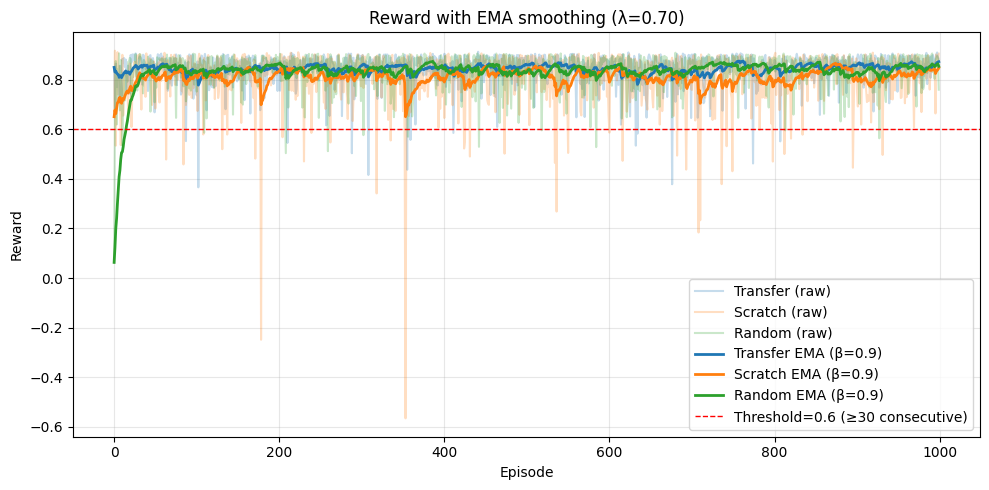

Saved: ./plots/reward_with_EMA.png


In [25]:
# === Add-on Analysis: Threshold episode + EMA stats/plots (with consecutive check) ===
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Configurable settings ---
R_THRESH = 0.6     # reward threshold
N_CONSEC = 30      # must hold for these many consecutive episodes
BETA = 0.9         # EMA coefficient
WINDOW = 100
SAVE_DIR = "./plots"
os.makedirs(SAVE_DIR, exist_ok=True)

# --- Helper: find earliest consecutive streak crossing threshold ---
def find_first_above_threshold(rewards, thresh, consec=1):
    streak = 0
    for i, r in enumerate(rewards, start=1):
        if r >= thresh:
            streak += 1
            if streak >= consec:
                return i - consec + 1
        else:
            streak = 0
    return None

def format_ep(ep, total):
    return ep if ep is not None else f">{total}"

# --- Compute earliest episode for each baseline ---
ep_T = find_first_above_threshold(rewards_T, R_THRESH, N_CONSEC)
ep_S = find_first_above_threshold(rewards_S, R_THRESH, N_CONSEC)
ep_R = find_first_above_threshold(rewards_R, R_THRESH, N_CONSEC)
max_eps = EPISODES_I

print(f"\n=== Earliest Episode Reaching Reward ≥ {R_THRESH} for {N_CONSEC} consecutive ===")
print(f"Transfer: {format_ep(ep_T, max_eps)}")
print(f"Scratch : {format_ep(ep_S, max_eps)}")
print(f"Random  : {format_ep(ep_R, max_eps)}")

# --- EMA + windowed stats ---
def ema(series, beta=BETA):
    ema_vals = []
    s = series[0]
    for x in series:
        s = beta * s + (1 - beta) * x
        ema_vals.append(s)
    return np.array(ema_vals)

def last_ema_stats(rewards, U, rho, beta=BETA, window=WINDOW):
    r = ema(rewards, beta)[-window:]
    u = ema(U, beta)[-window:]
    rh = ema(rho, beta)[-window:]
    return np.mean(r), np.mean(u), np.mean(rh)

mR_T, mU_T, mRho_T = last_ema_stats(rewards_T, U_T, rho_T)
mR_S, mU_S, mRho_S = last_ema_stats(rewards_S, U_S, rho_S)
mR_R, mU_R, mRho_R = last_ema_stats(rewards_R, U_R, rho_R)

print(f"\n=== Last-{WINDOW} EMA Stats (β={BETA}) ===")
print(f"Transfer:  R={mR_T:+.4f}, U={mU_T:.3f}, ρ={mRho_T:.3f}")
print(f"Scratch :  R={mR_S:+.4f}, U={mU_S:.3f}, ρ={mRho_S:.3f}")
print(f"Random  :  R={mR_R:+.4f}, U={mU_R:.3f}, ρ={mRho_R:.3f}")

# --- Plot with EMA overlays ---
plt.figure(figsize=(10,5))
plt.plot(rewards_T, alpha=0.25, label="Transfer (raw)", color="tab:blue")
plt.plot(rewards_S, alpha=0.25, label="Scratch (raw)", color="tab:orange")
plt.plot(rewards_R, alpha=0.25, label="Random (raw)", color="tab:green")

plt.plot(ema(rewards_T), label=f"Transfer EMA (β={BETA})", color="tab:blue", lw=2)
plt.plot(ema(rewards_S), label=f"Scratch EMA (β={BETA})", color="tab:orange", lw=2)
plt.plot(ema(rewards_R), label=f"Random EMA (β={BETA})", color="tab:green", lw=2)

plt.axhline(R_THRESH, color="red", linestyle="--", lw=1,
            label=f"Threshold={R_THRESH} (≥{N_CONSEC} consecutive)")

plt.title(f"Reward with EMA smoothing (λ={LAM_TEST:.2f})")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
fname = f"{SAVE_DIR}/reward_with_EMA.png"
plt.savefig(fname, dpi=150)
plt.show()
print(f"Saved: {fname}")


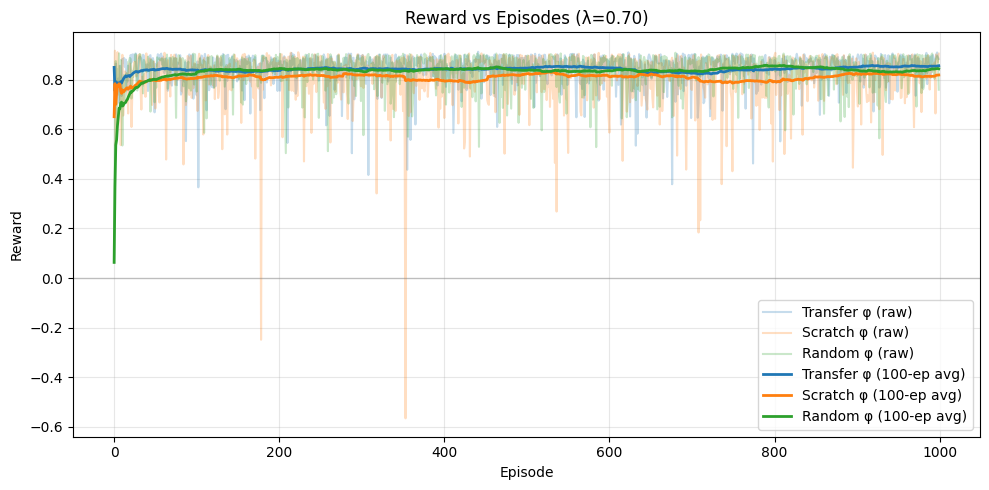

Saved: ./plots/reward_overall.png


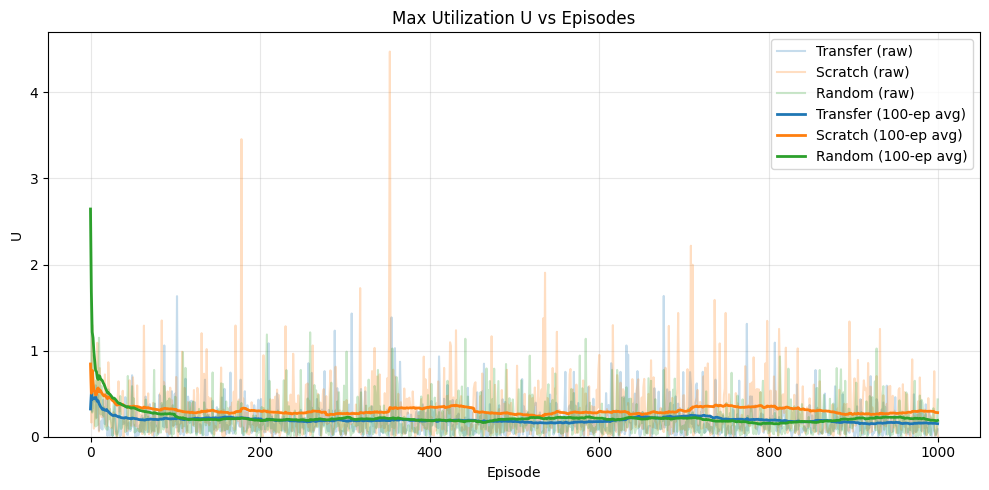

Saved: ./plots/maxU_overall.png


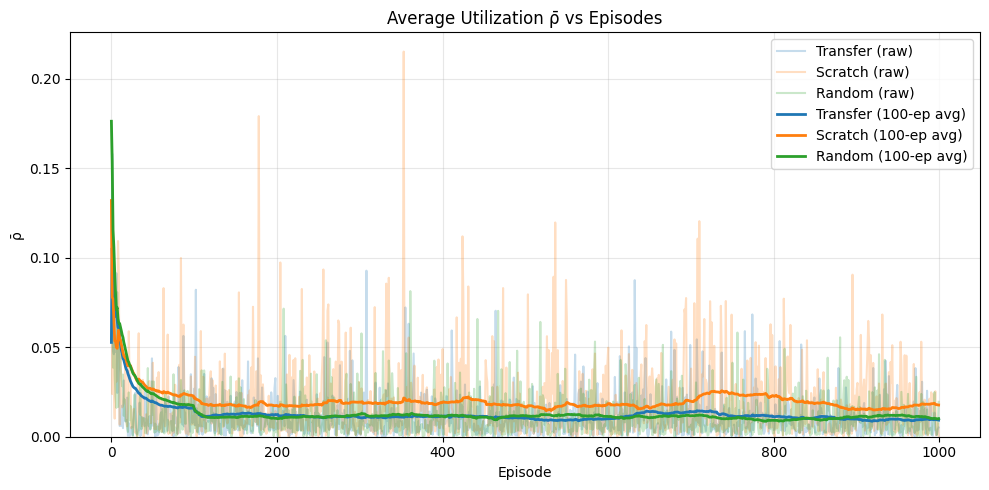

Saved: ./plots/avgRho_overall.png


In [26]:
# =======================================
# Cell 9 — Inference Results Visualization (Transfer vs Scratch vs Random)
# =======================================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

SAVE_DIR = "./plots"
os.makedirs(SAVE_DIR, exist_ok=True)

ROLL_WIN = 100  # rolling window size for smoothing

def roll(x, w=ROLL_WIN):
    return pd.Series(x).rolling(window=w, min_periods=1).mean().to_numpy()

colors = {
    "Transfer": "tab:blue",
    "Scratch": "tab:orange",
    "Random":  "tab:green"
}

# --- 1️⃣ Reward ---
plt.figure(figsize=(10, 5))
plt.plot(rewards_T, alpha=0.25, color=colors["Transfer"], label="Transfer φ (raw)")
plt.plot(rewards_S, alpha=0.25, color=colors["Scratch"], label="Scratch φ (raw)")
plt.plot(rewards_R, alpha=0.25, color=colors["Random"],  label="Random φ (raw)")

plt.plot(roll(rewards_T), color=colors["Transfer"], lw=2, label=f"Transfer φ ({ROLL_WIN}-ep avg)")
plt.plot(roll(rewards_S), color=colors["Scratch"], lw=2, label=f"Scratch φ ({ROLL_WIN}-ep avg)")
plt.plot(roll(rewards_R), color=colors["Random"],  lw=2, label=f"Random φ ({ROLL_WIN}-ep avg)")

plt.axhline(0, lw=1, alpha=0.4, color="gray")
plt.title(f"Reward vs Episodes (λ={LAM_TEST:.2f})")
plt.xlabel("Episode"); plt.ylabel("Reward")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
fname = f"{SAVE_DIR}/reward_overall.png"
plt.savefig(fname, dpi=150); plt.show()
print(f"Saved: {fname}")

# --- 2️⃣ Max Utilization U ---
plt.figure(figsize=(10, 5))
plt.plot(U_T, alpha=0.25, color=colors["Transfer"], label="Transfer (raw)")
plt.plot(U_S, alpha=0.25, color=colors["Scratch"], label="Scratch (raw)")
plt.plot(U_R, alpha=0.25, color=colors["Random"],  label="Random (raw)")

plt.plot(roll(U_T), color=colors["Transfer"], lw=2, label=f"Transfer ({ROLL_WIN}-ep avg)")
plt.plot(roll(U_S), color=colors["Scratch"], lw=2, label=f"Scratch ({ROLL_WIN}-ep avg)")
plt.plot(roll(U_R), color=colors["Random"],  lw=2, label=f"Random ({ROLL_WIN}-ep avg)")

plt.ylim(bottom=0)
plt.title("Max Utilization U vs Episodes")
plt.xlabel("Episode"); plt.ylabel("U")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
fname = f"{SAVE_DIR}/maxU_overall.png"
plt.savefig(fname, dpi=150); plt.show()
print(f"Saved: {fname}")

# --- 3️⃣ Average Utilization ρ̄ ---
plt.figure(figsize=(10, 5))
plt.plot(rho_T, alpha=0.25, color=colors["Transfer"], label="Transfer (raw)")
plt.plot(rho_S, alpha=0.25, color=colors["Scratch"], label="Scratch (raw)")
plt.plot(rho_R, alpha=0.25, color=colors["Random"],  label="Random (raw)")

plt.plot(roll(rho_T), color=colors["Transfer"], lw=2, label=f"Transfer ({ROLL_WIN}-ep avg)")
plt.plot(roll(rho_S), color=colors["Scratch"], lw=2, label=f"Scratch ({ROLL_WIN}-ep avg)")
plt.plot(roll(rho_R), color=colors["Random"],  lw=2, label=f"Random ({ROLL_WIN}-ep avg)")

plt.ylim(bottom=0)
plt.title("Average Utilization ρ̄ vs Episodes")
plt.xlabel("Episode"); plt.ylabel("ρ̄")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
fname = f"{SAVE_DIR}/avgRho_overall.png"
plt.savefig(fname, dpi=150); plt.show()
print(f"Saved: {fname}")


In [27]:
# Build combined DataFrame for per-TM analysis (Transfer, Scratch, Random)
import pandas as pd
import numpy as np

df_T = pd.DataFrame({
    "episode": np.arange(len(rewards_T)),
    "gen": gen_T,
    "reward": rewards_T,
    "U": U_T,
    "rho": rho_T,
    "mode": "Transfer"
})

df_S = pd.DataFrame({
    "episode": np.arange(len(rewards_S)),
    "gen": gen_S,
    "reward": rewards_S,
    "U": U_S,
    "rho": rho_S,
    "mode": "Scratch"
})

df_R = pd.DataFrame({
    "episode": np.arange(len(rewards_R)),
    "gen": gen_R,
    "reward": rewards_R,
    "U": U_R,
    "rho": rho_R,
    "mode": "Random"
})

# Combine all three baselines
df_all = pd.concat([df_T, df_S, df_R], ignore_index=True)


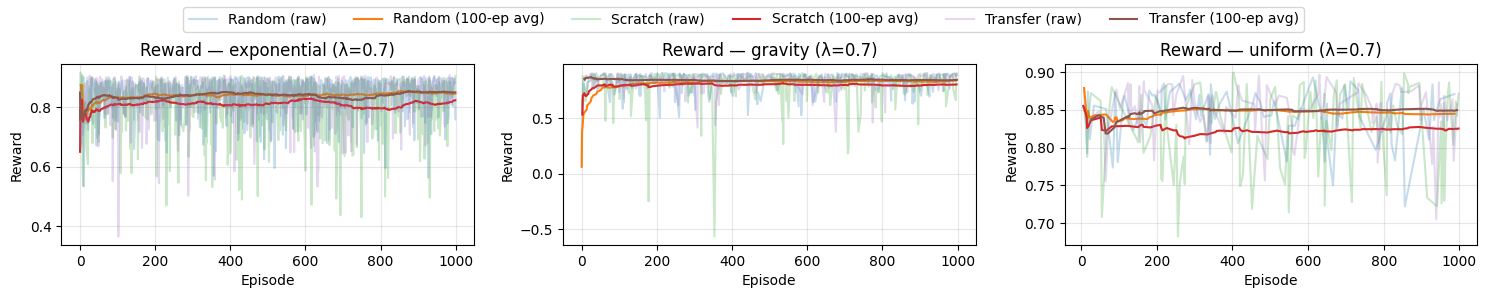

Saved: ./plots/reward_by_tmtype.png


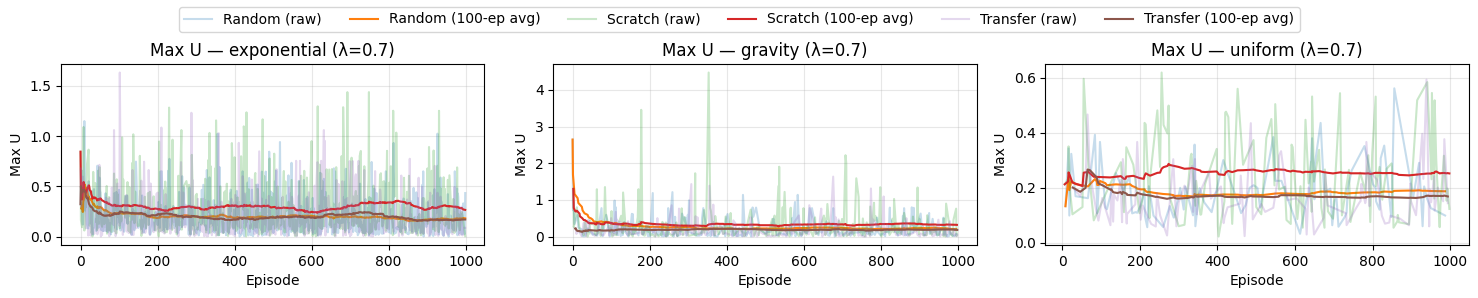

Saved: ./plots/U_by_tmtype.png


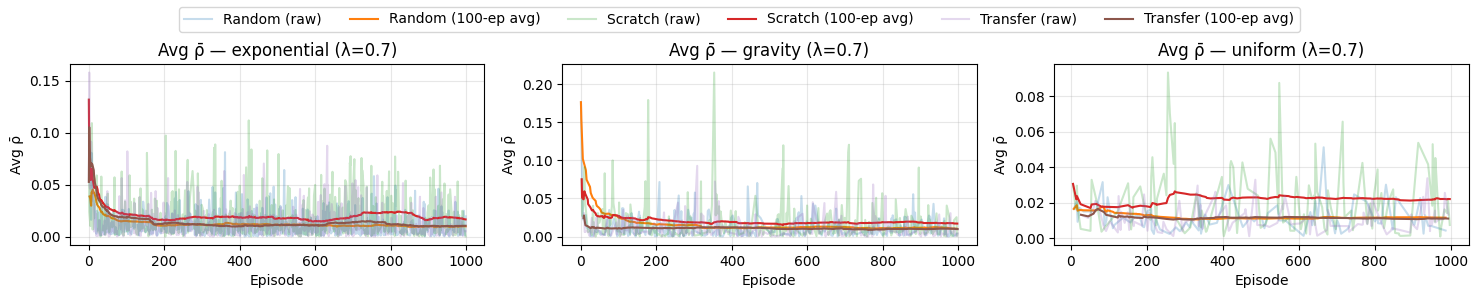

Saved: ./plots/rho_by_tmtype.png


In [28]:
import os

# create a directory to save
SAVE_DIR = "./plots"
os.makedirs(SAVE_DIR, exist_ok=True)

tm_types = sorted(df_all["gen"].unique())
metrics = [("reward","Reward"), ("U","Max U"), ("rho","Avg ρ̄")]

# dynamically grab all modes present (Transfer, Scratch, Random, etc.)
modes = sorted(df_all["mode"].unique())

for met_key, met_label in metrics:
    fig, axes = plt.subplots(1, len(tm_types), figsize=(5*len(tm_types), 3), sharey=False)
    if len(tm_types) == 1:
        axes = [axes]
    for ax, g in zip(axes, tm_types):
        sub = df_all[df_all["gen"] == g].copy()
        for mode in modes:
            ss = sub[sub["mode"] == mode].sort_values("episode")
            ax.plot(ss["episode"], ss[met_key], alpha=0.25, label=f"{mode} (raw)")
            ax.plot(ss["episode"], ss[met_key].rolling(100, min_periods=1).mean(),
                    label=f"{mode} (100-ep avg)")
        ax.set_title(f"{met_label} — {g} (λ=0.7)")
        ax.set_xlabel("Episode"); ax.set_ylabel(met_label)
        ax.grid(True, alpha=0.3)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=len(modes)*2)  # adapt legend columns
    fig.tight_layout(rect=[0,0,1,0.92])

    # save automatically
    fname = f"{SAVE_DIR}/{met_key}_by_tmtype.png"
    plt.savefig(fname, dpi=150)
    plt.show()
    print(f"Saved: {fname}")


In [29]:
# =======================================
# Summary statistics and % improvements
# =======================================

import pandas as pd
import numpy as np

# --- Stats helper functions ---
def last_stats(x, k=None):
    """Return mean ± std for last k episodes, or full if k=None."""
    x = np.asarray(x)
    if k is None or k > len(x):
        x = x[:]  # full
    else:
        x = x[-k:]
    return float(np.mean(x)), float(np.std(x))

def fmt_stats(mean, std):
    return f"{mean:.4f} ± {std:.4f}"

# --- Collect stats for all modes dynamically ---
n_eps = len(rewards_T)  # assumes all runs have the same length
windows = {"last100": 100, "last200": 200, f"all{n_eps}": None}

rows = []
all_results = {
    "Transfer": (rewards_T, U_T, rho_T),
    "Scratch":  (rewards_S, U_S, rho_S),
    "Random":   (rewards_R, U_R, rho_R)
}

# --- Compute mean ± std for each mode ---
for mode, (R, U, Rho) in all_results.items():
    row = {"mode": mode}
    for label, k in windows.items():
        mR, sR = last_stats(R, k)
        mU, sU = last_stats(U, k)
        mRho, sRho = last_stats(Rho, k)
        row[f"Reward_{label}"] = fmt_stats(mR, sR)
        row[f"U_{label}"]      = fmt_stats(mU, sU)
        row[f"rho_{label}"]    = fmt_stats(mRho, sRho)
    rows.append(row)

# --- Compute % improvements (Transfer over Scratch and Random) ---
for base in ["Scratch", "Random"]:
    row_impr = {"mode": f"% Improvement (T over {base[0]})"}
    for label, k in windows.items():
        meanT, _ = last_stats(rewards_T, k)
        meanB_R, _ = last_stats(all_results[base][0], k)
        meanT_U, _ = last_stats(U_T, k)
        meanB_U, _ = last_stats(all_results[base][1], k)
        meanT_Rho, _ = last_stats(rho_T, k)
        meanB_Rho, _ = last_stats(all_results[base][2], k)

        # Reward (↑ higher better)
        impr_reward = 100 * (meanT - meanB_R) / meanB_R if meanB_R != 0 else float("nan")
        # U, ρ̄ (↓ lower better)
        impr_U = 100 * (meanB_U - meanT_U) / meanB_U if meanB_U != 0 else float("nan")
        impr_rho = 100 * (meanB_Rho - meanT_Rho) / meanB_Rho if meanB_Rho != 0 else float("nan")

        row_impr[f"Reward_{label}"] = f"{impr_reward:.2f}%"
        row_impr[f"U_{label}"]      = f"{impr_U:.2f}%"
        row_impr[f"rho_{label}"]    = f"{impr_rho:.2f}%"

    rows.append(row_impr)

# --- Display summary table ---
summary = pd.DataFrame(rows)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
print("\n=== Inference Summary ===")
print(summary)

# --- Optional: save to CSV for paper appendix ---
summary.to_csv("./plots/inference_summary.csv", index=False)
print("\nSaved: ./plots/inference_summary.csv")



=== Inference Summary ===
                       mode   Reward_last100        U_last100      rho_last100   Reward_last200        U_last200      rho_last200   Reward_all1000        U_all1000      rho_all1000
0                  Transfer  0.8565 ± 0.0468  0.1515 ± 0.1403  0.0093 ± 0.0090  0.8536 ± 0.0504  0.1596 ± 0.1518  0.0096 ± 0.0092  0.8436 ± 0.0672  0.1894 ± 0.2003  0.0115 ± 0.0132
1                   Scratch  0.8192 ± 0.0794  0.2799 ± 0.2408  0.0177 ± 0.0165  0.8224 ± 0.0813  0.2692 ± 0.2474  0.0164 ± 0.0165  0.8115 ± 0.1096  0.2971 ± 0.3291  0.0189 ± 0.0214
2                    Random  0.8442 ± 0.0606  0.1894 ± 0.1816  0.0101 ± 0.0095  0.8415 ± 0.0634  0.1972 ± 0.1911  0.0106 ± 0.0102  0.8393 ± 0.0704  0.2048 ± 0.2129  0.0117 ± 0.0134
3  % Improvement (T over S)            4.55%           45.89%           47.55%            3.79%           40.72%           41.41%            3.96%           36.26%           38.96%
4  % Improvement (T over R)            1.45%           20.02%       